# Fighters pose detection
The goal of this part of project is to detect body points XY coordinates for fighters.

source:
https://learnopencv.com/yolo-nas-pose/

In [3]:
import torch
import os
import pathlib
# source: https://docs.deci.ai/super-gradients/latest/documentation/source/models.html
from super_gradients.training import models
from super_gradients.common.object_names import Models
import cv2
import numpy as np
import time
# https://docs.ultralytics.com/
from ultralytics import YOLO
from PIL import Image
import requests
from io import BytesIO

In [4]:
def box_label(image, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
  ''' Function that displays rectangle boxes on image. '''
  lw = max(round(sum(image.shape) / 2 * 0.003), 2) # line width with a little scaling to img size
  p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3])) # cv2.rectangle doesn't accept float XY coordinates
  cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA) # cv2.LINE_AA gives anti-aliased line which looks great for curves. I thought about cv2.LINE_4 but it doesn't matter when it comes to rectangle
  if label:
    tf = max(lw - 1, 1)  # font thickness
    cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)
    cv2.putText(image=image,
                text=label,
                org=(p1[0], p1[1] - 2), # It is the coordinates of the bottom-left corner of the text string in the image. The coordinates are represented as tuples of two values i.e. (X coordinate value, Y coordinate value).
                font=0,
                fontScale=lw / 3,
                color=txt_color,
                thickness=tf,
                lineType=cv2.LINE_AA)

In [5]:
def plot_bboxes(image, boxes, labels=[], colors=[], score=True, conf=None):
  ''' Function that displays rectangle bboxes with labels on image. It diferentiate fighters, gloves, referees, and shorts. '''

  if labels == []:
    labels = {0: u'__background__', 1: u'Fighter', 2: u'Gloves', 3: u'Referee', 4: u'Shorts'}

  if colors == []:
    colors = [(89, 161, 197), (67, 161, 255), (19, 222, 24), (186, 55, 2)]

  # Referees
  filtered_referees = [box for box in boxes if box[-1] == 2]
  filtered_referees.sort(key=lambda x: x[-2], reverse=True)

  for referee_box in filtered_referees:
    if len(filtered_referees) > 0 and (conf is None or filtered_referees[0][-2] > conf):
      box = filtered_referees[0]
      label = labels[int(box[-1]) + 1] + " " + str(round(100 * float(box[-2]), 1)) + "%"
      color = colors[int(box[-1])]
      box_label(image, box, label, color)

  # Fighters
  filtered_fighters = [box for box in boxes if box[-1] == 0]
  filtered_fighters.sort(key=lambda x: x[-2], reverse=True)

  for fighter_box in filtered_fighters:
    if conf is None or fighter_box[-2] > conf:
      label = labels[int(fighter_box[-1]) + 1] + " " + str(round(100 * float(fighter_box[-2]), 1)) + "%"
      color = colors[int(fighter_box[-1])]
      box_label(image, fighter_box, label, color)

  # Gloves
  filtered_gloves = [box for box in boxes if box[-1] == 1]
  filtered_gloves.sort(key=lambda x: x[-2], reverse=True)

  for glove_box in filtered_gloves:
    if conf is None or glove_box[-2] > conf:
      label = labels[int(glove_box[-1]) + 1] + " " + str(round(100 * float(glove_box[-2]), 1)) + "%"
      color = colors[int(glove_box[-1])]
      box_label(image, glove_box, label, color)

  # Shorts
  filtered_shorts = [box for box in boxes if box[-1] == 3]
  filtered_shorts.sort(key=lambda x: x[-2], reverse=True)

  for short_box in filtered_shorts:
    if conf is None or short_box[-2] > conf:
      label = labels[int(short_box[-1]) + 1] + " " + str(round(100 * float(short_box[-2]), 1)) + "%"
      color = colors[int(short_box[-1])]
      box_label(image, short_box, label, color)

  # Display img
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


In [6]:
def is_fighter(image_box, model_yolo, conf=0.9):
  ''' Function is taking image box, checks if shows fighter and returns boolean value '''

  # ommit all cases when model detected image box with 0 width
  if (image_box.shape[0] == 0 or image_box.shape[1]==0):
    return False

  else:
    yolo_results = model_yolo(image_box)
    filtered_fighters = [box for box in yolo_results[-1].boxes.data if box[-1] == 0]
    filtered_fighters.sort(key=lambda x: x[-2], reverse=True)
    filtered_referee = [box for box in yolo_results[-1].boxes.data if box[-1] == 2]
    filtered_referee.sort(key=lambda x: x[-2], reverse=True)

    if (len(filtered_fighters) > 0 and len(filtered_referee) > 0):
      chance_fighter = filtered_fighters[0][-2]
      chance_referee = filtered_referee[0][-2]
    elif (len(filtered_fighters) > 0 and len(filtered_referee) == 0):
      try:
        chance_fighter = filtered_fighters[0][-2]
      except:
        print(filtered_fighters[0])
      chance_referee = 0
    else:
      chance_fighter = 0
      chance_referee = 0

    if chance_fighter > chance_referee:
      flag = True
    else:
      flag = False


    return flag

In [7]:
def take_img_box(frame, model_pose, model_yolo, confidence=0.51):
  ''' function that returns bodypoints data if fighter was detected '''

  # Check if frame is given as a string containing url
  if isinstance(frame, str):
    response = requests.get(frame)
    image = Image.open(BytesIO(response.content))
    image = np.asarray(image)
  else:
    image = frame

  pose_data = []
  if (image.shape[0] > 0 and image.shape[1] > 0):
    preds = model_pose.predict(image, conf=confidence)

    prediction = preds[0].prediction
    bboxes = prediction.bboxes_xyxy # [Num Instances, 4] List of predicted bounding boxes for each object
    poses  = prediction.poses       # [Num Instances, Num Joints, 3] list of predicted joints for each detected object (x,y, confidence)
    for i in range(len(bboxes)):
      if bboxes.shape[0] > 0:
        x1, y1, x2, y2 = bboxes[i]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2) # cv2.rectangle doesn't accept float XY coordinates
        img = image.astype(np.uint8)
        cropped_image = img[y1:y2, x1:x2]
        if is_fighter(cropped_image, model_yolo):
          pose_data.append(poses[i])

      else:
        print('Empty box')
  return pose_data


In [9]:
def process_video(video_path, model, model_yolo, take_every=10, limit=None):
    ''' Function that returns numpy array containing body points coordinates for every bbox containing fighter for every video frame taken from video_path (if parameters doesn't change it). '''

    poses_data_list = []

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return None

    current_frame = 0

    while True:
        ret, frame = cap.read()

        if not ret:
            print("End of video file.")
            break

        if current_frame % take_every == 0:
            poses = take_img_box(frame, model, model_yolo)
            poses_data_list.extend(poses)

        current_frame += 1
        if isinstance(limit, int):
          if current_frame >= limit:
              print("Maximum number of frames reached.")
              break

        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    poses_data_np = np.array(poses_data_list)
    return poses_data_np


In [10]:
# Urls to example pictures on the internet
urls = [
    "https://mir-s3-cdn-cf.behance.net/project_modules/max_3840/2712bd29493563.55f6ec5e98924.jpg",
    "https://i.pinimg.com/736x/5a/8a/5c/5a8a5c4cd658580ae4719e5c96043541.jpg",
    "https://mir-s3-cdn-cf.behance.net/project_modules/max_1200/4d222729493563.55f6420cd3768.jpg",
    "https://nypost.com/wp-content/uploads/sites/2/2022/06/jiri.jpg",
    "https://www.mmarocks.pl/wp-content/uploads/2022/06/waef3q.jpg",
    "https://a4.espncdn.com/combiner/i?img=%2Fphoto%2F2017%2F0826%2Fr249560_1296x729_16%2D9.jpg",
    "https://mmabnb.pl/wp-content/uploads/2021/05/may-mac-3.jpg",
    "https://cdn.images.express.co.uk/img/dynamic/167/590x/922992_1.jpg",
    "https://combatpress.com/wp-content/uploads/2020/01/Marat-Grigorian-7.jpg",
    "https://galwaypulse.com/wp-content/uploads/2023/01/cian-mccormack-kickboxing-ireland.jpg",
    "https://cdn.onefc.com/wp-content/uploads/2021/02/Ahmed-Mujtaba-Rahul-Raju-UNBREAKABLE-III-1920X1280-10.jpg",
]

In [ ]:
model_yolo = YOLO("/content/drive/MyDrive/fighters-detection/yolov8m_custom.pt")

In [ ]:
yolo_results = model_yolo(urls)

In [ ]:
for result in yolo_results:
  boxes = result.boxes
  print(boxes)

0: 640x640 19 FIGHTERs, 4 Glovess, 11 REFEREEs, 2 SHORTSs, 1: 640x640 7 FIGHTERs, 27 REFEREEs, 2: 640x640 12 FIGHTERs, 3 Glovess, 2 REFEREEs, 5 SHORTSs, 3: 640x640 17 FIGHTERs, 13 Glovess, 3 REFEREEs, 1 SHORTS, 4: 640x640 9 FIGHTERs, 2 Glovess, 3 REFEREEs, 1 SHORTS, 5: 640x640 27 FIGHTERs, 6 Glovess, 7 REFEREEs, 1 SHORTS, 6: 640x640 17 FIGHTERs, 9 Glovess, 10 REFEREEs, 2 SHORTSs, 7: 640x640 7 FIGHTERs, 6 Glovess, 16 REFEREEs, 4 SHORTSs, 8: 640x640 8 FIGHTERs, 2 Glovess, 11 REFEREEs, 1 SHORTS, 9: 640x640 5 FIGHTERs, 7 Glovess, 8 REFEREEs, 2 SHORTSs, 10: 640x640 18 FIGHTERs, 6 Glovess, 5 REFEREEs, 7 SHORTSs, 277.6ms
Speed: 9.2ms preprocess, 25.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([2., 2., 2., 0., 0., 1., 0., 0., 2., 1., 2., 0., 2., 0., 0., 0., 0., 0., 1., 3., 0., 0., 2., 2., 2., 2., 3., 0., 0., 0., 0., 1., 2., 0., 0., 0.], device='cuda:0')
conf: tensor([0.9997, 0.9987, 0.9845, 0.9639, 0.

In [ ]:
'''
Classes:
["FIGHTER", "Gloves", "REFEREE", "SHORTS"]
[0, 1, 2, 3]
'''

'\nClasses:\n["FIGHTER", "Gloves", "REFEREE", "SHORTS"]\n[0, 1, 2, 3]\n'

In [ ]:
print(yolo_results[-1].boxes.cls)

tensor([0., 3., 0., 0., 2., 1., 0., 0., 1., 0., 3., 3., 2., 0., 0., 0., 1., 0., 0., 0., 0., 2., 3., 3., 0., 2., 0., 3., 0., 0., 3., 1., 1., 2., 0., 1.], device='cuda:0')


In [ ]:
print(yolo_results[-1].boxes.conf)

tensor([0.9999, 0.9999, 0.9998, 0.9990, 0.9979, 0.9971, 0.9934, 0.9912, 0.9898, 0.9690, 0.9623, 0.9619, 0.9503, 0.9006, 0.8999, 0.8679, 0.8230, 0.7972, 0.7750, 0.7691, 0.7167, 0.6561, 0.5340, 0.5321, 0.5201, 0.5178, 0.4964, 0.4404, 0.4355, 0.4099, 0.3544, 0.3336, 0.3185, 0.2826, 0.2737, 0.2658], device='cuda:0')


In [ ]:
yolo_results[-1].boxes.data

tensor([[9.7249e+02, 1.7031e+02, 1.4987e+03, 1.0665e+03, 9.9994e-01, 0.0000e+00],
        [1.1126e+03, 6.7048e+02, 1.4027e+03, 8.9724e+02, 9.9985e-01, 3.0000e+00],
        [1.1234e+03, 2.0853e+02, 1.4983e+03, 1.0660e+03, 9.9976e-01, 0.0000e+00],
        [8.4766e+02, 1.7527e+02, 1.4827e+03, 1.0800e+03, 9.9901e-01, 0.0000e+00],
        [7.0871e+02, 0.0000e+00, 1.0518e+03, 4.7744e+02, 9.9788e-01, 2.0000e+00],
        [5.5070e+02, 3.7776e+02, 7.0240e+02, 4.7989e+02, 9.9714e-01, 1.0000e+00],
        [1.1670e+03, 3.6704e+02, 1.5568e+03, 1.0690e+03, 9.9344e-01, 0.0000e+00],
        [6.9981e+02, 9.8676e-01, 1.0910e+03, 8.2358e+02, 9.9120e-01, 0.0000e+00],
        [7.7179e+02, 3.3329e+02, 9.0330e+02, 5.0161e+02, 9.8976e-01, 1.0000e+00],
        [2.0568e+02, 1.6547e+02, 6.9429e+02, 1.0800e+03, 9.6900e-01, 0.0000e+00],
        [9.6753e+02, 6.6777e+02, 1.4102e+03, 8.9486e+02, 9.6228e-01, 3.0000e+00],
        [2.5661e+02, 6.3888e+02, 4.5471e+02, 8.2668e+02, 9.6188e-01, 3.0000e+00],
        [1.3191e

In [ ]:
response = requests.get(urls[-1])
image = Image.open(BytesIO(response.content))
image = np.asarray(image)

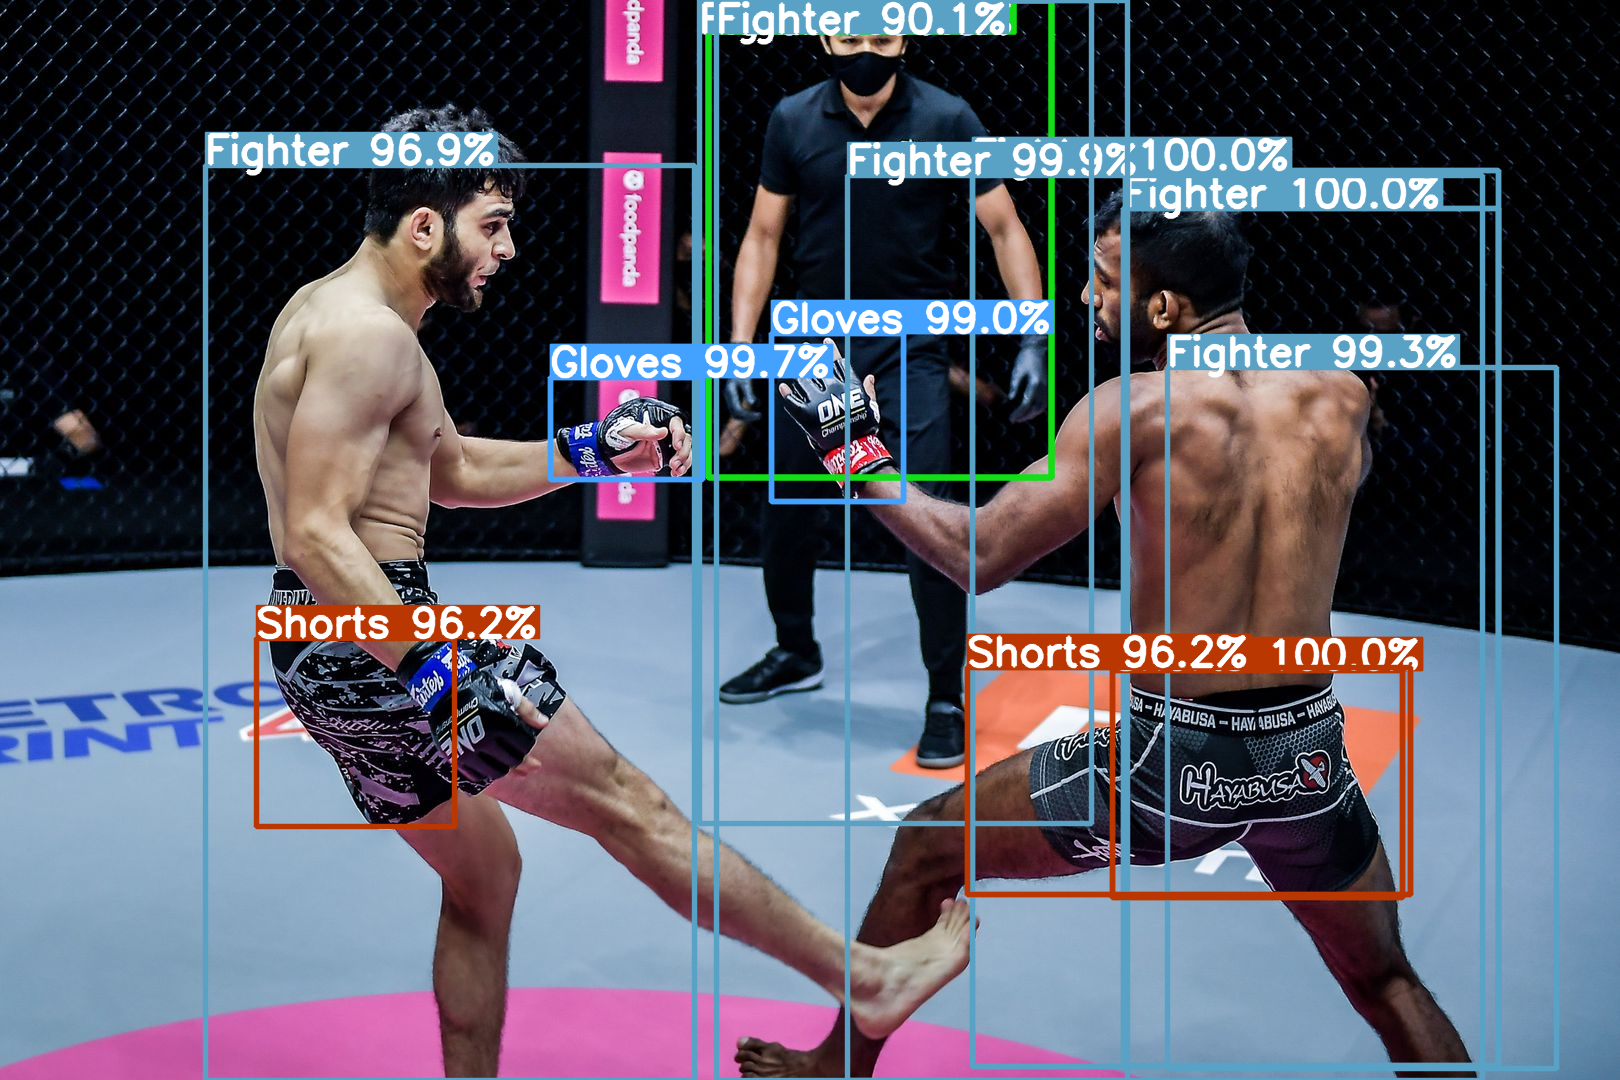

In [ ]:
plot_bboxes(image, yolo_results[-1].boxes.data, score=True, conf=0.9)

In [ ]:
model = models.get("yolo_nas_pose_l", pretrained_weights="coco_pose")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

[2023-11-29 18:00:47] INFO - checkpoint_utils.py - License Notification: YOLO-NAS-POSE pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS-POSE.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2023-11-29 18:00:47] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_pose_l


YoloNASPose_L(
  (backbone): NStageBackbone(
    (stem): YoloNASStem(
      (conv): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(48, eps=1e-06, momentum=0.03, affine=True, track_running_stats=True)
        )
        (branch_1x1): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2))
        (post_bn): BatchNorm2d(48, eps=1e-06, momentum=0.03, affine=True, track_running_stats=True)
        (rbr_reparam): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (stage1): YoloNASStage(
      (downsample): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=1e-06, momentum=0.03, affin

In [ ]:
confidence = 0.51

[2023-11-26 08:08:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


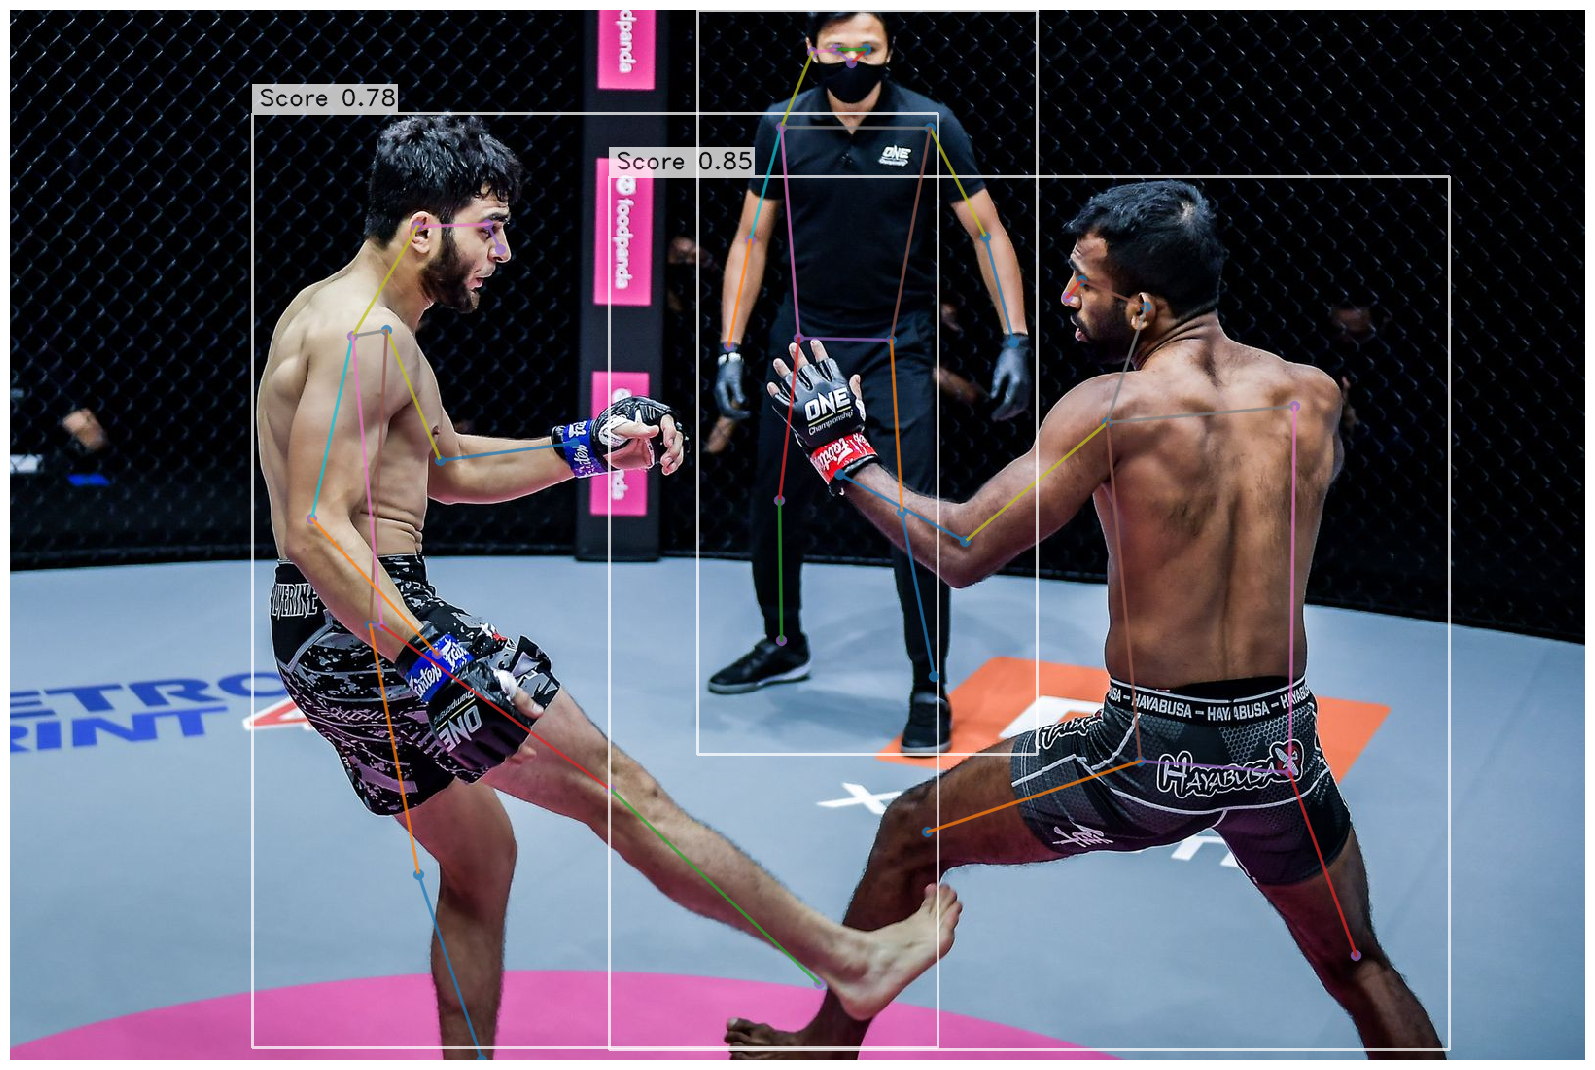

In [ ]:
model.predict(urls[-1], conf=confidence).show()

In [ ]:
# output_file = pathlib.Path(urls[3]).stem + "-detections" + pathlib.Path(urls[3]).suffix
# model.predict(urls[3], conf=confidence).save(output_file)

In [ ]:
pred = model.predict(urls[-1], conf=confidence)

[2023-11-26 08:08:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


In [ ]:
prediction = pred[0].prediction

The raw predictions will have the following:

- Bounding Box predictions in XYXY format
- Detection scores for the predicted objects
- 17 Keypoint predictions in XY format
- Confidence scores for each of these keypoints

The initial post-processing step should include applying Non-Maximum Suppression to both the box detections and pose predictions, giving you a collection of high-confidence predictions. Then choose the matching boxes and poses, which together form the model output. Since the model is trained to ensure that box detections and pose predictions occur in the same spatial location, their consistency is maintained

In [ ]:
bboxes = prediction.bboxes_xyxy # [Num Instances, 4] List of predicted bounding boxes for each object
poses  = prediction.poses       # [Num Instances, Num Joints, 3] list of predicted joints for each detected object (x,y, confidence)
scores = prediction.scores      # [Num Instances] - Confidence value for each predicted instance


In [ ]:
bboxes.shape

(3, 4)

In [ ]:
poses.shape

(3, 17, 3)

In [ ]:
'''
keypoints_mapping = {
    0: 'nose',
    1: 'left_eye',
    2: 'right_eye',
    3: 'left_ear',
    4: 'right_ear',
    5: 'left_shoulder',
    6: 'right_shoulder',
    7: 'left_elbow',
    8: 'right_elbow',
    9: 'left_wrist',
    10: 'right_wrist',
    11: 'left_hip',
    12: 'right_hip',
    13: 'left_knee',
    14: 'right_knee',
    15: 'left_ankle',
    16: 'right_ankle',
}
The origin (0,0) is at the top-left corner of the image
'''

In [ ]:
print(poses)

[[[     865.96      54.791      0.8525]
  [     879.93       40.29     0.85875]
  [     849.88      40.243     0.86306]
  [     900.78      41.797     0.49532]
  [     825.69      43.096     0.67649]
  [     946.08      121.07     0.97859]
  [     793.39      120.55     0.98085]
  [     1002.9      234.02     0.92766]
  [     761.88       236.4     0.94488]
  [     1032.2      343.08     0.86227]
  [     738.91      345.84     0.90752]
  [     907.02         340     0.96861]
  [      811.8      337.33     0.96838]
  [     917.53      516.07     0.97356]
  [     791.85      504.96     0.97857]
  [     950.39      686.22     0.94935]
  [     793.31      648.02     0.96306]]

 [[     1086.8      295.65     0.58216]
  [     1102.9      278.22     0.62613]
  [     1097.6      278.27    0.060253]
  [     1168.2      305.08     0.79525]
  [       1223      306.04     0.12469]
  [     1129.2      424.89     0.94753]
  [     1321.1      407.55     0.81186]
  [     981.94      545.92      0.8782

In [ ]:
type(poses)

numpy.ndarray

In [ ]:
test_poses = take_img_box(urls[-2], model, model_yolo)

[2023-11-26 08:15:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 13 FIGHTERs, 4 Glovess, 2 REFEREEs, 3 SHORTSs, 29.4ms
Speed: 2.4ms preprocess, 29.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

0: 640x352 8 FIGHTERs, 5 Glovess, 6 REFEREEs, 8 SHORTSs, 120.8ms
Speed: 7.7ms preprocess, 120.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)



In [ ]:
print(test_poses)

[array([[      692.4,       279.7,     0.90088],
       [     702.46,      268.05,     0.90576],
       [     688.29,      268.73,     0.54883],
       [     738.11,      266.91,      0.7627],
       [     690.57,      268.51,    0.076843],
       [     781.98,       336.6,     0.93652],
       [     679.61,      316.49,     0.95654],
       [      766.9,      426.64,     0.81006],
       [      633.9,      385.73,     0.91406],
       [     736.73,      368.37,     0.78271],
       [      565.8,      414.98,     0.83105],
       [     706.57,      484.45,     0.97461],
       [     642.13,      449.03,     0.97412],
       [     683.72,      621.56,     0.92041],
       [     523.76,      515.07,     0.91504],
       [     623.39,      742.22,     0.76221],
       [     409.96,      576.77,     0.79248]], dtype=float32), array([[     413.38,      287.47,     0.58057],
       [     419.33,      279.02,     0.29297],
       [     406.07,       276.5,     0.48438],
       [     419.55,  

In [ ]:
video_path = "/content/drive/MyDrive/fighters-detection/Bartos-kaszubowski.mp4"

In [ ]:
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)

cap.release()

In [ ]:
print(f'FPS klipu wideo: {fps}')

FPS klipu wideo: 25.0


In [ ]:
take_every = int(fps)
# limit = 2000

In [ ]:
poses_data_list = []

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error opening video file.")
    exit()

current_frame = 1000
# start_time = time.time()

while True:
    ret, frame = cap.read()

    if not ret:
        print("End of video file.")
        break

    if current_frame % take_every == 0:
        # pred = model.predict(frame, conf=confidence)
        # prediction = pred[0].prediction
        poses = take_img_box(frame, model, model_yolo)

        # print(f"Width: {width}, Height: {height}")
        # current_time = time.time() - start_time
        # poses_data_list.append({'time': current_time, 'poses': poses})
        # if len(poses) == 2: # Means only if both fighters are detected, add data to list
        #   poses_data_list.append(poses)
        poses_data_list.extend(poses)

    current_frame += 1

    if current_frame >= limit:
        print("Maximum number of frames reached.")
        break

    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


poses_data_np = np.array(poses_data_list)


[2023-11-26 08:10:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:10:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:10:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:10:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:10:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 16 FIGHTERs, 13 REFEREEs, 2 SHORTSs, 144.5ms
Speed: 3.2ms preprocess, 144.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)



[2023-11-26 08:10:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


0: 640x640 10 FIGHTERs, 16 REFEREEs, 2 SHORTSs, 38.3ms
Speed: 3.1ms preprocess, 38.3ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 16 FIGHTERs, 17 REFEREEs, 2 SHORTSs, 68.9ms
Speed: 2.4ms preprocess, 68.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 576)

0: 640x640 6 FIGHTERs, 18 REFEREEs, 5 SHORTSs, 38.2ms
Speed: 2.5ms preprocess, 38.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:10:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:10:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 13 FIGHTERs, 2 Glovess, 14 REFEREEs, 1 SHORTS, 26.3ms
Speed: 2.4ms preprocess, 26.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 7 FIGHTERs, 1 Gloves, 12 REFEREEs, 25.6ms
Speed: 2.1ms preprocess, 25.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)

0: 640x544 10 FIGHTERs, 10 REFEREEs, 2 SHORTSs, 68.4ms
Speed: 2.3ms preprocess, 68.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

0: 640x576 15 FIGHTERs, 2 Glovess, 15 REFEREEs, 25.7ms
Speed: 2.3ms preprocess, 25.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:10:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 12 FIGHTERs, 8 REFEREEs, 8 SHORTSs, 68.3ms
Speed: 1.8ms preprocess, 68.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x544 17 FIGHTERs, 1 Gloves, 13 REFEREEs, 2 SHORTSs, 23.7ms
Speed: 2.2ms preprocess, 23.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:10:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 17 FIGHTERs, 8 REFEREEs, 8 SHORTSs, 53.5ms
Speed: 3.4ms preprocess, 53.5ms inference, 11.1ms postprocess per image at shape (1, 3, 640, 544)

0: 640x384 10 FIGHTERs, 1 Gloves, 5 REFEREEs, 1 SHORTS, 19.0ms
Speed: 3.7ms preprocess, 19.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:10:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 13 FIGHTERs, 1 Gloves, 12 REFEREEs, 4 SHORTSs, 72.3ms
Speed: 2.0ms preprocess, 72.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)

0: 640x416 12 FIGHTERs, 5 REFEREEs, 73.0ms
Speed: 2.1ms preprocess, 73.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:10:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:10:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 11 FIGHTERs, 12 REFEREEs, 1 SHORTS, 36.4ms
Speed: 2.4ms preprocess, 36.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

0: 640x384 9 FIGHTERs, 1 Gloves, 7 REFEREEs, 3 SHORTSs, 25.9ms
Speed: 1.7ms preprocess, 25.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x480 12 FIGHTERs, 1 Gloves, 12 REFEREEs, 4 SHORTSs, 70.8ms
Speed: 2.3ms preprocess, 70.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 14 FIGHTERs, 1 Gloves, 5 REFEREEs, 1 SHORTS, 28.6ms
Speed: 1.9ms preprocess, 28.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:10:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:10:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 3 FIGHTERs, 1 Gloves, 11 REFEREEs, 25.9ms
Speed: 1.8ms preprocess, 25.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x544 4 FIGHTERs, 16 REFEREEs, 3 SHORTSs, 36.3ms
Speed: 2.2ms preprocess, 36.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:10:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 15 FIGHTERs, 1 Gloves, 11 REFEREEs, 1 SHORTS, 22.9ms
Speed: 2.4ms preprocess, 22.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)

0: 640x640 12 FIGHTERs, 4 Glovess, 12 REFEREEs, 1 SHORTS, 29.6ms
Speed: 2.4ms preprocess, 29.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:10:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 7 FIGHTERs, 11 REFEREEs, 20.6ms
Speed: 2.5ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:10:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 576x640 19 FIGHTERs, 9 REFEREEs, 76.3ms
Speed: 3.6ms preprocess, 76.3ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:10:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:10:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 8 FIGHTERs, 14 REFEREEs, 1 SHORTS, 20.6ms
Speed: 2.2ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x608 11 FIGHTERs, 12 REFEREEs, 2 SHORTSs, 69.2ms
Speed: 2.8ms preprocess, 69.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:10:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 576x640 7 FIGHTERs, 9 REFEREEs, 2 SHORTSs, 33.7ms
Speed: 3.6ms preprocess, 33.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:10:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 10 FIGHTERs, 7 REFEREEs, 1 SHORTS, 118.4ms
Speed: 3.4ms preprocess, 118.4ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:10:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 9 FIGHTERs, 17 REFEREEs, 37.7ms
Speed: 4.2ms preprocess, 37.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:10:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 7 FIGHTERs, 17 REFEREEs, 38.0ms
Speed: 3.3ms preprocess, 38.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:10:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 11 FIGHTERs, 17 REFEREEs, 37.7ms
Speed: 2.6ms preprocess, 37.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:10:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 12 FIGHTERs, 22 REFEREEs, 2 SHORTSs, 35.8ms
Speed: 3.8ms preprocess, 35.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:10:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 12 FIGHTERs, 14 REFEREEs, 29.5ms
Speed: 3.1ms preprocess, 29.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:10:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 15 FIGHTERs, 2 Glovess, 7 REFEREEs, 1 SHORTS, 115.4ms
Speed: 3.4ms preprocess, 115.4ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:10:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 9 FIGHTERs, 7 Glovess, 14 REFEREEs, 109.5ms
Speed: 3.2ms preprocess, 109.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:10:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 7 FIGHTERs, 3 Glovess, 11 REFEREEs, 29.9ms
Speed: 4.3ms preprocess, 29.9ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:10:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 10 FIGHTERs, 1 Gloves, 11 REFEREEs, 1 SHORTS, 128.4ms
Speed: 3.3ms preprocess, 128.4ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:10:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 11 FIGHTERs, 4 Glovess, 8 REFEREEs, 112.2ms
Speed: 3.8ms preprocess, 112.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:10:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 9 FIGHTERs, 1 Gloves, 12 REFEREEs, 113.3ms
Speed: 3.0ms preprocess, 113.3ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:10:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 7 FIGHTERs, 1 Gloves, 12 REFEREEs, 29.5ms
Speed: 3.2ms preprocess, 29.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:10:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 13 FIGHTERs, 1 Gloves, 17 REFEREEs, 29.3ms
Speed: 3.5ms preprocess, 29.3ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:10:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:10:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 13 FIGHTERs, 1 Gloves, 18 REFEREEs, 1 SHORTS, 29.3ms
Speed: 2.4ms preprocess, 29.3ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:10:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 8 FIGHTERs, 2 Glovess, 13 REFEREEs, 28.5ms
Speed: 2.4ms preprocess, 28.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:10:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 7 FIGHTERs, 3 Glovess, 12 REFEREEs, 28.5ms
Speed: 3.1ms preprocess, 28.5ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 288x640 10 FIGHTERs, 4 REFEREEs, 1 SHORTS, 76.4ms
Speed: 1.7ms preprocess, 76.4ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)


[2023-11-26 08:10:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


In [ ]:
video_paths = ["/content/drive/MyDrive/fighters-detection/kd1.mp4", "/content/drive/MyDrive/fighters-detection/Bartos-kaszubowski.mp4", "/content/drive/MyDrive/fighters-detection/kd2.mp4"]
all_poses_data = []

for video_path in video_paths:
    poses_data = process_video(video_path, model, model_yolo, take_every=10, limit=None)
    if poses_data is not None:
        all_poses_data.extend(poses_data)



[2023-11-26 08:23:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 13 FIGHTERs, 4 Glovess, 9 REFEREEs, 4 SHORTSs, 26.5ms
Speed: 2.5ms preprocess, 26.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 6 FIGHTERs, 1 Gloves, 9 REFEREEs, 10 SHORTSs, 25.0ms
Speed: 3.1ms preprocess, 25.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 8 FIGHTERs, 5 REFEREEs, 3 SHORTSs, 26.9ms
Speed: 2.0ms preprocess, 26.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:23:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 4 FIGHTERs, 1 Gloves, 10 REFEREEs, 2 SHORTSs, 26.5ms
Speed: 1.9ms preprocess, 26.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 10 FIGHTERs, 1 REFEREE, 2 SHORTSs, 25.4ms
Speed: 1.6ms preprocess, 25.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 3 FIGHTERs, 9 REFEREEs, 7 SHORTSs, 26.8ms
Speed: 2.0ms preprocess, 26.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:23:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 10 FIGHTERs, 2 Glovess, 14 REFEREEs, 3 SHORTSs, 21.9ms
Speed: 2.5ms preprocess, 21.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 11 FIGHTERs, 1 Gloves, 8 REFEREEs, 3 SHORTSs, 40.2ms
Speed: 2.3ms preprocess, 40.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 2 FIGHTERs, 11 REFEREEs, 5 SHORTSs, 23.9ms
Speed: 1.8ms preprocess, 23.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:23:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 14 FIGHTERs, 2 Glovess, 9 REFEREEs, 5 SHORTSs, 20.1ms
Speed: 2.2ms preprocess, 20.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 11 FIGHTERs, 1 Gloves, 8 REFEREEs, 2 SHORTSs, 21.1ms
Speed: 2.0ms preprocess, 21.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 6 FIGHTERs, 1 Gloves, 7 REFEREEs, 2 SHORTSs, 20.0ms
Speed: 2.4ms preprocess, 20.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:23:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 15 FIGHTERs, 4 Glovess, 11 REFEREEs, 5 SHORTSs, 22.3ms
Speed: 3.1ms preprocess, 22.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 4 FIGHTERs, 1 Gloves, 11 REFEREEs, 4 SHORTSs, 16.9ms
Speed: 2.5ms preprocess, 16.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 7 FIGHTERs, 5 REFEREEs, 16.3ms
Speed: 1.7ms preprocess, 16.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:23:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 19 FIGHTERs, 1 Gloves, 6 REFEREEs, 6 SHORTSs, 17.6ms
Speed: 3.4ms preprocess, 17.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 4 FIGHTERs, 7 REFEREEs, 1 SHORTS, 119.2ms
Speed: 2.2ms preprocess, 119.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 8 FIGHTERs, 1 Gloves, 12 REFEREEs, 3 SHORTSs, 17.1ms
Speed: 2.1ms preprocess, 17.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:23:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 17 FIGHTERs, 2 Glovess, 6 REFEREEs, 5 SHORTSs, 18.7ms
Speed: 3.2ms preprocess, 18.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)

0: 640x288 3 FIGHTERs, 1 Gloves, 8 REFEREEs, 15.5ms
Speed: 1.7ms preprocess, 15.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 5 FIGHTERs, 11 REFEREEs, 16.0ms
Speed: 1.5ms preprocess, 16.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:23:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 12 FIGHTERs, 1 Gloves, 7 REFEREEs, 4 SHORTSs, 18.9ms
Speed: 2.5ms preprocess, 18.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 7 FIGHTERs, 2 Glovess, 6 REFEREEs, 3 SHORTSs, 17.3ms
Speed: 2.0ms preprocess, 17.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 4 FIGHTERs, 7 REFEREEs, 1 SHORTS, 19.6ms
Speed: 1.6ms preprocess, 19.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:23:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 13 FIGHTERs, 2 Glovess, 9 REFEREEs, 4 SHORTSs, 29.6ms
Speed: 2.8ms preprocess, 29.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x288 3 FIGHTERs, 2 Glovess, 8 REFEREEs, 2 SHORTSs, 24.4ms
Speed: 1.9ms preprocess, 24.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 2 FIGHTERs, 1 Gloves, 9 REFEREEs, 16.5ms
Speed: 1.4ms preprocess, 16.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:23:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 9 FIGHTERs, 1 Gloves, 4 REFEREEs, 4 SHORTSs, 24.3ms
Speed: 2.8ms preprocess, 24.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 4 FIGHTERs, 1 Gloves, 7 REFEREEs, 2 SHORTSs, 16.8ms
Speed: 1.9ms preprocess, 16.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:23:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 10 FIGHTERs, 1 Gloves, 9 REFEREEs, 3 SHORTSs, 24.9ms
Speed: 3.1ms preprocess, 24.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

0: 640x288 6 FIGHTERs, 1 Gloves, 8 REFEREEs, 7 SHORTSs, 20.4ms
Speed: 2.0ms preprocess, 20.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 6 FIGHTERs, 7 REFEREEs, 4 SHORTSs, 117.5ms
Speed: 1.4ms preprocess, 117.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:23:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 8 FIGHTERs, 1 Gloves, 6 REFEREEs, 6 SHORTSs, 20.7ms
Speed: 2.5ms preprocess, 20.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 2 FIGHTERs, 15 REFEREEs, 3 SHORTSs, 19.7ms
Speed: 1.9ms preprocess, 19.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 4 FIGHTERs, 2 Glovess, 11 REFEREEs, 8 SHORTSs, 19.0ms
Speed: 1.7ms preprocess, 19.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:23:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 10 FIGHTERs, 3 Glovess, 7 REFEREEs, 4 SHORTSs, 23.5ms
Speed: 2.2ms preprocess, 23.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 2 FIGHTERs, 7 REFEREEs, 23.2ms
Speed: 1.9ms preprocess, 23.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 5 FIGHTERs, 1 Gloves, 7 REFEREEs, 2 SHORTSs, 115.0ms
Speed: 1.4ms preprocess, 115.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:23:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 16 FIGHTERs, 1 Gloves, 8 REFEREEs, 6 SHORTSs, 25.6ms
Speed: 2.1ms preprocess, 25.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 3 FIGHTERs, 8 REFEREEs, 2 SHORTSs, 24.4ms
Speed: 1.8ms preprocess, 24.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 2 FIGHTERs, 13 REFEREEs, 2 SHORTSs, 26.7ms
Speed: 2.1ms preprocess, 26.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:23:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 6 FIGHTERs, 1 Gloves, 6 REFEREEs, 4 SHORTSs, 25.2ms
Speed: 2.5ms preprocess, 25.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 8 FIGHTERs, 6 REFEREEs, 7 SHORTSs, 24.4ms
Speed: 1.6ms preprocess, 24.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 3 FIGHTERs, 8 REFEREEs, 24.2ms
Speed: 2.2ms preprocess, 24.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:23:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 4 FIGHTERs, 6 REFEREEs, 6 SHORTSs, 25.7ms
Speed: 1.6ms preprocess, 25.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)

0: 640x416 8 FIGHTERs, 2 Glovess, 8 REFEREEs, 22.3ms
Speed: 1.9ms preprocess, 22.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 416)

0: 640x288 3 FIGHTERs, 11 REFEREEs, 4 SHORTSs, 22.2ms
Speed: 1.5ms preprocess, 22.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:23:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 5 FIGHTERs, 1 Gloves, 8 REFEREEs, 4 SHORTSs, 25.5ms
Speed: 1.7ms preprocess, 25.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 5 FIGHTERs, 5 REFEREEs, 7 SHORTSs, 33.9ms
Speed: 1.7ms preprocess, 33.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 13 REFEREEs, 23.4ms
Speed: 1.6ms preprocess, 23.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:23:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 6 FIGHTERs, 2 Glovess, 5 REFEREEs, 5 SHORTSs, 22.8ms
Speed: 1.8ms preprocess, 22.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 4 FIGHTERs, 7 REFEREEs, 22.9ms
Speed: 2.1ms preprocess, 22.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x384 19 FIGHTERs, 1 Gloves, 3 REFEREEs, 4 SHORTSs, 22.5ms
Speed: 1.6ms preprocess, 22.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:23:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:23:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 2 FIGHTERs, 11 REFEREEs, 2 SHORTSs, 24.8ms
Speed: 2.8ms preprocess, 24.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 3 FIGHTERs, 3 Glovess, 9 REFEREEs, 6 SHORTSs, 16.3ms
Speed: 1.3ms preprocess, 16.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 10 FIGHTERs, 1 Gloves, 9 REFEREEs, 8 SHORTSs, 20.8ms
Speed: 1.5ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 2 FIGHTERs, 11 REFEREEs, 26.5ms
Speed: 1.5ms preprocess, 26.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 3 FIGHTERs, 5 REFEREEs, 5 SHORTSs, 23.4ms
Speed: 1.7ms preprocess, 23.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x192 3 FIGHTERs, 1 Gloves, 9 REFEREEs, 3 SHORTSs, 15.8ms
Speed: 1.1ms preprocess, 15.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:23:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:23:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 9 FIGHTERs, 3 Glovess, 9 REFEREEs, 5 SHORTSs, 18.8ms
Speed: 1.4ms preprocess, 18.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 1 FIGHTER, 17 REFEREEs, 23.9ms
Speed: 1.4ms preprocess, 23.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:23:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 2 FIGHTERs, 10 REFEREEs, 1 SHORTS, 18.1ms
Speed: 1.5ms preprocess, 18.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 4 FIGHTERs, 1 Gloves, 15 REFEREEs, 4 SHORTSs, 18.2ms
Speed: 1.5ms preprocess, 18.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x160 3 FIGHTERs, 8 REFEREEs, 3 SHORTSs, 75.8ms
Speed: 1.3ms preprocess, 75.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 160)

0: 640x256 3 FIGHTERs, 11 REFEREEs, 8 SHORTSs, 16.9ms
Speed: 1.4ms preprocess, 16.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:23:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:23:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 2 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 16.1ms
Speed: 1.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 4 FIGHTERs, 1 Gloves, 8 REFEREEs, 2 SHORTSs, 17.3ms
Speed: 1.3ms preprocess, 17.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 2 FIGHTERs, 3 Glovess, 9 REFEREEs, 4 SHORTSs, 17.7ms
Speed: 1.3ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:23:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 4 FIGHTERs, 11 REFEREEs, 4 SHORTSs, 20.9ms
Speed: 1.6ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 14 FIGHTERs, 8 REFEREEs, 3 SHORTSs, 21.5ms
Speed: 1.6ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:23:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 13 FIGHTERs, 1 Gloves, 7 REFEREEs, 6 SHORTSs, 25.1ms
Speed: 2.3ms preprocess, 25.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x352 19 FIGHTERs, 1 Gloves, 1 REFEREE, 3 SHORTSs, 22.4ms
Speed: 1.7ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:23:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 12 FIGHTERs, 1 Gloves, 6 REFEREEs, 6 SHORTSs, 24.6ms
Speed: 2.0ms preprocess, 24.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x288 5 FIGHTERs, 10 REFEREEs, 6 SHORTSs, 20.4ms
Speed: 1.4ms preprocess, 20.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:23:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 9 FIGHTERs, 2 Glovess, 2 REFEREEs, 11 SHORTSs, 22.4ms
Speed: 1.9ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 2 FIGHTERs, 8 REFEREEs, 7 SHORTSs, 20.8ms
Speed: 1.4ms preprocess, 20.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 2 FIGHTERs, 4 REFEREEs, 2 SHORTSs, 18.1ms
Speed: 1.3ms preprocess, 18.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:23:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 7 FIGHTERs, 2 Glovess, 2 REFEREEs, 6 SHORTSs, 22.3ms
Speed: 1.8ms preprocess, 22.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 14 FIGHTERs, 2 Glovess, 6 REFEREEs, 5 SHORTSs, 22.4ms
Speed: 1.7ms preprocess, 22.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:23:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 13 FIGHTERs, 3 Glovess, 2 REFEREEs, 4 SHORTSs, 26.7ms
Speed: 1.9ms preprocess, 26.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 11 FIGHTERs, 5 REFEREEs, 2 SHORTSs, 24.1ms
Speed: 1.5ms preprocess, 24.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:23:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 8 FIGHTERs, 1 Gloves, 5 REFEREEs, 6 SHORTSs, 27.7ms
Speed: 2.5ms preprocess, 27.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x352 15 FIGHTERs, 6 REFEREEs, 7 SHORTSs, 25.5ms
Speed: 1.6ms preprocess, 25.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x384 13 FIGHTERs, 1 Gloves, 7 REFEREEs, 10 SHORTSs, 26.1ms
Speed: 2.0ms preprocess, 26.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 11 FIGHTERs, 7 REFEREEs, 4 SHORTSs, 26.2ms
Speed: 1.7ms preprocess, 26.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x160 1 FIGHTER, 1 Gloves, 3 REFEREEs, 16.9ms
Speed: 1.0ms preprocess, 16.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:23:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:23:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 2 FIGHTERs, 12 REFEREEs, 2 SHORTSs, 21.0ms
Speed: 1.9ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x448 10 FIGHTERs, 1 Gloves, 9 REFEREEs, 9 SHORTSs, 21.3ms
Speed: 2.3ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x288 10 FIGHTERs, 1 Gloves, 2 REFEREEs, 4 SHORTSs, 17.6ms
Speed: 1.4ms preprocess, 17.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:23:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 6 FIGHTERs, 4 Glovess, 6 REFEREEs, 7 SHORTSs, 16.4ms
Speed: 1.8ms preprocess, 16.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 12 FIGHTERs, 4 REFEREEs, 4 SHORTSs, 15.4ms
Speed: 1.5ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 7 REFEREEs, 14.0ms
Speed: 1.2ms preprocess, 14.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:23:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 12 FIGHTERs, 3 Glovess, 8 REFEREEs, 9 SHORTSs, 17.8ms
Speed: 2.1ms preprocess, 17.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x224 5 FIGHTERs, 12 REFEREEs, 13.4ms
Speed: 1.2ms preprocess, 13.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 12 FIGHTERs, 3 Glovess, 10 REFEREEs, 4 SHORTSs, 14.9ms
Speed: 1.4ms preprocess, 14.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:23:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 9 FIGHTERs, 2 Glovess, 6 REFEREEs, 8 SHORTSs, 16.4ms
Speed: 1.8ms preprocess, 16.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 6 FIGHTERs, 1 Gloves, 12 REFEREEs, 1 SHORTS, 14.9ms
Speed: 1.4ms preprocess, 14.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 3 FIGHTERs, 7 REFEREEs, 3 SHORTSs, 13.3ms
Speed: 1.3ms preprocess, 13.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:23:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 10 FIGHTERs, 1 Gloves, 7 REFEREEs, 11 SHORTSs, 16.5ms
Speed: 1.7ms preprocess, 16.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 7 FIGHTERs, 11 REFEREEs, 4 SHORTSs, 15.5ms
Speed: 2.1ms preprocess, 15.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 4 FIGHTERs, 15 REFEREEs, 1 SHORTS, 14.7ms
Speed: 1.4ms preprocess, 14.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:23:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 12 FIGHTERs, 1 Gloves, 3 REFEREEs, 8 SHORTSs, 16.0ms
Speed: 1.8ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 6 FIGHTERs, 11 REFEREEs, 5 SHORTSs, 17.5ms
Speed: 1.6ms preprocess, 17.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x416 12 FIGHTERs, 1 Gloves, 9 REFEREEs, 11 SHORTSs, 19.0ms
Speed: 2.5ms preprocess, 19.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:23:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 8 FIGHTERs, 2 Glovess, 6 REFEREEs, 1 SHORTS, 16.4ms
Speed: 1.9ms preprocess, 16.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 5 FIGHTERs, 1 Gloves, 8 REFEREEs, 1 SHORTS, 14.9ms
Speed: 1.5ms preprocess, 14.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 9 FIGHTERs, 5 REFEREEs, 2 SHORTSs, 14.0ms
Speed: 1.3ms preprocess, 14.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x384 9 FIGHTERs, 1 Gloves, 9 REFEREEs, 3 SHORTSs, 16.4ms
Speed: 1.8ms preprocess, 16.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 1 FIGHTER, 1 Gloves, 8 REFEREEs, 1 SHORTS, 21.0ms
Speed: 1.3ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 6 FIGHTERs, 8 REFEREEs, 3 SHORTSs, 13.4ms
Speed: 1.2ms preprocess, 13.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:23:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 7 FIGHTERs, 1 Gloves, 7 REFEREEs, 5 SHORTSs, 23.1ms
Speed: 2.0ms preprocess, 23.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 6 FIGHTERs, 1 Gloves, 9 REFEREEs, 4 SHORTSs, 19.8ms
Speed: 1.9ms preprocess, 19.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 1 FIGHTER, 1 Gloves, 6 REFEREEs, 1 SHORTS, 19.1ms
Speed: 1.4ms preprocess, 19.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:23:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 4 FIGHTERs, 1 Gloves, 12 REFEREEs, 1 SHORTS, 22.9ms
Speed: 4.0ms preprocess, 22.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 4 FIGHTERs, 6 REFEREEs, 6 SHORTSs, 17.7ms
Speed: 1.8ms preprocess, 17.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 7 FIGHTERs, 3 Glovess, 8 REFEREEs, 5 SHORTSs, 22.5ms
Speed: 3.2ms preprocess, 22.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:23:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 5 FIGHTERs, 2 Glovess, 13 REFEREEs, 3 SHORTSs, 18.7ms
Speed: 1.9ms preprocess, 18.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 6 FIGHTERs, 9 REFEREEs, 3 SHORTSs, 20.7ms
Speed: 1.9ms preprocess, 20.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 8 FIGHTERs, 3 Glovess, 7 REFEREEs, 3 SHORTSs, 22.5ms
Speed: 2.0ms preprocess, 22.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:23:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 4 FIGHTERs, 2 Glovess, 9 REFEREEs, 2 SHORTSs, 21.2ms
Speed: 2.6ms preprocess, 21.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 7 FIGHTERs, 2 REFEREEs, 6 SHORTSs, 17.5ms
Speed: 1.4ms preprocess, 17.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 3 FIGHTERs, 1 Gloves, 10 REFEREEs, 4 SHORTSs, 18.2ms
Speed: 1.6ms preprocess, 18.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:23:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 3 FIGHTERs, 7 REFEREEs, 4 SHORTSs, 20.9ms
Speed: 1.7ms preprocess, 20.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 8 FIGHTERs, 2 Glovess, 8 REFEREEs, 2 SHORTSs, 25.1ms
Speed: 2.1ms preprocess, 25.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 4 FIGHTERs, 1 Gloves, 10 REFEREEs, 4 SHORTSs, 19.3ms
Speed: 1.8ms preprocess, 19.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:23:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 6 FIGHTERs, 4 REFEREEs, 6 SHORTSs, 19.4ms
Speed: 2.3ms preprocess, 19.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 6 FIGHTERs, 2 Glovess, 9 REFEREEs, 3 SHORTSs, 24.3ms
Speed: 1.7ms preprocess, 24.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x416 8 FIGHTERs, 1 Gloves, 9 REFEREEs, 4 SHORTSs, 28.6ms
Speed: 2.1ms preprocess, 28.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:23:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 9 FIGHTERs, 1 Gloves, 2 REFEREEs, 5 SHORTSs, 25.4ms
Speed: 1.6ms preprocess, 25.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x544 6 FIGHTERs, 3 Glovess, 25 REFEREEs, 3 SHORTSs, 37.0ms
Speed: 2.5ms preprocess, 37.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)

0: 640x224 2 FIGHTERs, 2 Glovess, 10 REFEREEs, 5 SHORTSs, 19.1ms
Speed: 1.6ms preprocess, 19.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:23:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 4 FIGHTERs, 1 Gloves, 9 REFEREEs, 1 SHORTS, 25.0ms
Speed: 1.9ms preprocess, 25.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 6 FIGHTERs, 3 REFEREEs, 3 SHORTSs, 19.2ms
Speed: 1.7ms preprocess, 19.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x576 8 FIGHTERs, 18 REFEREEs, 2 SHORTSs, 39.1ms
Speed: 2.7ms preprocess, 39.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:23:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 9 FIGHTERs, 1 Gloves, 6 REFEREEs, 2 SHORTSs, 24.5ms
Speed: 2.4ms preprocess, 24.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 11 FIGHTERs, 1 Gloves, 3 REFEREEs, 4 SHORTSs, 22.1ms
Speed: 1.8ms preprocess, 22.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x448 6 FIGHTERs, 10 REFEREEs, 3 SHORTSs, 26.2ms
Speed: 2.6ms preprocess, 26.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:23:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 5 FIGHTERs, 2 Glovess, 6 REFEREEs, 2 SHORTSs, 26.0ms
Speed: 1.8ms preprocess, 26.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 10 FIGHTERs, 1 Gloves, 3 REFEREEs, 6 SHORTSs, 25.2ms
Speed: 2.0ms preprocess, 25.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 9 FIGHTERs, 1 Gloves, 7 REFEREEs, 2 SHORTSs, 24.9ms
Speed: 2.0ms preprocess, 24.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:23:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 9 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 26.2ms
Speed: 2.1ms preprocess, 26.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 11 FIGHTERs, 1 Gloves, 8 REFEREEs, 4 SHORTSs, 25.1ms
Speed: 2.1ms preprocess, 25.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 3 FIGHTERs, 1 Gloves, 7 REFEREEs, 5 SHORTSs, 25.5ms
Speed: 1.6ms preprocess, 25.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:23:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 6 FIGHTERs, 7 REFEREEs, 4 SHORTSs, 26.1ms
Speed: 1.7ms preprocess, 26.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 3 FIGHTERs, 13 REFEREEs, 23.7ms
Speed: 1.9ms preprocess, 23.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 5 FIGHTERs, 2 Glovess, 4 REFEREEs, 4 SHORTSs, 25.6ms
Speed: 1.6ms preprocess, 25.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:23:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 10 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 29.1ms
Speed: 2.7ms preprocess, 29.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 448)

0: 640x256 8 FIGHTERs, 1 Gloves, 6 REFEREEs, 3 SHORTSs, 24.2ms
Speed: 1.7ms preprocess, 24.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x544 6 FIGHTERs, 13 REFEREEs, 36.8ms
Speed: 2.7ms preprocess, 36.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:23:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:23:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 8 FIGHTERs, 9 REFEREEs, 21.9ms
Speed: 2.0ms preprocess, 21.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 3 FIGHTERs, 2 Glovess, 8 REFEREEs, 4 SHORTSs, 17.0ms
Speed: 1.3ms preprocess, 17.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x416 8 FIGHTERs, 1 Gloves, 12 REFEREEs, 1 SHORTS, 19.9ms
Speed: 1.7ms preprocess, 19.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:23:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 2 FIGHTERs, 14 REFEREEs, 16.8ms
Speed: 1.7ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 5 FIGHTERs, 1 Gloves, 9 REFEREEs, 3 SHORTSs, 14.7ms
Speed: 1.5ms preprocess, 14.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 4 FIGHTERs, 2 Glovess, 4 REFEREEs, 3 SHORTSs, 15.1ms
Speed: 1.1ms preprocess, 15.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:23:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 10 FIGHTERs, 2 Glovess, 4 REFEREEs, 2 SHORTSs, 14.6ms
Speed: 1.6ms preprocess, 14.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 3 FIGHTERs, 1 Gloves, 12 REFEREEs, 15.8ms
Speed: 1.4ms preprocess, 15.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 5 FIGHTERs, 2 Glovess, 6 REFEREEs, 3 SHORTSs, 13.5ms
Speed: 1.2ms preprocess, 13.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:23:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 2 FIGHTERs, 13 REFEREEs, 2 SHORTSs, 17.3ms
Speed: 1.9ms preprocess, 17.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x512 11 FIGHTERs, 1 Gloves, 5 REFEREEs, 3 SHORTSs, 19.3ms
Speed: 4.0ms preprocess, 19.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x544 7 FIGHTERs, 1 Gloves, 13 REFEREEs, 7 SHORTSs, 23.9ms
Speed: 2.2ms preprocess, 23.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:23:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 2 FIGHTERs, 16 REFEREEs, 1 SHORTS, 16.3ms
Speed: 1.9ms preprocess, 16.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x512 5 FIGHTERs, 1 Gloves, 8 REFEREEs, 6 SHORTSs, 17.2ms
Speed: 2.2ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x448 3 FIGHTERs, 10 REFEREEs, 3 SHORTSs, 16.5ms
Speed: 1.9ms preprocess, 16.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x384 4 FIGHTERs, 19 REFEREEs, 2 SHORTSs, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x448 10 FIGHTERs, 2 Glovess, 3 REFEREEs, 4 SHORTSs, 17.4ms
Speed: 2.2ms preprocess, 17.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 11 FIGHTERs, 2 Glovess, 8 REFEREEs, 4 SHORTSs, 17.0ms
Speed: 2.1ms preprocess, 17.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 1 FIGHTER, 21 REFEREEs, 2 SHORTSs, 22.2ms
Spee

[2023-11-26 08:23:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:23:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 4 FIGHTERs, 20 REFEREEs, 3 SHORTSs, 15.0ms
Speed: 1.9ms preprocess, 15.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x480 14 FIGHTERs, 1 Gloves, 5 REFEREEs, 6 SHORTSs, 16.8ms
Speed: 2.1ms preprocess, 16.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

0: 640x416 10 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 15.0ms
Speed: 1.8ms preprocess, 15.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:23:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 3 FIGHTERs, 15 REFEREEs, 2 SHORTSs, 14.3ms
Speed: 2.0ms preprocess, 14.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x384 24 FIGHTERs, 4 REFEREEs, 11 SHORTSs, 13.9ms
Speed: 1.7ms preprocess, 13.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 9 FIGHTERs, 3 Glovess, 4 REFEREEs, 4 SHORTSs, 14.9ms
Speed: 1.6ms preprocess, 14.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:23:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 3 FIGHTERs, 15 REFEREEs, 1 SHORTS, 14.4ms
Speed: 1.8ms preprocess, 14.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x224 8 FIGHTERs, 1 Gloves, 4 REFEREEs, 5 SHORTSs, 13.9ms
Speed: 1.2ms preprocess, 13.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 15 FIGHTERs, 3 Glovess, 5 REFEREEs, 7 SHORTSs, 13.3ms
Speed: 1.5ms preprocess, 13.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:23:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 10 FIGHTERs, 1 Gloves, 7 REFEREEs, 4 SHORTSs, 14.0ms
Speed: 1.9ms preprocess, 14.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 2 FIGHTERs, 7 REFEREEs, 1 SHORTS, 13.1ms
Speed: 1.5ms preprocess, 13.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x384 14 FIGHTERs, 1 Gloves, 4 REFEREEs, 4 SHORTSs, 13.7ms
Speed: 1.6ms preprocess, 13.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:23:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 15 FIGHTERs, 3 REFEREEs, 4 SHORTSs, 16.5ms
Speed: 1.9ms preprocess, 16.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 2 FIGHTERs, 11 REFEREEs, 14.7ms
Speed: 1.4ms preprocess, 14.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 10 FIGHTERs, 3 REFEREEs, 3 SHORTSs, 13.8ms
Speed: 1.4ms preprocess, 13.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:24:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 4 FIGHTERs, 17 REFEREEs, 3 SHORTSs, 15.0ms
Speed: 1.5ms preprocess, 15.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 16 FIGHTERs, 2 Glovess, 1 REFEREE, 7 SHORTSs, 21.7ms
Speed: 1.6ms preprocess, 21.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 18 FIGHTERs, 2 Glovess, 4 REFEREEs, 13 SHORTSs, 17.9ms
Speed: 2.4ms preprocess, 17.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 2 FIGHTERs, 12 REFEREEs, 17.8ms
Speed: 1.7ms preprocess, 17.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 17 FIGHTERs, 2 Glovess, 6 REFEREEs, 4 SHORTSs, 19.9ms
Speed: 1.8ms preprocess, 19.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 13 FIGHTERs, 1 Gloves, 8 REFEREEs, 6 SHORTSs, 19.1ms
Speed: 1.6ms preprocess, 19.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 1 FIGHTER, 1 Gloves, 15 REFEREEs, 14.7ms
Spe

[2023-11-26 08:24:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 1 FIGHTER, 13 REFEREEs, 19.5ms
Speed: 1.7ms preprocess, 19.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 9 FIGHTERs, 5 REFEREEs, 4 SHORTSs, 15.0ms
Speed: 1.5ms preprocess, 15.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x384 5 FIGHTERs, 2 Glovess, 14 REFEREEs, 5 SHORTSs, 21.0ms
Speed: 1.7ms preprocess, 21.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 1 Gloves, 15 REFEREEs, 17.3ms
Speed: 1.9ms preprocess, 17.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:24:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 4 FIGHTERs, 13 REFEREEs, 4 SHORTSs, 21.7ms
Speed: 1.8ms preprocess, 21.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 5 FIGHTERs, 1 Gloves, 8 REFEREEs, 4 SHORTSs, 15.6ms
Speed: 1.4ms preprocess, 15.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 5 FIGHTERs, 7 REFEREEs, 6 SHORTSs, 21.6ms
Speed: 1.6ms preprocess, 21.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 1 Gloves, 12 REFEREEs, 15.8ms
Speed: 1.3ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:24:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 9 FIGHTERs, 1 Gloves, 7 REFEREEs, 5 SHORTSs, 19.5ms
Speed: 2.0ms preprocess, 19.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 5 FIGHTERs, 4 Glovess, 8 REFEREEs, 7 SHORTSs, 16.0ms
Speed: 1.5ms preprocess, 16.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 5 FIGHTERs, 15 REFEREEs, 2 SHORTSs, 18.6ms
Speed: 1.7ms preprocess, 18.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 1 Gloves, 13 REFEREEs, 13.9ms
Speed: 1.3ms preprocess, 13.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:24:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:24:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 6 FIGHTERs, 1 Gloves, 1 REFEREE, 7 SHORTSs, 13.9ms
Speed: 1.4ms preprocess, 13.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x384 4 FIGHTERs, 11 REFEREEs, 1 SHORTS, 15.3ms
Speed: 1.7ms preprocess, 15.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 8 FIGHTERs, 1 Gloves, 8 REFEREEs, 9 SHORTSs, 16.3ms
Speed: 1.5ms preprocess, 16.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:24:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 7 FIGHTERs, 2 Glovess, 3 REFEREEs, 3 SHORTSs, 13.9ms
Speed: 1.4ms preprocess, 13.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 12 FIGHTERs, 1 Gloves, 8 REFEREEs, 10 SHORTSs, 14.5ms
Speed: 1.6ms preprocess, 14.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x160 10 REFEREEs, 1 SHORTS, 13.2ms
Speed: 0.9ms preprocess, 13.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:24:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 6 FIGHTERs, 5 REFEREEs, 2 SHORTSs, 18.6ms
Speed: 4.3ms preprocess, 18.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 3 FIGHTERs, 8 REFEREEs, 15.8ms
Speed: 1.8ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:24:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 5 FIGHTERs, 5 REFEREEs, 5 SHORTSs, 13.8ms
Speed: 1.4ms preprocess, 13.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 7 FIGHTERs, 7 REFEREEs, 1 SHORTS, 18.7ms
Speed: 1.5ms preprocess, 18.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:24:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 2 FIGHTERs, 2 Glovess, 10 REFEREEs, 1 SHORTS, 15.2ms
Speed: 1.4ms preprocess, 15.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 192)

0: 640x288 6 FIGHTERs, 9 REFEREEs, 2 SHORTSs, 18.5ms
Speed: 1.5ms preprocess, 18.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 1 Gloves, 20 REFEREEs, 17.4ms
Speed: 1.3ms preprocess, 17.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:24:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 6 FIGHTERs, 10 REFEREEs, 19.4ms
Speed: 1.9ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 14 REFEREEs, 14.1ms
Speed: 1.2ms preprocess, 14.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:24:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 11 FIGHTERs, 8 REFEREEs, 2 SHORTSs, 19.3ms
Speed: 1.8ms preprocess, 19.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x160 8 REFEREEs, 12.9ms
Speed: 1.0ms preprocess, 12.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 160)

0: 640x288 3 FIGHTERs, 1 Gloves, 13 REFEREEs, 1 SHORTS, 17.7ms
Speed: 1.4ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:24:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 13 REFEREEs, 17.0ms
Speed: 1.6ms preprocess, 17.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 7 FIGHTERs, 1 Gloves, 7 REFEREEs, 8 SHORTSs, 18.3ms
Speed: 1.5ms preprocess, 18.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 18 FIGHTERs, 4 REFEREEs, 4 SHORTSs, 19.5ms
Speed: 1.7ms preprocess, 19.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 11 FIGHTERs, 2 Glovess, 5 REFEREEs, 3 SHORTSs, 19.7ms
Speed: 2.1ms preprocess, 19.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 5 FIGHTERs, 9 REFEREEs, 5 SHORTSs, 18.5ms
Speed: 1.9ms preprocess, 18.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 1 FIGHTER, 7 REFEREEs, 17.6ms
Speed: 2.2ms preprocess, 17.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:24:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 14 FIGHTERs, 1 Gloves, 7 REFEREEs, 5 SHORTSs, 19.1ms
Speed: 2.7ms preprocess, 19.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)

0: 640x352 8 FIGHTERs, 1 Gloves, 2 REFEREEs, 5 SHORTSs, 17.4ms
Speed: 2.0ms preprocess, 17.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:24:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 18 FIGHTERs, 12 REFEREEs, 4 SHORTSs, 19.4ms
Speed: 2.6ms preprocess, 19.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x288 6 FIGHTERs, 8 REFEREEs, 7 SHORTSs, 17.7ms
Speed: 2.1ms preprocess, 17.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:24:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 2 FIGHTERs, 1 Gloves, 9 REFEREEs, 4 SHORTSs, 23.2ms
Speed: 2.2ms preprocess, 23.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 14 FIGHTERs, 6 REFEREEs, 7 SHORTSs, 22.0ms
Speed: 2.1ms preprocess, 22.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 1 FIGHTER, 6 REFEREEs, 15.9ms
Speed: 1.3ms preprocess, 15.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:24:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 24 FIGHTERs, 3 Glovess, 7 REFEREEs, 4 SHORTSs, 22.8ms
Speed: 2.6ms preprocess, 22.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 5 FIGHTERs, 1 Gloves, 10 REFEREEs, 4 SHORTSs, 18.0ms
Speed: 2.3ms preprocess, 18.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 1 FIGHTER, 1 Gloves, 7 REFEREEs, 1 SHORTS, 20.3ms
Speed: 1.5ms preprocess, 20.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:24:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 8 REFEREEs, 20.4ms
Speed: 1.9ms preprocess, 20.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 17 FIGHTERs, 1 Gloves, 5 REFEREEs, 6 SHORTSs, 18.0ms
Speed: 2.5ms preprocess, 18.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 3 FIGHTERs, 2 Glovess, 6 REFEREEs, 6 SHORTSs, 19.8ms
Speed: 1.6ms preprocess, 19.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:24:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 10 REFEREEs, 16.2ms
Speed: 1.5ms preprocess, 16.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 14 FIGHTERs, 3 Glovess, 4 REFEREEs, 5 SHORTSs, 17.0ms
Speed: 1.8ms preprocess, 17.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 11 FIGHTERs, 1 Gloves, 7 REFEREEs, 4 SHORTSs, 18.7ms
Speed: 1.7ms preprocess, 18.7ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:24:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 10 REFEREEs, 17.9ms
Speed: 1.8ms preprocess, 17.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 13 FIGHTERs, 2 Glovess, 4 REFEREEs, 4 SHORTSs, 17.5ms
Speed: 2.0ms preprocess, 17.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 3 FIGHTERs, 1 Gloves, 3 REFEREEs, 2 SHORTSs, 17.3ms
Speed: 1.7ms preprocess, 17.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:24:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 12 FIGHTERs, 2 Glovess, 5 REFEREEs, 5 SHORTSs, 20.4ms
Speed: 2.0ms preprocess, 20.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 6 FIGHTERs, 2 Glovess, 7 REFEREEs, 5 SHORTSs, 16.5ms
Speed: 1.7ms preprocess, 16.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 12 REFEREEs, 20.1ms
Speed: 1.7ms preprocess, 20.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:24:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 15 FIGHTERs, 2 REFEREEs, 5 SHORTSs, 20.1ms
Speed: 2.0ms preprocess, 20.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 5 FIGHTERs, 1 Gloves, 9 REFEREEs, 2 SHORTSs, 16.5ms
Speed: 1.7ms preprocess, 16.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:24:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 7 FIGHTERs, 1 Gloves, 5 REFEREEs, 2 SHORTSs, 24.4ms
Speed: 1.9ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 10 FIGHTERs, 1 REFEREE, 7 SHORTSs, 23.3ms
Speed: 1.8ms preprocess, 23.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:24:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 3 FIGHTERs, 5 REFEREEs, 24.9ms
Speed: 1.6ms preprocess, 24.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 4 FIGHTERs, 1 Gloves, 5 REFEREEs, 4 SHORTSs, 22.9ms
Speed: 1.7ms preprocess, 22.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 9 FIGHTERs, 1 REFEREE, 6 SHORTSs, 22.6ms
Speed: 1.6ms preprocess, 22.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:24:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 7 REFEREEs, 27.9ms
Speed: 2.1ms preprocess, 27.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 5 FIGHTERs, 1 Gloves, 5 REFEREEs, 4 SHORTSs, 26.0ms
Speed: 4.0ms preprocess, 26.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 5 FIGHTERs, 3 Glovess, 6 REFEREEs, 3 SHORTSs, 27.8ms
Speed: 1.4ms preprocess, 27.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:24:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 7 FIGHTERs, 1 Gloves, 2 REFEREEs, 4 SHORTSs, 28.0ms
Speed: 1.9ms preprocess, 28.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 3 FIGHTERs, 2 Glovess, 5 REFEREEs, 5 SHORTSs, 26.4ms
Speed: 2.0ms preprocess, 26.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 2 FIGHTERs, 1 Gloves, 11 REFEREEs, 1 SHORTS, 27.4ms
Speed: 1.8ms preprocess, 27.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:24:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 1 Gloves, 11 REFEREEs, 27.9ms
Speed: 1.8ms preprocess, 27.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 3 FIGHTERs, 1 Gloves, 11 REFEREEs, 1 SHORTS, 24.1ms
Speed: 2.1ms preprocess, 24.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x160 2 FIGHTERs, 1 Gloves, 3 REFEREEs, 3 SHORTSs, 22.8ms
Speed: 1.2ms preprocess, 22.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 160)

0: 640x192 6 REFEREEs, 1 SHORTS, 23.8ms
Speed: 1.2ms preprocess, 23.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:24:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 9 FIGHTERs, 1 Gloves, 9 REFEREEs, 8 SHORTSs, 19.8ms
Speed: 2.8ms preprocess, 19.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 1 FIGHTER, 1 Gloves, 18 REFEREEs, 2 SHORTSs, 18.9ms
Speed: 1.6ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 8 FIGHTERs, 2 Glovess, 8 REFEREEs, 4 SHORTSs, 15.3ms
Speed: 1.2ms preprocess, 15.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 5 REFEREEs, 14.1ms
Speed: 0.9ms preprocess, 14.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:24:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:24:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 11 FIGHTERs, 1 Gloves, 13 REFEREEs, 4 SHORTSs, 15.0ms
Speed: 1.7ms preprocess, 15.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 2 FIGHTERs, 10 REFEREEs, 14.1ms
Speed: 1.3ms preprocess, 14.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 1 FIGHTER, 1 Gloves, 11 REFEREEs, 1 SHORTS, 12.8ms
Speed: 1.1ms preprocess, 12.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 10 REFEREEs, 15.7ms
Speed: 1.0ms preprocess, 15.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:24:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 5 FIGHTERs, 12 REFEREEs, 6 SHORTSs, 14.4ms
Speed: 1.5ms preprocess, 14.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 2 FIGHTERs, 8 REFEREEs, 16.8ms
Speed: 1.4ms preprocess, 16.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 2 FIGHTERs, 12 REFEREEs, 6 SHORTSs, 13.5ms
Speed: 1.2ms preprocess, 13.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 8 REFEREEs, 12.4ms
Speed: 1.1ms preprocess, 12.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:24:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 5 FIGHTERs, 9 REFEREEs, 5 SHORTSs, 14.2ms
Speed: 1.6ms preprocess, 14.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 4 FIGHTERs, 1 Gloves, 6 REFEREEs, 12.8ms
Speed: 1.3ms preprocess, 12.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 12 REFEREEs, 2 SHORTSs, 12.6ms
Speed: 1.1ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:24:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 9 FIGHTERs, 1 Gloves, 12 REFEREEs, 5 SHORTSs, 16.8ms
Speed: 1.7ms preprocess, 16.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 3 FIGHTERs, 2 Glovess, 7 REFEREEs, 2 SHORTSs, 12.8ms
Speed: 1.0ms preprocess, 12.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x224 8 REFEREEs, 13.3ms
Speed: 1.1ms preprocess, 13.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 2 FIGHTERs, 8 REFEREEs, 12.5ms
Speed: 1.1ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:24:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 12 FIGHTERs, 1 Gloves, 11 REFEREEs, 3 SHORTSs, 15.7ms
Speed: 1.8ms preprocess, 15.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 7 FIGHTERs, 1 Gloves, 5 REFEREEs, 4 SHORTSs, 14.7ms
Speed: 1.5ms preprocess, 14.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 8 REFEREEs, 13.5ms
Speed: 1.1ms preprocess, 13.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:24:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 10 FIGHTERs, 14 REFEREEs, 2 SHORTSs, 16.7ms
Speed: 1.7ms preprocess, 16.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 6 FIGHTERs, 1 Gloves, 8 REFEREEs, 3 SHORTSs, 15.9ms
Speed: 1.4ms preprocess, 15.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:24:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 13 FIGHTERs, 1 Gloves, 11 REFEREEs, 4 SHORTSs, 20.8ms
Speed: 1.9ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 8 FIGHTERs, 1 Gloves, 8 REFEREEs, 3 SHORTSs, 19.7ms
Speed: 1.4ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:24:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 14 FIGHTERs, 2 Glovess, 9 REFEREEs, 5 SHORTSs, 19.3ms
Speed: 1.9ms preprocess, 19.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 11 FIGHTERs, 2 Glovess, 7 REFEREEs, 1 SHORTS, 19.5ms
Speed: 1.6ms preprocess, 19.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 10 REFEREEs, 18.2ms
Speed: 1.1ms preprocess, 18.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:24:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 15 FIGHTERs, 1 Gloves, 8 REFEREEs, 9 SHORTSs, 22.5ms
Speed: 2.0ms preprocess, 22.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 3 FIGHTERs, 2 Glovess, 5 REFEREEs, 5 SHORTSs, 16.7ms
Speed: 2.8ms preprocess, 16.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 6 REFEREEs, 15.3ms
Speed: 1.0ms preprocess, 15.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:24:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 12 FIGHTERs, 7 REFEREEs, 7 SHORTSs, 22.1ms
Speed: 1.7ms preprocess, 22.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 9 FIGHTERs, 1 Gloves, 7 REFEREEs, 3 SHORTSs, 21.5ms
Speed: 1.7ms preprocess, 21.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 7 REFEREEs, 18.0ms
Speed: 1.2ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x416 12 FIGHTERs, 1 Gloves, 5 REFEREEs, 3 SHORTSs, 27.2ms
Speed: 2.1ms preprocess, 27.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x448 12 FIGHTERs, 2 Glovess, 5 REFEREEs, 2 SHORTSs, 26.8ms
Speed: 1.9ms preprocess, 26.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x224 10 REFEREEs, 17.6ms
Speed: 1.1ms preprocess, 17.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 4 FIGHTERs, 16 REFEREEs, 3 SHORTSs, 22.4ms
Speed: 1.5ms preprocess, 22.4ms inference, 1.4ms p

[2023-11-26 08:24:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:24:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 5 FIGHTERs, 7 REFEREEs, 6 SHORTSs, 24.0ms
Speed: 3.0ms preprocess, 24.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 14 FIGHTERs, 1 Gloves, 4 SHORTSs, 15.8ms
Speed: 1.5ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x384 4 FIGHTERs, 14 REFEREEs, 1 SHORTS, 21.5ms
Speed: 1.9ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:24:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 6 FIGHTERs, 4 Glovess, 11 REFEREEs, 5 SHORTSs, 16.8ms
Speed: 1.5ms preprocess, 16.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x384 1 FIGHTER, 14 REFEREEs, 1 SHORTS, 21.6ms
Speed: 2.1ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x224 2 FIGHTERs, 9 REFEREEs, 2 SHORTSs, 15.4ms
Speed: 1.2ms preprocess, 15.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:24:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 2 FIGHTERs, 12 REFEREEs, 8 SHORTSs, 14.7ms
Speed: 1.6ms preprocess, 14.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 3 FIGHTERs, 1 Gloves, 8 REFEREEs, 2 SHORTSs, 16.5ms
Speed: 1.6ms preprocess, 16.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 6 FIGHTERs, 3 Glovess, 7 REFEREEs, 7 SHORTSs, 14.5ms
Speed: 1.5ms preprocess, 14.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:24:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 3 FIGHTERs, 3 Glovess, 6 REFEREEs, 6 SHORTSs, 15.4ms
Speed: 1.5ms preprocess, 15.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x160 1 Gloves, 5 REFEREEs, 3 SHORTSs, 12.9ms
Speed: 0.9ms preprocess, 12.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 160)

0: 640x224 3 FIGHTERs, 5 REFEREEs, 4 SHORTSs, 14.1ms
Speed: 1.2ms preprocess, 14.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:24:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 9 REFEREEs, 17.1ms
Speed: 1.6ms preprocess, 17.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 5 FIGHTERs, 1 Gloves, 9 REFEREEs, 6 SHORTSs, 14.4ms
Speed: 1.3ms preprocess, 14.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 3 FIGHTERs, 3 Glovess, 3 REFEREEs, 6 SHORTSs, 14.1ms
Speed: 1.2ms preprocess, 14.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:24:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 13 REFEREEs, 2 SHORTSs, 15.0ms
Speed: 1.8ms preprocess, 15.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 4 FIGHTERs, 5 Glovess, 8 REFEREEs, 2 SHORTSs, 14.1ms
Speed: 1.2ms preprocess, 14.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 5 FIGHTERs, 5 Glovess, 7 REFEREEs, 1 SHORTS, 13.3ms
Speed: 1.0ms preprocess, 13.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:24:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 10 FIGHTERs, 2 Glovess, 8 REFEREEs, 19.4ms
Speed: 1.6ms preprocess, 19.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 12 REFEREEs, 1 SHORTS, 14.2ms
Speed: 1.0ms preprocess, 14.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 3 FIGHTERs, 5 Glovess, 8 REFEREEs, 3 SHORTSs, 15.2ms
Speed: 1.3ms preprocess, 15.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:24:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 7 REFEREEs, 2 SHORTSs, 17.2ms
Speed: 1.4ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 10 FIGHTERs, 4 Glovess, 4 REFEREEs, 10 SHORTSs, 21.9ms
Speed: 1.5ms preprocess, 21.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 7 REFEREEs, 1 SHORTS, 17.0ms
Speed: 1.5ms preprocess, 17.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 5 FIGHTERs, 1 Gloves, 8 REFEREEs, 6 SHORTSs, 18.7ms
Speed: 1.6ms preprocess, 18.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 10 FIGHTERs, 2 Glovess, 6 REFEREEs, 5 SHORTSs, 16.0ms
Speed: 1.2ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 416x640 14 REFEREEs, 23.5ms
Speed: 1.5ms preprocess, 23.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:24:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:24:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 2 Glovess, 7 REFEREEs, 2 SHORTSs, 17.8ms
Speed: 1.5ms preprocess, 17.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 5 FIGHTERs, 1 Gloves, 13 REFEREEs, 3 SHORTSs, 16.6ms
Speed: 1.3ms preprocess, 16.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 10 REFEREEs, 3 SHORTSs, 13.7ms
Speed: 1.0ms preprocess, 13.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:24:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 1 FIGHTER, 6 REFEREEs, 7 SHORTSs, 15.6ms
Speed: 1.5ms preprocess, 15.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 7 FIGHTERs, 1 Gloves, 4 REFEREEs, 1 SHORTS, 17.3ms
Speed: 1.5ms preprocess, 17.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 3 FIGHTERs, 2 Glovess, 10 REFEREEs, 2 SHORTSs, 14.5ms
Speed: 1.4ms preprocess, 14.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x416 23 FIGHTERs, 3 Glovess, 5 REFEREEs, 7 SHORTSs, 37.8ms
Speed: 3.7ms preprocess, 37.8ms inference, 8.8ms postprocess per image at shape (1, 3, 640, 416)

0: 640x288 5 FIGHTERs, 1 Gloves, 8 REFEREEs, 13 SHORTSs, 38.0ms
Speed: 9.0ms preprocess, 38.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:24:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 20 FIGHTERs, 4 Glovess, 2 REFEREEs, 9 SHORTSs, 23.2ms
Speed: 2.1ms preprocess, 23.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 9 FIGHTERs, 1 Gloves, 8 REFEREEs, 6 SHORTSs, 26.4ms
Speed: 2.1ms preprocess, 26.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 3 FIGHTERs, 5 REFEREEs, 2 SHORTSs, 20.2ms
Speed: 1.4ms preprocess, 20.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:24:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 22 FIGHTERs, 11 REFEREEs, 4 SHORTSs, 20.0ms
Speed: 2.3ms preprocess, 20.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 6 FIGHTERs, 2 Glovess, 9 REFEREEs, 9 SHORTSs, 18.8ms
Speed: 1.8ms preprocess, 18.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 1 FIGHTER, 13 REFEREEs, 17.5ms
Speed: 1.3ms preprocess, 17.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:24:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 6 FIGHTERs, 1 Gloves, 5 REFEREEs, 1 SHORTS, 25.1ms
Speed: 2.3ms preprocess, 25.1ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 3 FIGHTERs, 12 REFEREEs, 19.5ms
Speed: 1.5ms preprocess, 19.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 16 FIGHTERs, 4 REFEREEs, 5 SHORTSs, 18.2ms
Speed: 2.3ms preprocess, 18.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:24:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 11 REFEREEs, 20.8ms
Speed: 1.7ms preprocess, 20.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 17 FIGHTERs, 2 Glovess, 3 REFEREEs, 3 SHORTSs, 18.2ms
Speed: 2.2ms preprocess, 18.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 4 FIGHTERs, 4 REFEREEs, 20.9ms
Speed: 1.9ms preprocess, 20.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:24:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 10 FIGHTERs, 2 REFEREEs, 3 SHORTSs, 18.1ms
Speed: 2.0ms preprocess, 18.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 3 FIGHTERs, 9 REFEREEs, 2 SHORTSs, 17.9ms
Speed: 2.1ms preprocess, 17.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:24:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 11 FIGHTERs, 7 REFEREEs, 4 SHORTSs, 17.6ms
Speed: 1.9ms preprocess, 17.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 6 FIGHTERs, 10 REFEREEs, 1 SHORTS, 15.0ms
Speed: 1.5ms preprocess, 15.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:24:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 4 FIGHTERs, 1 Gloves, 5 REFEREEs, 2 SHORTSs, 18.7ms
Speed: 1.7ms preprocess, 18.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 4 FIGHTERs, 1 Gloves, 8 REFEREEs, 2 SHORTSs, 19.5ms
Speed: 1.4ms preprocess, 19.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 2 FIGHTERs, 8 REFEREEs, 17.9ms
Speed: 1.4ms preprocess, 17.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:24:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x160 6 FIGHTERs, 3 Glovess, 4 REFEREEs, 4 SHORTSs, 21.6ms
Speed: 1.2ms preprocess, 21.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 160)

0: 640x256 2 FIGHTERs, 7 REFEREEs, 5 SHORTSs, 19.3ms
Speed: 1.6ms preprocess, 19.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 3 FIGHTERs, 6 REFEREEs, 1 SHORTS, 19.2ms
Speed: 1.2ms preprocess, 19.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:24:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 7 FIGHTERs, 4 REFEREEs, 3 SHORTSs, 26.0ms
Speed: 1.9ms preprocess, 26.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 4 FIGHTERs, 6 REFEREEs, 3 SHORTSs, 19.0ms
Speed: 1.5ms preprocess, 19.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 3 FIGHTERs, 7 REFEREEs, 1 SHORTS, 19.4ms
Speed: 1.3ms preprocess, 19.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:24:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 4 FIGHTERs, 1 Gloves, 10 REFEREEs, 4 SHORTSs, 25.5ms
Speed: 1.8ms preprocess, 25.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 4 FIGHTERs, 8 REFEREEs, 2 SHORTSs, 23.9ms
Speed: 1.6ms preprocess, 23.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 2 FIGHTERs, 10 REFEREEs, 22.5ms
Speed: 1.5ms preprocess, 22.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:24:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 11 FIGHTERs, 4 Glovess, 1 REFEREE, 8 SHORTSs, 25.6ms
Speed: 1.8ms preprocess, 25.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 10 FIGHTERs, 11 REFEREEs, 24.2ms
Speed: 2.2ms preprocess, 24.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 2 FIGHTERs, 19 REFEREEs, 1 SHORTS, 25.5ms
Speed: 2.0ms preprocess, 25.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:24:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 9 FIGHTERs, 14 REFEREEs, 26.8ms
Speed: 2.6ms preprocess, 26.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 7 FIGHTERs, 2 Glovess, 3 REFEREEs, 6 SHORTSs, 24.6ms
Speed: 1.8ms preprocess, 24.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 3 FIGHTERs, 11 REFEREEs, 1 SHORTS, 24.6ms
Speed: 1.8ms preprocess, 24.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:24:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 11 FIGHTERs, 1 Gloves, 10 REFEREEs, 3 SHORTSs, 25.6ms
Speed: 2.5ms preprocess, 25.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 17 FIGHTERs, 4 Glovess, 5 SHORTSs, 25.2ms
Speed: 1.9ms preprocess, 25.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:24:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:24:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 13 FIGHTERs, 9 REFEREEs, 3 SHORTSs, 27.2ms
Speed: 2.8ms preprocess, 27.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:24:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 6 FIGHTERs, 10 REFEREEs, 3 SHORTSs, 23.2ms
Speed: 2.1ms preprocess, 23.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:24:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 5 FIGHTERs, 11 REFEREEs, 1 SHORTS, 23.3ms
Speed: 1.8ms preprocess, 23.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:24:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 6 FIGHTERs, 15 REFEREEs, 1 SHORTS, 26.1ms
Speed: 2.2ms preprocess, 26.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:24:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 8 FIGHTERs, 1 Gloves, 14 REFEREEs, 2 SHORTSs, 28.7ms
Speed: 2.1ms preprocess, 28.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:24:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 6 FIGHTERs, 1 Gloves, 13 REFEREEs, 2 SHORTSs, 26.2ms
Speed: 1.9ms preprocess, 26.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 4 FIGHTERs, 4 Glovess, 5 REFEREEs, 2 SHORTSs, 19.0ms
Speed: 1.4ms preprocess, 19.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:24:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 14 FIGHTERs, 4 REFEREEs, 3 SHORTSs, 26.4ms
Speed: 2.1ms preprocess, 26.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 11 FIGHTERs, 4 Glovess, 4 REFEREEs, 5 SHORTSs, 25.4ms
Speed: 1.7ms preprocess, 25.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:24:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 10 FIGHTERs, 4 Glovess, 7 REFEREEs, 7 SHORTSs, 25.7ms
Speed: 3.2ms preprocess, 25.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 11 FIGHTERs, 6 REFEREEs, 1 SHORTS, 26.2ms
Speed: 1.9ms preprocess, 26.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:24:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 15 FIGHTERs, 7 REFEREEs, 5 SHORTSs, 25.4ms
Speed: 1.9ms preprocess, 25.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 11 FIGHTERs, 3 Glovess, 10 REFEREEs, 6 SHORTSs, 25.4ms
Speed: 1.7ms preprocess, 25.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:24:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 16 FIGHTERs, 13 REFEREEs, 7 SHORTSs, 25.3ms
Speed: 1.8ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 8 FIGHTERs, 4 Glovess, 5 REFEREEs, 3 SHORTSs, 24.7ms
Speed: 1.6ms preprocess, 24.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:24:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 11 FIGHTERs, 11 REFEREEs, 6 SHORTSs, 24.4ms
Speed: 1.8ms preprocess, 24.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 9 FIGHTERs, 4 Glovess, 11 REFEREEs, 4 SHORTSs, 24.2ms
Speed: 1.9ms preprocess, 24.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:24:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 14 FIGHTERs, 3 REFEREEs, 5 SHORTSs, 26.3ms
Speed: 1.9ms preprocess, 26.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 14 FIGHTERs, 3 Glovess, 2 REFEREEs, 6 SHORTSs, 24.7ms
Speed: 1.6ms preprocess, 24.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:24:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 9 FIGHTERs, 3 Glovess, 5 REFEREEs, 4 SHORTSs, 19.0ms
Speed: 1.6ms preprocess, 19.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 9 FIGHTERs, 2 Glovess, 6 REFEREEs, 4 SHORTSs, 23.9ms
Speed: 1.5ms preprocess, 23.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:24:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 11 FIGHTERs, 5 REFEREEs, 2 SHORTSs, 26.2ms
Speed: 2.0ms preprocess, 26.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 10 FIGHTERs, 1 Gloves, 4 REFEREEs, 5 SHORTSs, 24.9ms
Speed: 1.7ms preprocess, 24.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:24:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 11 FIGHTERs, 2 Glovess, 4 REFEREEs, 6 SHORTSs, 23.6ms
Speed: 1.7ms preprocess, 23.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 11 FIGHTERs, 1 Gloves, 7 REFEREEs, 4 SHORTSs, 22.6ms
Speed: 1.4ms preprocess, 22.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:24:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 9 FIGHTERs, 8 REFEREEs, 4 SHORTSs, 22.5ms
Speed: 2.0ms preprocess, 22.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 12 FIGHTERs, 1 Gloves, 4 REFEREEs, 4 SHORTSs, 21.5ms
Speed: 1.6ms preprocess, 21.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:24:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 13 FIGHTERs, 5 REFEREEs, 3 SHORTSs, 23.1ms
Speed: 2.5ms preprocess, 23.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 6 FIGHTERs, 2 Glovess, 7 REFEREEs, 3 SHORTSs, 21.9ms
Speed: 2.3ms preprocess, 21.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:24:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 12 FIGHTERs, 1 Gloves, 6 REFEREEs, 3 SHORTSs, 19.2ms
Speed: 1.7ms preprocess, 19.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 10 FIGHTERs, 2 Glovess, 8 REFEREEs, 7 SHORTSs, 20.9ms
Speed: 1.6ms preprocess, 20.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:24:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 15 FIGHTERs, 2 Glovess, 5 REFEREEs, 2 SHORTSs, 20.1ms
Speed: 2.0ms preprocess, 20.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x384 12 FIGHTERs, 6 REFEREEs, 7 SHORTSs, 20.8ms
Speed: 1.7ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:24:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 11 FIGHTERs, 6 REFEREEs, 6 SHORTSs, 19.1ms
Speed: 1.6ms preprocess, 19.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 6 FIGHTERs, 2 Glovess, 11 REFEREEs, 6 SHORTSs, 19.9ms
Speed: 1.7ms preprocess, 19.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:24:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 15 FIGHTERs, 1 Gloves, 3 REFEREEs, 3 SHORTSs, 24.1ms
Speed: 1.8ms preprocess, 24.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x416 7 FIGHTERs, 4 Glovess, 9 REFEREEs, 6 SHORTSs, 25.6ms
Speed: 1.9ms preprocess, 25.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:24:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 17 FIGHTERs, 9 REFEREEs, 5 SHORTSs, 21.7ms
Speed: 2.1ms preprocess, 21.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x416 6 FIGHTERs, 3 Glovess, 8 REFEREEs, 5 SHORTSs, 23.4ms
Speed: 1.9ms preprocess, 23.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:24:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 13 FIGHTERs, 7 REFEREEs, 3 SHORTSs, 21.2ms
Speed: 2.1ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)

0: 640x448 6 FIGHTERs, 1 Gloves, 7 REFEREEs, 7 SHORTSs, 22.8ms
Speed: 2.0ms preprocess, 22.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:24:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 9 FIGHTERs, 3 Glovess, 8 REFEREEs, 3 SHORTSs, 20.1ms
Speed: 2.0ms preprocess, 20.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 4 FIGHTERs, 2 Glovess, 7 REFEREEs, 7 SHORTSs, 18.6ms
Speed: 1.6ms preprocess, 18.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x160 5 FIGHTERs, 9 REFEREEs, 2 SHORTSs, 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:24:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 7 FIGHTERs, 2 Glovess, 11 REFEREEs, 1 SHORTS, 20.7ms
Speed: 2.3ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x352 11 FIGHTERs, 3 Glovess, 8 REFEREEs, 11 SHORTSs, 18.7ms
Speed: 1.7ms preprocess, 18.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x192 1 FIGHTER, 9 REFEREEs, 15.1ms
Speed: 1.2ms preprocess, 15.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x416 5 FIGHTERs, 21 REFEREEs, 2 SHORTSs, 22.1ms
Speed: 2.5ms preprocess, 22.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 416)

0: 640x576 16 FIGHTERs, 9 REFEREEs, 5 SHORTSs, 26.1ms
Speed: 3.5ms preprocess, 26.1ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 576)

0: 640x224 2 FIGHTERs, 18 REFEREEs, 21.3ms
Speed: 1.7ms preprocess, 21.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:24:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 2 FIGHTERs, 12 REFEREEs, 26.7ms
Speed: 4.2ms preprocess, 26.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x544 9 FIGHTERs, 14 REFEREEs, 3 SHORTSs, 24.5ms
Speed: 2.7ms preprocess, 24.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

0: 640x256 6 FIGHTERs, 1 Gloves, 5 REFEREEs, 4 SHORTSs, 15.1ms
Speed: 1.5ms preprocess, 15.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:24:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 5 FIGHTERs, 1 Gloves, 12 REFEREEs, 3 SHORTSs, 22.3ms
Speed: 2.3ms preprocess, 22.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 FIGHTER, 8 REFEREEs, 1 SHORTS, 21.1ms
Speed: 2.1ms preprocess, 21.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 4 FIGHTERs, 10 REFEREEs, 1 SHORTS, 20.3ms
Speed: 1.8ms preprocess, 20.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:24:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 19 REFEREEs, 2 SHORTSs, 17.9ms
Speed: 1.9ms preprocess, 17.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x480 5 FIGHTERs, 1 Gloves, 14 REFEREEs, 21.6ms
Speed: 2.4ms preprocess, 21.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:24:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 12 REFEREEs, 1 SHORTS, 23.5ms
Speed: 2.0ms preprocess, 23.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 13 FIGHTERs, 7 REFEREEs, 5 SHORTSs, 17.3ms
Speed: 1.8ms preprocess, 17.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 5 FIGHTERs, 2 Glovess, 10 REFEREEs, 3 SHORTSs, 17.9ms
Speed: 1.9ms preprocess, 17.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:24:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 19 REFEREEs, 26.4ms
Speed: 2.0ms preprocess, 26.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)

0: 640x288 9 FIGHTERs, 9 REFEREEs, 9 SHORTSs, 22.3ms
Speed: 1.5ms preprocess, 22.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 5 FIGHTERs, 6 REFEREEs, 2 SHORTSs, 17.5ms
Speed: 1.5ms preprocess, 17.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:24:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 6 FIGHTERs, 8 REFEREEs, 2 SHORTSs, 24.2ms
Speed: 1.8ms preprocess, 24.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x512 2 FIGHTERs, 10 REFEREEs, 1 SHORTS, 29.2ms
Speed: 2.6ms preprocess, 29.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)

0: 640x224 4 FIGHTERs, 1 Gloves, 8 REFEREEs, 1 SHORTS, 19.0ms
Speed: 1.5ms preprocess, 19.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:24:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 7 FIGHTERs, 5 REFEREEs, 7 SHORTSs, 19.9ms
Speed: 1.9ms preprocess, 19.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 6 FIGHTERs, 1 Gloves, 10 REFEREEs, 1 SHORTS, 26.5ms
Speed: 2.0ms preprocess, 26.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x480 4 FIGHTERs, 13 REFEREEs, 1 SHORTS, 30.9ms
Speed: 2.3ms preprocess, 30.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

0: 640x320 2 FIGHTERs, 19 REFEREEs, 3 SHORTSs, 25.1ms
Speed: 1.9ms preprocess, 25.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:24:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 11 FIGHTERs, 6 REFEREEs, 7 SHORTSs, 20.3ms
Speed: 1.8ms preprocess, 20.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 7 FIGHTERs, 5 REFEREEs, 4 SHORTSs, 18.6ms
Speed: 1.9ms preprocess, 18.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 1 FIGHTER, 10 REFEREEs, 1 SHORTS, 20.2ms
Speed: 1.9ms preprocess, 20.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 288)

0: 416x640 22 REFEREEs, 22.0ms
Speed: 2.3ms preprocess, 22.0ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:24:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 5 FIGHTERs, 1 Gloves, 3 REFEREEs, 6 SHORTSs, 26.4ms
Speed: 1.7ms preprocess, 26.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 3 FIGHTERs, 5 REFEREEs, 1 SHORTS, 26.5ms
Speed: 1.8ms preprocess, 26.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x288 2 FIGHTERs, 5 REFEREEs, 107.7ms
Speed: 1.9ms preprocess, 107.7ms inference, 8.4ms postprocess per image at shape (1, 3, 640, 288)

0: 384x640 13 REFEREEs, 102.4ms
Speed: 1.9ms preprocess, 102.4ms inference, 19.6ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:24:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 2 FIGHTERs, 9 REFEREEs, 1 SHORTS, 26.6ms
Speed: 2.3ms preprocess, 26.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 4 FIGHTERs, 3 Glovess, 2 REFEREEs, 7 SHORTSs, 58.5ms
Speed: 1.4ms preprocess, 58.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 192)

0: 640x384 12 FIGHTERs, 1 Gloves, 4 REFEREEs, 56.8ms
Speed: 6.0ms preprocess, 56.8ms inference, 9.3ms postprocess per image at shape (1, 3, 640, 384)

0: 416x640 15 REFEREEs, 110.0ms
Speed: 13.2ms preprocess, 110.0ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:24:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 2 FIGHTERs, 12 REFEREEs, 25.9ms
Speed: 2.1ms preprocess, 25.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 8 FIGHTERs, 1 Gloves, 4 REFEREEs, 4 SHORTSs, 28.5ms
Speed: 1.6ms preprocess, 28.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 4 FIGHTERs, 1 Gloves, 8 REFEREEs, 3 SHORTSs, 24.3ms
Speed: 1.6ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 384x640 17 REFEREEs, 2 SHORTSs, 27.3ms
Speed: 2.5ms preprocess, 27.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:24:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 3 FIGHTERs, 7 REFEREEs, 1 SHORTS, 24.8ms
Speed: 1.9ms preprocess, 24.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 5 FIGHTERs, 2 Glovess, 6 REFEREEs, 4 SHORTSs, 21.9ms
Speed: 1.6ms preprocess, 21.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 7 FIGHTERs, 1 Gloves, 6 REFEREEs, 8 SHORTSs, 25.6ms
Speed: 1.5ms preprocess, 25.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:24:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 10 REFEREEs, 2 SHORTSs, 29.6ms
Speed: 1.9ms preprocess, 29.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 3 FIGHTERs, 1 Gloves, 4 REFEREEs, 5 SHORTSs, 25.4ms
Speed: 1.5ms preprocess, 25.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 9 FIGHTERs, 3 Glovess, 6 REFEREEs, 5 SHORTSs, 24.9ms
Speed: 1.8ms preprocess, 24.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:24:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:24:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 4 FIGHTERs, 4 Glovess, 5 REFEREEs, 1 SHORTS, 15.5ms
Speed: 1.4ms preprocess, 15.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 1 FIGHTER, 9 REFEREEs, 2 SHORTSs, 19.7ms
Speed: 1.4ms preprocess, 19.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:24:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 2 FIGHTERs, 18 REFEREEs, 2 SHORTSs, 21.8ms
Speed: 1.8ms preprocess, 21.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 12 FIGHTERs, 3 Glovess, 2 REFEREEs, 7 SHORTSs, 19.7ms
Speed: 1.3ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 5 FIGHTERs, 2 Glovess, 10 REFEREEs, 7 SHORTSs, 15.7ms
Speed: 1.2ms preprocess, 15.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:24:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 8 FIGHTERs, 1 Gloves, 12 REFEREEs, 21.6ms
Speed: 2.0ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 9 FIGHTERs, 10 REFEREEs, 5 SHORTSs, 20.3ms
Speed: 1.6ms preprocess, 20.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:24:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 7 FIGHTERs, 1 Gloves, 15 REFEREEs, 2 SHORTSs, 24.2ms
Speed: 1.9ms preprocess, 24.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 10 FIGHTERs, 3 Glovess, 7 REFEREEs, 1 SHORTS, 24.8ms
Speed: 1.8ms preprocess, 24.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 15 FIGHTERs, 2 Glovess, 3 REFEREEs, 2 SHORTSs, 25.3ms
Speed: 2.2ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)

0: 640x352 3 FIGHTERs, 2 Glovess, 11 REFEREEs, 4 SHORTSs, 24.3ms
Speed: 2.2ms preprocess, 24.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)

0: 640x128 6 REFEREEs, 81.0ms
Speed: 0.9ms preprocess, 81.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 128)


[2023-11-26 08:24:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 7 FIGHTERs, 13 REFEREEs, 2 SHORTSs, 25.3ms
Speed: 3.0ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 3 FIGHTERs, 9 REFEREEs, 6 SHORTSs, 24.7ms
Speed: 1.7ms preprocess, 24.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x608 13 FIGHTERs, 10 REFEREEs, 2 SHORTSs, 37.3ms
Speed: 1.7ms preprocess, 37.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:24:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:24:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 3 FIGHTERs, 1 Gloves, 14 REFEREEs, 18.2ms
Speed: 1.7ms preprocess, 18.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 12 FIGHTERs, 8 REFEREEs, 19.3ms
Speed: 1.8ms preprocess, 19.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x544 8 FIGHTERs, 1 Gloves, 18 REFEREEs, 2 SHORTSs, 26.8ms
Speed: 2.1ms preprocess, 26.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

0: 640x480 9 FIGHTERs, 11 REFEREEs, 18.9ms
Speed: 2.3ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x320 7 FIGHTERs, 1 Gloves, 11 REFEREEs, 2 SHORTSs, 63.8ms
Speed: 1.5ms preprocess, 63.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:24:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:24:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 3 FIGHTERs, 12 REFEREEs, 2 SHORTSs, 17.3ms
Speed: 1.6ms preprocess, 17.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x384 9 FIGHTERs, 11 REFEREEs, 16.9ms
Speed: 1.9ms preprocess, 16.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 6 FIGHTERs, 2 Glovess, 9 REFEREEs, 1 SHORTS, 15.3ms
Speed: 1.5ms preprocess, 15.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:25:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 3 FIGHTERs, 1 Gloves, 8 REFEREEs, 14.8ms
Speed: 2.0ms preprocess, 14.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 9 REFEREEs, 1 SHORTS, 12.9ms
Speed: 1.2ms preprocess, 12.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:25:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 11 REFEREEs, 1 SHORTS, 15.3ms
Speed: 1.4ms preprocess, 15.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 6 FIGHTERs, 1 Gloves, 8 REFEREEs, 2 SHORTSs, 20.0ms
Speed: 1.7ms preprocess, 20.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:25:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 6 FIGHTERs, 7 REFEREEs, 4 SHORTSs, 20.8ms
Speed: 1.7ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 12 REFEREEs, 2 SHORTSs, 20.0ms
Speed: 1.3ms preprocess, 20.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 2 FIGHTERs, 7 REFEREEs, 3 SHORTSs, 19.9ms
Speed: 1.3ms preprocess, 19.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:25:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 6 FIGHTERs, 7 REFEREEs, 1 SHORTS, 18.8ms
Speed: 2.1ms preprocess, 18.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 15 REFEREEs, 15.5ms
Speed: 1.3ms preprocess, 15.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 5 FIGHTERs, 1 Gloves, 3 REFEREEs, 3 SHORTSs, 16.9ms
Speed: 1.3ms preprocess, 16.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:25:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 3 Glovess, 14 REFEREEs, 1 SHORTS, 13.9ms
Speed: 1.4ms preprocess, 13.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 6 FIGHTERs, 10 REFEREEs, 1 SHORTS, 17.5ms
Speed: 1.5ms preprocess, 17.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 9 FIGHTERs, 4 REFEREEs, 4 SHORTSs, 16.9ms
Speed: 1.3ms preprocess, 16.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:25:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 1 FIGHTER, 12 REFEREEs, 17.8ms
Speed: 2.1ms preprocess, 17.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 5 FIGHTERs, 1 Gloves, 1 REFEREE, 3 SHORTSs, 17.0ms
Speed: 1.2ms preprocess, 17.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 192)

0: 640x224 5 FIGHTERs, 2 Glovess, 5 REFEREEs, 1 SHORTS, 15.2ms
Speed: 1.3ms preprocess, 15.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:25:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 4 FIGHTERs, 2 Glovess, 4 REFEREEs, 5 SHORTSs, 14.5ms
Speed: 1.4ms preprocess, 14.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x192 5 FIGHTERs, 4 SHORTSs, 13.4ms
Speed: 1.0ms preprocess, 13.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:25:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 7 FIGHTERs, 5 Glovess, 2 REFEREEs, 5 SHORTSs, 27.6ms
Speed: 1.6ms preprocess, 27.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 5 FIGHTERs, 1 Gloves, 5 REFEREEs, 1 SHORTS, 20.3ms
Speed: 1.6ms preprocess, 20.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:25:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 4 FIGHTERs, 2 Glovess, 8 REFEREEs, 5 SHORTSs, 16.9ms
Speed: 1.5ms preprocess, 16.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 2 FIGHTERs, 12 REFEREEs, 1 SHORTS, 21.2ms
Speed: 1.9ms preprocess, 21.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 2 FIGHTERs, 2 Glovess, 7 REFEREEs, 2 SHORTSs, 15.6ms
Speed: 1.1ms preprocess, 15.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:25:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 1 FIGHTER, 8 REFEREEs, 16.1ms
Speed: 1.4ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 9 FIGHTERs, 9 REFEREEs, 3 SHORTSs, 20.9ms
Speed: 1.5ms preprocess, 20.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:25:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 12 FIGHTERs, 1 Gloves, 10 REFEREEs, 4 SHORTSs, 22.4ms
Speed: 2.2ms preprocess, 22.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x160 9 REFEREEs, 14.5ms
Speed: 1.1ms preprocess, 14.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:25:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 12 FIGHTERs, 10 REFEREEs, 2 SHORTSs, 24.4ms
Speed: 2.1ms preprocess, 24.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 7 FIGHTERs, 3 Glovess, 9 REFEREEs, 8 SHORTSs, 20.0ms
Speed: 1.3ms preprocess, 20.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x448 8 FIGHTERs, 14 REFEREEs, 3 SHORTSs, 25.5ms
Speed: 4.1ms preprocess, 25.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)

0: 640x320 9 FIGHTERs, 14 REFEREEs, 7 SHORTSs, 21.6ms
Speed: 7.1ms preprocess, 21.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 1 FIGHTER, 13 REFEREEs, 1 SHORTS, 22.2ms
Speed: 1.6ms preprocess, 22.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:25:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 7 FIGHTERs, 1 Gloves, 6 REFEREEs, 4 SHORTSs, 26.6ms
Speed: 2.5ms preprocess, 26.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 5 FIGHTERs, 2 Glovess, 8 REFEREEs, 9 SHORTSs, 25.1ms
Speed: 2.2ms preprocess, 25.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:25:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 13 FIGHTERs, 3 REFEREEs, 2 SHORTSs, 26.5ms
Speed: 2.7ms preprocess, 26.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 5 FIGHTERs, 11 REFEREEs, 7 SHORTSs, 24.3ms
Speed: 2.1ms preprocess, 24.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:25:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 11 FIGHTERs, 1 Gloves, 5 REFEREEs, 2 SHORTSs, 24.3ms
Speed: 2.5ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 7 FIGHTERs, 2 Glovess, 5 REFEREEs, 10 SHORTSs, 21.2ms
Speed: 1.8ms preprocess, 21.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:25:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 14 FIGHTERs, 10 REFEREEs, 3 SHORTSs, 23.6ms
Speed: 2.5ms preprocess, 23.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x384 9 FIGHTERs, 2 Glovess, 7 REFEREEs, 8 SHORTSs, 22.8ms
Speed: 2.2ms preprocess, 22.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:25:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 11 FIGHTERs, 1 Gloves, 10 REFEREEs, 8 SHORTSs, 22.6ms
Speed: 2.2ms preprocess, 22.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 7 FIGHTERs, 1 Gloves, 6 REFEREEs, 3 SHORTSs, 23.2ms
Speed: 2.4ms preprocess, 23.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:25:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 9 FIGHTERs, 1 Gloves, 5 REFEREEs, 5 SHORTSs, 25.1ms
Speed: 2.7ms preprocess, 25.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 7 FIGHTERs, 1 Gloves, 5 REFEREEs, 8 SHORTSs, 24.0ms
Speed: 2.1ms preprocess, 24.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 1 FIGHTER, 10 REFEREEs, 22.4ms
Speed: 1.5ms preprocess, 22.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:25:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 7 FIGHTERs, 1 Gloves, 7 REFEREEs, 9 SHORTSs, 21.9ms
Speed: 2.4ms preprocess, 21.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 7 FIGHTERs, 1 Gloves, 5 REFEREEs, 5 SHORTSs, 20.7ms
Speed: 2.5ms preprocess, 20.7ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 1 FIGHTER, 14 REFEREEs, 2 SHORTSs, 17.8ms
Speed: 1.8ms preprocess, 17.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:25:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 1 FIGHTER, 9 REFEREEs, 17.4ms
Speed: 1.4ms preprocess, 17.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 4 FIGHTERs, 7 REFEREEs, 8 SHORTSs, 16.4ms
Speed: 1.4ms preprocess, 16.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 3 FIGHTERs, 1 Gloves, 12 REFEREEs, 5 SHORTSs, 16.3ms
Speed: 1.6ms preprocess, 16.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:25:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 10 REFEREEs, 3 SHORTSs, 18.9ms
Speed: 2.0ms preprocess, 18.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x416 7 FIGHTERs, 1 Gloves, 5 REFEREEs, 5 SHORTSs, 20.6ms
Speed: 2.4ms preprocess, 20.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 9 FIGHTERs, 1 Gloves, 6 REFEREEs, 4 SHORTSs, 19.3ms
Speed: 1.9ms preprocess, 19.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)

0: 416x640 15 REFEREEs, 1 SHORTS, 20.2ms
Speed: 1.8ms preprocess, 20.2ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:25:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 8 REFEREEs, 28.2ms
Speed: 1.7ms preprocess, 28.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 5 FIGHTERs, 4 Glovess, 7 REFEREEs, 3 SHORTSs, 26.7ms
Speed: 2.3ms preprocess, 26.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 8 FIGHTERs, 2 Glovess, 13 REFEREEs, 8 SHORTSs, 26.0ms
Speed: 1.7ms preprocess, 26.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:25:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 15 FIGHTERs, 4 REFEREEs, 2 SHORTSs, 26.2ms
Speed: 2.3ms preprocess, 26.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 FIGHTER, 14 REFEREEs, 24.2ms
Speed: 2.0ms preprocess, 24.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 8 FIGHTERs, 5 REFEREEs, 7 SHORTSs, 25.4ms
Speed: 2.1ms preprocess, 25.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:25:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 3 FIGHTERs, 18 REFEREEs, 1 SHORTS, 33.2ms
Speed: 2.5ms preprocess, 33.2ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 13 FIGHTERs, 9 REFEREEs, 6 SHORTSs, 26.3ms
Speed: 2.3ms preprocess, 26.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 8 FIGHTERs, 1 Gloves, 6 REFEREEs, 4 SHORTSs, 25.5ms
Speed: 2.0ms preprocess, 25.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:25:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 14 REFEREEs, 3 SHORTSs, 27.1ms
Speed: 1.9ms preprocess, 27.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 20 FIGHTERs, 3 REFEREEs, 10 SHORTSs, 25.8ms
Speed: 2.0ms preprocess, 25.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 3 FIGHTERs, 1 Gloves, 11 REFEREEs, 3 SHORTSs, 26.1ms
Speed: 1.8ms preprocess, 26.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:25:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 9 FIGHTERs, 7 REFEREEs, 8 SHORTSs, 27.6ms
Speed: 2.6ms preprocess, 27.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 8 FIGHTERs, 3 Glovess, 10 REFEREEs, 3 SHORTSs, 28.2ms
Speed: 2.0ms preprocess, 28.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 2 FIGHTERs, 12 REFEREEs, 3 SHORTSs, 26.2ms
Speed: 1.7ms preprocess, 26.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:25:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:25:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 13 FIGHTERs, 4 REFEREEs, 6 SHORTSs, 20.1ms
Speed: 1.9ms preprocess, 20.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 4 FIGHTERs, 1 Gloves, 13 REFEREEs, 6 SHORTSs, 18.6ms
Speed: 1.4ms preprocess, 18.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 3 FIGHTERs, 3 Glovess, 10 REFEREEs, 2 SHORTSs, 19.0ms
Speed: 1.3ms preprocess, 19.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:25:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 7 FIGHTERs, 9 REFEREEs, 3 SHORTSs, 19.7ms
Speed: 1.5ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x480 9 FIGHTERs, 1 Gloves, 9 REFEREEs, 24.0ms
Speed: 1.8ms preprocess, 24.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x288 5 FIGHTERs, 10 REFEREEs, 9 SHORTSs, 19.6ms
Speed: 1.4ms preprocess, 19.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:25:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 6 FIGHTERs, 2 Glovess, 7 REFEREEs, 4 SHORTSs, 19.1ms
Speed: 1.6ms preprocess, 19.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 1 FIGHTER, 13 REFEREEs, 3 SHORTSs, 14.7ms
Speed: 1.2ms preprocess, 14.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 7 FIGHTERs, 2 Glovess, 11 REFEREEs, 5 SHORTSs, 20.3ms
Speed: 1.5ms preprocess, 20.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:25:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 10 FIGHTERs, 1 Gloves, 7 REFEREEs, 4 SHORTSs, 18.0ms
Speed: 2.0ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 10 FIGHTERs, 3 Glovess, 9 REFEREEs, 7 SHORTSs, 18.1ms
Speed: 1.6ms preprocess, 18.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 1 FIGHTER, 9 REFEREEs, 8 SHORTSs, 17.1ms
Speed: 1.4ms preprocess, 17.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:25:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 9 REFEREEs, 4 SHORTSs, 15.2ms
Speed: 1.5ms preprocess, 15.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 5 FIGHTERs, 1 Gloves, 9 REFEREEs, 4 SHORTSs, 17.4ms
Speed: 1.7ms preprocess, 17.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 5 FIGHTERs, 1 Gloves, 8 REFEREEs, 2 SHORTSs, 15.9ms
Speed: 1.4ms preprocess, 15.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:25:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 2 FIGHTERs, 9 REFEREEs, 4 SHORTSs, 18.7ms
Speed: 1.4ms preprocess, 18.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 9 FIGHTERs, 1 Gloves, 7 REFEREEs, 5 SHORTSs, 16.2ms
Speed: 1.5ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x416 9 FIGHTERs, 2 Glovess, 10 REFEREEs, 6 SHORTSs, 18.6ms
Speed: 1.7ms preprocess, 18.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:25:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 10 REFEREEs, 3 SHORTSs, 15.8ms
Speed: 1.6ms preprocess, 15.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 6 FIGHTERs, 8 REFEREEs, 3 SHORTSs, 14.9ms
Speed: 1.3ms preprocess, 14.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 6 FIGHTERs, 2 Glovess, 8 REFEREEs, 3 SHORTSs, 17.2ms
Speed: 1.6ms preprocess, 17.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:25:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 9 FIGHTERs, 10 REFEREEs, 3 SHORTSs, 18.9ms
Speed: 2.2ms preprocess, 18.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x352 10 FIGHTERs, 1 Gloves, 6 REFEREEs, 5 SHORTSs, 17.3ms
Speed: 1.5ms preprocess, 17.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 2 FIGHTERs, 1 Gloves, 15 REFEREEs, 1 SHORTS, 12.9ms
Speed: 1.2ms preprocess, 12.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:25:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 12 FIGHTERs, 3 Glovess, 8 REFEREEs, 5 SHORTSs, 17.3ms
Speed: 1.7ms preprocess, 17.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x416 11 FIGHTERs, 10 REFEREEs, 3 SHORTSs, 18.6ms
Speed: 1.7ms preprocess, 18.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x352 2 FIGHTERs, 15 REFEREEs, 1 SHORTS, 17.4ms
Speed: 2.0ms preprocess, 17.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:25:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 7 FIGHTERs, 1 Gloves, 9 REFEREEs, 4 SHORTSs, 21.6ms
Speed: 2.2ms preprocess, 21.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x384 7 FIGHTERs, 5 REFEREEs, 1 SHORTS, 19.2ms
Speed: 1.5ms preprocess, 19.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 3 FIGHTERs, 12 REFEREEs, 5 SHORTSs, 17.2ms
Speed: 1.7ms preprocess, 17.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 10 FIGHTERs, 1 Gloves, 7 REFEREEs, 3 SHORTSs, 18.7ms
Speed: 1.6ms preprocess, 18.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 11 FIGHTERs, 11 REFEREEs, 3 SHORTSs, 17.9ms
Speed: 1.6ms preprocess, 17.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 544x640 3 FIGHTERs, 22 REFEREEs, 24.4ms
Speed: 1.8ms preprocess, 24.4ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:25:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:25:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 5 FIGHTERs, 18 REFEREEs, 2 SHORTSs, 17.5ms
Speed: 1.6ms preprocess, 17.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 3 FIGHTERs, 12 REFEREEs, 2 SHORTSs, 16.6ms
Speed: 1.6ms preprocess, 16.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x384 6 FIGHTERs, 2 Glovess, 12 REFEREEs, 3 SHORTSs, 17.6ms
Speed: 1.9ms preprocess, 17.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 2 FIGHTERs, 19 REFEREEs, 1 SHORTS, 16.2ms
Speed: 1.4ms preprocess, 16.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 544x640 23 REFEREEs, 1 SHORTS, 24.7ms
Speed: 2.3ms preprocess, 24.7ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 640x352 6 FIGHTERs, 10 REFEREEs, 1 SHORTS, 15.8ms
Speed: 1.7ms preprocess, 15.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:25:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 15 FIGHTERs, 10 REFEREEs, 5 SHORTSs, 21.8ms
Speed: 2.3ms preprocess, 21.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x384 4 FIGHTERs, 8 REFEREEs, 15.6ms
Speed: 2.0ms preprocess, 15.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 3 FIGHTERs, 8 REFEREEs, 1 SHORTS, 15.5ms
Speed: 1.4ms preprocess, 15.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 512x640 33 REFEREEs, 1 SHORTS, 17.7ms
Speed: 2.1ms preprocess, 17.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:25:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 15 FIGHTERs, 9 REFEREEs, 9 SHORTSs, 17.0ms
Speed: 2.0ms preprocess, 17.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x384 4 FIGHTERs, 11 REFEREEs, 3 SHORTSs, 15.5ms
Speed: 1.7ms preprocess, 15.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 3 FIGHTERs, 15 REFEREEs, 2 SHORTSs, 14.3ms
Speed: 1.3ms preprocess, 14.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 544x640 2 FIGHTERs, 18 REFEREEs, 1 SHORTS, 21.6ms
Speed: 1.9ms preprocess, 21.6ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:25:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:25:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 11 FIGHTERs, 1 Gloves, 12 REFEREEs, 8 SHORTSs, 16.1ms
Speed: 1.9ms preprocess, 16.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x416 5 FIGHTERs, 7 REFEREEs, 16.8ms
Speed: 1.7ms preprocess, 16.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 6 FIGHTERs, 3 Glovess, 6 REFEREEs, 6 SHORTSs, 20.1ms
Speed: 1.5ms preprocess, 20.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:25:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 7 FIGHTERs, 14 REFEREEs, 3 SHORTSs, 14.9ms
Speed: 1.6ms preprocess, 14.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 7 FIGHTERs, 2 Glovess, 8 REFEREEs, 8 SHORTSs, 15.5ms
Speed: 1.7ms preprocess, 15.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 2 FIGHTERs, 1 Gloves, 5 REFEREEs, 13.4ms
Speed: 1.2ms preprocess, 13.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x640 3 FIGHTERs, 31 REFEREEs, 22.7ms
Speed: 2.0ms preprocess, 22.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x256 4 FIGHTERs, 5 REFEREEs, 15.0ms
Speed: 1.5ms preprocess, 15.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x416 13 FIGHTERs, 2 Glovess, 4 REFEREEs, 3 SHORTSs, 18.5ms
Speed: 2.6ms preprocess, 18.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 3 FIGHTERs, 12 REFEREEs, 5 SHORTSs, 14.5ms
Speed: 1.3ms preprocess, 14.5ms infer

[2023-11-26 08:25:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:25:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 2 FIGHTERs, 10 REFEREEs, 1 SHORTS, 14.0ms
Speed: 1.6ms preprocess, 14.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 6 FIGHTERs, 8 REFEREEs, 4 SHORTSs, 16.1ms
Speed: 1.3ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 12 FIGHTERs, 1 Gloves, 8 REFEREEs, 7 SHORTSs, 17.6ms
Speed: 1.7ms preprocess, 17.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:25:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 9 FIGHTERs, 1 Gloves, 16 REFEREEs, 5 SHORTSs, 21.1ms
Speed: 2.0ms preprocess, 21.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 1 FIGHTER, 13 REFEREEs, 3 SHORTSs, 17.6ms
Speed: 1.5ms preprocess, 17.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 11 FIGHTERs, 2 Glovess, 3 REFEREEs, 5 SHORTSs, 16.7ms
Speed: 1.6ms preprocess, 16.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:25:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 16 FIGHTERs, 5 REFEREEs, 3 SHORTSs, 21.8ms
Speed: 1.9ms preprocess, 21.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 2 FIGHTERs, 16 REFEREEs, 16.4ms
Speed: 1.5ms preprocess, 16.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 10 FIGHTERs, 3 REFEREEs, 8 SHORTSs, 17.5ms
Speed: 1.7ms preprocess, 17.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:25:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 14 FIGHTERs, 5 REFEREEs, 4 SHORTSs, 15.7ms
Speed: 1.7ms preprocess, 15.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 3 FIGHTERs, 8 REFEREEs, 1 SHORTS, 13.9ms
Speed: 1.3ms preprocess, 13.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x384 10 FIGHTERs, 2 REFEREEs, 6 SHORTSs, 16.5ms
Speed: 1.7ms preprocess, 16.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 13 FIGHTERs, 9 REFEREEs, 4 SHORTSs, 17.4ms
Speed: 1.9ms preprocess, 17.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)

0: 640x384 10 FIGHTERs, 1 Gloves, 2 REFEREEs, 10 SHORTSs, 16.7ms
Speed: 1.7ms preprocess, 16.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 1 FIGHTER, 9 REFEREEs, 1 SHORTS, 13.6ms
Speed: 1.4ms preprocess, 13.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:25:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 3 FIGHTERs, 8 REFEREEs, 20.5ms
Speed: 2.1ms preprocess, 20.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 9 FIGHTERs, 1 Gloves, 5 REFEREEs, 6 SHORTSs, 19.2ms
Speed: 1.8ms preprocess, 19.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x416 5 FIGHTERs, 1 Gloves, 5 REFEREEs, 7 SHORTSs, 19.2ms
Speed: 2.4ms preprocess, 19.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:25:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 11 FIGHTERs, 3 Glovess, 7 REFEREEs, 5 SHORTSs, 27.8ms
Speed: 2.3ms preprocess, 27.8ms inference, 8.9ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 4 FIGHTERs, 7 REFEREEs, 6 SHORTSs, 41.4ms
Speed: 2.0ms preprocess, 41.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x160 1 FIGHTER, 3 Glovess, 11 REFEREEs, 38.8ms
Speed: 1.2ms preprocess, 38.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:25:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 10 FIGHTERs, 2 Glovess, 4 REFEREEs, 8 SHORTSs, 22.6ms
Speed: 1.7ms preprocess, 22.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 8 FIGHTERs, 1 Gloves, 10 REFEREEs, 4 SHORTSs, 21.3ms
Speed: 1.8ms preprocess, 21.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 1 FIGHTER, 11 REFEREEs, 18.5ms
Speed: 1.4ms preprocess, 18.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:25:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 3 FIGHTERs, 12 REFEREEs, 18.4ms
Speed: 1.7ms preprocess, 18.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 9 FIGHTERs, 1 Gloves, 4 REFEREEs, 8 SHORTSs, 25.2ms
Speed: 2.0ms preprocess, 25.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 7 FIGHTERs, 10 REFEREEs, 3 SHORTSs, 23.9ms
Speed: 1.8ms preprocess, 23.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:25:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 9 FIGHTERs, 6 REFEREEs, 12 SHORTSs, 27.5ms
Speed: 2.0ms preprocess, 27.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 2 FIGHTERs, 1 Gloves, 12 REFEREEs, 3 SHORTSs, 24.3ms
Speed: 3.3ms preprocess, 24.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 1 FIGHTER, 12 REFEREEs, 2 SHORTSs, 19.0ms
Speed: 1.4ms preprocess, 19.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:25:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 4 FIGHTERs, 8 REFEREEs, 3 SHORTSs, 19.7ms
Speed: 1.7ms preprocess, 19.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 11 FIGHTERs, 5 REFEREEs, 7 SHORTSs, 25.3ms
Speed: 1.9ms preprocess, 25.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:25:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 6 FIGHTERs, 6 REFEREEs, 6 SHORTSs, 26.7ms
Speed: 2.0ms preprocess, 26.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 12 FIGHTERs, 8 REFEREEs, 3 SHORTSs, 25.0ms
Speed: 2.0ms preprocess, 25.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 6 FIGHTERs, 8 REFEREEs, 1 SHORTS, 24.3ms
Speed: 1.7ms preprocess, 24.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:25:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 6 FIGHTERs, 1 Gloves, 3 REFEREEs, 3 SHORTSs, 23.2ms
Speed: 1.7ms preprocess, 23.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 3 FIGHTERs, 1 Gloves, 10 REFEREEs, 2 SHORTSs, 19.3ms
Speed: 1.5ms preprocess, 19.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 3 FIGHTERs, 5 REFEREEs, 3 SHORTSs, 18.5ms
Speed: 1.4ms preprocess, 18.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:25:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 4 FIGHTERs, 2 Glovess, 5 REFEREEs, 4 SHORTSs, 19.3ms
Speed: 1.4ms preprocess, 19.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 6 FIGHTERs, 5 REFEREEs, 4 SHORTSs, 18.0ms
Speed: 1.4ms preprocess, 18.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 2 FIGHTERs, 9 REFEREEs, 1 SHORTS, 21.7ms
Speed: 1.5ms preprocess, 21.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:25:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 3 FIGHTERs, 1 Gloves, 9 REFEREEs, 1 SHORTS, 21.9ms
Speed: 1.7ms preprocess, 21.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 5 FIGHTERs, 4 Glovess, 5 REFEREEs, 6 SHORTSs, 18.1ms
Speed: 1.7ms preprocess, 18.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 4 FIGHTERs, 11 REFEREEs, 1 SHORTS, 19.2ms
Speed: 1.6ms preprocess, 19.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:25:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 4 FIGHTERs, 2 Glovess, 3 REFEREEs, 7 SHORTSs, 26.9ms
Speed: 1.7ms preprocess, 26.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 3 FIGHTERs, 3 Glovess, 13 REFEREEs, 4 SHORTSs, 22.8ms
Speed: 1.6ms preprocess, 22.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 3 FIGHTERs, 9 REFEREEs, 1 SHORTS, 23.8ms
Speed: 1.5ms preprocess, 23.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:25:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 15 REFEREEs, 1 SHORTS, 26.7ms
Speed: 2.0ms preprocess, 26.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 7 FIGHTERs, 8 REFEREEs, 7 SHORTSs, 24.6ms
Speed: 1.7ms preprocess, 24.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 11 FIGHTERs, 2 Glovess, 6 REFEREEs, 7 SHORTSs, 23.7ms
Speed: 1.5ms preprocess, 23.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:25:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 1 FIGHTER, 12 REFEREEs, 1 SHORTS, 27.5ms
Speed: 2.2ms preprocess, 27.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 6 FIGHTERs, 1 Gloves, 8 REFEREEs, 4 SHORTSs, 25.3ms
Speed: 1.7ms preprocess, 25.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 15 FIGHTERs, 3 Glovess, 2 REFEREEs, 5 SHORTSs, 24.4ms
Speed: 1.7ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:25:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 3 FIGHTERs, 14 REFEREEs, 3 SHORTSs, 26.6ms
Speed: 2.0ms preprocess, 26.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 6 FIGHTERs, 3 Glovess, 5 REFEREEs, 3 SHORTSs, 25.0ms
Speed: 1.5ms preprocess, 25.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:25:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:25:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 20 REFEREEs, 4 SHORTSs, 24.0ms
Speed: 1.6ms preprocess, 24.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 8 FIGHTERs, 2 Glovess, 6 REFEREEs, 7 SHORTSs, 19.0ms
Speed: 1.2ms preprocess, 19.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 7 FIGHTERs, 2 Glovess, 8 REFEREEs, 8 SHORTSs, 23.8ms
Speed: 1.3ms preprocess, 23.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:25:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 1 FIGHTER, 17 REFEREEs, 1 SHORTS, 19.0ms
Speed: 1.6ms preprocess, 19.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 5 FIGHTERs, 10 REFEREEs, 4 SHORTSs, 14.7ms
Speed: 1.2ms preprocess, 14.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:25:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 6 REFEREEs, 16.0ms
Speed: 1.4ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 8 FIGHTERs, 1 Gloves, 16 REFEREEs, 5 SHORTSs, 19.9ms
Speed: 1.6ms preprocess, 19.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 9 FIGHTERs, 1 Gloves, 5 REFEREEs, 3 SHORTSs, 20.6ms
Speed: 1.3ms preprocess, 20.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:25:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 10 REFEREEs, 1 SHORTS, 15.7ms
Speed: 2.4ms preprocess, 15.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 6 FIGHTERs, 1 Gloves, 9 REFEREEs, 1 SHORTS, 17.9ms
Speed: 1.3ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 10 FIGHTERs, 3 Glovess, 6 REFEREEs, 11 SHORTSs, 18.5ms
Speed: 1.4ms preprocess, 18.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:25:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 3 FIGHTERs, 6 REFEREEs, 2 SHORTSs, 14.2ms
Speed: 1.4ms preprocess, 14.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 13 FIGHTERs, 1 Gloves, 10 REFEREEs, 4 SHORTSs, 17.6ms
Speed: 1.4ms preprocess, 17.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 9 FIGHTERs, 2 Glovess, 3 REFEREEs, 4 SHORTSs, 17.9ms
Speed: 1.4ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:25:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 7 REFEREEs, 14.5ms
Speed: 1.5ms preprocess, 14.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x384 14 FIGHTERs, 1 Gloves, 4 REFEREEs, 3 SHORTSs, 18.5ms
Speed: 1.6ms preprocess, 18.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 11 FIGHTERs, 1 Gloves, 9 REFEREEs, 7 SHORTSs, 18.6ms
Speed: 1.6ms preprocess, 18.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:25:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 12 FIGHTERs, 3 Glovess, 6 REFEREEs, 7 SHORTSs, 13.9ms
Speed: 1.5ms preprocess, 13.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 2 FIGHTERs, 8 REFEREEs, 1 SHORTS, 18.1ms
Speed: 1.2ms preprocess, 18.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 7 FIGHTERs, 10 REFEREEs, 9 SHORTSs, 17.6ms
Speed: 1.5ms preprocess, 17.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:25:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 13 FIGHTERs, 10 REFEREEs, 5 SHORTSs, 20.2ms
Speed: 2.0ms preprocess, 20.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 2 FIGHTERs, 9 REFEREEs, 4 SHORTSs, 18.2ms
Speed: 3.3ms preprocess, 18.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 3 FIGHTERs, 15 REFEREEs, 2 SHORTSs, 16.9ms
Speed: 1.3ms preprocess, 16.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:25:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 11 FIGHTERs, 2 Glovess, 8 REFEREEs, 4 SHORTSs, 25.8ms
Speed: 2.4ms preprocess, 25.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x384 9 FIGHTERs, 3 Glovess, 9 REFEREEs, 6 SHORTSs, 23.4ms
Speed: 1.7ms preprocess, 23.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 2 FIGHTERs, 8 REFEREEs, 3 SHORTSs, 15.1ms
Speed: 1.1ms preprocess, 15.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:25:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 7 FIGHTERs, 1 Gloves, 11 REFEREEs, 3 SHORTSs, 20.9ms
Speed: 1.7ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 12 FIGHTERs, 6 REFEREEs, 6 SHORTSs, 23.5ms
Speed: 2.0ms preprocess, 23.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 2 FIGHTERs, 18 REFEREEs, 18.5ms
Speed: 1.3ms preprocess, 18.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:25:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 14 FIGHTERs, 1 Gloves, 13 REFEREEs, 4 SHORTSs, 21.1ms
Speed: 2.2ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x352 5 FIGHTERs, 1 Gloves, 9 REFEREEs, 6 SHORTSs, 19.1ms
Speed: 1.5ms preprocess, 19.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 12 FIGHTERs, 1 Gloves, 5 REFEREEs, 6 SHORTSs, 17.4ms
Speed: 1.5ms preprocess, 17.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:25:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 7 REFEREEs, 2 SHORTSs, 14.6ms
Speed: 1.5ms preprocess, 14.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 2 FIGHTERs, 2 Glovess, 13 REFEREEs, 2 SHORTSs, 17.6ms
Speed: 1.6ms preprocess, 17.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 11 FIGHTERs, 11 REFEREEs, 7 SHORTSs, 16.7ms
Speed: 1.5ms preprocess, 16.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:25:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 15 FIGHTERs, 1 Gloves, 7 REFEREEs, 4 SHORTSs, 19.3ms
Speed: 2.1ms preprocess, 19.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 2 FIGHTERs, 7 REFEREEs, 14.3ms
Speed: 1.2ms preprocess, 14.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 13 FIGHTERs, 8 REFEREEs, 2 SHORTSs, 16.7ms
Speed: 1.6ms preprocess, 16.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:25:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 12 FIGHTERs, 1 Gloves, 7 REFEREEs, 2 SHORTSs, 19.3ms
Speed: 2.1ms preprocess, 19.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 8 FIGHTERs, 1 Gloves, 11 REFEREEs, 4 SHORTSs, 16.6ms
Speed: 1.6ms preprocess, 16.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 1 FIGHTER, 12 REFEREEs, 2 SHORTSs, 19.5ms
Speed: 1.3ms preprocess, 19.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:25:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 26 FIGHTERs, 2 Glovess, 8 REFEREEs, 7 SHORTSs, 19.4ms
Speed: 2.3ms preprocess, 19.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x352 5 FIGHTERs, 1 Gloves, 8 REFEREEs, 8 SHORTSs, 18.4ms
Speed: 1.7ms preprocess, 18.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)

0: 640x512 18 FIGHTERs, 2 Glovess, 4 REFEREEs, 4 SHORTSs, 22.2ms
Speed: 2.3ms preprocess, 22.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

0: 640x320 9 FIGHTERs, 11 REFEREEs, 3 SHORTSs, 18.9ms
Speed: 1.7ms preprocess, 18.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 5 FIGHTERs, 2 Glovess, 7 REFEREEs, 2 SHORTSs, 14.3ms
Speed: 1.3ms preprocess, 14.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 3 REFEREEs, 14.9ms
Speed: 1.0ms preprocess, 14.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:25:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 4 FIGHTERs, 2 Glovess, 11 REFEREEs, 4 SHORTSs, 16.7ms
Speed: 1.7ms preprocess, 16.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 3 FIGHTERs, 16 REFEREEs, 2 SHORTSs, 16.6ms
Speed: 1.4ms preprocess, 16.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x416 20 FIGHTERs, 8 REFEREEs, 12 SHORTSs, 19.1ms
Speed: 2.0ms preprocess, 19.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x192 6 REFEREEs, 14.3ms
Speed: 1.0ms preprocess, 14.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:25:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:25:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 18 FIGHTERs, 2 Glovess, 12 REFEREEs, 6 SHORTSs, 19.4ms
Speed: 2.4ms preprocess, 19.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x288 4 FIGHTERs, 1 Gloves, 8 REFEREEs, 2 SHORTSs, 16.1ms
Speed: 1.4ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 7 FIGHTERs, 1 Gloves, 5 REFEREEs, 3 SHORTSs, 17.6ms
Speed: 1.7ms preprocess, 17.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x192 7 REFEREEs, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:25:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 16 FIGHTERs, 2 REFEREEs, 7 SHORTSs, 18.3ms
Speed: 1.9ms preprocess, 18.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 3 FIGHTERs, 1 Gloves, 9 REFEREEs, 1 SHORTS, 16.2ms
Speed: 1.4ms preprocess, 16.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 2 FIGHTERs, 1 Gloves, 7 REFEREEs, 3 SHORTSs, 15.3ms
Speed: 1.4ms preprocess, 15.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 6 REFEREEs, 1 SHORTS, 14.8ms
Speed: 1.0ms preprocess, 14.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 192)

0: 640x288 3 FIGHTERs, 11 REFEREEs, 19.4ms
Speed: 1.5ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x416 14 FIGHTERs, 6 REFEREEs, 5 SHORTSs, 22.9ms
Speed: 1.8ms preprocess, 22.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x352 5 FIGHTERs, 1 Gloves, 5 REFEREEs, 20.5ms
Speed: 1.6ms preprocess, 20.5ms inference, 

[2023-11-26 08:25:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:25:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 3 FIGHTERs, 12 REFEREEs, 1 SHORTS, 20.1ms
Speed: 2.2ms preprocess, 20.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 15 FIGHTERs, 2 Glovess, 2 REFEREEs, 2 SHORTSs, 20.6ms
Speed: 1.7ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 5 FIGHTERs, 1 Gloves, 9 REFEREEs, 4 SHORTSs, 15.0ms
Speed: 1.3ms preprocess, 15.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:25:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 3 FIGHTERs, 10 REFEREEs, 1 SHORTS, 14.3ms
Speed: 1.5ms preprocess, 14.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x384 8 FIGHTERs, 3 REFEREEs, 7 SHORTSs, 20.5ms
Speed: 1.7ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 6 FIGHTERs, 2 Glovess, 10 REFEREEs, 3 SHORTSs, 19.4ms
Speed: 1.5ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 1 FIGHTER, 15 REFEREEs, 1 SHORTS, 19.0ms
Speed: 1.5ms preprocess, 19.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x416 10 FIGHTERs, 1 Gloves, 3 REFEREEs, 3 SHORTSs, 22.3ms
Speed: 1.9ms preprocess, 22.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x352 6 FIGHTERs, 1 Gloves, 11 REFEREEs, 5 SHORTSs, 20.5ms
Speed: 1.6ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:25:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 1 Gloves, 13 REFEREEs, 1 SHORTS, 23.4ms
Speed: 1.7ms preprocess, 23.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 11 FIGHTERs, 1 Gloves, 4 REFEREEs, 2 SHORTSs, 25.9ms
Speed: 2.0ms preprocess, 25.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 3 FIGHTERs, 2 Glovess, 5 REFEREEs, 2 SHORTSs, 21.5ms
Speed: 1.7ms preprocess, 21.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:25:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 7 FIGHTERs, 1 Gloves, 10 REFEREEs, 3 SHORTSs, 26.6ms
Speed: 2.8ms preprocess, 26.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 8 FIGHTERs, 1 REFEREE, 7 SHORTSs, 25.0ms
Speed: 2.0ms preprocess, 25.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 3 FIGHTERs, 17 REFEREEs, 3 SHORTSs, 24.3ms
Speed: 1.8ms preprocess, 24.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:25:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 10 FIGHTERs, 1 Gloves, 3 REFEREEs, 6 SHORTSs, 25.5ms
Speed: 2.2ms preprocess, 25.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 4 FIGHTERs, 2 Glovess, 9 REFEREEs, 2 SHORTSs, 19.1ms
Speed: 1.8ms preprocess, 19.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 8 REFEREEs, 17.9ms
Speed: 1.1ms preprocess, 17.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 13 REFEREEs, 19.1ms
Speed: 1.4ms preprocess, 19.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:25:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 9 FIGHTERs, 1 Gloves, 3 REFEREEs, 4 SHORTSs, 24.1ms
Speed: 2.4ms preprocess, 24.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 4 FIGHTERs, 3 Glovess, 8 REFEREEs, 3 SHORTSs, 17.4ms
Speed: 1.6ms preprocess, 17.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 8 REFEREEs, 17.1ms
Speed: 1.2ms preprocess, 17.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:25:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 2 FIGHTERs, 9 REFEREEs, 20.0ms
Speed: 2.1ms preprocess, 20.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 192)

0: 640x288 4 FIGHTERs, 1 Gloves, 4 REFEREEs, 4 SHORTSs, 21.7ms
Speed: 1.7ms preprocess, 21.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 3 FIGHTERs, 1 Gloves, 6 REFEREEs, 6 SHORTSs, 20.4ms
Speed: 1.9ms preprocess, 20.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 14 REFEREEs, 18.3ms
Speed: 1.3ms preprocess, 18.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:25:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 5 FIGHTERs, 9 REFEREEs, 22.1ms
Speed: 2.0ms preprocess, 22.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 8 FIGHTERs, 1 Gloves, 5 REFEREEs, 3 SHORTSs, 23.1ms
Speed: 2.4ms preprocess, 23.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x640 10 FIGHTERs, 19 REFEREEs, 3 SHORTSs, 33.3ms
Speed: 3.0ms preprocess, 33.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x224 12 REFEREEs, 16.5ms
Speed: 1.2ms preprocess, 16.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:25:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 1 FIGHTER, 14 REFEREEs, 18.5ms
Speed: 1.8ms preprocess, 18.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 12 REFEREEs, 16.2ms
Speed: 1.3ms preprocess, 16.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x480 6 FIGHTERs, 1 Gloves, 12 REFEREEs, 21.5ms
Speed: 2.5ms preprocess, 21.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

0: 640x320 4 FIGHTERs, 7 REFEREEs, 18.2ms
Speed: 1.7ms preprocess, 18.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:25:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 3 FIGHTERs, 14 REFEREEs, 18.3ms
Speed: 1.9ms preprocess, 18.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 4 FIGHTERs, 6 REFEREEs, 1 SHORTS, 17.2ms
Speed: 1.6ms preprocess, 17.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 7 FIGHTERs, 9 REFEREEs, 2 SHORTSs, 17.3ms
Speed: 1.8ms preprocess, 17.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:25:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 6 FIGHTERs, 1 Gloves, 7 REFEREEs, 2 SHORTSs, 17.6ms
Speed: 1.8ms preprocess, 17.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 2 FIGHTERs, 17 REFEREEs, 20.0ms
Speed: 1.7ms preprocess, 20.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 2 FIGHTERs, 6 REFEREEs, 2 SHORTSs, 19.2ms
Speed: 1.9ms preprocess, 19.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:25:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 2 FIGHTERs, 4 REFEREEs, 1 SHORTS, 28.4ms
Speed: 1.7ms preprocess, 28.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 5 FIGHTERs, 9 REFEREEs, 22.5ms
Speed: 1.9ms preprocess, 22.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 2 FIGHTERs, 13 REFEREEs, 24.4ms
Speed: 2.0ms preprocess, 24.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:25:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 7 FIGHTERs, 1 Gloves, 6 REFEREEs, 1 SHORTS, 25.2ms
Speed: 1.9ms preprocess, 25.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 3 FIGHTERs, 1 Gloves, 6 REFEREEs, 25.7ms
Speed: 1.9ms preprocess, 25.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 5 FIGHTERs, 9 REFEREEs, 1 SHORTS, 25.5ms
Speed: 1.8ms preprocess, 25.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:25:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 4 FIGHTERs, 1 Gloves, 9 REFEREEs, 26.9ms
Speed: 2.5ms preprocess, 26.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 2 FIGHTERs, 8 REFEREEs, 8 SHORTSs, 27.4ms
Speed: 1.8ms preprocess, 27.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 5 FIGHTERs, 2 Glovess, 4 REFEREEs, 2 SHORTSs, 25.5ms
Speed: 1.6ms preprocess, 25.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:25:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 1 FIGHTER, 7 REFEREEs, 2 SHORTSs, 27.3ms
Speed: 2.5ms preprocess, 27.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x192 1 FIGHTER, 9 REFEREEs, 1 SHORTS, 26.5ms
Speed: 1.4ms preprocess, 26.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x224 4 FIGHTERs, 8 REFEREEs, 26.2ms
Speed: 1.6ms preprocess, 26.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 6 FIGHTERs, 8 REFEREEs, 1 SHORTS, 25.0ms
Speed: 1.8ms preprocess, 25.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:25:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 7 FIGHTERs, 10 REFEREEs, 2 SHORTSs, 32.9ms
Speed: 2.6ms preprocess, 32.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x160 10 REFEREEs, 26.4ms
Speed: 1.2ms preprocess, 26.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 160)

0: 640x224 4 FIGHTERs, 4 REFEREEs, 25.9ms
Speed: 1.5ms preprocess, 25.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:25:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 3 FIGHTERs, 10 REFEREEs, 26.2ms
Speed: 2.4ms preprocess, 26.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:25:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:25:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 6 FIGHTERs, 10 REFEREEs, 1 SHORTS, 21.6ms
Speed: 2.1ms preprocess, 21.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:25:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 5 FIGHTERs, 1 Gloves, 16 REFEREEs, 1 SHORTS, 26.6ms
Speed: 2.3ms preprocess, 26.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x160 5 REFEREEs, 16.3ms
Speed: 0.9ms preprocess, 16.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:25:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 9 FIGHTERs, 9 REFEREEs, 2 SHORTSs, 25.1ms
Speed: 2.1ms preprocess, 25.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 11 FIGHTERs, 2 Glovess, 4 REFEREEs, 3 SHORTSs, 16.8ms
Speed: 1.3ms preprocess, 16.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 5 REFEREEs, 15.7ms
Speed: 1.0ms preprocess, 15.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:25:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 6 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 19.9ms
Speed: 1.9ms preprocess, 19.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x224 6 FIGHTERs, 2 Glovess, 3 REFEREEs, 2 SHORTSs, 16.6ms
Speed: 1.2ms preprocess, 16.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 6 REFEREEs, 1 SHORTS, 13.9ms
Speed: 1.0ms preprocess, 13.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:25:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 10 FIGHTERs, 1 Gloves, 13 REFEREEs, 3 SHORTSs, 19.5ms
Speed: 2.0ms preprocess, 19.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x224 14 REFEREEs, 14.1ms
Speed: 1.2ms preprocess, 14.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 9 FIGHTERs, 2 Glovess, 11 REFEREEs, 7 SHORTSs, 17.9ms
Speed: 1.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:25:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 11 FIGHTERs, 9 REFEREEs, 19.7ms
Speed: 1.8ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 7 FIGHTERs, 14 REFEREEs, 5 SHORTSs, 18.1ms
Speed: 1.4ms preprocess, 18.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 14 REFEREEs, 14.1ms
Speed: 1.4ms preprocess, 14.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:25:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 8 FIGHTERs, 11 REFEREEs, 2 SHORTSs, 19.9ms
Speed: 2.0ms preprocess, 19.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 4 FIGHTERs, 1 Gloves, 7 REFEREEs, 4 SHORTSs, 18.0ms
Speed: 1.5ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 9 REFEREEs, 14.1ms
Speed: 1.1ms preprocess, 14.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:25:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 13 FIGHTERs, 1 Gloves, 6 REFEREEs, 3 SHORTSs, 18.7ms
Speed: 1.7ms preprocess, 18.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 9 FIGHTERs, 2 Glovess, 4 REFEREEs, 6 SHORTSs, 20.7ms
Speed: 1.5ms preprocess, 20.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 12 REFEREEs, 16.4ms
Speed: 1.1ms preprocess, 16.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:25:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 18 FIGHTERs, 1 Gloves, 9 REFEREEs, 2 SHORTSs, 23.2ms
Speed: 1.8ms preprocess, 23.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 5 FIGHTERs, 3 Glovess, 5 REFEREEs, 1 SHORTS, 16.9ms
Speed: 1.3ms preprocess, 16.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 11 REFEREEs, 16.5ms
Speed: 1.1ms preprocess, 16.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:25:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 10 FIGHTERs, 10 REFEREEs, 4 SHORTSs, 22.9ms
Speed: 1.8ms preprocess, 22.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 7 FIGHTERs, 1 Gloves, 4 REFEREEs, 6 SHORTSs, 21.9ms
Speed: 1.5ms preprocess, 21.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:25:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 9 FIGHTERs, 8 REFEREEs, 4 SHORTSs, 22.9ms
Speed: 1.7ms preprocess, 22.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 8 FIGHTERs, 11 REFEREEs, 4 SHORTSs, 23.0ms
Speed: 1.6ms preprocess, 23.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:25:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 11 FIGHTERs, 1 Gloves, 10 REFEREEs, 8 SHORTSs, 28.7ms
Speed: 2.1ms preprocess, 28.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)

0: 640x352 7 FIGHTERs, 1 Gloves, 7 REFEREEs, 3 SHORTSs, 26.3ms
Speed: 1.6ms preprocess, 26.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:25:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 9 FIGHTERs, 4 Glovess, 8 REFEREEs, 4 SHORTSs, 24.0ms
Speed: 1.8ms preprocess, 24.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 5 FIGHTERs, 3 Glovess, 7 REFEREEs, 2 SHORTSs, 26.5ms
Speed: 1.6ms preprocess, 26.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:25:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 16 FIGHTERs, 5 REFEREEs, 7 SHORTSs, 25.4ms
Speed: 1.9ms preprocess, 25.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 7 FIGHTERs, 1 Gloves, 8 REFEREEs, 2 SHORTSs, 25.9ms
Speed: 1.6ms preprocess, 25.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 16 FIGHTERs, 1 Gloves, 3 REFEREEs, 7 SHORTSs, 25.4ms
Speed: 1.8ms preprocess, 25.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 18 REFEREEs, 2 SHORTSs, 19.2ms
Speed: 1.3ms preprocess, 19.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 5 FIGHTERs, 8 REFEREEs, 18.2ms
Speed: 1.3ms preprocess, 18.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:25:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:26:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 7 FIGHTERs, 2 Glovess, 7 REFEREEs, 7 SHORTSs, 24.9ms
Speed: 1.6ms preprocess, 24.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 2 FIGHTERs, 14 REFEREEs, 6 SHORTSs, 24.0ms
Speed: 1.4ms preprocess, 24.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x448 9 FIGHTERs, 9 REFEREEs, 6 SHORTSs, 26.1ms
Speed: 1.7ms preprocess, 26.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:26:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 7 FIGHTERs, 3 Glovess, 7 REFEREEs, 6 SHORTSs, 22.9ms
Speed: 1.7ms preprocess, 22.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 1 FIGHTER, 5 REFEREEs, 14.0ms
Speed: 1.2ms preprocess, 14.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x224 2 FIGHTERs, 10 REFEREEs, 5 SHORTSs, 14.7ms
Speed: 1.1ms preprocess, 14.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:26:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 7 FIGHTERs, 1 Gloves, 8 REFEREEs, 2 SHORTSs, 18.0ms
Speed: 1.6ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 1 FIGHTER, 4 REFEREEs, 2 SHORTSs, 14.1ms
Speed: 1.2ms preprocess, 14.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 2 FIGHTERs, 11 REFEREEs, 2 SHORTSs, 18.5ms
Speed: 1.3ms preprocess, 18.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:26:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 10 REFEREEs, 4 SHORTSs, 17.2ms
Speed: 1.5ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 7 FIGHTERs, 2 Glovess, 5 REFEREEs, 2 SHORTSs, 16.4ms
Speed: 1.4ms preprocess, 16.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 5 FIGHTERs, 8 REFEREEs, 4 SHORTSs, 13.8ms
Speed: 1.3ms preprocess, 13.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 11 FIGHTERs, 2 Glovess, 4 REFEREEs, 4 SHORTSs, 17.3ms
Speed: 1.6ms preprocess, 17.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 4 FIGHTERs, 4 REFEREEs, 3 SHORTSs, 13.8ms
Speed: 1.3ms preprocess, 13.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 2 FIGHTERs, 6 REFEREEs, 1 SHORTS, 13.5ms
Speed: 1.2ms preprocess, 13.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 5 FIGHTERs, 2 Glovess, 5 REFEREEs, 2 SHORTSs, 16.5ms
Speed: 1.6ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 2 FIGHTERs, 7 REFEREEs, 3 SHORTSs, 16.3ms
Speed: 1.1ms preprocess, 16.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:26:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 7 FIGHTERs, 2 Glovess, 3 REFEREEs, 4 SHORTSs, 14.4ms
Speed: 1.5ms preprocess, 14.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 9 REFEREEs, 1 SHORTS, 13.7ms
Speed: 1.2ms preprocess, 13.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 3 FIGHTERs, 1 Gloves, 6 REFEREEs, 3 SHORTSs, 16.3ms
Speed: 1.2ms preprocess, 16.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:26:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 4 FIGHTERs, 5 REFEREEs, 5 SHORTSs, 13.4ms
Speed: 1.5ms preprocess, 13.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 1 FIGHTER, 9 REFEREEs, 1 SHORTS, 17.1ms
Speed: 1.1ms preprocess, 17.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 6 FIGHTERs, 2 Glovess, 5 REFEREEs, 4 SHORTSs, 25.6ms
Speed: 1.6ms preprocess, 25.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 2 FIGHTERs, 7 REFEREEs, 3 SHORTSs, 13.8ms
Speed: 1.5ms preprocess, 13.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 4 FIGHTERs, 2 Glovess, 5 REFEREEs, 5 SHORTSs, 13.8ms
Speed: 1.2ms preprocess, 13.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 4 FIGHTERs, 2 Glovess, 5 REFEREEs, 6 SHORTSs, 26.5ms
Speed: 1.9ms preprocess, 26.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:26:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 9 FIGHTERs, 1 Gloves, 5 REFEREEs, 4 SHORTSs, 19.7ms
Speed: 1.5ms preprocess, 19.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 5 FIGHTERs, 3 Glovess, 8 REFEREEs, 3 SHORTSs, 18.2ms
Speed: 1.5ms preprocess, 18.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 1 FIGHTER, 5 REFEREEs, 2 SHORTSs, 17.6ms
Speed: 1.3ms preprocess, 17.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:26:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 7 FIGHTERs, 4 Glovess, 7 REFEREEs, 5 SHORTSs, 16.9ms
Speed: 1.5ms preprocess, 16.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 4 FIGHTERs, 2 Glovess, 9 REFEREEs, 2 SHORTSs, 15.6ms
Speed: 1.4ms preprocess, 15.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 1 FIGHTER, 6 REFEREEs, 1 SHORTS, 21.7ms
Speed: 1.3ms preprocess, 21.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:26:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 3 FIGHTERs, 4 Glovess, 9 REFEREEs, 8 SHORTSs, 17.0ms
Speed: 1.4ms preprocess, 17.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 2 FIGHTERs, 7 REFEREEs, 3 SHORTSs, 16.2ms
Speed: 1.4ms preprocess, 16.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 3 FIGHTERs, 1 Gloves, 7 REFEREEs, 4 SHORTSs, 18.0ms
Speed: 1.4ms preprocess, 18.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 3 Glovess, 8 REFEREEs, 3 SHORTSs, 24.2ms
Speed: 1.5ms preprocess, 24.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 7 FIGHTERs, 1 Gloves, 11 REFEREEs, 2 SHORTSs, 18.9ms
Speed: 1.3ms preprocess, 18.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 8 REFEREEs, 1 SHORTS, 17.8ms
Speed: 1.3ms preprocess, 17.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:26:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x160 5 REFEREEs, 1 SHORTS, 18.9ms
Speed: 1.2ms preprocess, 18.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 160)

0: 640x224 5 FIGHTERs, 3 Glovess, 9 REFEREEs, 5 SHORTSs, 18.9ms
Speed: 1.6ms preprocess, 18.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 4 FIGHTERs, 3 Glovess, 6 REFEREEs, 1 SHORTS, 24.2ms
Speed: 1.6ms preprocess, 24.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 1 FIGHTER, 7 REFEREEs, 1 SHORTS, 18.3ms
Speed: 1.2ms preprocess, 18.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)

0: 640x288 6 FIGHTERs, 3 Glovess, 7 REFEREEs, 4 SHORTSs, 24.1ms
Speed: 1.5ms preprocess, 24.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 9 FIGHTERs, 2 Glovess, 6 REFEREEs, 3 SHORTSs, 19.2ms
Speed: 1.9ms preprocess, 19.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 8 REFEREEs, 19.4ms
Speed: 1.4ms preprocess, 19.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 10 FIGHTERs, 4 Glovess, 5 REFEREEs, 1 SHORTS, 20.0ms
Speed: 1.6ms preprocess, 20.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 4 FIGHTERs, 3 Glovess, 9 REFEREEs, 3 SHORTSs, 19.0ms
Speed: 1.7ms preprocess, 19.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 19 FIGHTERs, 2 Glovess, 6 REFEREEs, 4 SHORTSs, 28.8ms
Speed: 2.8ms preprocess, 28.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)

0: 640x384 9 FIGHTERs, 1 Gloves, 6 REFEREEs, 4 SHORTSs, 26.3ms
Speed: 2.3ms preprocess, 26.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:26:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 13 FIGHTERs, 2 Glovess, 1 REFEREE, 2 SHORTSs, 29.6ms
Speed: 1.7ms preprocess, 29.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)

0: 640x384 8 FIGHTERs, 1 Gloves, 12 REFEREEs, 26.3ms
Speed: 2.3ms preprocess, 26.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:26:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 13 FIGHTERs, 8 REFEREEs, 1 SHORTS, 37.1ms
Speed: 3.3ms preprocess, 37.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 544)

0: 640x512 13 FIGHTERs, 3 Glovess, 18 REFEREEs, 1 SHORTS, 29.6ms
Speed: 2.8ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x224 3 FIGHTERs, 1 Gloves, 11 REFEREEs, 26.5ms
Speed: 1.4ms preprocess, 26.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:26:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 6 FIGHTERs, 1 Gloves, 3 REFEREEs, 3 SHORTSs, 26.4ms
Speed: 2.2ms preprocess, 26.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x512 14 FIGHTERs, 1 Gloves, 8 REFEREEs, 3 SHORTSs, 28.3ms
Speed: 2.9ms preprocess, 28.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:26:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 18 FIGHTERs, 9 REFEREEs, 8 SHORTSs, 27.8ms
Speed: 2.4ms preprocess, 27.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x480 11 FIGHTERs, 8 REFEREEs, 2 SHORTSs, 29.1ms
Speed: 2.8ms preprocess, 29.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:26:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 8 FIGHTERs, 9 REFEREEs, 30.6ms
Speed: 3.2ms preprocess, 30.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 576)

0: 640x352 7 FIGHTERs, 11 REFEREEs, 4 SHORTSs, 24.9ms
Speed: 2.0ms preprocess, 24.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 1 FIGHTER, 8 REFEREEs, 24.2ms
Speed: 1.4ms preprocess, 24.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 10 FIGHTERs, 1 Gloves, 4 REFEREEs, 26.1ms
Speed: 2.4ms preprocess, 26.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x416 12 FIGHTERs, 1 Gloves, 11 REFEREEs, 1 SHORTS, 25.6ms
Speed: 2.5ms preprocess, 25.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x288 11 REFEREEs, 24.9ms
Speed: 1.6ms preprocess, 24.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:26:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 10 FIGHTERs, 9 REFEREEs, 1 SHORTS, 26.1ms
Speed: 2.0ms preprocess, 26.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 9 FIGHTERs, 1 Gloves, 6 REFEREEs, 3 SHORTSs, 24.1ms
Speed: 1.5ms preprocess, 24.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 5 FIGHTERs, 2 Glovess, 9 REFEREEs, 1 SHORTS, 19.1ms
Speed: 1.6ms preprocess, 19.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 5 FIGHTERs, 1 Gloves, 6 REFEREEs, 2 SHORTSs, 18.9ms
Speed: 1.3ms preprocess, 18.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:26:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 2 FIGHTERs, 1 Gloves, 6 REFEREEs, 1 SHORTS, 17.1ms
Speed: 1.4ms preprocess, 17.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 192)

0: 640x192 3 FIGHTERs, 2 Glovess, 4 REFEREEs, 7 SHORTSs, 15.8ms
Speed: 1.2ms preprocess, 15.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:26:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 4 FIGHTERs, 3 REFEREEs, 3 SHORTSs, 17.8ms
Speed: 1.5ms preprocess, 17.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 6 FIGHTERs, 1 Gloves, 1 REFEREE, 3 SHORTSs, 16.8ms
Speed: 1.2ms preprocess, 16.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:26:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 6 FIGHTERs, 2 Glovess, 6 REFEREEs, 2 SHORTSs, 16.8ms
Speed: 1.5ms preprocess, 16.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 5 FIGHTERs, 1 Gloves, 4 REFEREEs, 4 SHORTSs, 22.4ms
Speed: 1.5ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 5 FIGHTERs, 1 Gloves, 1 REFEREE, 7 SHORTSs, 17.0ms
Speed: 1.5ms preprocess, 17.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 6 FIGHTERs, 2 Glovess, 8 REFEREEs, 3 SHORTSs, 21.5ms
Speed: 1.4ms preprocess, 21.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 3 FIGHTERs, 8 REFEREEs, 1 SHORTS, 15.9ms
Speed: 1.0ms preprocess, 15.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:26:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 8 FIGHTERs, 1 Gloves, 2 REFEREEs, 2 SHORTSs, 19.5ms
Speed: 1.6ms preprocess, 19.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 3 FIGHTERs, 8 REFEREEs, 14.8ms
Speed: 1.3ms preprocess, 14.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 5 FIGHTERs, 4 SHORTSs, 15.6ms
Speed: 1.2ms preprocess, 15.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:26:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 7 REFEREEs, 15.1ms
Speed: 1.6ms preprocess, 15.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 8 FIGHTERs, 3 Glovess, 6 REFEREEs, 4 SHORTSs, 19.2ms
Speed: 2.3ms preprocess, 19.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 3 FIGHTERs, 1 Gloves, 7 REFEREEs, 4 SHORTSs, 14.6ms
Speed: 1.2ms preprocess, 14.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:26:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 2 FIGHTERs, 10 REFEREEs, 13.8ms
Speed: 1.4ms preprocess, 13.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 13 FIGHTERs, 2 Glovess, 5 REFEREEs, 5 SHORTSs, 17.7ms
Speed: 1.5ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:26:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 13 REFEREEs, 17.3ms
Speed: 1.6ms preprocess, 17.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 9 FIGHTERs, 7 REFEREEs, 4 SHORTSs, 14.3ms
Speed: 1.4ms preprocess, 14.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 12 REFEREEs, 1 SHORTS, 21.3ms
Speed: 2.8ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 10 FIGHTERs, 1 Gloves, 14 REFEREEs, 7 SHORTSs, 17.8ms
Speed: 1.7ms preprocess, 17.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 4 FIGHTERs, 7 REFEREEs, 3 SHORTSs, 13.7ms
Speed: 1.1ms preprocess, 13.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:26:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 15 FIGHTERs, 2 Glovess, 7 REFEREEs, 2 SHORTSs, 20.5ms
Speed: 2.0ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x160 12 REFEREEs, 13.1ms
Speed: 0.9ms preprocess, 13.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 160)

0: 640x224 5 FIGHTERs, 2 Glovess, 7 REFEREEs, 8 SHORTSs, 13.5ms
Speed: 1.3ms preprocess, 13.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:26:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 13 FIGHTERs, 1 Gloves, 6 REFEREEs, 6 SHORTSs, 20.1ms
Speed: 1.8ms preprocess, 20.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 13 FIGHTERs, 1 Gloves, 4 REFEREEs, 4 SHORTSs, 19.7ms
Speed: 1.4ms preprocess, 19.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 13 FIGHTERs, 1 Gloves, 8 REFEREEs, 3 SHORTSs, 22.3ms
Speed: 1.9ms preprocess, 22.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 13 FIGHTERs, 3 Glovess, 10 REFEREEs, 4 SHORTSs, 21.1ms
Speed: 1.6ms preprocess, 21.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 19 FIGHTERs, 2 Glovess, 7 REFEREEs, 5 SHORTSs, 23.5ms
Speed: 2.1ms preprocess, 23.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 11 FIGHTERs, 2 Glovess, 4 REFEREEs, 4 SHORTSs, 22.3ms
Speed: 1.9ms preprocess, 22.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:26:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 14 FIGHTERs, 2 Glovess, 5 REFEREEs, 4 SHORTSs, 20.1ms
Speed: 1.7ms preprocess, 20.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 11 FIGHTERs, 2 Glovess, 6 REFEREEs, 4 SHORTSs, 21.3ms
Speed: 1.8ms preprocess, 21.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 2 FIGHTERs, 9 REFEREEs, 18.8ms
Speed: 1.3ms preprocess, 18.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 13 FIGHTERs, 4 REFEREEs, 5 SHORTSs, 19.4ms
Speed: 1.8ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 6 FIGHTERs, 3 Glovess, 11 REFEREEs, 6 SHORTSs, 18.3ms
Speed: 1.5ms preprocess, 18.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:26:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 18 FIGHTERs, 1 Gloves, 2 REFEREEs, 4 SHORTSs, 20.4ms
Speed: 1.9ms preprocess, 20.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x448 10 FIGHTERs, 2 Glovess, 7 REFEREEs, 22.4ms
Speed: 2.0ms preprocess, 22.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:26:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 12 FIGHTERs, 3 REFEREEs, 21.1ms
Speed: 2.1ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 13 FIGHTERs, 1 Gloves, 13 REFEREEs, 8 SHORTSs, 21.0ms
Speed: 2.1ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:26:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 7 FIGHTERs, 2 REFEREEs, 4 SHORTSs, 20.5ms
Speed: 1.9ms preprocess, 20.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 5 FIGHTERs, 7 REFEREEs, 1 SHORTS, 18.8ms
Speed: 1.9ms preprocess, 18.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 2 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 17.9ms
Speed: 1.4ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 3 FIGHTERs, 9 REFEREEs, 1 SHORTS, 13.9ms
Speed: 1.5ms preprocess, 13.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 11 FIGHTERs, 1 Gloves, 12 REFEREEs, 7 SHORTSs, 16.4ms
Speed: 1.4ms preprocess, 16.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 3 FIGHTERs, 7 REFEREEs, 1 SHORTS, 17.5ms
Speed: 1.5ms preprocess, 17.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:26:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 6 FIGHTERs, 1 Gloves, 12 REFEREEs, 3 SHORTSs, 17.0ms
Speed: 1.4ms preprocess, 17.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 4 FIGHTERs, 10 REFEREEs, 6 SHORTSs, 15.9ms
Speed: 1.4ms preprocess, 15.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 5 FIGHTERs, 2 Glovess, 12 REFEREEs, 8 SHORTSs, 15.1ms
Speed: 1.4ms preprocess, 15.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 9 REFEREEs, 2 SHORTSs, 15.2ms
Speed: 1.6ms preprocess, 15.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 6 FIGHTERs, 2 Glovess, 5 REFEREEs, 5 SHORTSs, 18.0ms
Speed: 1.6ms preprocess, 18.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 2 FIGHTERs, 11 REFEREEs, 2 SHORTSs, 28.0ms
Speed: 2.2ms preprocess, 28.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 3 FIGHTERs, 1 Gloves, 11 REFEREEs, 24.5ms
Speed: 2.0ms preprocess, 24.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 8 FIGHTERs, 1 Gloves, 13 REFEREEs, 5 SHORTSs, 23.2ms
Speed: 2.7ms preprocess, 23.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 1 FIGHTER, 9 REFEREEs, 1 SHORTS, 19.7ms
Speed: 1.8ms preprocess, 19.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 4 FIGHTERs, 1 Gloves, 8 REFEREEs, 10 SHORTSs, 20.9ms
Speed: 3.1ms preprocess, 20.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:26:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 7 REFEREEs, 4 SHORTSs, 24.3ms
Speed: 1.8ms preprocess, 24.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 7 FIGHTERs, 2 Glovess, 4 REFEREEs, 6 SHORTSs, 25.0ms
Speed: 1.8ms preprocess, 25.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 6 FIGHTERs, 4 REFEREEs, 7 SHORTSs, 19.2ms
Speed: 1.5ms preprocess, 19.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 7 FIGHTERs, 1 Gloves, 4 REFEREEs, 4 SHORTSs, 30.0ms
Speed: 1.7ms preprocess, 30.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 7 FIGHTERs, 11 REFEREEs, 5 SHORTSs, 22.8ms
Speed: 2.0ms preprocess, 22.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 2 FIGHTERs, 13 REFEREEs, 1 SHORTS, 21.0ms
Speed: 2.1ms preprocess, 21.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:26:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 1 FIGHTER, 15 REFEREEs, 1 SHORTS, 20.7ms
Speed: 2.5ms preprocess, 20.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 10 FIGHTERs, 3 REFEREEs, 5 SHORTSs, 24.7ms
Speed: 2.1ms preprocess, 24.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 2 FIGHTERs, 7 REFEREEs, 5 SHORTSs, 19.4ms
Speed: 2.0ms preprocess, 19.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 4 FIGHTERs, 9 REFEREEs, 2 SHORTSs, 38.4ms
Speed: 2.0ms preprocess, 38.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 16 FIGHTERs, 2 Glovess, 3 REFEREEs, 5 SHORTSs, 42.1ms
Speed: 2.2ms preprocess, 42.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 4 FIGHTERs, 7 REFEREEs, 4 SHORTSs, 30.9ms
Speed: 1.6ms preprocess, 30.9ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:26:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 11 REFEREEs, 3 SHORTSs, 26.6ms
Speed: 2.1ms preprocess, 26.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 6 FIGHTERs, 7 REFEREEs, 8 SHORTSs, 21.3ms
Speed: 1.6ms preprocess, 21.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 6 FIGHTERs, 1 Gloves, 6 REFEREEs, 10 SHORTSs, 19.0ms
Speed: 1.5ms preprocess, 19.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:26:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 15 FIGHTERs, 10 REFEREEs, 1 SHORTS, 23.4ms
Speed: 2.4ms preprocess, 23.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 4 FIGHTERs, 1 Gloves, 9 REFEREEs, 5 SHORTSs, 20.2ms
Speed: 1.8ms preprocess, 20.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 4 FIGHTERs, 7 REFEREEs, 6 SHORTSs, 20.6ms
Speed: 2.0ms preprocess, 20.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:26:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 6 FIGHTERs, 7 REFEREEs, 5 SHORTSs, 21.0ms
Speed: 1.9ms preprocess, 21.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 3 FIGHTERs, 1 Gloves, 6 REFEREEs, 3 SHORTSs, 17.0ms
Speed: 1.4ms preprocess, 17.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x384 2 FIGHTERs, 16 REFEREEs, 19.6ms
Speed: 2.0ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:26:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 11 FIGHTERs, 3 Glovess, 5 REFEREEs, 8 SHORTSs, 18.1ms
Speed: 1.9ms preprocess, 18.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 5 FIGHTERs, 7 REFEREEs, 1 SHORTS, 19.6ms
Speed: 1.3ms preprocess, 19.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 192)

0: 640x544 8 FIGHTERs, 17 REFEREEs, 26.5ms
Speed: 2.5ms preprocess, 26.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:26:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 4 FIGHTERs, 6 REFEREEs, 3 SHORTSs, 26.0ms
Speed: 1.9ms preprocess, 26.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 14 FIGHTERs, 3 Glovess, 3 REFEREEs, 5 SHORTSs, 24.2ms
Speed: 2.1ms preprocess, 24.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 4 FIGHTERs, 8 REFEREEs, 5 SHORTSs, 25.1ms
Speed: 1.7ms preprocess, 25.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 12 FIGHTERs, 1 Gloves, 3 REFEREEs, 4 SHORTSs, 21.2ms
Speed: 1.8ms preprocess, 21.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 1 FIGHTER, 7 REFEREEs, 26.1ms
Speed: 1.7ms preprocess, 26.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 6 FIGHTERs, 7 REFEREEs, 3 SHORTSs, 24.6ms
Speed: 1.7ms preprocess, 24.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 1 FIGHTER, 6 REFEREEs, 1 SHORTS, 26.2ms
Speed: 1.3ms preprocess, 26.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 192)

0: 640x288 11 FIGHTERs, 2 Glovess, 1 REFEREE, 4 SHORTSs, 24.4ms
Speed: 1.7ms preprocess, 24.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 2 FIGHTERs, 5 REFEREEs, 23.4ms
Speed: 1.4ms preprocess, 23.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:26:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 4 FIGHTERs, 6 REFEREEs, 4 SHORTSs, 25.0ms
Speed: 1.6ms preprocess, 25.0ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 2 FIGHTERs, 7 REFEREEs, 1 SHORTS, 24.7ms
Speed: 1.7ms preprocess, 24.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 12 FIGHTERs, 2 Glovess, 6 REFEREEs, 7 SHORTSs, 27.0ms
Speed: 1.6ms preprocess, 27.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 2 FIGHTERs, 11 REFEREEs, 6 SHORTSs, 26.2ms
Speed: 1.9ms preprocess, 26.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 4 FIGHTERs, 7 REFEREEs, 20.9ms
Speed: 1.6ms preprocess, 20.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 10 FIGHTERs, 2 Glovess, 5 REFEREEs, 1 SHORTS, 22.2ms
Speed: 2.0ms preprocess, 22.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:26:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 6 FIGHTERs, 1 Gloves, 1 REFEREE, 4 SHORTSs, 16.9ms
Speed: 1.6ms preprocess, 16.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 3 FIGHTERs, 6 REFEREEs, 2 SHORTSs, 16.6ms
Speed: 1.3ms preprocess, 16.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 4 FIGHTERs, 5 REFEREEs, 4 SHORTSs, 16.8ms
Speed: 1.3ms preprocess, 16.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 7 FIGHTERs, 10 REFEREEs, 5 SHORTSs, 21.5ms
Speed: 1.6ms preprocess, 21.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 6 FIGHTERs, 6 REFEREEs, 3 SHORTSs, 16.6ms
Speed: 1.3ms preprocess, 16.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 6 REFEREEs, 1 SHORTS, 15.6ms
Speed: 1.1ms preprocess, 15.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:26:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 3 FIGHTERs, 4 REFEREEs, 1 SHORTS, 18.2ms
Speed: 1.6ms preprocess, 18.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 6 FIGHTERs, 2 Glovess, 2 REFEREEs, 5 SHORTSs, 16.9ms
Speed: 1.1ms preprocess, 16.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 5 FIGHTERs, 6 REFEREEs, 4 SHORTSs, 18.7ms
Speed: 1.3ms preprocess, 18.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 1 FIGHTER, 8 REFEREEs, 2 SHORTSs, 18.9ms
Speed: 1.4ms preprocess, 18.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 6 FIGHTERs, 3 Glovess, 5 REFEREEs, 6 SHORTSs, 18.6ms
Speed: 1.3ms preprocess, 18.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 6 FIGHTERs, 4 Glovess, 5 REFEREEs, 7 SHORTSs, 19.4ms
Speed: 1.3ms preprocess, 19.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 2 FIGHTERs, 3 Glovess, 7 REFEREEs, 4 SHORTSs, 19.6ms
Speed: 1.6ms preprocess, 19.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 8 REFEREEs, 2 SHORTSs, 15.8ms
Speed: 1.2ms preprocess, 15.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 3 FIGHTERs, 1 Gloves, 7 REFEREEs, 2 SHORTSs, 15.8ms
Speed: 1.4ms preprocess, 15.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:26:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 11 FIGHTERs, 5 REFEREEs, 25.3ms
Speed: 2.5ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x352 6 FIGHTERs, 1 Gloves, 12 REFEREEs, 3 SHORTSs, 22.7ms
Speed: 1.6ms preprocess, 22.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x192 4 FIGHTERs, 4 REFEREEs, 2 SHORTSs, 15.4ms
Speed: 1.0ms preprocess, 15.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:26:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 13 FIGHTERs, 1 Gloves, 4 REFEREEs, 21.1ms
Speed: 2.4ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

0: 640x288 5 FIGHTERs, 2 Glovess, 8 REFEREEs, 8 SHORTSs, 17.2ms
Speed: 1.5ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 12 FIGHTERs, 1 Gloves, 6 REFEREEs, 2 SHORTSs, 22.4ms
Speed: 3.8ms preprocess, 22.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

0: 640x384 10 FIGHTERs, 1 Gloves, 11 REFEREEs, 1 SHORTS, 19.3ms
Speed: 1.9ms preprocess, 19.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:26:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 19 FIGHTERs, 1 Gloves, 4 SHORTSs, 20.9ms
Speed: 2.1ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x288 7 FIGHTERs, 4 Glovess, 7 REFEREEs, 7 SHORTSs, 17.4ms
Speed: 1.6ms preprocess, 17.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 6 FIGHTERs, 1 Gloves, 9 REFEREEs, 9 SHORTSs, 22.1ms
Speed: 2.0ms preprocess, 22.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x448 14 FIGHTERs, 2 Glovess, 6 REFEREEs, 5 SHORTSs, 23.5ms
Speed: 2.7ms preprocess, 23.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:26:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 6 FIGHTERs, 2 Glovess, 13 REFEREEs, 7 SHORTSs, 23.3ms
Speed: 2.0ms preprocess, 23.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x448 22 FIGHTERs, 2 Glovess, 5 REFEREEs, 3 SHORTSs, 25.3ms
Speed: 2.1ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x256 2 FIGHTERs, 1 Gloves, 9 REFEREEs, 17.2ms
Speed: 1.9ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 17 FIGHTERs, 3 Glovess, 5 REFEREEs, 4 SHORTSs, 26.3ms
Speed: 2.0ms preprocess, 26.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)

0: 640x352 8 FIGHTERs, 4 Glovess, 11 REFEREEs, 5 SHORTSs, 24.0ms
Speed: 1.5ms preprocess, 24.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 2 FIGHTERs, 8 REFEREEs, 3 SHORTSs, 17.5ms
Speed: 1.2ms preprocess, 17.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x384 7 FIGHTERs, 1 Gloves, 8 REFEREEs, 5 SHORTSs, 25.2ms
Speed: 2.4ms preprocess, 25.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x416 13 FIGHTERs, 5 Glovess, 9 REFEREEs, 3 SHORTSs, 28.6ms
Speed: 2.0ms preprocess, 28.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 4 FIGHTERs, 11 REFEREEs, 23.7ms
Speed: 1.4ms preprocess, 23.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:26:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:26:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 20 FIGHTERs, 4 Glovess, 6 REFEREEs, 4 SHORTSs, 22.7ms
Speed: 2.0ms preprocess, 22.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 8 FIGHTERs, 9 REFEREEs, 4 SHORTSs, 21.9ms
Speed: 1.8ms preprocess, 21.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 3 FIGHTERs, 7 REFEREEs, 3 SHORTSs, 16.6ms
Speed: 1.1ms preprocess, 16.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 4 FIGHTERs, 9 REFEREEs, 2 SHORTSs, 22.7ms
Speed: 1.9ms preprocess, 22.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 19 FIGHTERs, 3 Glovess, 5 REFEREEs, 4 SHORTSs, 21.8ms
Speed: 1.9ms preprocess, 21.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 4 FIGHTERs, 1 Gloves, 9 REFEREEs, 4 SHORTSs, 17.3ms
Speed: 1.4ms preprocess, 17.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 2 FIGHTERs, 9 REFEREEs, 21.9ms
Speed: 1.9ms preprocess, 21.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 14 FIGHTERs, 1 Gloves, 14 REFEREEs, 8 SHORTSs, 21.3ms
Speed: 3.2ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 5 FIGHTERs, 1 Gloves, 8 REFEREEs, 1 SHORTS, 14.7ms
Speed: 1.2ms preprocess, 14.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 7 FIGHTERs, 2 Glovess, 6 REFEREEs, 2 SHORTSs, 19.3ms
Speed: 2.1ms preprocess, 19.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x384 10 FIGHTERs, 11 REFEREEs, 3 SHORTSs, 17.6ms
Speed: 1.8ms preprocess, 17.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 2 FIGHTERs, 10 REFEREEs, 2 SHORTSs, 12.9ms
Speed: 1.1ms preprocess, 12.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 4 FIGHTERs, 15 REFEREEs, 15.9ms
Speed: 1.6ms preprocess, 15.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 3 FIGHTERs, 6 REFEREEs, 3 SHORTSs, 17.4ms
Speed: 1.7ms preprocess, 17.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 6 FIGHTERs, 2 REFEREEs, 3 SHORTSs, 13.5ms
Speed: 1.2ms preprocess, 13.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:26:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 3 FIGHTERs, 13 REFEREEs, 1 SHORTS, 16.1ms
Speed: 1.7ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 13 FIGHTERs, 1 Gloves, 4 SHORTSs, 13.5ms
Speed: 1.2ms preprocess, 13.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 3 FIGHTERs, 1 Gloves, 8 REFEREEs, 2 SHORTSs, 16.0ms
Speed: 1.4ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 9 FIGHTERs, 1 Gloves, 6 REFEREEs, 3 SHORTSs, 16.1ms
Speed: 1.6ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 1 FIGHTER, 12 REFEREEs, 1 SHORTS, 13.4ms
Speed: 1.2ms preprocess, 13.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 5 FIGHTERs, 1 Gloves, 5 REFEREEs, 5 SHORTSs, 12.9ms
Speed: 1.2ms preprocess, 12.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 4 FIGHTERs, 13 REFEREEs, 1 SHORTS, 15.7ms
Speed: 1.6ms preprocess, 15.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 8 FIGHTERs, 1 Gloves, 1 REFEREE, 4 SHORTSs, 15.5ms
Speed: 1.1ms preprocess, 15.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 2 FIGHTERs, 2 Glovess, 6 REFEREEs, 3 SHORTSs, 14.3ms
Speed: 1.6ms preprocess, 14.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 3 FIGHTERs, 1 Gloves, 12 REFEREEs, 1 SHORTS, 18.9ms
Speed: 1.6ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 1 FIGHTER, 2 Glovess, 6 REFEREEs, 14.7ms
Speed: 1.2ms preprocess, 14.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 7 FIGHTERs, 1 Gloves, 1 REFEREE, 3 SHORTSs, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x384 5 FIGHTERs, 1 Gloves, 8 REFEREEs, 3 SHORTSs, 21.5ms
Speed: 1.8ms preprocess, 21.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 15 REFEREEs, 1 SHORTS, 20.3ms
Speed: 1.3ms preprocess, 20.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 11 FIGHTERs, 1 Gloves, 4 REFEREEs, 4 SHORTSs, 22.2ms
Speed: 1.3ms preprocess, 22.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 5 FIGHTERs, 1 Gloves, 1 REFEREE, 4 SHORTSs, 21.0ms
Speed: 1.3ms preprocess, 21.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 192)

0: 640x224 1 FIGHTER, 1 Gloves, 10 REFEREEs, 17.1ms
Speed: 1.2ms preprocess, 17.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 7 FIGHTERs, 4 REFEREEs, 4 SHORTSs, 21.9ms
Speed: 1.8ms preprocess, 21.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 3 FIGHTERs, 2 Glovess, 1 REFEREE, 5 SHORTSs, 19.7ms
Speed: 1.4ms preprocess, 19.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 3 FIGHTERs, 2 Glovess, 10 REFEREEs, 3 SHORTSs, 19.5ms
Speed: 1.8ms preprocess, 19.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 4 FIGHTERs, 11 REFEREEs, 24.5ms
Speed: 1.9ms preprocess, 24.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 7 FIGHTERs, 2 Glovess, 4 REFEREEs, 3 SHORTSs, 19.6ms
Speed: 1.9ms preprocess, 19.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 2 FIGHTERs, 1 Gloves, 3 REFEREEs, 3 SHORTSs, 18.5ms
Speed: 1.3ms preprocess, 18.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:26:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 9 REFEREEs, 20.5ms
Speed: 1.8ms preprocess, 20.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 2 FIGHTERs, 5 REFEREEs, 4 SHORTSs, 21.2ms
Speed: 1.6ms preprocess, 21.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)

0: 640x160 5 FIGHTERs, 5 REFEREEs, 3 SHORTSs, 19.6ms
Speed: 1.1ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:26:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 3 FIGHTERs, 8 REFEREEs, 1 SHORTS, 20.9ms
Speed: 2.0ms preprocess, 20.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 13 FIGHTERs, 1 Gloves, 5 REFEREEs, 6 SHORTSs, 20.4ms
Speed: 2.3ms preprocess, 20.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:26:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 1 FIGHTER, 12 REFEREEs, 2 SHORTSs, 21.0ms
Speed: 2.1ms preprocess, 21.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 16 FIGHTERs, 2 Glovess, 5 REFEREEs, 8 SHORTSs, 19.3ms
Speed: 2.2ms preprocess, 19.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 5 FIGHTERs, 1 Gloves, 6 REFEREEs, 3 SHORTSs, 27.2ms
Speed: 1.8ms preprocess, 27.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 18 FIGHTERs, 2 Glovess, 7 REFEREEs, 6 SHORTSs, 21.0ms
Speed: 2.4ms preprocess, 21.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 3 FIGHTERs, 8 REFEREEs, 18.3ms
Speed: 1.6ms preprocess, 18.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 5 FIGHTERs, 1 Gloves, 9 REFEREEs, 5 SHORTSs, 18.3ms
Speed: 1.8ms preprocess, 18.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 23 FIGHTERs, 2 Glovess, 5 REFEREEs, 6 SHORTSs, 20.9ms
Speed: 3.0ms preprocess, 20.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 7 FIGHTERs, 1 Gloves, 6 REFEREEs, 7 SHORTSs, 18.3ms
Speed: 1.8ms preprocess, 18.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 12 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 26.8ms
Speed: 2.4ms preprocess, 26.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 9 FIGHTERs, 3 Glovess, 8 REFEREEs, 8 SHORTSs, 26.6ms
Speed: 2.2ms preprocess, 26.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:26:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 17 FIGHTERs, 8 REFEREEs, 23.0ms
Speed: 2.6ms preprocess, 23.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 6 FIGHTERs, 1 Gloves, 11 REFEREEs, 7 SHORTSs, 21.2ms
Speed: 6.9ms preprocess, 21.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 15 FIGHTERs, 1 Gloves, 8 REFEREEs, 2 SHORTSs, 26.5ms
Speed: 2.7ms preprocess, 26.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 8 FIGHTERs, 1 Gloves, 7 REFEREEs, 12 SHORTSs, 26.7ms
Speed: 2.1ms preprocess, 26.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:26:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 13 FIGHTERs, 1 Gloves, 6 REFEREEs, 3 SHORTSs, 25.3ms
Speed: 2.5ms preprocess, 25.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 8 FIGHTERs, 2 Glovess, 6 REFEREEs, 5 SHORTSs, 23.7ms
Speed: 2.5ms preprocess, 23.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:26:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 10 FIGHTERs, 9 REFEREEs, 5 SHORTSs, 27.5ms
Speed: 2.1ms preprocess, 27.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 9 FIGHTERs, 2 REFEREEs, 5 SHORTSs, 35.9ms
Speed: 2.3ms preprocess, 35.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:26:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 9 FIGHTERs, 4 REFEREEs, 4 SHORTSs, 26.9ms
Speed: 2.8ms preprocess, 26.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x320 12 FIGHTERs, 6 REFEREEs, 3 SHORTSs, 29.3ms
Speed: 2.3ms preprocess, 29.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 2 FIGHTERs, 11 REFEREEs, 1 SHORTS, 25.6ms
Speed: 1.5ms preprocess, 25.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:26:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 17 FIGHTERs, 2 Glovess, 8 SHORTSs, 27.1ms
Speed: 2.3ms preprocess, 27.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 5 FIGHTERs, 9 REFEREEs, 1 SHORTS, 25.9ms
Speed: 5.4ms preprocess, 25.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x416 10 FIGHTERs, 1 Gloves, 4 REFEREEs, 4 SHORTSs, 25.9ms
Speed: 2.7ms preprocess, 25.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:26:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:26:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 15 FIGHTERs, 5 REFEREEs, 4 SHORTSs, 24.4ms
Speed: 2.2ms preprocess, 24.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)

0: 640x352 13 FIGHTERs, 6 REFEREEs, 5 SHORTSs, 21.6ms
Speed: 1.7ms preprocess, 21.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 3 FIGHTERs, 14 REFEREEs, 3 SHORTSs, 19.4ms
Speed: 1.5ms preprocess, 19.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:26:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 11 FIGHTERs, 4 REFEREEs, 2 SHORTSs, 21.2ms
Speed: 1.9ms preprocess, 21.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 1 FIGHTER, 16 REFEREEs, 3 SHORTSs, 15.0ms
Speed: 1.2ms preprocess, 15.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 5 FIGHTERs, 6 REFEREEs, 2 SHORTSs, 18.7ms
Speed: 1.3ms preprocess, 18.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 13 FIGHTERs, 1 Gloves, 5 REFEREEs, 4 SHORTSs, 20.7ms
Speed: 1.5ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x512 6 FIGHTERs, 16 REFEREEs, 4 SHORTSs, 23.4ms
Speed: 2.1ms preprocess, 23.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)

0: 640x224 1 FIGHTER, 13 REFEREEs, 2 SHORTSs, 14.8ms
Speed: 1.1ms preprocess, 14.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:26:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 7 FIGHTERs, 1 Gloves, 9 REFEREEs, 4 SHORTSs, 19.4ms
Speed: 1.7ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 7 FIGHTERs, 2 Glovess, 5 REFEREEs, 5 SHORTSs, 18.7ms
Speed: 1.6ms preprocess, 18.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:26:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 5 FIGHTERs, 13 REFEREEs, 10 SHORTSs, 24.1ms
Speed: 1.7ms preprocess, 24.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 4 FIGHTERs, 7 REFEREEs, 8 SHORTSs, 19.1ms
Speed: 1.9ms preprocess, 19.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x384 4 FIGHTERs, 10 REFEREEs, 1 SHORTS, 26.0ms
Speed: 1.7ms preprocess, 26.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:26:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 7 FIGHTERs, 1 Gloves, 9 REFEREEs, 6 SHORTSs, 17.7ms
Speed: 1.6ms preprocess, 17.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 9 FIGHTERs, 6 REFEREEs, 8 SHORTSs, 18.3ms
Speed: 1.5ms preprocess, 18.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 4 FIGHTERs, 13 REFEREEs, 3 SHORTSs, 17.7ms
Speed: 1.4ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 4 FIGHTERs, 1 Gloves, 5 REFEREEs, 4 SHORTSs, 14.7ms
Speed: 1.4ms preprocess, 14.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 11 FIGHTERs, 2 Glovess, 6 REFEREEs, 8 SHORTSs, 15.9ms
Speed: 1.3ms preprocess, 15.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 1 FIGHTER, 11 REFEREEs, 6 SHORTSs, 15.1ms
Speed: 1.3ms preprocess, 15.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 3 FIGHTERs, 10 REFEREEs, 1 SHORTS, 15.3ms
Speed: 1.4ms preprocess, 15.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 5 FIGHTERs, 1 Gloves, 7 REFEREEs, 6 SHORTSs, 13.7ms
Speed: 1.3ms preprocess, 13.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 2 FIGHTERs, 9 REFEREEs, 4 SHORTSs, 16.8ms
Speed: 1.4ms preprocess, 16.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 4 FIGHTERs, 8 REFEREEs, 5 SHORTSs, 14.1ms
Speed: 1.5ms preprocess, 14.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 1 FIGHTER, 12 REFEREEs, 2 SHORTSs, 15.9ms
Speed: 1.4ms preprocess, 15.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 7 FIGHTERs, 5 REFEREEs, 7 SHORTSs, 15.7ms
Speed: 1.4ms preprocess, 15.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 6 FIGHTERs, 11 REFEREEs, 3 SHORTSs, 13.8ms
Speed: 1.5ms preprocess, 13.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 3 FIGHTERs, 10 REFEREEs, 3 SHORTSs, 16.6ms
Speed: 1.4ms preprocess, 16.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 1 FIGHTER, 7 REFEREEs, 12 SHORTSs, 17.4ms
Speed: 1.7ms preprocess, 17.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:26:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 8 FIGHTERs, 2 Glovess, 5 REFEREEs, 6 SHORTSs, 17.4ms
Speed: 1.5ms preprocess, 17.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 2 FIGHTERs, 3 REFEREEs, 14.7ms
Speed: 1.3ms preprocess, 14.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 1 FIGHTER, 7 REFEREEs, 15.5ms
Speed: 1.4ms preprocess, 15.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x384 9 FIGHTERs, 10 REFEREEs, 5 SHORTSs, 20.1ms
Speed: 1.8ms preprocess, 20.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 5 FIGHTERs, 2 Glovess, 13 REFEREEs, 4 SHORTSs, 18.4ms
Speed: 1.3ms preprocess, 18.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:26:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 3 FIGHTERs, 8 REFEREEs, 6 SHORTSs, 22.1ms
Speed: 2.3ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 7 FIGHTERs, 2 Glovess, 7 REFEREEs, 7 SHORTSs, 14.0ms
Speed: 1.4ms preprocess, 14.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 2 FIGHTERs, 19 REFEREEs, 1 SHORTS, 17.4ms
Speed: 1.5ms preprocess, 17.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:26:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 1 FIGHTER, 5 REFEREEs, 2 SHORTSs, 14.0ms
Speed: 1.5ms preprocess, 14.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 9 FIGHTERs, 2 Glovess, 7 REFEREEs, 3 SHORTSs, 15.3ms
Speed: 1.3ms preprocess, 15.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 3 FIGHTERs, 1 Gloves, 5 REFEREEs, 4 SHORTSs, 13.2ms
Speed: 1.0ms preprocess, 13.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:26:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 4 FIGHTERs, 1 Gloves, 5 REFEREEs, 2 SHORTSs, 13.5ms
Speed: 1.4ms preprocess, 13.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 2 FIGHTERs, 8 REFEREEs, 1 SHORTS, 16.8ms
Speed: 1.4ms preprocess, 16.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 6 FIGHTERs, 3 Glovess, 5 REFEREEs, 4 SHORTSs, 14.4ms
Speed: 1.2ms preprocess, 14.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 6 FIGHTERs, 2 Glovess, 5 REFEREEs, 4 SHORTSs, 16.0ms
Speed: 1.5ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 12 REFEREEs, 1 SHORTS, 13.2ms
Speed: 1.1ms preprocess, 13.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 1 FIGHTER, 1 Gloves, 5 REFEREEs, 2 SHORTSs, 18.3ms
Speed: 1.1ms preprocess, 18.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:26:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 5 FIGHTERs, 12 REFEREEs, 3 SHORTSs, 16.6ms
Speed: 1.5ms preprocess, 16.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 4 FIGHTERs, 1 Gloves, 14 REFEREEs, 5 SHORTSs, 20.7ms
Speed: 1.4ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 4 FIGHTERs, 2 Glovess, 4 REFEREEs, 2 SHORTSs, 16.4ms
Speed: 1.3ms preprocess, 16.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:26:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 4 FIGHTERs, 7 REFEREEs, 16.4ms
Speed: 1.5ms preprocess, 16.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 5 FIGHTERs, 3 Glovess, 6 REFEREEs, 2 SHORTSs, 21.4ms
Speed: 1.2ms preprocess, 21.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 3 FIGHTERs, 1 Gloves, 7 REFEREEs, 3 SHORTSs, 17.0ms
Speed: 1.2ms preprocess, 17.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:27:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 3 FIGHTERs, 5 REFEREEs, 2 SHORTSs, 21.3ms
Speed: 1.6ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 7 FIGHTERs, 2 Glovess, 4 REFEREEs, 4 SHORTSs, 20.4ms
Speed: 1.3ms preprocess, 20.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 9 FIGHTERs, 3 Glovess, 8 REFEREEs, 6 SHORTSs, 16.8ms
Speed: 1.3ms preprocess, 16.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:27:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 9 REFEREEs, 2 SHORTSs, 21.2ms
Speed: 1.5ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 11 FIGHTERs, 4 Glovess, 4 REFEREEs, 6 SHORTSs, 16.8ms
Speed: 1.7ms preprocess, 16.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 6 FIGHTERs, 10 REFEREEs, 4 SHORTSs, 21.1ms
Speed: 1.3ms preprocess, 21.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:27:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 6 REFEREEs, 15.2ms
Speed: 1.5ms preprocess, 15.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 192)

0: 640x224 13 FIGHTERs, 7 Glovess, 8 REFEREEs, 3 SHORTSs, 15.6ms
Speed: 1.2ms preprocess, 15.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 9 FIGHTERs, 2 Glovess, 7 REFEREEs, 2 SHORTSs, 15.6ms
Speed: 1.2ms preprocess, 15.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:27:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 1 Gloves, 13 REFEREEs, 1 SHORTS, 15.0ms
Speed: 1.5ms preprocess, 15.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 5 FIGHTERs, 2 Glovess, 11 REFEREEs, 2 SHORTSs, 14.9ms
Speed: 1.3ms preprocess, 14.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x608 4 FIGHTERs, 15 REFEREEs, 1 SHORTS, 30.9ms
Speed: 2.1ms preprocess, 30.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:27:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 4 FIGHTERs, 10 REFEREEs, 1 SHORTS, 14.8ms
Speed: 1.5ms preprocess, 14.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x384 21 FIGHTERs, 1 Gloves, 2 REFEREEs, 4 SHORTSs, 18.0ms
Speed: 1.8ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 4 FIGHTERs, 12 REFEREEs, 5 SHORTSs, 18.1ms
Speed: 1.5ms preprocess, 18.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x384 15 FIGHTERs, 3 Glovess, 6 REFEREEs, 7 SHORTSs, 23.1ms
Speed: 2.6ms preprocess, 23.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 10 FIGHTERs, 9 REFEREEs, 2 SHORTSs, 20.5ms
Speed: 2.5ms preprocess, 20.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x224 1 FIGHTER, 1 Gloves, 12 REFEREEs, 1 SHORTS, 22.3ms
Speed: 1.4ms preprocess, 22.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:27:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 25 FIGHTERs, 2 Glovess, 2 REFEREEs, 5 SHORTSs, 18.8ms
Speed: 2.2ms preprocess, 18.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 11 FIGHTERs, 1 Gloves, 4 REFEREEs, 4 SHORTSs, 17.2ms
Speed: 2.0ms preprocess, 17.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:27:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 4 FIGHTERs, 8 REFEREEs, 4 SHORTSs, 17.8ms
Speed: 2.2ms preprocess, 17.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x384 23 FIGHTERs, 5 REFEREEs, 7 SHORTSs, 18.8ms
Speed: 2.3ms preprocess, 18.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:27:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 5 FIGHTERs, 2 Glovess, 7 REFEREEs, 8 SHORTSs, 17.4ms
Speed: 2.0ms preprocess, 17.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 22 FIGHTERs, 2 Glovess, 3 REFEREEs, 6 SHORTSs, 22.0ms
Speed: 2.0ms preprocess, 22.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 2 FIGHTERs, 1 Gloves, 7 REFEREEs, 16.8ms
Speed: 1.2ms preprocess, 16.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:27:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 4 FIGHTERs, 1 Gloves, 10 REFEREEs, 1 SHORTS, 25.2ms
Speed: 2.1ms preprocess, 25.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 24 FIGHTERs, 1 Gloves, 5 REFEREEs, 6 SHORTSs, 26.4ms
Speed: 2.2ms preprocess, 26.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 1 FIGHTER, 12 REFEREEs, 2 SHORTSs, 19.2ms
Speed: 1.5ms preprocess, 19.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:27:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 14 FIGHTERs, 1 Gloves, 1 REFEREE, 4 SHORTSs, 25.0ms
Speed: 2.0ms preprocess, 25.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 1 FIGHTER, 6 REFEREEs, 2 SHORTSs, 22.6ms
Speed: 1.4ms preprocess, 22.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 2 FIGHTERs, 16 REFEREEs, 3 SHORTSs, 25.0ms
Speed: 1.7ms preprocess, 25.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:27:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 14 FIGHTERs, 1 Gloves, 3 REFEREEs, 3 SHORTSs, 29.1ms
Speed: 2.6ms preprocess, 29.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 2 FIGHTERs, 1 Gloves, 10 REFEREEs, 6 SHORTSs, 25.1ms
Speed: 2.2ms preprocess, 25.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 6 FIGHTERs, 14 REFEREEs, 2 SHORTSs, 26.7ms
Speed: 2.0ms preprocess, 26.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:27:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 14 FIGHTERs, 1 Gloves, 1 REFEREE, 4 SHORTSs, 26.5ms
Speed: 3.1ms preprocess, 26.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 5 FIGHTERs, 1 Gloves, 8 REFEREEs, 4 SHORTSs, 24.3ms
Speed: 1.9ms preprocess, 24.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 3 FIGHTERs, 14 REFEREEs, 5 SHORTSs, 19.2ms
Speed: 1.5ms preprocess, 19.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:27:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 15 FIGHTERs, 2 Glovess, 2 REFEREEs, 5 SHORTSs, 26.7ms
Speed: 2.2ms preprocess, 26.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 5 FIGHTERs, 1 Gloves, 6 REFEREEs, 25.1ms
Speed: 1.8ms preprocess, 25.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 4 FIGHTERs, 6 REFEREEs, 2 SHORTSs, 19.2ms
Speed: 1.6ms preprocess, 19.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:27:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 17 FIGHTERs, 3 Glovess, 4 REFEREEs, 6 SHORTSs, 21.8ms
Speed: 1.9ms preprocess, 21.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 9 FIGHTERs, 3 Glovess, 11 REFEREEs, 1 SHORTS, 23.5ms
Speed: 2.1ms preprocess, 23.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 4 FIGHTERs, 9 REFEREEs, 3 SHORTSs, 23.6ms
Speed: 1.5ms preprocess, 23.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:27:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 6 FIGHTERs, 2 Glovess, 7 REFEREEs, 5 SHORTSs, 25.1ms
Speed: 1.9ms preprocess, 25.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 5 FIGHTERs, 2 Glovess, 1 REFEREE, 8 SHORTSs, 22.8ms
Speed: 1.4ms preprocess, 22.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:27:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 9 FIGHTERs, 1 Gloves, 5 REFEREEs, 5 SHORTSs, 23.8ms
Speed: 1.6ms preprocess, 23.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 5 FIGHTERs, 2 Glovess, 4 REFEREEs, 5 SHORTSs, 21.0ms
Speed: 1.5ms preprocess, 21.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:27:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 7 FIGHTERs, 2 Glovess, 1 REFEREE, 4 SHORTSs, 26.5ms
Speed: 1.6ms preprocess, 26.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 5 FIGHTERs, 1 Gloves, 5 REFEREEs, 5 SHORTSs, 25.0ms
Speed: 1.6ms preprocess, 25.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x160 8 REFEREEs, 25.8ms
Speed: 1.1ms preprocess, 25.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:27:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 2 FIGHTERs, 11 REFEREEs, 27.4ms
Speed: 1.5ms preprocess, 27.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 5 FIGHTERs, 5 REFEREEs, 3 SHORTSs, 24.8ms
Speed: 1.8ms preprocess, 24.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 6 FIGHTERs, 1 Gloves, 2 REFEREEs, 3 SHORTSs, 26.9ms
Speed: 1.4ms preprocess, 26.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:27:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 7 FIGHTERs, 1 Gloves, 3 REFEREEs, 6 SHORTSs, 26.2ms
Speed: 1.8ms preprocess, 26.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 3 FIGHTERs, 13 REFEREEs, 3 SHORTSs, 25.5ms
Speed: 1.9ms preprocess, 25.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 6 FIGHTERs, 1 Gloves, 4 REFEREEs, 4 SHORTSs, 24.4ms
Speed: 1.4ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:27:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 17 REFEREEs, 2 SHORTSs, 21.2ms
Speed: 1.6ms preprocess, 21.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 5 FIGHTERs, 2 Glovess, 2 REFEREEs, 16.3ms
Speed: 1.2ms preprocess, 16.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 3 FIGHTERs, 1 Gloves, 7 REFEREEs, 6 SHORTSs, 15.5ms
Speed: 1.4ms preprocess, 15.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:27:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 1 FIGHTER, 7 REFEREEs, 1 SHORTS, 15.9ms
Speed: 1.4ms preprocess, 15.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x224 5 FIGHTERs, 1 Gloves, 5 REFEREEs, 4 SHORTSs, 16.8ms
Speed: 1.2ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 5 FIGHTERs, 3 Glovess, 3 REFEREEs, 3 SHORTSs, 17.4ms
Speed: 1.3ms preprocess, 17.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 192)

0: 640x320 4 FIGHTERs, 10 REFEREEs, 20.0ms
Speed: 1.4ms preprocess, 20.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:27:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:27:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 2 FIGHTERs, 11 REFEREEs, 15.0ms
Speed: 1.5ms preprocess, 15.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 4 FIGHTERs, 1 Gloves, 5 REFEREEs, 6 SHORTSs, 14.1ms
Speed: 1.3ms preprocess, 14.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 4 FIGHTERs, 1 REFEREE, 2 SHORTSs, 13.7ms
Speed: 1.1ms preprocess, 13.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:27:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 6 FIGHTERs, 1 Gloves, 6 REFEREEs, 6 SHORTSs, 15.2ms
Speed: 1.6ms preprocess, 15.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 1 FIGHTER, 11 REFEREEs, 2 SHORTSs, 14.5ms
Speed: 2.1ms preprocess, 14.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 3 FIGHTERs, 1 Gloves, 4 REFEREEs, 3 SHORTSs, 14.8ms
Speed: 1.1ms preprocess, 14.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:27:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 7 FIGHTERs, 2 Glovess, 4 REFEREEs, 6 SHORTSs, 14.6ms
Speed: 1.5ms preprocess, 14.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 1 FIGHTER, 12 REFEREEs, 2 SHORTSs, 18.0ms
Speed: 1.4ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 8 FIGHTERs, 5 Glovess, 8 REFEREEs, 5 SHORTSs, 13.9ms
Speed: 1.1ms preprocess, 13.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:27:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 11 REFEREEs, 4 SHORTSs, 14.6ms
Speed: 1.5ms preprocess, 14.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 8 FIGHTERs, 8 REFEREEs, 5 SHORTSs, 17.9ms
Speed: 1.5ms preprocess, 17.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:27:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 5 FIGHTERs, 14 REFEREEs, 5 SHORTSs, 16.8ms
Speed: 1.5ms preprocess, 16.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 14 REFEREEs, 1 SHORTS, 18.2ms
Speed: 1.3ms preprocess, 18.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:27:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 6 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 17.0ms
Speed: 1.6ms preprocess, 17.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x128 1 Gloves, 8 REFEREEs, 14.3ms
Speed: 0.9ms preprocess, 14.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 128)


[2023-11-26 08:27:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 5 FIGHTERs, 2 Glovess, 11 REFEREEs, 7 SHORTSs, 24.1ms
Speed: 1.7ms preprocess, 24.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 2 FIGHTERs, 1 Gloves, 8 REFEREEs, 1 SHORTS, 18.6ms
Speed: 1.2ms preprocess, 18.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:27:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 12 FIGHTERs, 1 Gloves, 5 REFEREEs, 12 SHORTSs, 17.8ms
Speed: 2.8ms preprocess, 17.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 4 FIGHTERs, 4 REFEREEs, 2 SHORTSs, 23.9ms
Speed: 1.8ms preprocess, 23.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:27:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 5 FIGHTERs, 9 REFEREEs, 3 SHORTSs, 20.8ms
Speed: 1.6ms preprocess, 20.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 8 FIGHTERs, 1 Gloves, 5 REFEREEs, 4 SHORTSs, 17.6ms
Speed: 1.3ms preprocess, 17.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:27:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 10 FIGHTERs, 11 REFEREEs, 6 SHORTSs, 21.4ms
Speed: 1.8ms preprocess, 21.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 7 FIGHTERs, 3 Glovess, 4 REFEREEs, 5 SHORTSs, 16.5ms
Speed: 1.5ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:27:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 8 FIGHTERs, 1 Gloves, 10 REFEREEs, 5 SHORTSs, 20.9ms
Speed: 1.6ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 12 FIGHTERs, 3 Glovess, 1 REFEREE, 11 SHORTSs, 22.7ms
Speed: 1.7ms preprocess, 22.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:27:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 10 FIGHTERs, 5 REFEREEs, 3 SHORTSs, 24.0ms
Speed: 1.7ms preprocess, 24.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 8 FIGHTERs, 3 Glovess, 3 REFEREEs, 5 SHORTSs, 22.9ms
Speed: 1.6ms preprocess, 22.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:27:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 6 FIGHTERs, 7 REFEREEs, 4 SHORTSs, 28.9ms
Speed: 2.0ms preprocess, 28.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x288 5 FIGHTERs, 10 REFEREEs, 3 SHORTSs, 23.8ms
Speed: 1.3ms preprocess, 23.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:27:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 5 FIGHTERs, 3 Glovess, 4 REFEREEs, 5 SHORTSs, 18.8ms
Speed: 1.5ms preprocess, 18.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 11 FIGHTERs, 3 Glovess, 6 REFEREEs, 4 SHORTSs, 24.5ms
Speed: 1.5ms preprocess, 24.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:27:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 12 FIGHTERs, 2 Glovess, 8 SHORTSs, 26.4ms
Speed: 2.0ms preprocess, 26.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 3 FIGHTERs, 1 Gloves, 7 REFEREEs, 4 SHORTSs, 19.0ms
Speed: 1.3ms preprocess, 19.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:27:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 12 FIGHTERs, 2 Glovess, 3 REFEREEs, 4 SHORTSs, 26.1ms
Speed: 2.0ms preprocess, 26.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x224 2 FIGHTERs, 5 REFEREEs, 4 SHORTSs, 18.6ms
Speed: 1.2ms preprocess, 18.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x128 9 REFEREEs, 14.9ms
Speed: 0.8ms preprocess, 14.9ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 128)

0: 640x384 8 FIGHTERs, 3 Glovess, 7 REFEREEs, 5 SHORTSs, 26.1ms
Speed: 1.8ms preprocess, 26.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x160 3 FIGHTERs, 6 REFEREEs, 16.8ms
Speed: 0.9ms preprocess, 16.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 160)

0: 640x256 5 FIGHTERs, 1 Gloves, 5 REFEREEs, 3 SHORTSs, 18.9ms
Speed: 1.2ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:27:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:27:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 8 FIGHTERs, 2 Glovess, 6 REFEREEs, 3 SHORTSs, 24.7ms
Speed: 1.6ms preprocess, 24.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x160 2 FIGHTERs, 8 REFEREEs, 2 SHORTSs, 16.8ms
Speed: 1.0ms preprocess, 16.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 160)

0: 640x256 8 FIGHTERs, 2 Glovess, 6 REFEREEs, 4 SHORTSs, 18.9ms
Speed: 1.2ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:27:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 3 FIGHTERs, 11 REFEREEs, 1 SHORTS, 18.7ms
Speed: 1.4ms preprocess, 18.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 7 FIGHTERs, 4 Glovess, 7 REFEREEs, 1 SHORTS, 26.1ms
Speed: 1.6ms preprocess, 26.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 7 FIGHTERs, 1 Gloves, 8 REFEREEs, 3 SHORTSs, 24.0ms
Speed: 1.9ms preprocess, 24.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:27:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 5 FIGHTERs, 14 REFEREEs, 19.4ms
Speed: 1.5ms preprocess, 19.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x512 8 FIGHTERs, 1 Gloves, 10 REFEREEs, 6 SHORTSs, 28.9ms
Speed: 2.2ms preprocess, 28.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

0: 640x224 7 FIGHTERs, 2 Glovess, 4 REFEREEs, 5 SHORTSs, 18.7ms
Speed: 1.2ms preprocess, 18.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:27:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 10 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 36.5ms
Speed: 2.6ms preprocess, 36.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x256 2 FIGHTERs, 12 REFEREEs, 18.3ms
Speed: 1.4ms preprocess, 18.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 4 FIGHTERs, 10 REFEREEs, 1 SHORTS, 21.0ms
Speed: 1.9ms preprocess, 21.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 6 FIGHTERs, 4 REFEREEs, 4 SHORTSs, 23.3ms
Speed: 1.8ms preprocess, 23.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:27:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 4 FIGHTERs, 8 REFEREEs, 3 SHORTSs, 22.4ms
Speed: 1.9ms preprocess, 22.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 2 FIGHTERs, 5 REFEREEs, 22.9ms
Speed: 2.1ms preprocess, 22.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)



[2023-11-26 08:27:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


0: 320x640 6 FIGHTERs, 1 REFEREE, 135.8ms
Speed: 1.9ms preprocess, 135.8ms inference, 4.3ms postprocess per image at shape (1, 3, 320, 640)

0: 640x256 3 FIGHTERs, 10 REFEREEs, 19.4ms
Speed: 1.9ms preprocess, 19.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 1 FIGHTER, 8 REFEREEs, 1 SHORTS, 22.6ms
Speed: 1.8ms preprocess, 22.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 320x640 6 FIGHTERs, 21.3ms
Speed: 1.9ms preprocess, 21.3ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)

0: 640x352 1 FIGHTER, 16 REFEREEs, 23.8ms
Speed: 1.7ms preprocess, 23.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:27:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 3 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 29.0ms
Speed: 2.7ms preprocess, 29.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)

0: 640x544 6 FIGHTERs, 3 Glovess, 17 REFEREEs, 7 SHORTSs, 37.1ms
Speed: 2.7ms preprocess, 37.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)



[2023-11-26 08:27:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


0: 352x640 10 FIGHTERs, 2 REFEREEs, 123.7ms
Speed: 1.6ms preprocess, 123.7ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)

0: 640x544 1 FIGHTER, 18 REFEREEs, 1 SHORTS, 36.9ms
Speed: 3.1ms preprocess, 36.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)

0: 320x640 5 FIGHTERs, 3 REFEREEs, 23.5ms
Speed: 1.9ms preprocess, 23.5ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)

0: 640x576 6 FIGHTERs, 2 Glovess, 13 REFEREEs, 2 SHORTSs, 37.3ms
Speed: 2.7ms preprocess, 37.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:27:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 5 FIGHTERs, 3 Glovess, 1 REFEREE, 19.0ms
Speed: 2.2ms preprocess, 19.0ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 640x416 1 FIGHTER, 16 REFEREEs, 18.7ms
Speed: 2.3ms preprocess, 18.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 3 FIGHTERs, 2 Glovess, 19 REFEREEs, 25.0ms
Speed: 2.8ms preprocess, 25.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:27:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 6 FIGHTERs, 1 REFEREE, 43.1ms
Speed: 2.4ms preprocess, 43.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 640x320 12 REFEREEs, 34.1ms
Speed: 1.8ms preprocess, 34.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 384x640 4 FIGHTERs, 15 REFEREEs, 1 SHORTS, 33.0ms
Speed: 2.2ms preprocess, 33.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:27:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 4 FIGHTERs, 11 REFEREEs, 1 SHORTS, 25.2ms
Speed: 2.4ms preprocess, 25.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)

0: 416x640 8 FIGHTERs, 1 Gloves, 2 REFEREEs, 1 SHORTS, 25.2ms
Speed: 2.5ms preprocess, 25.2ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:27:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 2 FIGHTERs, 20 REFEREEs, 36.3ms
Speed: 3.0ms preprocess, 36.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)

0: 416x640 7 FIGHTERs, 1 Gloves, 28.1ms
Speed: 2.6ms preprocess, 28.1ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)

0: 512x640 7 FIGHTERs, 6 REFEREEs, 1 SHORTS, 29.1ms
Speed: 2.5ms preprocess, 29.1ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:27:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 5 FIGHTERs, 18 REFEREEs, 2 SHORTSs, 30.8ms
Speed: 3.1ms preprocess, 30.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 608)

0: 640x384 4 FIGHTERs, 12 REFEREEs, 1 SHORTS, 25.9ms
Speed: 2.2ms preprocess, 25.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:27:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 2 FIGHTERs, 10 REFEREEs, 29.0ms
Speed: 3.3ms preprocess, 29.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 608)

0: 640x512 3 FIGHTERs, 8 REFEREEs, 6 SHORTSs, 25.1ms
Speed: 2.9ms preprocess, 25.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:27:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 576x640 3 FIGHTERs, 11 REFEREEs, 2 SHORTSs, 28.6ms
Speed: 3.3ms preprocess, 28.6ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 640)

0: 512x640 6 FIGHTERs, 1 REFEREE, 1 SHORTS, 28.3ms
Speed: 3.2ms preprocess, 28.3ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:27:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 5 FIGHTERs, 1 Gloves, 3 REFEREEs, 29.9ms
Speed: 3.8ms preprocess, 29.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 5 FIGHTERs, 1 Gloves, 5 REFEREEs, 2 SHORTSs, 38.7ms
Speed: 3.3ms preprocess, 38.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:27:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 2 FIGHTERs, 13 REFEREEs, 27.6ms
Speed: 2.9ms preprocess, 27.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x640 3 FIGHTERs, 5 REFEREEs, 1 SHORTS, 36.4ms
Speed: 3.4ms preprocess, 36.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:27:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:27:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 3 FIGHTERs, 8 REFEREEs, 20.6ms
Speed: 1.8ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x640 5 FIGHTERs, 12 REFEREEs, 2 SHORTSs, 29.9ms
Speed: 2.4ms preprocess, 29.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 1 FIGHTER, 23 REFEREEs, 2 SHORTSs, 20.8ms
Speed: 1.7ms preprocess, 20.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:27:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 9 FIGHTERs, 1 Gloves, 8 REFEREEs, 5 SHORTSs, 21.9ms
Speed: 2.5ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 640x256 3 FIGHTERs, 9 REFEREEs, 17.1ms
Speed: 1.4ms preprocess, 17.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 480x640 17 FIGHTERs, 2 Glovess, 3 REFEREEs, 4 SHORTSs, 23.1ms
Speed: 2.7ms preprocess, 23.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 640x192 2 FIGHTERs, 5 REFEREEs, 16.4ms
Speed: 1.4ms preprocess, 16.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x416 1 FIGHTER, 14 REFEREEs, 1 SHORTS, 21.7ms
Speed: 1.6ms preprocess, 21.7ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 1 FIGHTER, 1 Gloves, 27 REFEREEs, 1 SHORTS, 27.7ms
Speed: 2.0ms preprocess, 27.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:27:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:27:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 15 FIGHTERs, 2 Glovess, 8 REFEREEs, 6 SHORTSs, 21.9ms
Speed: 2.3ms preprocess, 21.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x352 1 FIGHTER, 15 REFEREEs, 19.1ms
Speed: 1.5ms preprocess, 19.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:27:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 15 FIGHTERs, 3 Glovess, 9 REFEREEs, 4 SHORTSs, 21.4ms
Speed: 2.3ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 640x416 3 FIGHTERs, 13 REFEREEs, 20.7ms
Speed: 1.8ms preprocess, 20.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 13 REFEREEs, 1 SHORTS, 18.0ms
Speed: 1.3ms preprocess, 18.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:27:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 11 FIGHTERs, 1 Gloves, 9 REFEREEs, 6 SHORTSs, 26.9ms
Speed: 2.9ms preprocess, 26.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 640x288 1 FIGHTER, 14 REFEREEs, 1 SHORTS, 20.7ms
Speed: 1.8ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:27:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 3 FIGHTERs, 18 REFEREEs, 25.5ms
Speed: 2.4ms preprocess, 25.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 11 FIGHTERs, 2 Glovess, 4 REFEREEs, 3 SHORTSs, 25.5ms
Speed: 2.2ms preprocess, 25.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:27:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 9 FIGHTERs, 2 REFEREEs, 4 SHORTSs, 25.6ms
Speed: 2.9ms preprocess, 25.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 2 FIGHTERs, 2 Glovess, 10 REFEREEs, 1 SHORTS, 35.2ms
Speed: 2.4ms preprocess, 35.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 18 FIGHTERs, 10 REFEREEs, 2 SHORTSs, 35.7ms
Speed: 2.8ms preprocess, 35.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 4 FIGHTERs, 15 REFEREEs, 2 SHORTSs, 33.6ms
Speed: 1.9ms preprocess, 33.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 576)

0: 640x640 2 FIGHTERs, 14 REFEREEs, 35.5ms
Speed: 2.0ms preprocess, 35.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:27:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 17 FIGHTERs, 14 REFEREEs, 29.5ms
Speed: 2.7ms preprocess, 29.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 4 FIGHTERs, 14 REFEREEs, 2 SHORTSs, 29.4ms
Speed: 2.0ms preprocess, 29.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 576)

0: 608x640 7 FIGHTERs, 4 REFEREEs, 74.7ms
Speed: 2.0ms preprocess, 74.7ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:27:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:27:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 11 FIGHTERs, 12 REFEREEs, 26.1ms
Speed: 2.5ms preprocess, 26.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 4 FIGHTERs, 15 REFEREEs, 3 SHORTSs, 19.7ms
Speed: 1.6ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:27:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 19 FIGHTERs, 7 REFEREEs, 26.8ms
Speed: 2.7ms preprocess, 26.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 6 FIGHTERs, 10 REFEREEs, 1 SHORTS, 20.4ms
Speed: 1.9ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:27:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 9 REFEREEs, 1 SHORTS, 20.9ms
Speed: 1.4ms preprocess, 20.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x640 11 FIGHTERs, 11 REFEREEs, 25.7ms
Speed: 3.3ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:27:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 2 FIGHTERs, 7 REFEREEs, 1 SHORTS, 16.7ms
Speed: 1.7ms preprocess, 16.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x608 14 FIGHTERs, 14 REFEREEs, 25.4ms
Speed: 3.0ms preprocess, 25.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:27:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 10 FIGHTERs, 16 REFEREEs, 26.3ms
Speed: 2.5ms preprocess, 26.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)

0: 640x288 6 FIGHTERs, 4 REFEREEs, 3 SHORTSs, 17.2ms
Speed: 1.3ms preprocess, 17.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:27:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 3 FIGHTERs, 7 REFEREEs, 17.7ms
Speed: 1.6ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x608 11 FIGHTERs, 12 REFEREEs, 26.9ms
Speed: 2.6ms preprocess, 26.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:27:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 11 FIGHTERs, 12 REFEREEs, 25.6ms
Speed: 2.6ms preprocess, 25.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)

0: 640x352 4 FIGHTERs, 7 REFEREEs, 18.4ms
Speed: 1.6ms preprocess, 18.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:27:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 2 FIGHTERs, 9 REFEREEs, 17.5ms
Speed: 1.6ms preprocess, 17.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x576 7 FIGHTERs, 11 REFEREEs, 25.8ms
Speed: 2.5ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 576)

0: 640x352 5 FIGHTERs, 10 REFEREEs, 3 SHORTSs, 18.3ms
Speed: 1.5ms preprocess, 18.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:27:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 18 FIGHTERs, 14 REFEREEs, 21.6ms
Speed: 2.4ms preprocess, 21.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

0: 640x288 3 FIGHTERs, 11 REFEREEs, 14.4ms
Speed: 1.3ms preprocess, 14.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 5 FIGHTERs, 1 Gloves, 9 REFEREEs, 15.5ms
Speed: 1.4ms preprocess, 15.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:27:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 11 FIGHTERs, 16 REFEREEs, 21.9ms
Speed: 2.9ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

0: 640x320 4 FIGHTERs, 6 REFEREEs, 14.6ms
Speed: 1.5ms preprocess, 14.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x640 4 FIGHTERs, 17 REFEREEs, 22.2ms
Speed: 2.1ms preprocess, 22.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:27:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 13 FIGHTERs, 12 REFEREEs, 20.2ms
Speed: 2.4ms preprocess, 20.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)

0: 640x320 5 FIGHTERs, 1 Gloves, 7 REFEREEs, 15.0ms
Speed: 1.4ms preprocess, 15.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:27:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 608x640 2 FIGHTERs, 14 REFEREEs, 20.8ms
Speed: 2.9ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)

0: 640x384 26 REFEREEs, 14.1ms
Speed: 1.6ms preprocess, 14.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:27:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 576x640 10 FIGHTERs, 14 REFEREEs, 20.1ms
Speed: 2.8ms preprocess, 20.1ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:27:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 2 FIGHTERs, 13 REFEREEs, 24.3ms
Speed: 4.6ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:27:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 15 FIGHTERs, 9 REFEREEs, 24.0ms
Speed: 3.4ms preprocess, 24.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:27:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 10 FIGHTERs, 2 REFEREEs, 2 SHORTSs, 34.2ms
Speed: 3.4ms preprocess, 34.2ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:27:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 5 FIGHTERs, 10 REFEREEs, 2 SHORTSs, 30.3ms
Speed: 3.7ms preprocess, 30.3ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:27:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 4 FIGHTERs, 5 REFEREEs, 36.6ms
Speed: 4.1ms preprocess, 36.6ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:27:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 4 FIGHTERs, 1 REFEREE, 29.4ms
Speed: 3.4ms preprocess, 29.4ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 5 FIGHTERs, 9 REFEREEs, 29.6ms
Speed: 3.4ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:27:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:27:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 7 FIGHTERs, 1 Gloves, 4 REFEREEs, 29.2ms
Speed: 3.1ms preprocess, 29.2ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 3 FIGHTERs, 5 REFEREEs, 30.0ms
Speed: 4.0ms preprocess, 30.0ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:27:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 1 FIGHTER, 1 Gloves, 7 REFEREEs, 1 SHORTS, 21.3ms
Speed: 1.7ms preprocess, 21.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 2 FIGHTERs, 14 REFEREEs, 1 SHORTS, 25.0ms
Speed: 1.9ms preprocess, 25.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 8 FIGHTERs, 7 REFEREEs, 5 SHORTSs, 20.2ms
Speed: 1.7ms preprocess, 20.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:27:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 5 FIGHTERs, 9 REFEREEs, 4 SHORTSs, 18.8ms
Speed: 1.7ms preprocess, 18.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 1 FIGHTER, 15 REFEREEs, 5 SHORTSs, 26.7ms
Speed: 1.8ms preprocess, 26.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 5 FIGHTERs, 8 REFEREEs, 6 SHORTSs, 22.2ms
Speed: 1.6ms preprocess, 22.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:27:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 18 FIGHTERs, 1 Gloves, 11 REFEREEs, 3 SHORTSs, 28.2ms
Speed: 2.1ms preprocess, 28.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 10 FIGHTERs, 1 Gloves, 6 REFEREEs, 7 SHORTSs, 26.1ms
Speed: 2.6ms preprocess, 26.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 1 FIGHTER, 12 REFEREEs, 3 SHORTSs, 26.7ms
Speed: 1.8ms preprocess, 26.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:27:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 3 FIGHTERs, 9 REFEREEs, 2 SHORTSs, 27.7ms
Speed: 2.6ms preprocess, 27.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 4 FIGHTERs, 11 REFEREEs, 2 SHORTSs, 27.2ms
Speed: 1.6ms preprocess, 27.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 10 FIGHTERs, 3 Glovess, 5 REFEREEs, 6 SHORTSs, 27.4ms
Speed: 1.6ms preprocess, 27.4ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:27:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 12 FIGHTERs, 1 Gloves, 9 REFEREEs, 4 SHORTSs, 27.1ms
Speed: 2.2ms preprocess, 27.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 5 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 26.3ms
Speed: 2.3ms preprocess, 26.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x512 2 FIGHTERs, 14 REFEREEs, 1 SHORTS, 29.8ms
Speed: 2.6ms preprocess, 29.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:27:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 1 FIGHTER, 10 REFEREEs, 1 SHORTS, 26.4ms
Speed: 2.7ms preprocess, 26.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x320 4 FIGHTERs, 1 Gloves, 8 REFEREEs, 5 SHORTSs, 24.8ms
Speed: 1.7ms preprocess, 24.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 3 FIGHTERs, 14 REFEREEs, 24.4ms
Speed: 2.0ms preprocess, 24.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:27:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 15 REFEREEs, 5 SHORTSs, 27.4ms
Speed: 2.7ms preprocess, 27.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 4 FIGHTERs, 14 REFEREEs, 2 SHORTSs, 26.5ms
Speed: 2.7ms preprocess, 26.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:27:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 1 FIGHTER, 13 REFEREEs, 1 SHORTS, 25.3ms
Speed: 1.8ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x384 8 FIGHTERs, 1 Gloves, 5 REFEREEs, 3 SHORTSs, 25.9ms
Speed: 1.6ms preprocess, 25.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x480 9 FIGHTERs, 13 REFEREEs, 29.1ms
Speed: 1.8ms preprocess, 29.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:27:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:27:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 9 FIGHTERs, 7 REFEREEs, 4 SHORTSs, 17.3ms
Speed: 1.6ms preprocess, 17.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:27:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 9 FIGHTERs, 1 Gloves, 8 REFEREEs, 6 SHORTSs, 18.7ms
Speed: 1.9ms preprocess, 18.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 1 FIGHTER, 12 REFEREEs, 2 SHORTSs, 17.2ms
Speed: 1.4ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:27:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 13 FIGHTERs, 1 Gloves, 3 REFEREEs, 7 SHORTSs, 18.8ms
Speed: 1.8ms preprocess, 18.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x480 9 FIGHTERs, 12 REFEREEs, 1 SHORTS, 21.0ms
Speed: 1.9ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x288 11 FIGHTERs, 5 Glovess, 5 REFEREEs, 5 SHORTSs, 17.1ms
Speed: 1.3ms preprocess, 17.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:27:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 11 FIGHTERs, 8 REFEREEs, 5 SHORTSs, 20.7ms
Speed: 2.0ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x352 6 FIGHTERs, 2 Glovess, 5 REFEREEs, 4 SHORTSs, 18.7ms
Speed: 1.5ms preprocess, 18.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x384 12 REFEREEs, 1 SHORTS, 18.7ms
Speed: 1.6ms preprocess, 18.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 9 FIGHTERs, 1 Gloves, 14 REFEREEs, 3 SHORTSs, 17.3ms
Speed: 1.7ms preprocess, 17.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x448 9 FIGHTERs, 17 REFEREEs, 2 SHORTSs, 19.8ms
Speed: 1.7ms preprocess, 19.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 576x640 1 Gloves, 24 REFEREEs, 2 SHORTSs, 25.2ms
Speed: 1.9ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)

0: 640x320 1 FIGHTER, 12 REFEREEs, 2 SHORTSs, 17.0ms
Speed: 1.4ms preprocess, 17.0

[2023-11-26 08:27:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:27:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 10 FIGHTERs, 1 Gloves, 6 REFEREEs, 6 SHORTSs, 25.4ms
Speed: 2.0ms preprocess, 25.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 2 FIGHTERs, 18 REFEREEs, 2 SHORTSs, 17.7ms
Speed: 1.5ms preprocess, 17.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x416 16 FIGHTERs, 1 Gloves, 3 REFEREEs, 9 SHORTSs, 20.0ms
Speed: 1.9ms preprocess, 20.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x352 3 FIGHTERs, 16 REFEREEs, 1 SHORTS, 18.1ms
Speed: 1.5ms preprocess, 18.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x608 17 FIGHTERs, 1 Gloves, 11 REFEREEs, 3 SHORTSs, 26.0ms
Speed: 2.2ms preprocess, 26.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)

0: 576x640 1 Gloves, 23 REFEREEs, 3 SHORTSs, 25.2ms
Speed: 2.0ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:27:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:27:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 4 FIGHTERs, 11 REFEREEs, 3 SHORTSs, 19.0ms
Speed: 3.0ms preprocess, 19.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 8 FIGHTERs, 9 REFEREEs, 1 SHORTS, 16.7ms
Speed: 1.7ms preprocess, 16.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:27:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 4 FIGHTERs, 10 REFEREEs, 2 SHORTSs, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:27:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 11 FIGHTERs, 2 Glovess, 6 REFEREEs, 8 SHORTSs, 16.1ms
Speed: 1.8ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 3 FIGHTERs, 10 REFEREEs, 1 SHORTS, 15.2ms
Speed: 1.5ms preprocess, 15.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:27:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 3 FIGHTERs, 10 REFEREEs, 7 SHORTSs, 15.6ms
Speed: 1.6ms preprocess, 15.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x416 1 FIGHTER, 12 REFEREEs, 2 SHORTSs, 17.5ms
Speed: 1.7ms preprocess, 17.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 8 FIGHTERs, 2 REFEREEs, 1 SHORTS, 16.6ms
Speed: 1.6ms preprocess, 16.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:27:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 10 FIGHTERs, 1 Gloves, 4 REFEREEs, 7 SHORTSs, 15.9ms
Speed: 1.6ms preprocess, 15.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 1 FIGHTER, 15 REFEREEs, 1 SHORTS, 15.2ms
Speed: 1.5ms preprocess, 15.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:27:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 15 FIGHTERs, 1 Gloves, 5 REFEREEs, 6 SHORTSs, 21.9ms
Speed: 1.9ms preprocess, 21.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x608 6 FIGHTERs, 1 Gloves, 7 REFEREEs, 2 SHORTSs, 31.2ms
Speed: 2.3ms preprocess, 31.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)

0: 640x320 10 FIGHTERs, 14 REFEREEs, 4 SHORTSs, 20.4ms
Speed: 1.6ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 3 FIGHTERs, 13 REFEREEs, 2 SHORTSs, 19.6ms
Speed: 1.4ms preprocess, 19.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 608x640 11 FIGHTERs, 1 Gloves, 8 REFEREEs, 30.9ms
Speed: 2.2ms preprocess, 30.9ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:27:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:27:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 8 FIGHTERs, 9 REFEREEs, 4 SHORTSs, 30.3ms
Speed: 2.4ms preprocess, 30.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

0: 640x288 7 FIGHTERs, 1 Gloves, 9 REFEREEs, 6 SHORTSs, 19.8ms
Speed: 1.3ms preprocess, 19.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 1 FIGHTER, 1 Gloves, 7 REFEREEs, 15.5ms
Speed: 1.1ms preprocess, 15.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 1 FIGHTER, 16 REFEREEs, 20.1ms
Speed: 1.6ms preprocess, 20.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x512 9 FIGHTERs, 1 Gloves, 5 REFEREEs, 5 SHORTSs, 23.7ms
Speed: 2.1ms preprocess, 23.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

0: 640x384 10 FIGHTERs, 2 Glovess, 9 REFEREEs, 6 SHORTSs, 20.4ms
Speed: 1.6ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 608x640 1 FIGHTER, 27 REFEREEs, 1 SHORTS, 29.5ms
Speed: 2.1ms preproces

[2023-11-26 08:27:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 1 Gloves, 6 REFEREEs, 3 SHORTSs, 19.0ms
Speed: 1.8ms preprocess, 19.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 11 FIGHTERs, 1 Gloves, 10 REFEREEs, 5 SHORTSs, 19.3ms
Speed: 1.4ms preprocess, 19.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x448 5 FIGHTERs, 13 REFEREEs, 2 SHORTSs, 23.0ms
Speed: 1.8ms preprocess, 23.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)

0: 608x640 27 REFEREEs, 2 SHORTSs, 29.6ms
Speed: 2.3ms preprocess, 29.6ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:27:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 8 FIGHTERs, 12 REFEREEs, 6 SHORTSs, 20.0ms
Speed: 1.6ms preprocess, 20.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 5 FIGHTERs, 6 REFEREEs, 3 SHORTSs, 14.7ms
Speed: 1.3ms preprocess, 14.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 2 FIGHTERs, 14 REFEREEs, 4 SHORTSs, 18.9ms
Speed: 1.3ms preprocess, 18.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x640 23 REFEREEs, 29.1ms
Speed: 1.9ms preprocess, 29.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:27:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:28:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 16 FIGHTERs, 1 Gloves, 7 REFEREEs, 4 SHORTSs, 17.6ms
Speed: 2.1ms preprocess, 17.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 3 FIGHTERs, 15 REFEREEs, 15.2ms
Speed: 1.4ms preprocess, 15.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 7 FIGHTERs, 1 Gloves, 9 REFEREEs, 5 SHORTSs, 14.6ms
Speed: 1.4ms preprocess, 14.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:28:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 12 FIGHTERs, 7 REFEREEs, 3 SHORTSs, 14.5ms
Speed: 1.8ms preprocess, 14.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 8 FIGHTERs, 10 REFEREEs, 3 SHORTSs, 15.2ms
Speed: 1.4ms preprocess, 15.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 9 REFEREEs, 17.0ms
Speed: 1.2ms preprocess, 17.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:28:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 9 REFEREEs, 2 SHORTSs, 16.4ms
Speed: 1.6ms preprocess, 16.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 9 FIGHTERs, 6 REFEREEs, 6 SHORTSs, 14.6ms
Speed: 1.4ms preprocess, 14.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 8 FIGHTERs, 16 REFEREEs, 11 SHORTSs, 14.4ms
Speed: 1.4ms preprocess, 14.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:28:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 6 FIGHTERs, 1 Gloves, 10 REFEREEs, 2 SHORTSs, 16.1ms
Speed: 1.9ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 2 FIGHTERs, 7 REFEREEs, 14.4ms
Speed: 1.3ms preprocess, 14.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 5 FIGHTERs, 7 REFEREEs, 6 SHORTSs, 14.7ms
Speed: 1.3ms preprocess, 14.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 7 FIGHTERs, 7 REFEREEs, 3 SHORTSs, 20.4ms
Speed: 2.1ms preprocess, 20.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 1 FIGHTER, 17 REFEREEs, 1 SHORTS, 19.5ms
Speed: 2.2ms preprocess, 19.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:28:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 2 FIGHTERs, 11 REFEREEs, 19.4ms
Speed: 1.9ms preprocess, 19.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 9 FIGHTERs, 2 Glovess, 9 REFEREEs, 3 SHORTSs, 18.4ms
Speed: 1.7ms preprocess, 18.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 4 FIGHTERs, 2 Glovess, 15 REFEREEs, 6 SHORTSs, 18.5ms
Speed: 1.6ms preprocess, 18.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:28:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 13 REFEREEs, 3 SHORTSs, 20.6ms
Speed: 1.9ms preprocess, 20.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 5 FIGHTERs, 7 REFEREEs, 1 SHORTS, 20.0ms
Speed: 1.8ms preprocess, 20.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 11 FIGHTERs, 3 Glovess, 7 REFEREEs, 5 SHORTSs, 23.0ms
Speed: 1.9ms preprocess, 23.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:28:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 16 FIGHTERs, 1 Gloves, 2 REFEREEs, 4 SHORTSs, 26.1ms
Speed: 2.4ms preprocess, 26.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 5 FIGHTERs, 1 Gloves, 10 REFEREEs, 3 SHORTSs, 26.1ms
Speed: 2.0ms preprocess, 26.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 2 FIGHTERs, 12 REFEREEs, 1 SHORTS, 43.1ms
Speed: 1.8ms preprocess, 43.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:28:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 13 REFEREEs, 1 SHORTS, 23.6ms
Speed: 1.8ms preprocess, 23.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 15 FIGHTERs, 2 Glovess, 11 REFEREEs, 4 SHORTSs, 26.7ms
Speed: 2.1ms preprocess, 26.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 6 FIGHTERs, 1 Gloves, 12 REFEREEs, 4 SHORTSs, 24.5ms
Speed: 1.8ms preprocess, 24.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:28:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 8 FIGHTERs, 1 Gloves, 10 REFEREEs, 4 SHORTSs, 20.1ms
Speed: 2.2ms preprocess, 20.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 6 FIGHTERs, 1 Gloves, 8 REFEREEs, 2 SHORTSs, 18.5ms
Speed: 1.7ms preprocess, 18.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 2 FIGHTERs, 12 REFEREEs, 1 SHORTS, 17.4ms
Speed: 1.3ms preprocess, 17.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:28:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 5 FIGHTERs, 8 REFEREEs, 27.2ms
Speed: 3.3ms preprocess, 27.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 608)

0: 640x256 2 FIGHTERs, 10 REFEREEs, 1 SHORTS, 18.9ms
Speed: 1.6ms preprocess, 18.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 8 FIGHTERs, 5 REFEREEs, 1 SHORTS, 18.8ms
Speed: 1.9ms preprocess, 18.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:28:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 3 FIGHTERs, 15 REFEREEs, 2 SHORTSs, 19.7ms
Speed: 1.8ms preprocess, 19.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:28:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 9 FIGHTERs, 8 REFEREEs, 24.4ms
Speed: 3.3ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x448 17 FIGHTERs, 13 REFEREEs, 1 SHORTS, 24.0ms
Speed: 2.4ms preprocess, 24.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)

0: 640x512 4 FIGHTERs, 18 REFEREEs, 19.9ms
Speed: 2.7ms preprocess, 19.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:28:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 1 Gloves, 10 REFEREEs, 19.0ms
Speed: 2.0ms preprocess, 19.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 3 FIGHTERs, 12 REFEREEs, 1 SHORTS, 24.3ms
Speed: 1.9ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 608x640 3 FIGHTERs, 7 REFEREEs, 25.1ms
Speed: 3.0ms preprocess, 25.1ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:28:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 3 FIGHTERs, 23 REFEREEs, 33.3ms
Speed: 2.8ms preprocess, 33.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x256 5 FIGHTERs, 2 REFEREEs, 25.5ms
Speed: 1.5ms preprocess, 25.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:28:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 4 FIGHTERs, 13 REFEREEs, 3 SHORTSs, 28.2ms
Speed: 2.2ms preprocess, 28.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 3 FIGHTERs, 9 REFEREEs, 2 SHORTSs, 27.8ms
Speed: 1.6ms preprocess, 27.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)

0: 576x640 6 FIGHTERs, 8 REFEREEs, 30.7ms
Speed: 2.8ms preprocess, 30.7ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:28:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 10 FIGHTERs, 1 Gloves, 2 REFEREEs, 25.3ms
Speed: 2.3ms preprocess, 25.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x192 1 Gloves, 8 REFEREEs, 27.6ms
Speed: 1.2ms preprocess, 27.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:28:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 11 FIGHTERs, 1 Gloves, 4 REFEREEs, 26.5ms
Speed: 2.7ms preprocess, 26.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 640x416 4 FIGHTERs, 16 REFEREEs, 1 SHORTS, 25.2ms
Speed: 2.0ms preprocess, 25.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 11 FIGHTERs, 13 REFEREEs, 4 SHORTSs, 25.2ms
Speed: 2.2ms preprocess, 25.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:28:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 7 FIGHTERs, 9 REFEREEs, 3 SHORTSs, 31.0ms
Speed: 2.3ms preprocess, 31.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x384 8 FIGHTERs, 1 Gloves, 9 REFEREEs, 1 SHORTS, 26.8ms
Speed: 1.9ms preprocess, 26.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 10 FIGHTERs, 2 REFEREEs, 1 SHORTS, 29.0ms
Speed: 2.5ms preprocess, 29.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:28:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 3 FIGHTERs, 1 Gloves, 14 REFEREEs, 1 SHORTS, 19.6ms
Speed: 1.6ms preprocess, 19.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 608x640 10 FIGHTERs, 2 Glovess, 3 REFEREEs, 30.4ms
Speed: 3.1ms preprocess, 30.4ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 3 FIGHTERs, 1 Gloves, 24 REFEREEs, 1 SHORTS, 27.2ms
Speed: 2.1ms preprocess, 27.2ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:28:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:28:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 5 FIGHTERs, 7 REFEREEs, 3 SHORTSs, 21.1ms
Speed: 1.8ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)

0: 576x640 10 FIGHTERs, 3 REFEREEs, 2 SHORTSs, 27.0ms
Speed: 2.3ms preprocess, 27.0ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)

0: 640x256 2 FIGHTERs, 2 Glovess, 9 REFEREEs, 2 SHORTSs, 14.3ms
Speed: 1.1ms preprocess, 14.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:28:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 2 FIGHTERs, 1 Gloves, 9 REFEREEs, 1 SHORTS, 16.1ms
Speed: 1.7ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 416x640 15 FIGHTERs, 1 Gloves, 3 REFEREEs, 3 SHORTSs, 17.6ms
Speed: 1.7ms preprocess, 17.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)

0: 640x320 4 FIGHTERs, 14 REFEREEs, 1 SHORTS, 15.4ms
Speed: 1.3ms preprocess, 15.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:28:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 5 FIGHTERs, 1 Gloves, 9 REFEREEs, 4 SHORTSs, 16.4ms
Speed: 1.8ms preprocess, 16.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 4 FIGHTERs, 15 REFEREEs, 2 SHORTSs, 15.4ms
Speed: 1.2ms preprocess, 15.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 448x640 15 FIGHTERs, 1 Gloves, 2 REFEREEs, 5 SHORTSs, 17.9ms
Speed: 1.9ms preprocess, 17.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:28:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 4 FIGHTERs, 1 Gloves, 15 REFEREEs, 1 SHORTS, 15.8ms
Speed: 1.7ms preprocess, 15.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 5 FIGHTERs, 1 Gloves, 17 REFEREEs, 2 SHORTSs, 15.8ms
Speed: 1.4ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)

0: 448x640 12 FIGHTERs, 1 Gloves, 4 REFEREEs, 5 SHORTSs, 17.5ms
Speed: 2.8ms preprocess, 17.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:28:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 12 FIGHTERs, 2 Glovess, 5 REFEREEs, 2 SHORTSs, 16.7ms
Speed: 2.1ms preprocess, 16.7ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 640x320 7 FIGHTERs, 1 Gloves, 11 REFEREEs, 4 SHORTSs, 14.9ms
Speed: 1.4ms preprocess, 14.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 3 FIGHTERs, 1 Gloves, 17 REFEREEs, 14.4ms
Speed: 1.2ms preprocess, 14.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:28:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 14 FIGHTERs, 2 Glovess, 1 REFEREE, 6 SHORTSs, 17.2ms
Speed: 1.8ms preprocess, 17.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)

0: 640x288 5 FIGHTERs, 14 REFEREEs, 14.7ms
Speed: 1.3ms preprocess, 14.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 7 FIGHTERs, 1 REFEREE, 13.9ms
Speed: 1.0ms preprocess, 13.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:28:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 4 FIGHTERs, 2 Glovess, 1 SHORTS, 17.9ms
Speed: 2.0ms preprocess, 17.9ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)

0: 640x192 9 REFEREEs, 14.6ms
Speed: 1.0ms preprocess, 14.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 5 FIGHTERs, 7 REFEREEs, 15.2ms
Speed: 1.1ms preprocess, 15.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:28:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 12 FIGHTERs, 2 Glovess, 5 REFEREEs, 1 SHORTS, 20.3ms
Speed: 2.1ms preprocess, 20.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 640x288 6 FIGHTERs, 1 Gloves, 8 REFEREEs, 2 SHORTSs, 16.8ms
Speed: 1.3ms preprocess, 16.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 2 FIGHTERs, 10 REFEREEs, 4 SHORTSs, 14.0ms
Speed: 1.2ms preprocess, 14.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:28:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 9 FIGHTERs, 1 Gloves, 1 REFEREE, 2 SHORTSs, 19.3ms
Speed: 2.3ms preprocess, 19.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 640x288 5 FIGHTERs, 9 REFEREEs, 1 SHORTS, 15.9ms
Speed: 1.2ms preprocess, 15.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 3 FIGHTERs, 22 REFEREEs, 2 SHORTSs, 17.3ms
Speed: 1.5ms preprocess, 17.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:28:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 12 FIGHTERs, 1 Gloves, 4 REFEREEs, 1 SHORTS, 18.9ms
Speed: 2.3ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x256 10 FIGHTERs, 3 Glovess, 5 REFEREEs, 3 SHORTSs, 14.4ms
Speed: 1.1ms preprocess, 14.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 3 FIGHTERs, 15 REFEREEs, 1 SHORTS, 16.1ms
Speed: 1.4ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:28:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 5 FIGHTERs, 1 Gloves, 7 REFEREEs, 8 SHORTSs, 24.5ms
Speed: 3.3ms preprocess, 24.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x256 7 FIGHTERs, 2 Glovess, 7 REFEREEs, 2 SHORTSs, 15.4ms
Speed: 1.2ms preprocess, 15.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:28:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 6 FIGHTERs, 7 REFEREEs, 1 SHORTS, 14.9ms
Speed: 1.6ms preprocess, 14.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 8 FIGHTERs, 1 Gloves, 6 REFEREEs, 4 SHORTSs, 15.6ms
Speed: 1.4ms preprocess, 15.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 1 FIGHTER, 1 Gloves, 18 REFEREEs, 3 SHORTSs, 15.1ms
Speed: 1.4ms preprocess, 15.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:28:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 13 REFEREEs, 18.6ms
Speed: 1.7ms preprocess, 18.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 8 FIGHTERs, 8 REFEREEs, 21.2ms
Speed: 1.8ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 7 FIGHTERs, 1 Gloves, 4 REFEREEs, 1 SHORTS, 15.5ms
Speed: 1.2ms preprocess, 15.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:28:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 2 FIGHTERs, 30 REFEREEs, 2 SHORTSs, 28.9ms
Speed: 3.8ms preprocess, 28.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:28:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 7 FIGHTERs, 8 REFEREEs, 3 SHORTSs, 19.0ms
Speed: 1.7ms preprocess, 19.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 4 FIGHTERs, 17 REFEREEs, 1 SHORTS, 18.2ms
Speed: 1.5ms preprocess, 18.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:28:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 2 FIGHTERs, 10 REFEREEs, 18.4ms
Speed: 1.9ms preprocess, 18.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x480 8 FIGHTERs, 1 Gloves, 9 REFEREEs, 6 SHORTSs, 22.3ms
Speed: 2.2ms preprocess, 22.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:28:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 12 FIGHTERs, 10 REFEREEs, 3 SHORTSs, 27.8ms
Speed: 2.4ms preprocess, 27.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

0: 640x640 4 FIGHTERs, 34 REFEREEs, 3 SHORTSs, 29.1ms
Speed: 2.5ms preprocess, 29.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:28:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 10 FIGHTERs, 2 Glovess, 12 REFEREEs, 2 SHORTSs, 23.6ms
Speed: 2.4ms preprocess, 23.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x288 3 FIGHTERs, 14 REFEREEs, 3 SHORTSs, 19.5ms
Speed: 1.6ms preprocess, 19.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:28:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 5 FIGHTERs, 12 REFEREEs, 2 SHORTSs, 24.4ms
Speed: 2.4ms preprocess, 24.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x288 2 FIGHTERs, 13 REFEREEs, 1 SHORTS, 20.8ms
Speed: 1.4ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:28:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 5 FIGHTERs, 15 REFEREEs, 22.4ms
Speed: 1.8ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 4 FIGHTERs, 16 REFEREEs, 1 SHORTS, 21.1ms
Speed: 1.6ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:28:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 10 FIGHTERs, 8 REFEREEs, 19.7ms
Speed: 1.8ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:28:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 4 FIGHTERs, 6 REFEREEs, 22.6ms
Speed: 2.4ms preprocess, 22.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:28:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 3 FIGHTERs, 13 REFEREEs, 29.4ms
Speed: 4.1ms preprocess, 29.4ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:28:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 3 FIGHTERs, 10 REFEREEs, 3 SHORTSs, 31.8ms
Speed: 3.7ms preprocess, 31.8ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:28:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 21 REFEREEs, 2 SHORTSs, 38.4ms
Speed: 3.8ms preprocess, 38.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:28:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 2 FIGHTERs, 12 REFEREEs, 25.0ms
Speed: 1.9ms preprocess, 25.0ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:28:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 1 FIGHTER, 22 REFEREEs, 38.3ms
Speed: 3.9ms preprocess, 38.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:28:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 4 FIGHTERs, 12 REFEREEs, 38.7ms
Speed: 3.8ms preprocess, 38.7ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:28:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 2 FIGHTERs, 12 REFEREEs, 29.1ms
Speed: 3.8ms preprocess, 29.1ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:28:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 608x640 1 FIGHTER, 8 REFEREEs, 36.7ms
Speed: 3.7ms preprocess, 36.7ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:28:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 4 FIGHTERs, 7 REFEREEs, 34.7ms
Speed: 4.5ms preprocess, 34.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:28:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 608x640 6 FIGHTERs, 11 REFEREEs, 36.2ms
Speed: 3.3ms preprocess, 36.2ms inference, 1.7ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 3 FIGHTERs, 19 REFEREEs, 40.6ms
Speed: 3.6ms preprocess, 40.6ms inference, 1.9ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:28:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:28:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 576x640 5 FIGHTERs, 16 REFEREEs, 36.9ms
Speed: 3.4ms preprocess, 36.9ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 640)

0: 480x640 3 FIGHTERs, 3 REFEREEs, 29.8ms
Speed: 3.3ms preprocess, 29.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:28:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 16 REFEREEs, 1 SHORTS, 27.7ms
Speed: 1.8ms preprocess, 27.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 6 FIGHTERs, 1 Gloves, 14 REFEREEs, 2 SHORTSs, 27.2ms
Speed: 1.7ms preprocess, 27.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 1 FIGHTER, 12 REFEREEs, 1 SHORTS, 26.6ms
Speed: 1.5ms preprocess, 26.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:28:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 6 FIGHTERs, 4 REFEREEs, 4 SHORTSs, 28.5ms
Speed: 2.0ms preprocess, 28.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 9 FIGHTERs, 1 Gloves, 3 REFEREEs, 7 SHORTSs, 28.2ms
Speed: 1.7ms preprocess, 28.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 2 FIGHTERs, 17 REFEREEs, 2 SHORTSs, 27.6ms
Speed: 1.6ms preprocess, 27.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:28:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 6 FIGHTERs, 8 REFEREEs, 7 SHORTSs, 29.5ms
Speed: 1.8ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 11 FIGHTERs, 1 Gloves, 7 REFEREEs, 4 SHORTSs, 26.0ms
Speed: 1.7ms preprocess, 26.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 4 FIGHTERs, 2 Glovess, 8 REFEREEs, 1 SHORTS, 25.0ms
Speed: 1.6ms preprocess, 25.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:28:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:28:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 7 FIGHTERs, 11 REFEREEs, 2 SHORTSs, 20.2ms
Speed: 1.6ms preprocess, 20.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 4 FIGHTERs, 9 REFEREEs, 5 SHORTSs, 19.2ms
Speed: 1.3ms preprocess, 19.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 3 FIGHTERs, 11 REFEREEs, 3 SHORTSs, 20.9ms
Speed: 1.4ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:28:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 15 FIGHTERs, 8 REFEREEs, 4 SHORTSs, 24.5ms
Speed: 2.1ms preprocess, 24.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x256 1 FIGHTER, 3 Glovess, 11 REFEREEs, 2 SHORTSs, 16.1ms
Speed: 1.3ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:28:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 2 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 17.5ms
Speed: 2.6ms preprocess, 17.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 8 REFEREEs, 7 SHORTSs, 16.4ms
Speed: 1.2ms preprocess, 16.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 4 FIGHTERs, 1 Gloves, 4 REFEREEs, 3 SHORTSs, 22.3ms
Speed: 1.4ms preprocess, 22.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 3 FIGHTERs, 12 REFEREEs, 8 SHORTSs, 22.6ms
Speed: 1.5ms preprocess, 22.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 8 FIGHTERs, 1 Gloves, 9 REFEREEs, 3 SHORTSs, 24.5ms
Speed: 1.5ms preprocess, 24.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x576 3 FIGHTERs, 10 REFEREEs, 34.8ms
Speed: 2.0ms preprocess, 34.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:28:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:28:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 8 FIGHTERs, 4 REFEREEs, 5 SHORTSs, 19.4ms
Speed: 1.7ms preprocess, 19.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x384 2 FIGHTERs, 11 REFEREEs, 18.8ms
Speed: 1.7ms preprocess, 18.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:28:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 6 FIGHTERs, 13 REFEREEs, 1 SHORTS, 20.5ms
Speed: 1.9ms preprocess, 20.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 6 FIGHTERs, 9 REFEREEs, 1 SHORTS, 27.6ms
Speed: 2.2ms preprocess, 27.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:28:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 9 FIGHTERs, 1 Gloves, 3 REFEREEs, 4 SHORTSs, 18.5ms
Speed: 1.8ms preprocess, 18.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x192 2 FIGHTERs, 4 REFEREEs, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 192)

0: 640x544 6 FIGHTERs, 11 REFEREEs, 2 SHORTSs, 25.9ms
Speed: 2.0ms preprocess, 25.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:28:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 9 REFEREEs, 1 SHORTS, 15.2ms
Speed: 1.6ms preprocess, 15.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 8 FIGHTERs, 6 REFEREEs, 7 SHORTSs, 14.6ms
Speed: 1.2ms preprocess, 14.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x480 9 FIGHTERs, 11 REFEREEs, 1 SHORTS, 18.6ms
Speed: 1.9ms preprocess, 18.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:28:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 7 FIGHTERs, 10 REFEREEs, 4 SHORTSs, 18.0ms
Speed: 2.0ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x384 3 FIGHTERs, 14 REFEREEs, 16.5ms
Speed: 1.6ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x224 2 FIGHTERs, 9 REFEREEs, 3 SHORTSs, 14.7ms
Speed: 1.1ms preprocess, 14.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:28:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 2 FIGHTERs, 18 REFEREEs, 21.4ms
Speed: 1.8ms preprocess, 21.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 5 FIGHTERs, 11 REFEREEs, 6 SHORTSs, 19.9ms
Speed: 1.7ms preprocess, 19.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:28:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 9 FIGHTERs, 5 REFEREEs, 3 SHORTSs, 20.2ms
Speed: 1.8ms preprocess, 20.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 1 FIGHTER, 16 REFEREEs, 5 SHORTSs, 18.9ms
Speed: 1.9ms preprocess, 18.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x416 11 FIGHTERs, 12 REFEREEs, 4 SHORTSs, 21.6ms
Speed: 1.6ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:28:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 7 FIGHTERs, 4 REFEREEs, 6 SHORTSs, 19.9ms
Speed: 1.6ms preprocess, 19.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 3 FIGHTERs, 18 REFEREEs, 1 SHORTS, 20.8ms
Speed: 1.7ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 512x640 12 FIGHTERs, 7 REFEREEs, 23.8ms
Speed: 2.0ms preprocess, 23.8ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:28:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 16 REFEREEs, 3 SHORTSs, 16.5ms
Speed: 1.8ms preprocess, 16.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 9 FIGHTERs, 1 Gloves, 4 REFEREEs, 2 SHORTSs, 15.5ms
Speed: 1.4ms preprocess, 15.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x416 4 FIGHTERs, 13 REFEREEs, 19.3ms
Speed: 1.6ms preprocess, 19.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:28:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 10 FIGHTERs, 11 REFEREEs, 1 SHORTS, 18.7ms
Speed: 2.0ms preprocess, 18.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x224 4 FIGHTERs, 3 REFEREEs, 2 SHORTSs, 14.7ms
Speed: 1.1ms preprocess, 14.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 8 FIGHTERs, 1 Gloves, 6 REFEREEs, 4 SHORTSs, 15.5ms
Speed: 2.2ms preprocess, 15.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 4 FIGHTERs, 8 REFEREEs, 5 SHORTSs, 69.3ms
Speed: 1.7ms preprocess, 69.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 16 REFEREEs, 1 SHORTS, 48.5ms
Speed: 1.7ms preprocess, 48.5ms inference, 17.4ms postprocess per image at shape (1, 3, 640, 320)



[2023-11-26 08:28:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


0: 640x384 4 FIGHTERs, 18 REFEREEs, 61.0ms
Speed: 1.9ms preprocess, 61.0ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 7 FIGHTERs, 14 REFEREEs, 44.5ms
Speed: 8.5ms preprocess, 44.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x224 6 FIGHTERs, 2 REFEREEs, 5 SHORTSs, 37.5ms
Speed: 1.5ms preprocess, 37.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 8 FIGHTERs, 2 Glovess, 7 REFEREEs, 7 SHORTSs, 54.3ms
Speed: 1.4ms preprocess, 54.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:28:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:28:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 5 FIGHTERs, 1 Gloves, 1 REFEREE, 8 SHORTSs, 18.7ms
Speed: 1.3ms preprocess, 18.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 6 FIGHTERs, 11 REFEREEs, 3 SHORTSs, 23.9ms
Speed: 1.3ms preprocess, 23.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 3 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 18.9ms
Speed: 1.2ms preprocess, 18.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:28:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 6 FIGHTERs, 11 REFEREEs, 4 SHORTSs, 24.9ms
Speed: 1.6ms preprocess, 24.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 5 FIGHTERs, 10 REFEREEs, 26.0ms
Speed: 1.7ms preprocess, 26.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 1 FIGHTER, 13 REFEREEs, 2 SHORTSs, 24.8ms
Speed: 1.7ms preprocess, 24.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 7 FIGHTERs, 1 Gloves, 3 REFEREEs, 4 SHORTSs, 26.1ms
Speed: 1.5ms preprocess, 26.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 5 FIGHTERs, 3 REFEREEs, 25.3ms
Speed: 1.6ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:28:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:28:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 7 FIGHTERs, 13 REFEREEs, 27.3ms
Speed: 1.9ms preprocess, 27.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x352 7 FIGHTERs, 2 Glovess, 5 REFEREEs, 1 SHORTS, 25.1ms
Speed: 1.6ms preprocess, 25.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:28:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 3 FIGHTERs, 16 REFEREEs, 5 SHORTSs, 24.1ms
Speed: 1.9ms preprocess, 24.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x416 4 FIGHTERs, 14 REFEREEs, 2 SHORTSs, 26.2ms
Speed: 1.7ms preprocess, 26.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x480 11 FIGHTERs, 10 REFEREEs, 2 SHORTSs, 27.1ms
Speed: 2.9ms preprocess, 27.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

0: 640x288 6 FIGHTERs, 1 Gloves, 13 REFEREEs, 8 SHORTSs, 22.4ms
Speed: 2.0ms preprocess, 22.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 3 FIGHTERs, 1 Gloves, 4 REFEREEs, 2 SHORTSs, 17.4ms
Speed: 1.4ms preprocess, 17.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:28:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 7 FIGHTERs, 11 REFEREEs, 22.6ms
Speed: 2.3ms preprocess, 22.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 5 FIGHTERs, 8 REFEREEs, 2 SHORTSs, 18.8ms
Speed: 1.8ms preprocess, 18.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 3 FIGHTERs, 7 REFEREEs, 6 SHORTSs, 17.0ms
Speed: 1.4ms preprocess, 17.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:28:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 8 FIGHTERs, 11 REFEREEs, 2 SHORTSs, 21.8ms
Speed: 2.6ms preprocess, 21.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)

0: 640x320 7 FIGHTERs, 1 Gloves, 6 REFEREEs, 1 SHORTS, 18.7ms
Speed: 1.8ms preprocess, 18.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:28:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 2 FIGHTERs, 13 REFEREEs, 1 SHORTS, 18.4ms
Speed: 1.9ms preprocess, 18.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 5 FIGHTERs, 6 REFEREEs, 1 SHORTS, 24.4ms
Speed: 2.0ms preprocess, 24.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 7 FIGHTERs, 9 REFEREEs, 22.7ms
Speed: 2.3ms preprocess, 22.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:28:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 13 REFEREEs, 1 SHORTS, 19.3ms
Speed: 1.7ms preprocess, 19.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 5 FIGHTERs, 1 Gloves, 4 REFEREEs, 6 SHORTSs, 20.1ms
Speed: 1.8ms preprocess, 20.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 3 FIGHTERs, 1 Gloves, 6 REFEREEs, 3 SHORTSs, 17.8ms
Speed: 1.8ms preprocess, 17.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:28:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:28:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 2 FIGHTERs, 9 REFEREEs, 1 SHORTS, 23.4ms
Speed: 2.7ms preprocess, 23.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 3 FIGHTERs, 6 REFEREEs, 1 SHORTS, 24.2ms
Speed: 1.7ms preprocess, 24.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 2 FIGHTERs, 10 REFEREEs, 1 SHORTS, 23.9ms
Speed: 1.8ms preprocess, 23.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 6 FIGHTERs, 9 REFEREEs, 1 SHORTS, 26.2ms
Speed: 2.0ms preprocess, 26.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:28:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 9 REFEREEs, 1 SHORTS, 19.1ms
Speed: 2.5ms preprocess, 19.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 7 FIGHTERs, 1 Gloves, 7 REFEREEs, 5 SHORTSs, 17.7ms
Speed: 1.5ms preprocess, 17.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x544 6 FIGHTERs, 1 Gloves, 10 REFEREEs, 5 SHORTSs, 26.7ms
Speed: 2.7ms preprocess, 26.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:28:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 11 REFEREEs, 22.0ms
Speed: 2.2ms preprocess, 22.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x448 17 FIGHTERs, 2 Glovess, 1 REFEREE, 6 SHORTSs, 21.3ms
Speed: 3.0ms preprocess, 21.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)

0: 640x608 5 FIGHTERs, 1 Gloves, 11 REFEREEs, 2 SHORTSs, 27.4ms
Speed: 3.4ms preprocess, 27.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:28:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 4 FIGHTERs, 10 REFEREEs, 1 SHORTS, 24.2ms
Speed: 1.9ms preprocess, 24.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 8 FIGHTERs, 1 Gloves, 4 REFEREEs, 7 SHORTSs, 26.0ms
Speed: 2.1ms preprocess, 26.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:28:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 3 FIGHTERs, 16 REFEREEs, 27.9ms
Speed: 2.2ms preprocess, 27.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 8 FIGHTERs, 1 Gloves, 3 REFEREEs, 5 SHORTSs, 27.0ms
Speed: 2.0ms preprocess, 27.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x544 13 FIGHTERs, 8 REFEREEs, 6 SHORTSs, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:28:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 9 FIGHTERs, 5 REFEREEs, 2 SHORTSs, 26.8ms
Speed: 2.5ms preprocess, 26.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 12 FIGHTERs, 1 Gloves, 4 REFEREEs, 6 SHORTSs, 26.9ms
Speed: 2.0ms preprocess, 26.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 1 FIGHTER, 11 REFEREEs, 23.8ms
Speed: 1.8ms preprocess, 23.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:28:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 8 FIGHTERs, 6 REFEREEs, 2 SHORTSs, 27.3ms
Speed: 2.5ms preprocess, 27.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x448 6 FIGHTERs, 1 Gloves, 8 REFEREEs, 5 SHORTSs, 30.1ms
Speed: 2.7ms preprocess, 30.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x288 6 FIGHTERs, 4 REFEREEs, 6 SHORTSs, 29.7ms
Speed: 1.8ms preprocess, 29.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:28:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 7 FIGHTERs, 1 Gloves, 11 REFEREEs, 10 SHORTSs, 27.7ms
Speed: 2.1ms preprocess, 27.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 1 FIGHTER, 1 Gloves, 6 REFEREEs, 1 SHORTS, 26.7ms
Speed: 1.6ms preprocess, 26.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 2 FIGHTERs, 2 Glovess, 7 REFEREEs, 5 SHORTSs, 27.7ms
Speed: 1.3ms preprocess, 27.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:28:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 8 FIGHTERs, 10 REFEREEs, 2 SHORTSs, 29.1ms
Speed: 2.5ms preprocess, 29.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 416)

0: 640x288 4 FIGHTERs, 13 REFEREEs, 7 SHORTSs, 26.0ms
Speed: 1.7ms preprocess, 26.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 3 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 25.4ms
Speed: 1.7ms preprocess, 25.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:28:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:28:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 8 FIGHTERs, 12 REFEREEs, 7 SHORTSs, 19.7ms
Speed: 1.5ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 7 FIGHTERs, 3 REFEREEs, 5 SHORTSs, 17.7ms
Speed: 1.1ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x288 2 FIGHTERs, 12 REFEREEs, 4 SHORTSs, 19.2ms
Speed: 1.7ms preprocess, 19.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:28:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 6 FIGHTERs, 7 REFEREEs, 5 SHORTSs, 18.1ms
Speed: 1.7ms preprocess, 18.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 3 FIGHTERs, 2 Glovess, 7 REFEREEs, 5 SHORTSs, 16.5ms
Speed: 1.2ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 3 FIGHTERs, 11 REFEREEs, 1 SHORTS, 19.4ms
Speed: 1.6ms preprocess, 19.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:28:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 12 FIGHTERs, 1 Gloves, 9 REFEREEs, 6 SHORTSs, 18.7ms
Speed: 1.6ms preprocess, 18.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 3 FIGHTERs, 11 REFEREEs, 4 SHORTSs, 15.0ms
Speed: 1.3ms preprocess, 15.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 1 FIGHTER, 11 REFEREEs, 2 SHORTSs, 14.2ms
Speed: 1.2ms preprocess, 14.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:28:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 7 FIGHTERs, 10 REFEREEs, 8 SHORTSs, 20.1ms
Speed: 1.6ms preprocess, 20.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 1 FIGHTER, 4 REFEREEs, 2 SHORTSs, 14.2ms
Speed: 1.1ms preprocess, 14.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 2 FIGHTERs, 12 REFEREEs, 1 SHORTS, 15.3ms
Speed: 1.2ms preprocess, 15.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:28:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 9 FIGHTERs, 9 REFEREEs, 4 SHORTSs, 24.0ms
Speed: 1.9ms preprocess, 24.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x224 3 FIGHTERs, 1 Gloves, 5 REFEREEs, 2 SHORTSs, 15.8ms
Speed: 1.1ms preprocess, 15.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 1 FIGHTER, 8 REFEREEs, 2 SHORTSs, 16.0ms
Speed: 1.1ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:28:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 10 FIGHTERs, 1 Gloves, 10 REFEREEs, 8 SHORTSs, 21.3ms
Speed: 1.9ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x224 3 FIGHTERs, 8 REFEREEs, 2 SHORTSs, 18.7ms
Speed: 1.2ms preprocess, 18.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x448 14 REFEREEs, 1 SHORTS, 21.2ms
Speed: 1.8ms preprocess, 21.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:28:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 3 FIGHTERs, 6 REFEREEs, 3 SHORTSs, 15.6ms
Speed: 1.5ms preprocess, 15.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x448 5 FIGHTERs, 1 Gloves, 14 REFEREEs, 19.0ms
Speed: 1.8ms preprocess, 19.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x384 2 FIGHTERs, 1 Gloves, 9 REFEREEs, 4 SHORTSs, 18.1ms
Speed: 2.6ms preprocess, 18.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:28:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 3 FIGHTERs, 2 Glovess, 12 REFEREEs, 1 SHORTS, 18.4ms
Speed: 1.9ms preprocess, 18.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x352 4 FIGHTERs, 2 Glovess, 6 REFEREEs, 6 SHORTSs, 16.9ms
Speed: 1.6ms preprocess, 16.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 1 FIGHTER, 6 REFEREEs, 1 SHORTS, 15.9ms
Speed: 1.4ms preprocess, 15.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:28:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 8 FIGHTERs, 2 Glovess, 13 REFEREEs, 1 SHORTS, 19.2ms
Speed: 2.0ms preprocess, 19.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x352 4 FIGHTERs, 12 REFEREEs, 6 SHORTSs, 16.9ms
Speed: 1.6ms preprocess, 16.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 3 FIGHTERs, 1 Gloves, 14 REFEREEs, 6 SHORTSs, 15.4ms
Speed: 1.4ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:28:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 7 FIGHTERs, 4 Glovess, 9 REFEREEs, 4 SHORTSs, 18.7ms
Speed: 2.0ms preprocess, 18.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x288 5 FIGHTERs, 4 Glovess, 12 REFEREEs, 5 SHORTSs, 15.7ms
Speed: 1.3ms preprocess, 15.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 1 FIGHTER, 10 REFEREEs, 1 SHORTS, 14.4ms
Speed: 1.1ms preprocess, 14.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:28:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 8 FIGHTERs, 2 Glovess, 7 REFEREEs, 6 SHORTSs, 19.4ms
Speed: 1.9ms preprocess, 19.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 3 FIGHTERs, 1 Gloves, 11 REFEREEs, 5 SHORTSs, 18.2ms
Speed: 1.3ms preprocess, 18.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:28:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 3 FIGHTERs, 12 REFEREEs, 4 SHORTSs, 18.3ms
Speed: 1.7ms preprocess, 18.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 11 FIGHTERs, 1 Gloves, 6 REFEREEs, 16 SHORTSs, 21.8ms
Speed: 6.0ms preprocess, 21.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 3 FIGHTERs, 7 REFEREEs, 18.5ms
Speed: 1.2ms preprocess, 18.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)
End of video file.


[2023-11-26 08:28:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:28:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:28:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:28:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:28:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:28:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:28:57] INFO -


0: 640x544 14 FIGHTERs, 20 REFEREEs, 3 SHORTSs, 36.6ms
Speed: 2.6ms preprocess, 36.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:28:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 16 FIGHTERs, 13 REFEREEs, 2 SHORTSs, 29.0ms
Speed: 2.4ms preprocess, 29.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

0: 640x640 10 FIGHTERs, 16 REFEREEs, 2 SHORTSs, 38.4ms
Speed: 2.6ms preprocess, 38.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:28:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 15 FIGHTERs, 6 REFEREEs, 1 SHORTS, 36.6ms
Speed: 2.5ms preprocess, 36.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)

0: 640x544 9 FIGHTERs, 1 Gloves, 20 REFEREEs, 2 SHORTSs, 33.1ms
Speed: 2.2ms preprocess, 33.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:28:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 9 FIGHTERs, 12 REFEREEs, 31.9ms
Speed: 2.6ms preprocess, 31.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)

0: 640x512 3 FIGHTERs, 3 Glovess, 12 REFEREEs, 2 SHORTSs, 24.9ms
Speed: 2.1ms preprocess, 24.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:29:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 9 FIGHTERs, 2 Glovess, 20 REFEREEs, 5 SHORTSs, 20.5ms
Speed: 2.5ms preprocess, 20.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

0: 640x608 15 FIGHTERs, 2 Glovess, 11 REFEREEs, 27.4ms
Speed: 2.5ms preprocess, 27.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:29:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 13 FIGHTERs, 1 Gloves, 15 REFEREEs, 4 SHORTSs, 32.1ms
Speed: 3.5ms preprocess, 32.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x608 13 FIGHTERs, 16 REFEREEs, 1 SHORTS, 26.4ms
Speed: 3.4ms preprocess, 26.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:29:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 13 FIGHTERs, 2 Glovess, 14 REFEREEs, 1 SHORTS, 25.7ms
Speed: 3.8ms preprocess, 25.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 7 FIGHTERs, 1 Gloves, 12 REFEREEs, 22.9ms
Speed: 2.8ms preprocess, 22.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:29:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 11 FIGHTERs, 13 REFEREEs, 35.8ms
Speed: 3.1ms preprocess, 35.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)

0: 640x576 10 FIGHTERs, 1 Gloves, 11 REFEREEs, 24.4ms
Speed: 3.3ms preprocess, 24.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:29:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 13 FIGHTERs, 7 REFEREEs, 1 SHORTS, 19.4ms
Speed: 2.6ms preprocess, 19.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 12 FIGHTERs, 3 Glovess, 13 REFEREEs, 2 SHORTSs, 18.2ms
Speed: 2.6ms preprocess, 18.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:29:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 12 FIGHTERs, 14 REFEREEs, 1 SHORTS, 36.4ms
Speed: 3.3ms preprocess, 36.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 608)

0: 640x544 12 FIGHTERs, 2 Glovess, 9 REFEREEs, 1 SHORTS, 35.1ms
Speed: 2.8ms preprocess, 35.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 15 FIGHTERs, 12 REFEREEs, 3 SHORTSs, 35.9ms
Speed: 3.9ms preprocess, 35.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 544)

0: 640x576 22 FIGHTERs, 2 Glovess, 6 REFEREEs, 1 SHORTS, 38.3ms
Speed: 3.3ms preprocess, 38.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:29:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:29:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 12 FIGHTERs, 8 REFEREEs, 8 SHORTSs, 19.5ms
Speed: 2.5ms preprocess, 19.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x544 17 FIGHTERs, 1 Gloves, 13 REFEREEs, 2 SHORTSs, 26.9ms
Speed: 3.0ms preprocess, 26.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:29:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 16 FIGHTERs, 15 REFEREEs, 3 SHORTSs, 28.5ms
Speed: 3.6ms preprocess, 28.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 13 FIGHTERs, 8 REFEREEs, 3 SHORTSs, 24.0ms
Speed: 2.6ms preprocess, 24.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:29:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 14 FIGHTERs, 10 REFEREEs, 4 SHORTSs, 22.2ms
Speed: 3.3ms preprocess, 22.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

0: 640x416 7 FIGHTERs, 10 REFEREEs, 2 SHORTSs, 21.0ms
Speed: 2.6ms preprocess, 21.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:29:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 7 FIGHTERs, 6 REFEREEs, 26.1ms
Speed: 2.4ms preprocess, 26.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x448 12 FIGHTERs, 11 REFEREEs, 2 SHORTSs, 28.6ms
Speed: 2.6ms preprocess, 28.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:29:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 16 FIGHTERs, 7 REFEREEs, 3 SHORTSs, 25.1ms
Speed: 3.3ms preprocess, 25.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

0: 640x384 7 FIGHTERs, 6 REFEREEs, 1 SHORTS, 22.2ms
Speed: 2.2ms preprocess, 22.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:29:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 13 FIGHTERs, 1 Gloves, 12 REFEREEs, 4 SHORTSs, 32.3ms
Speed: 2.9ms preprocess, 32.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x416 12 FIGHTERs, 5 REFEREEs, 26.2ms
Speed: 2.4ms preprocess, 26.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:29:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 17 FIGHTERs, 11 REFEREEs, 2 SHORTSs, 27.0ms
Speed: 3.1ms preprocess, 27.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

0: 640x352 12 FIGHTERs, 2 Glovess, 2 REFEREEs, 1 SHORTS, 26.2ms
Speed: 2.2ms preprocess, 26.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:29:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 11 FIGHTERs, 15 REFEREEs, 7 SHORTSs, 31.6ms
Speed: 3.8ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x384 9 FIGHTERs, 1 Gloves, 7 REFEREEs, 1 SHORTS, 27.3ms
Speed: 2.3ms preprocess, 27.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x576 10 FIGHTERs, 12 REFEREEs, 1 SHORTS, 31.1ms
Speed: 3.4ms preprocess, 31.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 576)

0: 640x384 5 FIGHTERs, 1 Gloves, 7 REFEREEs, 28.7ms
Speed: 3.1ms preprocess, 28.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:29:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:29:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 5 FIGHTERs, 1 Gloves, 7 REFEREEs, 28.2ms
Speed: 2.3ms preprocess, 28.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x640 15 FIGHTERs, 1 Gloves, 10 REFEREEs, 3 SHORTSs, 38.5ms
Speed: 3.3ms preprocess, 38.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:29:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 12 FIGHTERs, 1 Gloves, 12 REFEREEs, 4 SHORTSs, 29.1ms
Speed: 2.7ms preprocess, 29.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 14 FIGHTERs, 1 Gloves, 5 REFEREEs, 1 SHORTS, 30.0ms
Speed: 1.9ms preprocess, 30.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:29:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 14 FIGHTERs, 3 Glovess, 11 REFEREEs, 9 SHORTSs, 22.4ms
Speed: 2.3ms preprocess, 22.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 12 FIGHTERs, 1 Gloves, 8 REFEREEs, 22.5ms
Speed: 1.8ms preprocess, 22.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:29:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 7 FIGHTERs, 1 Gloves, 12 REFEREEs, 20.3ms
Speed: 2.0ms preprocess, 20.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x608 9 FIGHTERs, 14 REFEREEs, 1 SHORTS, 28.9ms
Speed: 2.4ms preprocess, 28.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:29:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 5 FIGHTERs, 13 REFEREEs, 18.8ms
Speed: 2.3ms preprocess, 18.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x544 6 FIGHTERs, 17 REFEREEs, 2 SHORTSs, 23.1ms
Speed: 2.2ms preprocess, 23.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:29:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 19 FIGHTERs, 14 REFEREEs, 5 SHORTSs, 24.0ms
Speed: 2.6ms preprocess, 24.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)

0: 640x640 11 FIGHTERs, 1 Gloves, 12 REFEREEs, 4 SHORTSs, 24.4ms
Speed: 2.4ms preprocess, 24.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:29:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 15 FIGHTERs, 1 Gloves, 11 REFEREEs, 1 SHORTS, 18.9ms
Speed: 2.4ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x640 12 FIGHTERs, 4 Glovess, 12 REFEREEs, 1 SHORTS, 24.4ms
Speed: 2.4ms preprocess, 24.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:29:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 11 FIGHTERs, 1 Gloves, 16 REFEREEs, 3 SHORTSs, 23.5ms
Speed: 2.5ms preprocess, 23.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 10 FIGHTERs, 3 Glovess, 6 REFEREEs, 2 SHORTSs, 18.3ms
Speed: 1.8ms preprocess, 18.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x544 18 FIGHTERs, 3 Glovess, 11 REFEREEs, 2 SHORTSs, 62.7ms
Speed: 13.4ms preprocess, 62.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)

0: 640x480 7 FIGHTERs, 1 Gloves, 12 REFEREEs, 1 SHORTS, 26.4ms
Speed: 4.6ms preprocess, 26.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:29:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 9 FIGHTERs, 20 REFEREEs, 1 SHORTS, 54.5ms
Speed: 3.3ms preprocess, 54.5ms inference, 9.7ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 12 FIGHTERs, 6 Glovess, 16 REFEREEs, 31.4ms
Speed: 3.2ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:29:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:29:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:29:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:29:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:29:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:29:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 11 FIGHTERs, 8 REFEREEs, 3 SHORTSs, 38.1ms
Speed: 2.7ms preprocess, 38.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:29:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 7 FIGHTERs, 4 REFEREEs, 1 SHORTS, 33.3ms
Speed: 9.9ms preprocess, 33.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x480 8 FIGHTERs, 14 REFEREEs, 1 SHORTS, 56.2ms
Speed: 3.3ms preprocess, 56.2ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:29:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 5 FIGHTERs, 12 REFEREEs, 2 SHORTSs, 41.8ms
Speed: 3.0ms preprocess, 41.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:29:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:29:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 5 FIGHTERs, 19 REFEREEs, 1 SHORTS, 36.6ms
Speed: 2.9ms preprocess, 36.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:29:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 1 FIGHTER, 17 REFEREEs, 33.3ms
Speed: 2.6ms preprocess, 33.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:29:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 11 FIGHTERs, 10 REFEREEs, 2 SHORTSs, 34.1ms
Speed: 2.7ms preprocess, 34.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:29:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 576x640 7 FIGHTERs, 9 REFEREEs, 2 SHORTSs, 33.0ms
Speed: 2.7ms preprocess, 33.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:29:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 608x640 10 FIGHTERs, 1 Gloves, 9 REFEREEs, 1 SHORTS, 33.3ms
Speed: 2.7ms preprocess, 33.3ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:29:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 11 FIGHTERs, 6 REFEREEs, 2 SHORTSs, 35.6ms
Speed: 3.4ms preprocess, 35.6ms inference, 3.2ms postprocess per image at shape (1, 3, 544, 640)

0: 512x640 13 FIGHTERs, 5 REFEREEs, 26.4ms
Speed: 3.3ms preprocess, 26.4ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:29:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 8 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 132.5ms
Speed: 15.6ms preprocess, 132.5ms inference, 25.3ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:29:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 9 FIGHTERs, 17 REFEREEs, 45.5ms
Speed: 10.6ms preprocess, 45.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:29:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 14 FIGHTERs, 24 REFEREEs, 1 SHORTS, 75.5ms
Speed: 5.5ms preprocess, 75.5ms inference, 25.8ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:29:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 2 FIGHTERs, 9 REFEREEs, 1 SHORTS, 47.1ms
Speed: 3.8ms preprocess, 47.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:29:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 4 FIGHTERs, 14 REFEREEs, 1 SHORTS, 38.5ms
Speed: 4.8ms preprocess, 38.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:29:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:29:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 7 FIGHTERs, 14 REFEREEs, 36.7ms
Speed: 3.6ms preprocess, 36.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:29:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 11 FIGHTERs, 17 REFEREEs, 37.5ms
Speed: 3.4ms preprocess, 37.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:29:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 12 FIGHTERs, 9 REFEREEs, 30.1ms
Speed: 3.3ms preprocess, 30.1ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:29:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 8 FIGHTERs, 19 REFEREEs, 37.5ms
Speed: 3.5ms preprocess, 37.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:29:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 12 FIGHTERs, 16 REFEREEs, 36.4ms
Speed: 2.5ms preprocess, 36.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:29:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 14 FIGHTERs, 10 REFEREEs, 28.5ms
Speed: 2.2ms preprocess, 28.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:29:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 12 FIGHTERs, 14 REFEREEs, 25.7ms
Speed: 2.3ms preprocess, 25.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:29:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 15 FIGHTERs, 10 REFEREEs, 2 SHORTSs, 25.0ms
Speed: 2.4ms preprocess, 25.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:29:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 19 FIGHTERs, 7 REFEREEs, 1 SHORTS, 34.0ms
Speed: 2.9ms preprocess, 34.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:29:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 21 FIGHTERs, 2 Glovess, 2 REFEREEs, 3 SHORTSs, 31.3ms
Speed: 2.6ms preprocess, 31.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:29:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 576x640 19 FIGHTERs, 6 REFEREEs, 28.7ms
Speed: 2.8ms preprocess, 28.7ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:29:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 9 FIGHTERs, 7 Glovess, 14 REFEREEs, 23.0ms
Speed: 2.5ms preprocess, 23.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:29:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 8 FIGHTERs, 3 Glovess, 11 REFEREEs, 23.5ms
Speed: 2.6ms preprocess, 23.5ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:29:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 5 FIGHTERs, 2 Glovess, 12 REFEREEs, 22.5ms
Speed: 2.5ms preprocess, 22.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:29:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 5 FIGHTERs, 2 Glovess, 8 REFEREEs, 26.4ms
Speed: 3.5ms preprocess, 26.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:29:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 5 FIGHTERs, 3 Glovess, 10 REFEREEs, 25.0ms
Speed: 2.7ms preprocess, 25.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:29:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 10 FIGHTERs, 1 Gloves, 11 REFEREEs, 1 SHORTS, 24.3ms
Speed: 2.1ms preprocess, 24.3ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:29:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 9 FIGHTERs, 10 REFEREEs, 1 SHORTS, 22.8ms
Speed: 2.2ms preprocess, 22.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:29:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 11 FIGHTERs, 4 REFEREEs, 1 SHORTS, 22.4ms
Speed: 2.1ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:29:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 9 FIGHTERs, 3 Glovess, 13 REFEREEs, 28.9ms
Speed: 2.3ms preprocess, 28.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:29:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 13 FIGHTERs, 1 Gloves, 10 REFEREEs, 1 SHORTS, 29.0ms
Speed: 3.2ms preprocess, 29.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:29:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 9 FIGHTERs, 1 Gloves, 12 REFEREEs, 26.5ms
Speed: 2.3ms preprocess, 26.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:29:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 8 FIGHTERs, 3 Glovess, 10 REFEREEs, 26.8ms
Speed: 2.4ms preprocess, 26.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:29:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 6 FIGHTERs, 1 Gloves, 13 REFEREEs, 1 SHORTS, 26.4ms
Speed: 2.2ms preprocess, 26.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:29:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 8 FIGHTERs, 3 Glovess, 10 REFEREEs, 25.1ms
Speed: 2.3ms preprocess, 25.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:29:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 9 FIGHTERs, 2 Glovess, 15 REFEREEs, 24.1ms
Speed: 2.5ms preprocess, 24.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:29:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 13 FIGHTERs, 1 Gloves, 17 REFEREEs, 24.6ms
Speed: 2.3ms preprocess, 24.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:29:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 13 FIGHTERs, 2 Glovess, 12 REFEREEs, 23.0ms
Speed: 2.4ms preprocess, 23.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:29:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 15 FIGHTERs, 5 Glovess, 11 REFEREEs, 1 SHORTS, 22.9ms
Speed: 2.2ms preprocess, 22.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:29:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 9 FIGHTERs, 4 Glovess, 16 REFEREEs, 29.9ms
Speed: 3.8ms preprocess, 29.9ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:29:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 8 FIGHTERs, 4 Glovess, 15 REFEREEs, 1 SHORTS, 24.4ms
Speed: 2.6ms preprocess, 24.4ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:29:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 8 FIGHTERs, 2 Glovess, 13 REFEREEs, 27.0ms
Speed: 2.5ms preprocess, 27.0ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:29:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 8 FIGHTERs, 1 Gloves, 13 REFEREEs, 29.3ms
Speed: 3.7ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:29:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 7 FIGHTERs, 3 Glovess, 15 REFEREEs, 31.1ms
Speed: 3.3ms preprocess, 31.1ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:29:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 6 FIGHTERs, 5 Glovess, 15 REFEREEs, 28.7ms
Speed: 3.8ms preprocess, 28.7ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)

0: 256x640 9 FIGHTERs, 1 Gloves, 7 REFEREEs, 125.7ms
Speed: 1.9ms preprocess, 125.7ms inference, 1.9ms postprocess per image at shape (1, 3, 256, 640)


[2023-11-26 08:29:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:29:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 288x640 10 FIGHTERs, 4 REFEREEs, 1 SHORTS, 24.2ms
Speed: 1.8ms preprocess, 24.2ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 640)


[2023-11-26 08:29:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 10 FIGHTERs, 7 REFEREEs, 36.6ms
Speed: 2.6ms preprocess, 36.6ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:29:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 9 FIGHTERs, 17 REFEREEs, 38.6ms
Speed: 3.1ms preprocess, 38.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:29:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:29:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 9 FIGHTERs, 1 Gloves, 26 REFEREEs, 1 SHORTS, 37.0ms
Speed: 3.0ms preprocess, 37.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:29:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 7 FIGHTERs, 1 Gloves, 23 REFEREEs, 5 SHORTSs, 37.6ms
Speed: 3.2ms preprocess, 37.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:29:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 2 Glovess, 18 REFEREEs, 4 SHORTSs, 26.5ms
Speed: 2.0ms preprocess, 26.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:29:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 1 FIGHTER, 2 Glovess, 23 REFEREEs, 1 SHORTS, 27.1ms
Speed: 1.9ms preprocess, 27.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:29:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 2 FIGHTERs, 1 Gloves, 12 REFEREEs, 3 SHORTSs, 32.4ms
Speed: 2.3ms preprocess, 32.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:29:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:29:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 2 FIGHTERs, 3 Glovess, 11 REFEREEs, 30.3ms
Speed: 2.1ms preprocess, 30.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:29:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 3 FIGHTERs, 1 Gloves, 10 REFEREEs, 2 SHORTSs, 28.5ms
Speed: 1.8ms preprocess, 28.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:29:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 2 Glovess, 14 REFEREEs, 1 SHORTS, 27.2ms
Speed: 1.8ms preprocess, 27.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:29:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:29:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:29:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:29:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:29:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:29:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:29:52] INFO -


0: 640x256 3 FIGHTERs, 6 Glovess, 11 REFEREEs, 18.9ms
Speed: 1.5ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:29:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:29:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 5 FIGHTERs, 6 Glovess, 10 REFEREEs, 1 SHORTS, 24.6ms
Speed: 1.6ms preprocess, 24.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:29:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 4 FIGHTERs, 1 Gloves, 14 REFEREEs, 23.8ms
Speed: 1.6ms preprocess, 23.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 10 FIGHTERs, 1 Gloves, 3 REFEREEs, 18.9ms
Speed: 1.1ms preprocess, 18.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:29:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 8 FIGHTERs, 7 REFEREEs, 1 SHORTS, 24.6ms
Speed: 1.6ms preprocess, 24.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:29:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 13 FIGHTERs, 1 Gloves, 6 REFEREEs, 4 SHORTSs, 28.6ms
Speed: 1.8ms preprocess, 28.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x384 10 FIGHTERs, 1 Gloves, 2 REFEREEs, 1 SHORTS, 26.1ms
Speed: 1.9ms preprocess, 26.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:29:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 15 FIGHTERs, 1 Gloves, 6 REFEREEs, 4 SHORTSs, 24.0ms
Speed: 1.8ms preprocess, 24.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x384 11 FIGHTERs, 2 Glovess, 2 SHORTSs, 21.9ms
Speed: 1.5ms preprocess, 21.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:29:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 14 FIGHTERs, 5 Glovess, 5 REFEREEs, 2 SHORTSs, 20.7ms
Speed: 1.8ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x384 10 FIGHTERs, 3 Glovess, 3 SHORTSs, 19.3ms
Speed: 1.3ms preprocess, 19.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:29:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 13 FIGHTERs, 1 Gloves, 7 REFEREEs, 2 SHORTSs, 17.0ms
Speed: 1.6ms preprocess, 17.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x448 16 FIGHTERs, 6 Glovess, 3 REFEREEs, 4 SHORTSs, 20.9ms
Speed: 1.8ms preprocess, 20.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:29:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 13 FIGHTERs, 2 Glovess, 2 REFEREEs, 5 SHORTSs, 17.5ms
Speed: 1.6ms preprocess, 17.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 7 FIGHTERs, 3 REFEREEs, 3 SHORTSs, 14.8ms
Speed: 1.1ms preprocess, 14.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:29:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 11 FIGHTERs, 4 Glovess, 6 REFEREEs, 2 SHORTSs, 22.7ms
Speed: 1.5ms preprocess, 22.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 7 FIGHTERs, 2 SHORTSs, 17.5ms
Speed: 1.1ms preprocess, 17.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x288 3 FIGHTERs, 9 REFEREEs, 17.3ms
Speed: 1.1ms preprocess, 17.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:29:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 11 FIGHTERs, 3 Glovess, 1 SHORTS, 14.7ms
Speed: 1.5ms preprocess, 14.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 18 FIGHTERs, 2 Glovess, 1 REFEREE, 1 SHORTS, 17.0ms
Speed: 1.1ms preprocess, 17.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 4 FIGHTERs, 8 REFEREEs, 16.1ms
Speed: 1.1ms preprocess, 16.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:29:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 14 FIGHTERs, 3 Glovess, 2 REFEREEs, 1 SHORTS, 16.5ms
Speed: 1.5ms preprocess, 16.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 4 FIGHTERs, 8 REFEREEs, 16.4ms
Speed: 1.3ms preprocess, 16.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 10 FIGHTERs, 1 Gloves, 1 REFEREE, 3 SHORTSs, 15.7ms
Speed: 1.3ms preprocess, 15.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:29:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 22 FIGHTERs, 3 Glovess, 1 REFEREE, 7 SHORTSs, 16.5ms
Speed: 1.7ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 7 FIGHTERs, 3 Glovess, 1 REFEREE, 1 SHORTS, 15.2ms
Speed: 1.2ms preprocess, 15.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x384 3 FIGHTERs, 11 REFEREEs, 1 SHORTS, 16.5ms
Speed: 1.6ms preprocess, 16.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:29:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 19 FIGHTERs, 3 Glovess, 5 REFEREEs, 4 SHORTSs, 15.7ms
Speed: 1.7ms preprocess, 15.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 10 FIGHTERs, 3 Glovess, 1 REFEREE, 3 SHORTSs, 17.5ms
Speed: 1.6ms preprocess, 17.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x416 8 FIGHTERs, 10 REFEREEs, 17.9ms
Speed: 1.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:29:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 19 FIGHTERs, 2 Glovess, 6 SHORTSs, 15.2ms
Speed: 1.5ms preprocess, 15.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 16 FIGHTERs, 2 Glovess, 5 REFEREEs, 3 SHORTSs, 14.2ms
Speed: 1.3ms preprocess, 14.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 3 FIGHTERs, 6 REFEREEs, 2 SHORTSs, 13.4ms
Speed: 1.2ms preprocess, 13.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:29:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 21 FIGHTERs, 4 Glovess, 1 REFEREE, 4 SHORTSs, 18.2ms
Speed: 1.7ms preprocess, 18.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x416 16 FIGHTERs, 1 Gloves, 4 REFEREEs, 1 SHORTS, 16.1ms
Speed: 1.6ms preprocess, 16.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x288 2 FIGHTERs, 2 Glovess, 10 REFEREEs, 14.4ms
Speed: 1.2ms preprocess, 14.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 11 FIGHTERs, 4 Glovess, 6 REFEREEs, 4 SHORTSs, 38.1ms
Speed: 2.6ms preprocess, 38.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 6 FIGHTERs, 9 REFEREEs, 33.2ms
Speed: 2.1ms preprocess, 33.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:30:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:30:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 17 FIGHTERs, 10 REFEREEs, 1 SHORTS, 36.0ms
Speed: 3.3ms preprocess, 36.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)

0: 640x320 15 FIGHTERs, 2 Glovess, 2 REFEREEs, 1 SHORTS, 24.2ms
Speed: 1.9ms preprocess, 24.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:30:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 16 FIGHTERs, 4 Glovess, 5 REFEREEs, 29.0ms
Speed: 2.1ms preprocess, 29.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 9 FIGHTERs, 2 Glovess, 1 REFEREE, 25.1ms
Speed: 1.8ms preprocess, 25.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:30:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:30:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 11 FIGHTERs, 4 Glovess, 1 REFEREE, 4 SHORTSs, 21.3ms
Speed: 1.6ms preprocess, 21.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:30:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 3 FIGHTERs, 1 Gloves, 14 REFEREEs, 24.5ms
Speed: 1.6ms preprocess, 24.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 13 FIGHTERs, 3 Glovess, 2 REFEREEs, 1 SHORTS, 25.1ms
Speed: 1.7ms preprocess, 25.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 9 FIGHTERs, 1 Gloves, 11 REFEREEs, 26.3ms
Speed: 2.2ms preprocess, 26.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 16 FIGHTERs, 3 Glovess, 2 REFEREEs, 2 SHORTSs, 19.0ms
Speed: 1.5ms preprocess, 19.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x416 8 FIGHTERs, 3 REFEREEs, 27.4ms
Speed: 2.1ms preprocess, 27.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:30:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:30:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 19 FIGHTERs, 2 Glovess, 10 REFEREEs, 4 SHORTSs, 25.3ms
Speed: 2.2ms preprocess, 25.3ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 10 FIGHTERs, 4 Glovess, 4 REFEREEs, 2 SHORTSs, 25.5ms
Speed: 2.1ms preprocess, 25.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:30:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 14 FIGHTERs, 3 Glovess, 8 REFEREEs, 4 SHORTSs, 25.9ms
Speed: 2.5ms preprocess, 25.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 23 FIGHTERs, 2 Glovess, 4 REFEREEs, 4 SHORTSs, 25.9ms
Speed: 2.4ms preprocess, 25.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:30:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 22 FIGHTERs, 3 Glovess, 4 REFEREEs, 4 SHORTSs, 24.0ms
Speed: 2.5ms preprocess, 24.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x416 19 FIGHTERs, 1 Gloves, 4 REFEREEs, 4 SHORTSs, 26.4ms
Speed: 2.4ms preprocess, 26.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:30:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 25 FIGHTERs, 5 Glovess, 6 REFEREEs, 1 SHORTS, 24.3ms
Speed: 2.8ms preprocess, 24.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)

0: 640x640 28 FIGHTERs, 2 Glovess, 12 REFEREEs, 10 SHORTSs, 31.2ms
Speed: 3.5ms preprocess, 31.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:30:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 13 FIGHTERs, 2 Glovess, 4 REFEREEs, 3 SHORTSs, 27.5ms
Speed: 3.0ms preprocess, 27.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 416)

0: 640x352 10 FIGHTERs, 2 Glovess, 5 REFEREEs, 4 SHORTSs, 33.0ms
Speed: 2.2ms preprocess, 33.0ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:30:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 15 FIGHTERs, 4 Glovess, 7 REFEREEs, 2 SHORTSs, 28.8ms
Speed: 1.9ms preprocess, 28.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 14 FIGHTERs, 7 REFEREEs, 27.7ms
Speed: 2.1ms preprocess, 27.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:30:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 12 FIGHTERs, 3 Glovess, 3 REFEREEs, 3 SHORTSs, 28.2ms
Speed: 2.3ms preprocess, 28.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 12 FIGHTERs, 5 Glovess, 2 SHORTSs, 27.1ms
Speed: 1.7ms preprocess, 27.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:30:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 16 FIGHTERs, 1 Gloves, 7 REFEREEs, 3 SHORTSs, 28.3ms
Speed: 2.2ms preprocess, 28.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 10 FIGHTERs, 3 Glovess, 3 REFEREEs, 4 SHORTSs, 27.5ms
Speed: 1.7ms preprocess, 27.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:30:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 22 FIGHTERs, 2 Glovess, 4 REFEREEs, 5 SHORTSs, 27.6ms
Speed: 2.3ms preprocess, 27.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 16 FIGHTERs, 3 Glovess, 1 REFEREE, 3 SHORTSs, 26.8ms
Speed: 1.7ms preprocess, 26.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:30:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 10 FIGHTERs, 13 REFEREEs, 5 SHORTSs, 31.6ms
Speed: 2.5ms preprocess, 31.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 9 FIGHTERs, 3 Glovess, 1 REFEREE, 26.8ms
Speed: 1.7ms preprocess, 26.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:30:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 22 FIGHTERs, 4 Glovess, 2 REFEREEs, 5 SHORTSs, 22.8ms
Speed: 1.6ms preprocess, 22.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 14 FIGHTERs, 4 Glovess, 8 REFEREEs, 6 SHORTSs, 22.0ms
Speed: 1.3ms preprocess, 22.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:30:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 18 FIGHTERs, 3 Glovess, 2 REFEREEs, 4 SHORTSs, 24.1ms
Speed: 1.8ms preprocess, 24.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 11 FIGHTERs, 2 Glovess, 10 REFEREEs, 2 SHORTSs, 24.2ms
Speed: 1.5ms preprocess, 24.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:30:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 22 FIGHTERs, 7 Glovess, 1 REFEREE, 3 SHORTSs, 23.2ms
Speed: 1.6ms preprocess, 23.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x416 19 FIGHTERs, 3 Glovess, 8 REFEREEs, 9 SHORTSs, 26.0ms
Speed: 2.1ms preprocess, 26.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:30:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 19 FIGHTERs, 3 Glovess, 7 REFEREEs, 4 SHORTSs, 19.5ms
Speed: 2.1ms preprocess, 19.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 9 FIGHTERs, 4 Glovess, 7 REFEREEs, 4 SHORTSs, 17.8ms
Speed: 1.3ms preprocess, 17.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:30:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 22 FIGHTERs, 6 Glovess, 3 REFEREEs, 4 SHORTSs, 21.5ms
Speed: 2.0ms preprocess, 21.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x384 21 FIGHTERs, 1 Gloves, 4 REFEREEs, 7 SHORTSs, 22.2ms
Speed: 1.9ms preprocess, 22.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:30:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 29 FIGHTERs, 7 Glovess, 8 SHORTSs, 22.1ms
Speed: 2.0ms preprocess, 22.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

0: 640x320 10 FIGHTERs, 4 Glovess, 6 REFEREEs, 4 SHORTSs, 18.4ms
Speed: 1.3ms preprocess, 18.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:30:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 18 FIGHTERs, 4 Glovess, 2 REFEREEs, 1 SHORTS, 19.7ms
Speed: 1.6ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 18 FIGHTERs, 4 Glovess, 2 REFEREEs, 6 SHORTSs, 18.9ms
Speed: 1.4ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:30:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 14 FIGHTERs, 3 Glovess, 5 REFEREEs, 2 SHORTSs, 18.9ms
Speed: 1.8ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x288 13 FIGHTERs, 2 Glovess, 2 REFEREEs, 3 SHORTSs, 16.0ms
Speed: 1.3ms preprocess, 16.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:30:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 15 FIGHTERs, 4 Glovess, 1 REFEREE, 1 SHORTS, 16.5ms
Speed: 1.6ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 10 FIGHTERs, 2 Glovess, 3 REFEREEs, 4 SHORTSs, 15.8ms
Speed: 1.5ms preprocess, 15.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:30:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 11 FIGHTERs, 2 Glovess, 6 REFEREEs, 3 SHORTSs, 17.7ms
Speed: 1.9ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 12 FIGHTERs, 2 Glovess, 1 REFEREE, 4 SHORTSs, 15.0ms
Speed: 1.1ms preprocess, 15.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:30:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 13 FIGHTERs, 3 Glovess, 3 REFEREEs, 3 SHORTSs, 18.9ms
Speed: 1.8ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 13 FIGHTERs, 3 Glovess, 3 REFEREEs, 2 SHORTSs, 16.4ms
Speed: 1.3ms preprocess, 16.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:30:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 10 FIGHTERs, 3 Glovess, 4 REFEREEs, 3 SHORTSs, 15.3ms
Speed: 1.4ms preprocess, 15.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 9 FIGHTERs, 4 Glovess, 3 REFEREEs, 3 SHORTSs, 16.5ms
Speed: 1.8ms preprocess, 16.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x576 6 FIGHTERs, 7 REFEREEs, 1 SHORTS, 23.3ms
Speed: 2.9ms preprocess, 23.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:30:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 14 FIGHTERs, 3 Glovess, 2 REFEREEs, 2 SHORTSs, 17.5ms
Speed: 2.0ms preprocess, 17.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x416 17 FIGHTERs, 3 Glovess, 3 REFEREEs, 5 SHORTSs, 18.0ms
Speed: 1.5ms preprocess, 18.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:30:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 10 FIGHTERs, 5 Glovess, 4 REFEREEs, 6 SHORTSs, 15.9ms
Speed: 1.5ms preprocess, 15.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 17 FIGHTERs, 2 Glovess, 5 REFEREEs, 5 SHORTSs, 14.9ms
Speed: 1.3ms preprocess, 14.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:30:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 12 FIGHTERs, 3 Glovess, 3 REFEREEs, 7 SHORTSs, 18.5ms
Speed: 1.9ms preprocess, 18.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 10 FIGHTERs, 1 Gloves, 8 REFEREEs, 1 SHORTS, 24.1ms
Speed: 2.1ms preprocess, 24.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 18 FIGHTERs, 1 Gloves, 4 REFEREEs, 3 SHORTSs, 16.5ms
Speed: 1.5ms preprocess, 16.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:30:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 21 FIGHTERs, 3 Glovess, 4 REFEREEs, 6 SHORTSs, 20.4ms
Speed: 2.0ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 12 FIGHTERs, 1 Gloves, 6 REFEREEs, 2 SHORTSs, 26.6ms
Speed: 2.2ms preprocess, 26.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x256 10 FIGHTERs, 4 Glovess, 1 REFEREE, 4 SHORTSs, 18.3ms
Speed: 1.3ms preprocess, 18.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:30:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 16 FIGHTERs, 3 Glovess, 4 SHORTSs, 17.2ms
Speed: 1.6ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x384 16 FIGHTERs, 1 Gloves, 3 REFEREEs, 5 SHORTSs, 17.2ms
Speed: 1.5ms preprocess, 17.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 512x640 9 FIGHTERs, 8 REFEREEs, 1 SHORTS, 19.6ms
Speed: 1.9ms preprocess, 19.6ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:30:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 9 FIGHTERs, 3 Glovess, 1 REFEREE, 2 SHORTSs, 15.0ms
Speed: 1.6ms preprocess, 15.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 480x640 7 FIGHTERs, 1 Gloves, 5 REFEREEs, 2 SHORTSs, 17.6ms
Speed: 1.8ms preprocess, 17.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 640x256 12 FIGHTERs, 3 Glovess, 3 REFEREEs, 5 SHORTSs, 14.6ms
Speed: 1.2ms preprocess, 14.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:30:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 15 FIGHTERs, 4 Glovess, 1 REFEREE, 2 SHORTSs, 14.8ms
Speed: 1.5ms preprocess, 14.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 9 FIGHTERs, 3 Glovess, 1 REFEREE, 2 SHORTSs, 14.3ms
Speed: 1.1ms preprocess, 14.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 448x640 11 FIGHTERs, 1 Gloves, 5 REFEREEs, 1 SHORTS, 16.8ms
Speed: 1.7ms preprocess, 16.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:30:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 18 FIGHTERs, 1 Gloves, 1 REFEREE, 4 SHORTSs, 16.8ms
Speed: 1.9ms preprocess, 16.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x288 16 FIGHTERs, 1 Gloves, 2 REFEREEs, 6 SHORTSs, 13.9ms
Speed: 1.5ms preprocess, 13.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 288)

0: 480x640 13 FIGHTERs, 9 REFEREEs, 17.1ms
Speed: 1.8ms preprocess, 17.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:30:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 17 FIGHTERs, 3 Glovess, 1 REFEREE, 7 SHORTSs, 18.0ms
Speed: 1.7ms preprocess, 18.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x608 7 FIGHTERs, 7 REFEREEs, 22.5ms
Speed: 2.1ms preprocess, 22.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)

0: 640x224 6 FIGHTERs, 3 Glovess, 2 SHORTSs, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:30:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 3 FIGHTERs, 7 REFEREEs, 22.6ms
Speed: 2.7ms preprocess, 22.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x288 11 FIGHTERs, 1 Gloves, 3 REFEREEs, 3 SHORTSs, 16.5ms
Speed: 1.3ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 16 FIGHTERs, 1 Gloves, 4 SHORTSs, 16.1ms
Speed: 1.4ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:30:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 27 FIGHTERs, 6 REFEREEs, 6 SHORTSs, 22.4ms
Speed: 2.5ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 15 FIGHTERs, 2 Glovess, 2 REFEREEs, 3 SHORTSs, 15.3ms
Speed: 1.5ms preprocess, 15.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 7 FIGHTERs, 3 Glovess, 1 REFEREE, 4 SHORTSs, 15.1ms
Speed: 1.1ms preprocess, 15.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:30:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 12 FIGHTERs, 3 Glovess, 3 REFEREEs, 3 SHORTSs, 16.1ms
Speed: 1.6ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x608 15 FIGHTERs, 7 Glovess, 4 REFEREEs, 3 SHORTSs, 23.1ms
Speed: 2.1ms preprocess, 23.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)

0: 640x320 16 FIGHTERs, 1 Gloves, 2 REFEREEs, 3 SHORTSs, 15.0ms
Speed: 1.3ms preprocess, 15.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:30:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 12 FIGHTERs, 3 Glovess, 6 REFEREEs, 4 SHORTSs, 15.7ms
Speed: 1.8ms preprocess, 15.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x640 11 FIGHTERs, 2 Glovess, 5 REFEREEs, 4 SHORTSs, 22.4ms
Speed: 2.3ms preprocess, 22.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x352 17 FIGHTERs, 5 Glovess, 7 REFEREEs, 4 SHORTSs, 15.2ms
Speed: 1.4ms preprocess, 15.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x448 14 FIGHTERs, 1 Gloves, 3 REFEREEs, 1 SHORTS, 23.7ms
Speed: 2.5ms preprocess, 23.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)

0: 640x384 14 FIGHTERs, 4 Glovess, 5 REFEREEs, 3 SHORTSs, 19.5ms
Speed: 1.9ms preprocess, 19.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x416 13 FIGHTERs, 15 REFEREEs, 1 SHORTS, 18.7ms
Speed: 2.2ms preprocess, 18.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:30:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 17 FIGHTERs, 1 Gloves, 2 REFEREEs, 1 SHORTS, 20.8ms
Speed: 3.6ms preprocess, 20.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x384 11 FIGHTERs, 2 Glovess, 6 REFEREEs, 3 SHORTSs, 21.3ms
Speed: 2.7ms preprocess, 21.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x544 10 FIGHTERs, 1 Gloves, 11 REFEREEs, 27.2ms
Speed: 3.0ms preprocess, 27.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:30:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:30:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 10 FIGHTERs, 2 Glovess, 6 REFEREEs, 4 SHORTSs, 19.5ms
Speed: 2.0ms preprocess, 19.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 12 FIGHTERs, 3 Glovess, 1 REFEREE, 2 SHORTSs, 17.9ms
Speed: 1.5ms preprocess, 17.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:30:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 10 FIGHTERs, 4 Glovess, 2 REFEREEs, 6 SHORTSs, 20.8ms
Speed: 1.6ms preprocess, 20.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 18 FIGHTERs, 1 Gloves, 6 REFEREEs, 4 SHORTSs, 22.9ms
Speed: 1.8ms preprocess, 22.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 4 FIGHTERs, 1 Gloves, 9 REFEREEs, 18.2ms
Speed: 1.5ms preprocess, 18.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x384 13 FIGHTERs, 3 Glovess, 3 REFEREEs, 4 SHORTSs, 23.3ms
Speed: 2.1ms preprocess, 23.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 21 FIGHTERs, 2 Glovess, 7 REFEREEs, 4 SHORTSs, 19.7ms
Speed: 1.9ms preprocess, 19.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 2 FIGHTERs, 1 Gloves, 5 REFEREEs, 21.4ms
Speed: 1.4ms preprocess, 21.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:30:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 15 FIGHTERs, 5 Glovess, 1 REFEREE, 3 SHORTSs, 29.3ms
Speed: 1.8ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x640 20 FIGHTERs, 1 Gloves, 2 SHORTSs, 26.9ms
Speed: 2.6ms preprocess, 26.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x320 4 FIGHTERs, 7 REFEREEs, 19.3ms
Speed: 1.5ms preprocess, 19.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:30:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:30:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 15 FIGHTERs, 2 Glovess, 2 REFEREEs, 3 SHORTSs, 20.2ms
Speed: 2.8ms preprocess, 20.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 9 FIGHTERs, 1 Gloves, 3 SHORTSs, 18.4ms
Speed: 1.4ms preprocess, 18.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:30:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 13 FIGHTERs, 3 Glovess, 5 REFEREEs, 3 SHORTSs, 19.1ms
Speed: 1.8ms preprocess, 19.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 11 FIGHTERs, 1 Gloves, 3 REFEREEs, 1 SHORTS, 20.9ms
Speed: 1.9ms preprocess, 20.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:30:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 19 FIGHTERs, 3 Glovess, 2 REFEREEs, 2 SHORTSs, 22.2ms
Speed: 2.0ms preprocess, 22.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 17 FIGHTERs, 4 Glovess, 3 REFEREEs, 2 SHORTSs, 20.3ms
Speed: 1.6ms preprocess, 20.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:30:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 18 FIGHTERs, 3 Glovess, 4 REFEREEs, 3 SHORTSs, 22.4ms
Speed: 2.0ms preprocess, 22.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 9 FIGHTERs, 4 Glovess, 2 REFEREEs, 4 SHORTSs, 18.4ms
Speed: 1.3ms preprocess, 18.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x384 5 FIGHTERs, 9 REFEREEs, 1 SHORTS, 22.5ms
Speed: 1.7ms preprocess, 22.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:30:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 16 FIGHTERs, 3 Glovess, 3 REFEREEs, 4 SHORTSs, 32.0ms
Speed: 2.5ms preprocess, 32.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 17 FIGHTERs, 1 Gloves, 6 REFEREEs, 6 SHORTSs, 21.9ms
Speed: 2.2ms preprocess, 21.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 13 FIGHTERs, 5 Glovess, 3 REFEREEs, 3 SHORTSs, 23.3ms
Speed: 2.2ms preprocess, 23.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 17 FIGHTERs, 5 Glovess, 7 SHORTSs, 20.6ms
Speed: 1.6ms preprocess, 20.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 4 FIGHTERs, 2 REFEREEs, 1 SHORTS, 22.6ms
Speed: 2.0ms preprocess, 22.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:30:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 14 FIGHTERs, 6 Glovess, 5 SHORTSs, 58.8ms
Speed: 2.4ms preprocess, 58.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 8 FIGHTERs, 3 Glovess, 6 REFEREEs, 4 SHORTSs, 50.6ms
Speed: 1.5ms preprocess, 50.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:30:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:30:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 12 FIGHTERs, 4 Glovess, 4 REFEREEs, 2 SHORTSs, 33.0ms
Speed: 2.1ms preprocess, 33.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x352 20 FIGHTERs, 3 Glovess, 1 REFEREE, 1 SHORTS, 28.5ms
Speed: 1.9ms preprocess, 28.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:30:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 16 FIGHTERs, 3 Glovess, 5 SHORTSs, 26.0ms
Speed: 1.9ms preprocess, 26.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 10 FIGHTERs, 5 Glovess, 3 REFEREEs, 3 SHORTSs, 26.5ms
Speed: 1.6ms preprocess, 26.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:30:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 13 FIGHTERs, 2 Glovess, 3 REFEREEs, 5 SHORTSs, 27.7ms
Speed: 2.0ms preprocess, 27.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:30:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 18 FIGHTERs, 6 Glovess, 2 REFEREEs, 4 SHORTSs, 25.3ms
Speed: 1.8ms preprocess, 25.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 16 FIGHTERs, 7 Glovess, 2 REFEREEs, 2 SHORTSs, 27.4ms
Speed: 1.5ms preprocess, 27.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:30:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 15 FIGHTERs, 3 Glovess, 7 REFEREEs, 3 SHORTSs, 22.8ms
Speed: 1.5ms preprocess, 22.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 11 FIGHTERs, 4 Glovess, 3 REFEREEs, 5 SHORTSs, 18.1ms
Speed: 1.1ms preprocess, 18.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:30:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 25 FIGHTERs, 3 Glovess, 3 REFEREEs, 2 SHORTSs, 23.0ms
Speed: 1.9ms preprocess, 23.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x384 18 FIGHTERs, 5 Glovess, 1 REFEREE, 5 SHORTSs, 20.5ms
Speed: 1.4ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:30:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 23 FIGHTERs, 7 Glovess, 9 SHORTSs, 22.5ms
Speed: 1.9ms preprocess, 22.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x352 16 FIGHTERs, 4 Glovess, 1 REFEREE, 4 SHORTSs, 20.4ms
Speed: 1.3ms preprocess, 20.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:30:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 13 FIGHTERs, 4 Glovess, 4 REFEREEs, 8 SHORTSs, 22.4ms
Speed: 1.8ms preprocess, 22.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x416 21 FIGHTERs, 3 Glovess, 5 SHORTSs, 22.1ms
Speed: 1.5ms preprocess, 22.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:30:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 18 FIGHTERs, 2 Glovess, 1 REFEREE, 7 SHORTSs, 21.6ms
Speed: 1.8ms preprocess, 21.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x384 15 FIGHTERs, 3 Glovess, 3 REFEREEs, 4 SHORTSs, 19.6ms
Speed: 1.4ms preprocess, 19.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:30:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 16 FIGHTERs, 3 Glovess, 1 REFEREE, 1 SHORTS, 21.6ms
Speed: 2.0ms preprocess, 21.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x384 15 FIGHTERs, 3 Glovess, 3 REFEREEs, 5 SHORTSs, 19.3ms
Speed: 1.5ms preprocess, 19.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:30:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 21 FIGHTERs, 3 Glovess, 2 REFEREEs, 4 SHORTSs, 20.9ms
Speed: 1.8ms preprocess, 20.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x416 19 FIGHTERs, 5 Glovess, 2 REFEREEs, 3 SHORTSs, 20.6ms
Speed: 1.4ms preprocess, 20.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:30:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 20 FIGHTERs, 3 Glovess, 2 REFEREEs, 4 SHORTSs, 21.2ms
Speed: 1.8ms preprocess, 21.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 24 FIGHTERs, 2 Glovess, 4 SHORTSs, 20.8ms
Speed: 1.5ms preprocess, 20.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:30:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 12 FIGHTERs, 6 Glovess, 6 REFEREEs, 4 SHORTSs, 17.4ms
Speed: 1.6ms preprocess, 17.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x416 14 FIGHTERs, 3 Glovess, 2 REFEREEs, 4 SHORTSs, 18.8ms
Speed: 1.6ms preprocess, 18.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:30:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 23 FIGHTERs, 4 Glovess, 3 REFEREEs, 5 SHORTSs, 19.0ms
Speed: 1.7ms preprocess, 19.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x352 14 FIGHTERs, 2 Glovess, 3 REFEREEs, 4 SHORTSs, 17.4ms
Speed: 1.3ms preprocess, 17.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:30:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 16 FIGHTERs, 4 Glovess, 1 SHORTS, 17.3ms
Speed: 1.6ms preprocess, 17.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 16 FIGHTERs, 3 Glovess, 4 REFEREEs, 4 SHORTSs, 17.8ms
Speed: 1.3ms preprocess, 17.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)

0: 544x640 4 FIGHTERs, 3 REFEREEs, 24.2ms
Speed: 1.9ms preprocess, 24.2ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:30:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 30 FIGHTERs, 4 Glovess, 1 REFEREE, 16.7ms
Speed: 1.7ms preprocess, 16.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 544x640 8 FIGHTERs, 3 REFEREEs, 3 SHORTSs, 21.1ms
Speed: 1.8ms preprocess, 21.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 640x384 22 FIGHTERs, 3 Glovess, 3 REFEREEs, 3 SHORTSs, 15.4ms
Speed: 1.5ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:30:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 18 FIGHTERs, 4 Glovess, 7 REFEREEs, 3 SHORTSs, 15.5ms
Speed: 2.2ms preprocess, 15.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x256 15 FIGHTERs, 8 Glovess, 3 REFEREEs, 4 SHORTSs, 14.3ms
Speed: 1.3ms preprocess, 14.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:30:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 21 FIGHTERs, 3 Glovess, 3 REFEREEs, 5 SHORTSs, 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 7 FIGHTERs, 3 Glovess, 10 REFEREEs, 2 SHORTSs, 20.0ms
Speed: 1.6ms preprocess, 20.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:30:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 20 FIGHTERs, 4 Glovess, 10 REFEREEs, 6 SHORTSs, 15.4ms
Speed: 2.1ms preprocess, 15.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x544 8 FIGHTERs, 6 REFEREEs, 3 SHORTSs, 19.0ms
Speed: 1.8ms preprocess, 19.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:30:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 16 FIGHTERs, 9 REFEREEs, 5 SHORTSs, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:30:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 20 FIGHTERs, 4 Glovess, 8 REFEREEs, 4 SHORTSs, 15.1ms
Speed: 1.8ms preprocess, 15.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:30:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 18 FIGHTERs, 6 Glovess, 8 REFEREEs, 7 SHORTSs, 18.1ms
Speed: 1.7ms preprocess, 18.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 14 FIGHTERs, 5 Glovess, 5 REFEREEs, 1 SHORTS, 14.7ms
Speed: 1.3ms preprocess, 14.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:30:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 19 FIGHTERs, 4 Glovess, 8 REFEREEs, 2 SHORTSs, 17.3ms
Speed: 1.8ms preprocess, 17.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 13 FIGHTERs, 4 Glovess, 4 REFEREEs, 3 SHORTSs, 16.3ms
Speed: 1.2ms preprocess, 16.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:30:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 16 FIGHTERs, 5 Glovess, 8 REFEREEs, 1 SHORTS, 17.3ms
Speed: 1.8ms preprocess, 17.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 15 FIGHTERs, 7 Glovess, 3 SHORTSs, 18.7ms
Speed: 1.2ms preprocess, 18.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:30:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 13 FIGHTERs, 3 Glovess, 8 REFEREEs, 2 SHORTSs, 17.3ms
Speed: 1.8ms preprocess, 17.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 10 FIGHTERs, 3 Glovess, 4 REFEREEs, 16.4ms
Speed: 1.5ms preprocess, 16.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:30:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 14 FIGHTERs, 1 Gloves, 9 REFEREEs, 1 SHORTS, 18.2ms
Speed: 1.8ms preprocess, 18.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 16 FIGHTERs, 4 Glovess, 9 REFEREEs, 4 SHORTSs, 15.9ms
Speed: 1.5ms preprocess, 15.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:30:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 12 FIGHTERs, 3 Glovess, 17 REFEREEs, 4 SHORTSs, 20.1ms
Speed: 1.9ms preprocess, 20.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x480 38 FIGHTERs, 2 Glovess, 5 REFEREEs, 3 SHORTSs, 22.5ms
Speed: 2.0ms preprocess, 22.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:30:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 14 FIGHTERs, 1 Gloves, 10 REFEREEs, 5 SHORTSs, 18.9ms
Speed: 1.7ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 14 FIGHTERs, 2 Glovess, 8 REFEREEs, 2 SHORTSs, 18.0ms
Speed: 1.4ms preprocess, 18.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:30:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 20 FIGHTERs, 1 Gloves, 9 REFEREEs, 3 SHORTSs, 19.3ms
Speed: 1.8ms preprocess, 19.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 28 FIGHTERs, 3 Glovess, 2 REFEREEs, 4 SHORTSs, 18.0ms
Speed: 1.6ms preprocess, 18.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:30:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 15 FIGHTERs, 1 Gloves, 2 REFEREEs, 3 SHORTSs, 20.9ms
Speed: 2.1ms preprocess, 20.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x384 19 FIGHTERs, 1 Gloves, 3 REFEREEs, 3 SHORTSs, 18.7ms
Speed: 1.7ms preprocess, 18.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:30:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 20 FIGHTERs, 1 Gloves, 12 REFEREEs, 2 SHORTSs, 20.4ms
Speed: 2.0ms preprocess, 20.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x480 22 FIGHTERs, 2 Glovess, 5 REFEREEs, 20.9ms
Speed: 1.9ms preprocess, 20.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:30:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 16 FIGHTERs, 2 Glovess, 2 REFEREEs, 4 SHORTSs, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 14 FIGHTERs, 1 Gloves, 10 REFEREEs, 3 SHORTSs, 22.0ms
Speed: 2.5ms preprocess, 22.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 19 FIGHTERs, 1 Gloves, 8 REFEREEs, 5 SHORTSs, 23.9ms
Speed: 2.7ms preprocess, 23.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)

0: 640x512 21 FIGHTERs, 3 Glovess, 6 REFEREEs, 5 SHORTSs, 25.4ms
Speed: 4.4ms preprocess, 25.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:30:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 18 FIGHTERs, 4 Glovess, 2 REFEREEs, 6 SHORTSs, 20.8ms
Speed: 2.4ms preprocess, 20.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x416 17 FIGHTERs, 1 Gloves, 9 REFEREEs, 3 SHORTSs, 22.4ms
Speed: 2.3ms preprocess, 22.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)

0: 640x160 6 REFEREEs, 18.5ms
Speed: 1.0ms preprocess, 18.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:30:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 17 FIGHTERs, 2 Glovess, 13 REFEREEs, 25.0ms
Speed: 3.3ms preprocess, 25.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x384 20 FIGHTERs, 1 Gloves, 3 REFEREEs, 2 SHORTSs, 23.0ms
Speed: 2.6ms preprocess, 23.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x224 1 FIGHTER, 4 REFEREEs, 1 SHORTS, 22.1ms
Speed: 1.4ms preprocess, 22.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:30:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 2 FIGHTERs, 10 REFEREEs, 20.3ms
Speed: 2.5ms preprocess, 20.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x416 20 FIGHTERs, 2 Glovess, 13 REFEREEs, 22.2ms
Speed: 2.3ms preprocess, 22.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)

0: 640x384 13 FIGHTERs, 4 Glovess, 3 REFEREEs, 3 SHORTSs, 22.2ms
Speed: 2.5ms preprocess, 22.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:30:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:30:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 3 FIGHTERs, 14 REFEREEs, 20.0ms
Speed: 2.0ms preprocess, 20.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 15 FIGHTERs, 3 Glovess, 14 REFEREEs, 2 SHORTSs, 19.4ms
Speed: 2.3ms preprocess, 19.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 14 FIGHTERs, 2 Glovess, 2 REFEREEs, 4 SHORTSs, 18.5ms
Speed: 1.8ms preprocess, 18.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:30:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 1 FIGHTER, 10 REFEREEs, 1 SHORTS, 19.5ms
Speed: 2.3ms preprocess, 19.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 8 FIGHTERs, 2 Glovess, 11 REFEREEs, 1 SHORTS, 19.3ms
Speed: 1.8ms preprocess, 19.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)

0: 640x480 12 FIGHTERs, 10 REFEREEs, 5 SHORTSs, 21.5ms
Speed: 2.2ms preprocess, 21.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:30:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 12 FIGHTERs, 2 Glovess, 11 REFEREEs, 4 SHORTSs, 20.0ms
Speed: 2.0ms preprocess, 20.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x160 2 REFEREEs, 17.9ms
Speed: 1.0ms preprocess, 17.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:30:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 11 FIGHTERs, 3 Glovess, 8 REFEREEs, 5 SHORTSs, 21.6ms
Speed: 2.0ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:30:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 16 FIGHTERs, 4 Glovess, 10 REFEREEs, 6 SHORTSs, 29.9ms
Speed: 2.0ms preprocess, 29.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 12 FIGHTERs, 5 Glovess, 7 REFEREEs, 1 SHORTS, 21.0ms
Speed: 1.6ms preprocess, 21.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:30:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 16 FIGHTERs, 1 Gloves, 4 REFEREEs, 11 SHORTSs, 24.3ms
Speed: 1.8ms preprocess, 24.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 17 FIGHTERs, 4 Glovess, 2 REFEREEs, 3 SHORTSs, 21.3ms
Speed: 1.4ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 13 FIGHTERs, 7 Glovess, 7 REFEREEs, 5 SHORTSs, 29.0ms
Speed: 2.0ms preprocess, 29.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 9 FIGHTERs, 2 Glovess, 6 REFEREEs, 4 SHORTSs, 28.1ms
Speed: 1.8ms preprocess, 28.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:30:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:30:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 12 FIGHTERs, 4 REFEREEs, 3 SHORTSs, 28.4ms
Speed: 2.1ms preprocess, 28.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 6 FIGHTERs, 1 Gloves, 3 REFEREEs, 3 SHORTSs, 27.4ms
Speed: 1.8ms preprocess, 27.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:30:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 9 FIGHTERs, 2 Glovess, 4 REFEREEs, 3 SHORTSs, 27.4ms
Speed: 1.8ms preprocess, 27.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 16 FIGHTERs, 3 Glovess, 2 REFEREEs, 3 SHORTSs, 25.8ms
Speed: 1.8ms preprocess, 25.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:30:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 12 FIGHTERs, 3 Glovess, 3 REFEREEs, 3 SHORTSs, 28.5ms
Speed: 2.0ms preprocess, 28.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 10 FIGHTERs, 5 Glovess, 2 REFEREEs, 5 SHORTSs, 26.2ms
Speed: 1.8ms preprocess, 26.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 4 FIGHTERs, 4 Glovess, 1 REFEREE, 6 SHORTSs, 33.6ms
Speed: 1.7ms preprocess, 33.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 10 FIGHTERs, 2 Glovess, 2 REFEREEs, 3 SHORTSs, 33.0ms
Speed: 3.3ms preprocess, 33.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:30:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:30:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 6 FIGHTERs, 1 Gloves, 3 REFEREEs, 3 SHORTSs, 28.5ms
Speed: 2.0ms preprocess, 28.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 12 FIGHTERs, 2 Glovess, 2 REFEREEs, 3 SHORTSs, 27.0ms
Speed: 2.1ms preprocess, 27.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:30:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 21 FIGHTERs, 1 Gloves, 3 REFEREEs, 10 SHORTSs, 23.2ms
Speed: 1.8ms preprocess, 23.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 9 FIGHTERs, 1 Gloves, 1 REFEREE, 5 SHORTSs, 17.5ms
Speed: 1.2ms preprocess, 17.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 512x640 22 REFEREEs, 2 SHORTSs, 27.1ms
Speed: 1.7ms preprocess, 27.1ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:30:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 6 FIGHTERs, 3 Glovess, 3 REFEREEs, 2 SHORTSs, 15.0ms
Speed: 1.3ms preprocess, 15.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x448 15 FIGHTERs, 3 Glovess, 2 REFEREEs, 4 SHORTSs, 20.0ms
Speed: 2.0ms preprocess, 20.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:30:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 12 FIGHTERs, 2 Glovess, 4 REFEREEs, 4 SHORTSs, 17.4ms
Speed: 1.8ms preprocess, 17.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 12 FIGHTERs, 4 Glovess, 3 SHORTSs, 14.4ms
Speed: 1.2ms preprocess, 14.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:30:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 8 FIGHTERs, 3 Glovess, 4 SHORTSs, 15.7ms
Speed: 1.2ms preprocess, 15.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 192)

0: 640x384 15 FIGHTERs, 2 Glovess, 4 REFEREEs, 3 SHORTSs, 17.3ms
Speed: 1.8ms preprocess, 17.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:30:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 12 FIGHTERs, 1 Gloves, 1 REFEREE, 2 SHORTSs, 15.3ms
Speed: 1.4ms preprocess, 15.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 13 FIGHTERs, 2 Glovess, 1 REFEREE, 3 SHORTSs, 15.8ms
Speed: 1.5ms preprocess, 15.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:30:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 14 FIGHTERs, 3 Glovess, 6 REFEREEs, 6 SHORTSs, 17.4ms
Speed: 1.7ms preprocess, 17.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 18 FIGHTERs, 2 Glovess, 1 REFEREE, 3 SHORTSs, 19.0ms
Speed: 1.4ms preprocess, 19.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:30:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 13 FIGHTERs, 3 Glovess, 9 REFEREEs, 5 SHORTSs, 16.9ms
Speed: 1.8ms preprocess, 16.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 19 FIGHTERs, 8 Glovess, 7 REFEREEs, 3 SHORTSs, 15.9ms
Speed: 1.5ms preprocess, 15.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:30:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 21 FIGHTERs, 2 Glovess, 4 REFEREEs, 4 SHORTSs, 21.0ms
Speed: 2.3ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x416 11 FIGHTERs, 2 Glovess, 8 REFEREEs, 2 SHORTSs, 18.3ms
Speed: 1.8ms preprocess, 18.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 1 FIGHTER, 7 REFEREEs, 16.5ms
Speed: 1.3ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x608 1 FIGHTER, 38 REFEREEs, 1 SHORTS, 24.3ms
Speed: 1.9ms preprocess, 24.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:30:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 16 FIGHTERs, 2 Glovess, 3 REFEREEs, 7 SHORTSs, 15.9ms
Speed: 1.7ms preprocess, 15.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 15 FIGHTERs, 2 Glovess, 8 REFEREEs, 5 SHORTSs, 16.9ms
Speed: 1.6ms preprocess, 16.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 5 REFEREEs, 15.9ms
Speed: 1.2ms preprocess, 15.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:30:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 13 FIGHTERs, 1 Gloves, 2 REFEREEs, 5 SHORTSs, 15.3ms
Speed: 1.7ms preprocess, 15.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 11 FIGHTERs, 1 Gloves, 8 REFEREEs, 5 SHORTSs, 16.8ms
Speed: 1.7ms preprocess, 16.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:30:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 15 FIGHTERs, 3 Glovess, 5 REFEREEs, 5 SHORTSs, 19.0ms
Speed: 1.9ms preprocess, 19.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 8 FIGHTERs, 5 Glovess, 3 REFEREEs, 3 SHORTSs, 14.3ms
Speed: 1.3ms preprocess, 14.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 1 FIGHTER, 10 REFEREEs, 18.2ms
Speed: 1.2ms preprocess, 18.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:30:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 23 FIGHTERs, 3 Glovess, 4 REFEREEs, 12 SHORTSs, 22.2ms
Speed: 2.3ms preprocess, 22.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x576 8 FIGHTERs, 4 REFEREEs, 27.8ms
Speed: 2.1ms preprocess, 27.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 38 REFEREEs, 26.8ms
Speed: 1.7ms preprocess, 26.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:30:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 12 FIGHTERs, 3 Glovess, 8 REFEREEs, 19.6ms
Speed: 1.8ms preprocess, 19.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x576 30 REFEREEs, 27.4ms
Speed: 1.9ms preprocess, 27.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)

0: 640x352 2 FIGHTERs, 8 REFEREEs, 19.5ms
Speed: 1.2ms preprocess, 19.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:30:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 25 FIGHTERs, 5 Glovess, 6 REFEREEs, 22.0ms
Speed: 2.2ms preprocess, 22.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

0: 640x256 3 FIGHTERs, 7 REFEREEs, 20.5ms
Speed: 1.1ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:30:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 25 FIGHTERs, 3 Glovess, 1 REFEREE, 2 SHORTSs, 21.5ms
Speed: 1.8ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:30:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:30:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:30:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:30:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:30:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:30:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 1 FIGHTER, 6 REFEREEs, 29.7ms
Speed: 1.6ms preprocess, 29.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:30:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 3 FIGHTERs, 2 Glovess, 9 REFEREEs, 28.7ms
Speed: 2.0ms preprocess, 28.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x608 30 FIGHTERs, 4 Glovess, 4 REFEREEs, 2 SHORTSs, 37.2ms
Speed: 2.4ms preprocess, 37.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:30:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 23 FIGHTERs, 5 Glovess, 1 REFEREE, 1 SHORTS, 27.7ms
Speed: 2.4ms preprocess, 27.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

0: 640x480 7 FIGHTERs, 8 REFEREEs, 1 SHORTS, 22.3ms
Speed: 1.8ms preprocess, 22.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:30:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 23 FIGHTERs, 3 Glovess, 2 SHORTSs, 24.2ms
Speed: 2.5ms preprocess, 24.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 576)

0: 640x352 6 FIGHTERs, 9 REFEREEs, 17.2ms
Speed: 1.5ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:30:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 10 FIGHTERs, 7 REFEREEs, 1 SHORTS, 17.2ms
Speed: 1.7ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x544 26 FIGHTERs, 6 REFEREEs, 4 SHORTSs, 23.8ms
Speed: 2.0ms preprocess, 23.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

0: 512x640 1 FIGHTER, 11 REFEREEs, 20.2ms
Speed: 1.9ms preprocess, 20.2ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:30:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 8 FIGHTERs, 3 REFEREEs, 1 SHORTS, 17.1ms
Speed: 1.6ms preprocess, 17.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:30:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 8 FIGHTERs, 6 REFEREEs, 2 SHORTSs, 18.6ms
Speed: 1.8ms preprocess, 18.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x544 25 FIGHTERs, 3 Glovess, 1 REFEREE, 2 SHORTSs, 23.8ms
Speed: 2.1ms preprocess, 23.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 19 FIGHTERs, 4 Glovess, 3 REFEREEs, 2 SHORTSs, 23.1ms
Speed: 2.0ms preprocess, 23.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:31:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 2 Glovess, 8 REFEREEs, 38.8ms
Speed: 2.9ms preprocess, 38.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:31:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 6 FIGHTERs, 1 Gloves, 3 REFEREEs, 1 SHORTS, 35.0ms
Speed: 2.8ms preprocess, 35.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:31:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:06] INFO -


0: 448x640 18 FIGHTERs, 4 Glovess, 2 REFEREEs, 3 SHORTSs, 28.6ms
Speed: 2.3ms preprocess, 28.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:31:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 29 FIGHTERs, 8 Glovess, 6 SHORTSs, 26.0ms
Speed: 2.1ms preprocess, 26.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:31:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 15 FIGHTERs, 6 Glovess, 3 SHORTSs, 24.7ms
Speed: 1.8ms preprocess, 24.7ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:31:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 17 FIGHTERs, 11 Glovess, 8 SHORTSs, 25.2ms
Speed: 1.9ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:31:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 16 FIGHTERs, 2 Glovess, 1 SHORTS, 24.3ms
Speed: 2.0ms preprocess, 24.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:31:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 20 FIGHTERs, 4 Glovess, 2 REFEREEs, 4 SHORTSs, 24.5ms
Speed: 2.0ms preprocess, 24.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:31:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 608x640 29 FIGHTERs, 6 Glovess, 2 REFEREEs, 4 SHORTSs, 31.9ms
Speed: 3.0ms preprocess, 31.9ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:31:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 608x640 29 FIGHTERs, 5 Glovess, 6 REFEREEs, 4 SHORTSs, 31.0ms
Speed: 3.2ms preprocess, 31.0ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:31:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 608x640 37 FIGHTERs, 7 Glovess, 3 REFEREEs, 5 SHORTSs, 28.1ms
Speed: 2.9ms preprocess, 28.1ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:31:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 27 FIGHTERs, 4 Glovess, 2 REFEREEs, 6 SHORTSs, 29.9ms
Speed: 2.9ms preprocess, 29.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:31:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 35 FIGHTERs, 3 Glovess, 1 REFEREE, 3 SHORTSs, 29.0ms
Speed: 2.7ms preprocess, 29.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:31:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 25 FIGHTERs, 3 Glovess, 1 REFEREE, 3 SHORTSs, 28.4ms
Speed: 2.7ms preprocess, 28.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:31:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 18 FIGHTERs, 2 Glovess, 2 REFEREEs, 1 SHORTS, 21.0ms
Speed: 2.0ms preprocess, 21.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:31:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 20 FIGHTERs, 5 Glovess, 5 REFEREEs, 4 SHORTSs, 19.3ms
Speed: 1.8ms preprocess, 19.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:31:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 11 FIGHTERs, 1 Gloves, 4 REFEREEs, 7 SHORTSs, 18.3ms
Speed: 1.6ms preprocess, 18.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 3 FIGHTERs, 4 REFEREEs, 1 SHORTS, 14.8ms
Speed: 1.1ms preprocess, 14.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)

0: 416x640 15 REFEREEs, 20.9ms
Speed: 1.3ms preprocess, 20.9ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:31:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 5 FIGHTERs, 4 REFEREEs, 17.0ms
Speed: 1.5ms preprocess, 17.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 15 FIGHTERs, 3 Glovess, 3 REFEREEs, 3 SHORTSs, 15.7ms
Speed: 1.4ms preprocess, 15.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:31:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 6 FIGHTERs, 4 REFEREEs, 17.2ms
Speed: 1.7ms preprocess, 17.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 19 FIGHTERs, 2 Glovess, 3 REFEREEs, 7 SHORTSs, 15.6ms
Speed: 1.3ms preprocess, 15.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:31:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 4 FIGHTERs, 6 REFEREEs, 18.6ms
Speed: 1.6ms preprocess, 18.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 16 FIGHTERs, 3 Glovess, 1 REFEREE, 2 SHORTSs, 16.3ms
Speed: 1.4ms preprocess, 16.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 448x640 18 REFEREEs, 18.8ms
Speed: 1.4ms preprocess, 18.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:31:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 4 FIGHTERs, 8 REFEREEs, 27.5ms
Speed: 2.0ms preprocess, 27.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 20 FIGHTERs, 2 Glovess, 1 REFEREE, 5 SHORTSs, 26.2ms
Speed: 2.0ms preprocess, 26.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:31:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 26 FIGHTERs, 3 Glovess, 7 REFEREEs, 3 SHORTSs, 20.3ms
Speed: 2.4ms preprocess, 20.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 1 FIGHTER, 5 REFEREEs, 19.1ms
Speed: 1.6ms preprocess, 19.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:31:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 7 REFEREEs, 17.6ms
Speed: 1.8ms preprocess, 17.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:31:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 1 FIGHTER, 7 REFEREEs, 26.3ms
Speed: 1.8ms preprocess, 26.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:31:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 5 FIGHTERs, 3 Glovess, 8 REFEREEs, 24.2ms
Speed: 1.6ms preprocess, 24.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:31:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 6 FIGHTERs, 6 REFEREEs, 29.3ms
Speed: 2.5ms preprocess, 29.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 18 FIGHTERs, 5 Glovess, 1 REFEREE, 1 SHORTS, 28.8ms
Speed: 2.3ms preprocess, 28.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:31:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 13 FIGHTERs, 4 Glovess, 23.3ms
Speed: 4.5ms preprocess, 23.3ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 23 FIGHTERs, 3 Glovess, 22.3ms
Speed: 2.5ms preprocess, 22.3ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)

0: 640x384 6 FIGHTERs, 1 Gloves, 6 REFEREEs, 21.8ms
Speed: 1.8ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 576x640 22 REFEREEs, 28.8ms
Speed: 2.3ms preprocess, 28.8ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:31:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 21 FIGHTERs, 3 Glovess, 1 SHORTS, 20.2ms
Speed: 2.8ms preprocess, 20.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 576x640 24 REFEREEs, 24.7ms
Speed: 2.5ms preprocess, 24.7ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 640)

0: 640x416 4 FIGHTERs, 1 Gloves, 12 REFEREEs, 19.9ms
Speed: 2.0ms preprocess, 19.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:31:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 576x640 18 REFEREEs, 21.6ms
Speed: 2.4ms preprocess, 21.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:31:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 19 FIGHTERs, 5 Glovess, 28.2ms
Speed: 1.8ms preprocess, 28.2ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:31:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 288x640 11 FIGHTERs, 4 Glovess, 21.5ms
Speed: 1.7ms preprocess, 21.5ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)


[2023-11-26 08:31:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 22 FIGHTERs, 3 Glovess, 3 REFEREEs, 1 SHORTS, 26.7ms
Speed: 2.5ms preprocess, 26.7ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:31:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:28] INFO -


0: 448x640 18 FIGHTERs, 5 Glovess, 28.9ms
Speed: 2.7ms preprocess, 28.9ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:31:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 18 FIGHTERs, 5 Glovess, 1 SHORTS, 28.3ms
Speed: 2.1ms preprocess, 28.3ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:31:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:31] INFO -


0: 512x640 21 FIGHTERs, 3 Glovess, 4 REFEREEs, 2 SHORTSs, 29.6ms
Speed: 2.7ms preprocess, 29.6ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:31:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 15 FIGHTERs, 2 Glovess, 2 REFEREEs, 1 SHORTS, 25.0ms
Speed: 1.8ms preprocess, 25.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:31:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 12 FIGHTERs, 3 Glovess, 2 REFEREEs, 1 SHORTS, 26.3ms
Speed: 2.9ms preprocess, 26.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)

0: 544x640 8 FIGHTERs, 1 Gloves, 3 REFEREEs, 32.1ms
Speed: 2.4ms preprocess, 32.1ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:31:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 17 FIGHTERs, 3 Glovess, 6 REFEREEs, 3 SHORTSs, 34.3ms
Speed: 2.8ms preprocess, 34.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:31:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 11 FIGHTERs, 1 Gloves, 1 REFEREE, 26.4ms
Speed: 2.8ms preprocess, 26.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:31:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 10 FIGHTERs, 4 REFEREEs, 2 SHORTSs, 25.2ms
Speed: 2.0ms preprocess, 25.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:31:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 20 FIGHTERs, 9 Glovess, 1 REFEREE, 25.2ms
Speed: 2.1ms preprocess, 25.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:31:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 24 FIGHTERs, 3 Glovess, 1 REFEREE, 1 SHORTS, 29.1ms
Speed: 2.7ms preprocess, 29.1ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:31:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 21 FIGHTERs, 3 Glovess, 1 REFEREE, 3 SHORTSs, 30.4ms
Speed: 3.1ms preprocess, 30.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:31:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 18 FIGHTERs, 8 Glovess, 1 REFEREE, 1 SHORTS, 29.2ms
Speed: 2.6ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:31:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 22 FIGHTERs, 5 Glovess, 1 SHORTS, 27.8ms
Speed: 2.0ms preprocess, 27.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:31:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 22 FIGHTERs, 7 Glovess, 28.8ms
Speed: 2.1ms preprocess, 28.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:31:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 19 FIGHTERs, 10 Glovess, 1 SHORTS, 26.5ms
Speed: 1.8ms preprocess, 26.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 640x448 3 FIGHTERs, 8 REFEREEs, 28.4ms
Speed: 1.6ms preprocess, 28.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:31:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 1 FIGHTER, 9 REFEREEs, 28.4ms
Speed: 1.9ms preprocess, 28.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 352x640 21 FIGHTERs, 12 Glovess, 2 SHORTSs, 26.0ms
Speed: 1.7ms preprocess, 26.0ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:31:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 4 FIGHTERs, 2 REFEREEs, 23.3ms
Speed: 2.0ms preprocess, 23.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)

0: 352x640 12 FIGHTERs, 13 Glovess, 2 SHORTSs, 19.7ms
Speed: 2.0ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:31:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 4 FIGHTERs, 4 REFEREEs, 14.9ms
Speed: 1.4ms preprocess, 14.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 352x640 14 FIGHTERs, 7 Glovess, 1 REFEREE, 1 SHORTS, 18.2ms
Speed: 1.7ms preprocess, 18.2ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:31:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 15 FIGHTERs, 4 Glovess, 1 SHORTS, 18.9ms
Speed: 2.0ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:31:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 21 FIGHTERs, 8 Glovess, 4 SHORTSs, 18.2ms
Speed: 1.7ms preprocess, 18.2ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:31:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 288x640 13 FIGHTERs, 4 Glovess, 1 SHORTS, 19.9ms
Speed: 1.6ms preprocess, 19.9ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


[2023-11-26 08:31:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 20 FIGHTERs, 5 Glovess, 24.5ms
Speed: 1.9ms preprocess, 24.5ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:31:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 20 FIGHTERs, 7 Glovess, 6 REFEREEs, 3 SHORTSs, 29.2ms
Speed: 2.1ms preprocess, 29.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:31:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:55] INFO -


0: 480x640 4 FIGHTERs, 7 REFEREEs, 28.2ms
Speed: 2.0ms preprocess, 28.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:31:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:31:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 1 FIGHTER, 9 REFEREEs, 28.7ms
Speed: 1.7ms preprocess, 28.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:31:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 1 FIGHTER, 6 REFEREEs, 24.4ms
Speed: 1.6ms preprocess, 24.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 22 FIGHTERs, 5 Glovess, 2 REFEREEs, 4 SHORTSs, 24.9ms
Speed: 1.5ms preprocess, 24.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:31:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 21 FIGHTERs, 6 Glovess, 2 REFEREEs, 28.5ms
Speed: 2.3ms preprocess, 28.5ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:31:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 20 FIGHTERs, 5 Glovess, 2 REFEREEs, 1 SHORTS, 25.4ms
Speed: 2.0ms preprocess, 25.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:31:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 17 FIGHTERs, 8 Glovess, 1 REFEREE, 27.0ms
Speed: 2.5ms preprocess, 27.0ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:31:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 18 FIGHTERs, 7 Glovess, 2 REFEREEs, 3 SHORTSs, 27.6ms
Speed: 2.8ms preprocess, 27.6ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:32:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 20 FIGHTERs, 4 Glovess, 3 REFEREEs, 28.9ms
Speed: 1.7ms preprocess, 28.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:32:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 23 FIGHTERs, 4 Glovess, 2 REFEREEs, 29.7ms
Speed: 2.4ms preprocess, 29.7ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:32:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 23 FIGHTERs, 4 Glovess, 3 REFEREEs, 36.2ms
Speed: 3.0ms preprocess, 36.2ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:32:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 25 FIGHTERs, 4 Glovess, 2 REFEREEs, 29.2ms
Speed: 2.3ms preprocess, 29.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:32:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 19 FIGHTERs, 3 Glovess, 29.8ms
Speed: 2.7ms preprocess, 29.8ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:32:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 3 FIGHTERs, 3 REFEREEs, 36.2ms
Speed: 2.6ms preprocess, 36.2ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

0: 416x640 18 FIGHTERs, 8 Glovess, 1 REFEREE, 1 SHORTS, 28.7ms
Speed: 2.4ms preprocess, 28.7ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:32:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 13 FIGHTERs, 3 Glovess, 1 REFEREE, 1 SHORTS, 28.7ms
Speed: 3.0ms preprocess, 28.7ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 640x608 1 FIGHTER, 15 REFEREEs, 36.5ms
Speed: 2.7ms preprocess, 36.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:32:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 2 FIGHTERs, 16 REFEREEs, 1 SHORTS, 32.0ms
Speed: 2.1ms preprocess, 32.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:32:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 10 REFEREEs, 27.4ms
Speed: 1.6ms preprocess, 27.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 352x640 13 FIGHTERs, 6 Glovess, 1 REFEREE, 27.1ms
Speed: 2.1ms preprocess, 27.1ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:32:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 16 FIGHTERs, 4 Glovess, 1 REFEREE, 2 SHORTSs, 28.8ms
Speed: 3.0ms preprocess, 28.8ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:32:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 16 FIGHTERs, 3 Glovess, 7 REFEREEs, 1 SHORTS, 28.3ms
Speed: 2.9ms preprocess, 28.3ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:32:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 13 FIGHTERs, 7 Glovess, 2 REFEREEs, 28.8ms
Speed: 2.1ms preprocess, 28.8ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:32:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 16 FIGHTERs, 7 Glovess, 1 REFEREE, 3 SHORTSs, 26.0ms
Speed: 1.9ms preprocess, 26.0ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:32:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 18 FIGHTERs, 4 Glovess, 26.5ms
Speed: 1.9ms preprocess, 26.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:32:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 20 FIGHTERs, 7 Glovess, 25.3ms
Speed: 1.8ms preprocess, 25.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:32:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 20 FIGHTERs, 6 Glovess, 2 SHORTSs, 24.1ms
Speed: 2.0ms preprocess, 24.1ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:32:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 31 FIGHTERs, 11 Glovess, 2 REFEREEs, 3 SHORTSs, 28.2ms
Speed: 3.3ms preprocess, 28.2ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 640x512 3 FIGHTERs, 1 Gloves, 12 REFEREEs, 1 SHORTS, 27.8ms
Speed: 2.1ms preprocess, 27.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:32:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 6 FIGHTERs, 12 REFEREEs, 3 SHORTSs, 23.9ms
Speed: 2.4ms preprocess, 23.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:32:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 23 FIGHTERs, 13 Glovess, 1 SHORTS, 26.0ms
Speed: 2.2ms preprocess, 26.0ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:32:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 288x640 14 FIGHTERs, 12 Glovess, 1 SHORTS, 22.5ms
Speed: 1.9ms preprocess, 22.5ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)


[2023-11-26 08:32:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 19 FIGHTERs, 8 Glovess, 2 SHORTSs, 22.4ms
Speed: 1.9ms preprocess, 22.4ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:32:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 16 FIGHTERs, 7 Glovess, 1 SHORTS, 21.5ms
Speed: 1.8ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:32:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 9 FIGHTERs, 6 Glovess, 2 SHORTSs, 21.5ms
Speed: 1.9ms preprocess, 21.5ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:32:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 14 FIGHTERs, 9 Glovess, 2 SHORTSs, 20.7ms
Speed: 2.0ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:32:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 288x640 13 FIGHTERs, 4 Glovess, 2 SHORTSs, 20.6ms
Speed: 1.7ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


[2023-11-26 08:32:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 13 FIGHTERs, 11 Glovess, 1 SHORTS, 21.4ms
Speed: 1.9ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:32:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 256x640 14 FIGHTERs, 9 Glovess, 3 SHORTSs, 17.2ms
Speed: 1.6ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 640)


[2023-11-26 08:32:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 256x640 15 FIGHTERs, 10 Glovess, 2 SHORTSs, 16.6ms
Speed: 1.6ms preprocess, 16.6ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 640)


[2023-11-26 08:32:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 256x640 11 FIGHTERs, 5 Glovess, 2 SHORTSs, 17.9ms
Speed: 1.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 640)


[2023-11-26 08:32:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 11 FIGHTERs, 6 Glovess, 1 SHORTS, 23.5ms
Speed: 2.9ms preprocess, 23.5ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:32:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 11 FIGHTERs, 10 Glovess, 2 SHORTSs, 22.5ms
Speed: 2.3ms preprocess, 22.5ms inference, 2.2ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:32:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 288x640 13 FIGHTERs, 6 Glovess, 1 SHORTS, 27.2ms
Speed: 2.2ms preprocess, 27.2ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 640)


[2023-11-26 08:32:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 18 FIGHTERs, 3 Glovess, 6 REFEREEs, 2 SHORTSs, 36.7ms
Speed: 2.8ms preprocess, 36.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:32:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:23] INFO -


0: 640x480 11 FIGHTERs, 8 Glovess, 5 REFEREEs, 3 SHORTSs, 30.9ms
Speed: 2.9ms preprocess, 30.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:32:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 4 FIGHTERs, 14 REFEREEs, 29.4ms
Speed: 2.3ms preprocess, 29.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:32:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 3 FIGHTERs, 18 REFEREEs, 28.9ms
Speed: 1.8ms preprocess, 28.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 16 FIGHTERs, 7 Glovess, 4 REFEREEs, 37.9ms
Speed: 2.2ms preprocess, 37.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:32:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 12 FIGHTERs, 6 Glovess, 8 REFEREEs, 33.3ms
Speed: 2.4ms preprocess, 33.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)

0: 640x448 3 FIGHTERs, 17 REFEREEs, 25.2ms
Speed: 1.5ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:32:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 13 FIGHTERs, 7 Glovess, 1 REFEREE, 3 SHORTSs, 25.3ms
Speed: 2.2ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:32:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 14 FIGHTERs, 6 Glovess, 4 SHORTSs, 25.1ms
Speed: 2.4ms preprocess, 25.1ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:32:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 19 FIGHTERs, 3 Glovess, 1 SHORTS, 24.4ms
Speed: 2.1ms preprocess, 24.4ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:32:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 15 FIGHTERs, 5 Glovess, 3 SHORTSs, 26.5ms
Speed: 2.1ms preprocess, 26.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:32:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 10 FIGHTERs, 5 Glovess, 4 SHORTSs, 25.4ms
Speed: 2.2ms preprocess, 25.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:32:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 16 FIGHTERs, 4 Glovess, 4 SHORTSs, 25.4ms
Speed: 1.9ms preprocess, 25.4ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:32:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 16 FIGHTERs, 7 Glovess, 2 SHORTSs, 26.0ms
Speed: 2.0ms preprocess, 26.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:32:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 18 FIGHTERs, 5 Glovess, 1 REFEREE, 4 SHORTSs, 27.7ms
Speed: 2.5ms preprocess, 27.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:32:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 20 FIGHTERs, 11 Glovess, 3 REFEREEs, 1 SHORTS, 25.6ms
Speed: 2.0ms preprocess, 25.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:32:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 13 FIGHTERs, 7 Glovess, 23.0ms
Speed: 2.8ms preprocess, 23.0ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:32:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 16 FIGHTERs, 5 Glovess, 2 SHORTSs, 22.2ms
Speed: 2.0ms preprocess, 22.2ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:32:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 12 FIGHTERs, 4 Glovess, 1 SHORTS, 21.8ms
Speed: 2.0ms preprocess, 21.8ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:32:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 18 FIGHTERs, 2 Glovess, 2 SHORTSs, 21.8ms
Speed: 2.0ms preprocess, 21.8ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:32:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 11 FIGHTERs, 3 Glovess, 4 SHORTSs, 21.8ms
Speed: 1.9ms preprocess, 21.8ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:32:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 15 FIGHTERs, 3 Glovess, 2 SHORTSs, 21.4ms
Speed: 2.1ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:32:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 16 FIGHTERs, 1 Gloves, 1 REFEREE, 6 SHORTSs, 24.2ms
Speed: 2.4ms preprocess, 24.2ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:32:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 4 FIGHTERs, 6 REFEREEs, 24.8ms
Speed: 1.8ms preprocess, 24.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:32:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:38] INFO -


0: 352x640 14 FIGHTERs, 3 Glovess, 3 SHORTSs, 26.4ms
Speed: 2.6ms preprocess, 26.4ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:32:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 13 FIGHTERs, 6 Glovess, 1 SHORTS, 24.9ms
Speed: 2.9ms preprocess, 24.9ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:32:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:44] INFO -


0: 320x640 15 FIGHTERs, 6 Glovess, 2 SHORTSs, 28.8ms
Speed: 2.3ms preprocess, 28.8ms inference, 2.1ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:32:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 20 FIGHTERs, 3 Glovess, 1 REFEREE, 1 SHORTS, 27.7ms
Speed: 2.3ms preprocess, 27.7ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:32:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 288x640 14 FIGHTERs, 5 Glovess, 2 SHORTSs, 29.2ms
Speed: 2.3ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 640)


[2023-11-26 08:32:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 21 FIGHTERs, 7 Glovess, 29.5ms
Speed: 2.5ms preprocess, 29.5ms inference, 2.5ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:32:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 17 FIGHTERs, 5 Glovess, 3 SHORTSs, 23.6ms
Speed: 1.7ms preprocess, 23.6ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:32:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 18 FIGHTERs, 6 Glovess, 1 SHORTS, 21.0ms
Speed: 1.9ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:32:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 15 FIGHTERs, 7 Glovess, 1 SHORTS, 24.3ms
Speed: 1.9ms preprocess, 24.3ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:32:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 288x640 13 FIGHTERs, 10 Glovess, 1 SHORTS, 21.1ms
Speed: 1.7ms preprocess, 21.1ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


[2023-11-26 08:32:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 16 FIGHTERs, 9 Glovess, 22.0ms
Speed: 1.7ms preprocess, 22.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:32:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x160 2 FIGHTERs, 6 REFEREEs, 16.7ms
Speed: 1.3ms preprocess, 16.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 160)

0: 320x640 21 FIGHTERs, 4 Glovess, 1 SHORTS, 21.8ms
Speed: 1.8ms preprocess, 21.8ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:32:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 288x640 16 FIGHTERs, 9 Glovess, 20.8ms
Speed: 1.8ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)

0: 640x160 3 FIGHTERs, 7 REFEREEs, 21.9ms
Speed: 1.0ms preprocess, 21.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:32:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 288x640 15 FIGHTERs, 6 Glovess, 1 REFEREE, 1 SHORTS, 18.9ms
Speed: 1.7ms preprocess, 18.9ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)

0: 640x160 2 FIGHTERs, 5 REFEREEs, 4 SHORTSs, 14.6ms
Speed: 0.9ms preprocess, 14.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:32:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 288x640 13 FIGHTERs, 5 Glovess, 2 SHORTSs, 18.8ms
Speed: 1.6ms preprocess, 18.8ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


[2023-11-26 08:32:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 9 FIGHTERs, 4 Glovess, 1 REFEREE, 2 SHORTSs, 19.6ms
Speed: 1.7ms preprocess, 19.6ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:32:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 256x640 16 FIGHTERs, 8 Glovess, 2 SHORTSs, 15.7ms
Speed: 1.6ms preprocess, 15.7ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 640)


[2023-11-26 08:32:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 256x640 17 FIGHTERs, 6 Glovess, 1 REFEREE, 2 SHORTSs, 17.9ms
Speed: 1.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 640)


[2023-11-26 08:32:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 288x640 15 FIGHTERs, 6 Glovess, 22.4ms
Speed: 1.9ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


[2023-11-26 08:32:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 13 FIGHTERs, 5 Glovess, 23.1ms
Speed: 1.8ms preprocess, 23.1ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:32:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 16 FIGHTERs, 5 Glovess, 1 REFEREE, 1 SHORTS, 25.0ms
Speed: 1.9ms preprocess, 25.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:32:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 19 FIGHTERs, 7 Glovess, 1 REFEREE, 2 SHORTSs, 24.2ms
Speed: 2.1ms preprocess, 24.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:32:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 30 FIGHTERs, 6 Glovess, 2 REFEREEs, 2 SHORTSs, 27.2ms
Speed: 2.1ms preprocess, 27.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:32:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 19 FIGHTERs, 4 Glovess, 4 REFEREEs, 1 SHORTS, 35.8ms
Speed: 2.9ms preprocess, 35.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:32:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 576x640 37 FIGHTERs, 6 Glovess, 4 REFEREEs, 4 SHORTSs, 30.9ms
Speed: 2.5ms preprocess, 30.9ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:32:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 23 FIGHTERs, 7 Glovess, 2 REFEREEs, 3 SHORTSs, 32.3ms
Speed: 2.4ms preprocess, 32.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:32:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 3 FIGHTERs, 17 REFEREEs, 1 SHORTS, 31.0ms
Speed: 2.3ms preprocess, 31.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:32:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 13 FIGHTERs, 5 Glovess, 1 REFEREE, 2 SHORTSs, 23.2ms
Speed: 2.2ms preprocess, 23.2ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 2 FIGHTERs, 10 REFEREEs, 22.5ms
Speed: 2.0ms preprocess, 22.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:32:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 14 FIGHTERs, 1 Gloves, 1 REFEREE, 2 SHORTSs, 22.2ms
Speed: 1.9ms preprocess, 22.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:32:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 576x640 17 FIGHTERs, 4 Glovess, 1 REFEREE, 2 SHORTSs, 28.5ms
Speed: 2.3ms preprocess, 28.5ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:32:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 1 Gloves, 3 REFEREEs, 20.9ms
Speed: 1.5ms preprocess, 20.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 544x640 21 FIGHTERs, 4 Glovess, 1 REFEREE, 1 SHORTS, 28.1ms
Speed: 2.1ms preprocess, 28.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:32:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 12 FIGHTERs, 1 Gloves, 1 SHORTS, 19.5ms
Speed: 2.3ms preprocess, 19.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:32:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 4 FIGHTERs, 20.3ms
Speed: 3.4ms preprocess, 20.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:32:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:32:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:00] INFO -


0: 608x640 25 FIGHTERs, 11 Glovess, 2 REFEREEs, 4 SHORTSs, 38.1ms
Speed: 3.4ms preprocess, 38.1ms inference, 1.9ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:33:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 21 FIGHTERs, 7 Glovess, 3 SHORTSs, 37.0ms
Speed: 3.1ms preprocess, 37.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:33:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 3 FIGHTERs, 1 Gloves, 12 REFEREEs, 1 SHORTS, 28.4ms
Speed: 2.0ms preprocess, 28.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:33:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 10 FIGHTERs, 3 REFEREEs, 36.7ms
Speed: 2.4ms preprocess, 36.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:33:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 20 FIGHTERs, 6 Glovess, 3 REFEREEs, 3 SHORTSs, 27.1ms
Speed: 1.7ms preprocess, 27.1ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:33:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:10] INFO -


0: 416x640 18 FIGHTERs, 11 Glovess, 1 SHORTS, 27.5ms
Speed: 2.1ms preprocess, 27.5ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:33:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 14 FIGHTERs, 7 Glovess, 24.0ms
Speed: 2.1ms preprocess, 24.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:33:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 18 FIGHTERs, 11 Glovess, 3 SHORTSs, 23.2ms
Speed: 2.3ms preprocess, 23.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:33:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 18 FIGHTERs, 1 Gloves, 2 SHORTSs, 25.9ms
Speed: 2.4ms preprocess, 25.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:33:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 23 FIGHTERs, 8 Glovess, 1 SHORTS, 25.0ms
Speed: 2.3ms preprocess, 25.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:33:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 18 FIGHTERs, 6 Glovess, 1 REFEREE, 1 SHORTS, 20.2ms
Speed: 2.1ms preprocess, 20.2ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:33:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 19 FIGHTERs, 5 Glovess, 1 SHORTS, 19.5ms
Speed: 2.0ms preprocess, 19.5ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:33:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 15 FIGHTERs, 5 Glovess, 2 SHORTSs, 19.8ms
Speed: 1.8ms preprocess, 19.8ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:33:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 20 FIGHTERs, 7 Glovess, 1 SHORTS, 21.0ms
Speed: 1.8ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:33:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 26 FIGHTERs, 4 Glovess, 1 SHORTS, 22.4ms
Speed: 1.8ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:33:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 21 FIGHTERs, 9 Glovess, 22.4ms
Speed: 1.8ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:33:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 21 FIGHTERs, 3 Glovess, 22.5ms
Speed: 2.1ms preprocess, 22.5ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:33:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 18 FIGHTERs, 8 Glovess, 1 REFEREE, 1 SHORTS, 22.6ms
Speed: 2.5ms preprocess, 22.6ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:33:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 16 FIGHTERs, 5 Glovess, 1 REFEREE, 1 SHORTS, 26.4ms
Speed: 3.3ms preprocess, 26.4ms inference, 3.6ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:33:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 19 FIGHTERs, 6 Glovess, 3 SHORTSs, 27.2ms
Speed: 2.7ms preprocess, 27.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:33:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 17 FIGHTERs, 5 Glovess, 26.2ms
Speed: 2.6ms preprocess, 26.2ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:33:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 20 FIGHTERs, 6 Glovess, 29.3ms
Speed: 2.6ms preprocess, 29.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:33:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 19 FIGHTERs, 7 Glovess, 25.9ms
Speed: 2.8ms preprocess, 25.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:33:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 29 FIGHTERs, 10 Glovess, 2 SHORTSs, 29.4ms
Speed: 5.3ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:33:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 27 FIGHTERs, 7 Glovess, 1 REFEREE, 2 SHORTSs, 28.3ms
Speed: 3.2ms preprocess, 28.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:33:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 4 FIGHTERs, 9 REFEREEs, 1 SHORTS, 28.9ms
Speed: 2.7ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)

0: 416x640 25 FIGHTERs, 5 Glovess, 1 REFEREE, 1 SHORTS, 28.2ms
Speed: 2.5ms preprocess, 28.2ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:33:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 13 FIGHTERs, 4 Glovess, 16 REFEREEs, 3 SHORTSs, 34.9ms
Speed: 3.9ms preprocess, 34.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:33:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 3 FIGHTERs, 7 REFEREEs, 1 SHORTS, 27.2ms
Speed: 1.6ms preprocess, 27.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)

0: 352x640 25 FIGHTERs, 11 Glovess, 2 REFEREEs, 1 SHORTS, 24.6ms
Speed: 2.0ms preprocess, 24.6ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:33:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 8 REFEREEs, 1 SHORTS, 29.0ms
Speed: 1.8ms preprocess, 29.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 288x640 14 FIGHTERs, 6 Glovess, 2 SHORTSs, 28.9ms
Speed: 1.7ms preprocess, 28.9ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 640)


[2023-11-26 08:33:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 2 FIGHTERs, 5 REFEREEs, 27.9ms
Speed: 1.3ms preprocess, 27.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 192)

0: 384x640 18 FIGHTERs, 7 Glovess, 2 SHORTSs, 30.1ms
Speed: 2.7ms preprocess, 30.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:33:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 2 FIGHTERs, 5 REFEREEs, 17.9ms
Speed: 1.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 416x640 19 FIGHTERs, 5 Glovess, 3 REFEREEs, 1 SHORTS, 28.3ms
Speed: 1.9ms preprocess, 28.3ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:33:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 18 FIGHTERs, 3 Glovess, 1 REFEREE, 3 SHORTSs, 28.6ms
Speed: 2.2ms preprocess, 28.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:33:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 15 FIGHTERs, 5 Glovess, 2 REFEREEs, 3 SHORTSs, 28.3ms
Speed: 2.0ms preprocess, 28.3ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:33:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 25 FIGHTERs, 6 Glovess, 1 REFEREE, 6 SHORTSs, 27.6ms
Speed: 2.0ms preprocess, 27.6ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:33:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 20 FIGHTERs, 7 Glovess, 5 SHORTSs, 27.4ms
Speed: 2.3ms preprocess, 27.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:33:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 28 FIGHTERs, 3 SHORTSs, 26.6ms
Speed: 2.0ms preprocess, 26.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:33:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 21 FIGHTERs, 6 Glovess, 2 REFEREEs, 2 SHORTSs, 34.3ms
Speed: 2.3ms preprocess, 34.3ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:33:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x128 2 FIGHTERs, 3 REFEREEs, 1 SHORTS, 22.2ms
Speed: 1.1ms preprocess, 22.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 128)

0: 448x640 23 FIGHTERs, 8 Glovess, 2 SHORTSs, 27.1ms
Speed: 2.4ms preprocess, 27.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:33:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 8 REFEREEs, 1 SHORTS, 22.1ms
Speed: 1.6ms preprocess, 22.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 512x640 22 FIGHTERs, 6 Glovess, 1 REFEREE, 26.6ms
Speed: 2.3ms preprocess, 26.6ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:33:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 12 FIGHTERs, 5 Glovess, 12 REFEREEs, 5 SHORTSs, 27.8ms
Speed: 2.7ms preprocess, 27.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:33:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 3 FIGHTERs, 3 REFEREEs, 21.3ms
Speed: 1.8ms preprocess, 21.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:33:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 2 FIGHTERs, 4 REFEREEs, 21.6ms
Speed: 1.9ms preprocess, 21.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 608x640 30 FIGHTERs, 10 Glovess, 3 REFEREEs, 3 SHORTSs, 27.9ms
Speed: 2.4ms preprocess, 27.9ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:33:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 4 FIGHTERs, 8 REFEREEs, 1 SHORTS, 29.1ms
Speed: 2.4ms preprocess, 29.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)

0: 640x640 17 FIGHTERs, 7 Glovess, 5 REFEREEs, 1 SHORTS, 28.5ms
Speed: 2.3ms preprocess, 28.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:33:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 5 FIGHTERs, 1 REFEREE, 2 SHORTSs, 35.4ms
Speed: 2.4ms preprocess, 35.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x608 19 FIGHTERs, 11 Glovess, 6 REFEREEs, 1 SHORTS, 35.7ms
Speed: 2.2ms preprocess, 35.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:33:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 6 FIGHTERs, 1 REFEREE, 1 SHORTS, 24.9ms
Speed: 2.4ms preprocess, 24.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)

0: 640x576 16 FIGHTERs, 11 Glovess, 6 REFEREEs, 2 SHORTSs, 25.2ms
Speed: 2.0ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:33:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 8 FIGHTERs, 3 REFEREEs, 1 SHORTS, 26.1ms
Speed: 2.4ms preprocess, 26.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 608x640 20 FIGHTERs, 10 Glovess, 5 REFEREEs, 2 SHORTSs, 25.7ms
Speed: 3.1ms preprocess, 25.7ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:33:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 576x640 20 FIGHTERs, 11 Glovess, 3 REFEREEs, 24.5ms
Speed: 2.4ms preprocess, 24.5ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)

0: 640x640 7 FIGHTERs, 1 REFEREE, 25.6ms
Speed: 2.1ms preprocess, 25.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:33:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 9 FIGHTERs, 2 REFEREEs, 25.2ms
Speed: 2.3ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)

0: 576x640 23 FIGHTERs, 9 Glovess, 3 REFEREEs, 1 SHORTS, 24.4ms
Speed: 2.0ms preprocess, 24.4ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:33:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 7 FIGHTERs, 2 REFEREEs, 25.0ms
Speed: 3.2ms preprocess, 25.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 576)

0: 640x480 20 FIGHTERs, 13 Glovess, 5 REFEREEs, 1 SHORTS, 37.1ms
Speed: 2.5ms preprocess, 37.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:33:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 6 FIGHTERs, 1 Gloves, 1 REFEREE, 23.3ms
Speed: 2.1ms preprocess, 23.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

0: 640x416 27 FIGHTERs, 10 Glovess, 2 REFEREEs, 1 SHORTS, 18.2ms
Speed: 1.6ms preprocess, 18.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:33:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 5 FIGHTERs, 2 REFEREEs, 18.9ms
Speed: 2.1ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x416 22 FIGHTERs, 10 Glovess, 1 REFEREE, 2 SHORTSs, 18.1ms
Speed: 1.6ms preprocess, 18.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:33:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 2 FIGHTERs, 4 REFEREEs, 91.9ms
Speed: 2.9ms preprocess, 91.9ms inference, 20.0ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:33:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 4 FIGHTERs, 5 REFEREEs, 36.9ms
Speed: 3.1ms preprocess, 36.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 576)

0: 640x640 20 FIGHTERs, 5 Glovess, 6 REFEREEs, 2 SHORTSs, 38.3ms
Speed: 3.5ms preprocess, 38.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:33:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 5 FIGHTERs, 23.3ms
Speed: 1.9ms preprocess, 23.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:33:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 17 FIGHTERs, 6 Glovess, 1 REFEREE, 2 SHORTSs, 29.3ms
Speed: 2.6ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:33:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 27 FIGHTERs, 5 Glovess, 7 REFEREEs, 1 SHORTS, 37.9ms
Speed: 3.4ms preprocess, 37.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 608)

0: 640x448 23 FIGHTERs, 5 Glovess, 4 REFEREEs, 2 SHORTSs, 45.5ms
Speed: 4.9ms preprocess, 45.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:33:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:33:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 18 FIGHTERs, 4 Glovess, 8 REFEREEs, 2 SHORTSs, 35.7ms
Speed: 2.5ms preprocess, 35.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:33:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 3 FIGHTERs, 12 REFEREEs, 1 SHORTS, 37.9ms
Speed: 1.9ms preprocess, 37.9ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 480x640 14 FIGHTERs, 4 Glovess, 3 REFEREEs, 4 SHORTSs, 28.9ms
Speed: 1.9ms preprocess, 28.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 544x640 14 REFEREEs, 1 SHORTS, 35.9ms
Speed: 2.0ms preprocess, 35.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:33:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 14 FIGHTERs, 4 Glovess, 4 REFEREEs, 4 SHORTSs, 22.8ms
Speed: 2.1ms preprocess, 22.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 576x640 2 FIGHTERs, 14 REFEREEs, 28.5ms
Speed: 1.9ms preprocess, 28.5ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:33:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 576x640 1 FIGHTER, 18 REFEREEs, 27.7ms
Speed: 2.1ms preprocess, 27.7ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 25 REFEREEs, 27.8ms
Speed: 1.9ms preprocess, 27.8ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:33:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 17 FIGHTERs, 3 Glovess, 8 REFEREEs, 6 SHORTSs, 24.3ms
Speed: 2.6ms preprocess, 24.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:33:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 28 FIGHTERs, 2 Glovess, 11 REFEREEs, 8 SHORTSs, 23.9ms
Speed: 2.4ms preprocess, 23.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

0: 576x640 1 FIGHTER, 14 REFEREEs, 1 SHORTS, 24.0ms
Speed: 1.9ms preprocess, 24.0ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:33:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 1 FIGHTER, 12 REFEREEs, 1 SHORTS, 23.6ms
Speed: 1.9ms preprocess, 23.6ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 640x352 17 FIGHTERs, 1 Gloves, 4 REFEREEs, 6 SHORTSs, 17.1ms
Speed: 1.4ms preprocess, 17.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:33:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 576x640 17 REFEREEs, 2 SHORTSs, 23.7ms
Speed: 1.9ms preprocess, 23.7ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)

0: 640x608 11 FIGHTERs, 5 REFEREEs, 1 SHORTS, 24.4ms
Speed: 2.5ms preprocess, 24.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)

0: 640x384 5 FIGHTERs, 1 Gloves, 16 REFEREEs, 8 SHORTSs, 16.8ms
Speed: 1.5ms preprocess, 16.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:33:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 608x640 32 REFEREEs, 20.7ms
Speed: 2.2ms preprocess, 20.7ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:33:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 27 FIGHTERs, 1 Gloves, 12 REFEREEs, 14 SHORTSs, 16.4ms
Speed: 2.2ms preprocess, 16.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 576x640 2 FIGHTERs, 14 REFEREEs, 2 SHORTSs, 20.6ms
Speed: 1.8ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:33:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 8 FIGHTERs, 2 Glovess, 5 REFEREEs, 3 SHORTSs, 14.8ms
Speed: 1.5ms preprocess, 14.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 13 FIGHTERs, 4 REFEREEs, 4 SHORTSs, 15.1ms
Speed: 1.4ms preprocess, 15.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:33:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 12 FIGHTERs, 4 Glovess, 1 REFEREE, 3 SHORTSs, 27.6ms
Speed: 2.1ms preprocess, 27.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x448 14 FIGHTERs, 2 Glovess, 8 REFEREEs, 2 SHORTSs, 27.3ms
Speed: 2.4ms preprocess, 27.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:33:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 17 FIGHTERs, 3 Glovess, 2 REFEREEs, 3 SHORTSs, 19.3ms
Speed: 1.6ms preprocess, 19.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:33:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 13 FIGHTERs, 4 Glovess, 9 REFEREEs, 3 SHORTSs, 24.1ms
Speed: 2.1ms preprocess, 24.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x416 9 FIGHTERs, 1 Gloves, 8 REFEREEs, 4 SHORTSs, 23.7ms
Speed: 1.8ms preprocess, 23.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:33:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 26 FIGHTERs, 4 Glovess, 5 REFEREEs, 35.6ms
Speed: 2.4ms preprocess, 35.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:33:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 20 FIGHTERs, 1 Gloves, 3 REFEREEs, 3 SHORTSs, 28.4ms
Speed: 2.3ms preprocess, 28.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:33:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 20 FIGHTERs, 2 Glovess, 2 REFEREEs, 6 SHORTSs, 26.2ms
Speed: 1.8ms preprocess, 26.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x384 13 FIGHTERs, 3 Glovess, 6 REFEREEs, 2 SHORTSs, 26.1ms
Speed: 1.6ms preprocess, 26.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:33:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 20 FIGHTERs, 3 Glovess, 3 REFEREEs, 7 SHORTSs, 25.2ms
Speed: 1.9ms preprocess, 25.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 11 FIGHTERs, 2 Glovess, 9 REFEREEs, 4 SHORTSs, 25.3ms
Speed: 2.2ms preprocess, 25.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:33:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 21 FIGHTERs, 5 Glovess, 7 SHORTSs, 24.7ms
Speed: 1.7ms preprocess, 24.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 13 FIGHTERs, 1 Gloves, 5 REFEREEs, 1 SHORTS, 25.9ms
Speed: 1.7ms preprocess, 25.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:33:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 14 FIGHTERs, 3 Glovess, 5 SHORTSs, 20.1ms
Speed: 1.5ms preprocess, 20.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 14 FIGHTERs, 1 Gloves, 5 REFEREEs, 3 SHORTSs, 22.1ms
Speed: 1.5ms preprocess, 22.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:33:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 15 FIGHTERs, 3 Glovess, 7 SHORTSs, 20.0ms
Speed: 1.7ms preprocess, 20.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 16 FIGHTERs, 2 Glovess, 6 REFEREEs, 3 SHORTSs, 19.2ms
Speed: 1.4ms preprocess, 19.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:33:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 22 FIGHTERs, 3 Glovess, 2 REFEREEs, 2 SHORTSs, 18.6ms
Speed: 1.8ms preprocess, 18.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 13 FIGHTERs, 1 Gloves, 2 REFEREEs, 5 SHORTSs, 17.5ms
Speed: 1.6ms preprocess, 17.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:33:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 16 FIGHTERs, 3 Glovess, 1 REFEREE, 6 SHORTSs, 18.3ms
Speed: 1.7ms preprocess, 18.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 15 FIGHTERs, 1 Gloves, 7 REFEREEs, 1 SHORTS, 18.5ms
Speed: 1.6ms preprocess, 18.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:33:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 20 FIGHTERs, 2 Glovess, 6 SHORTSs, 17.8ms
Speed: 1.7ms preprocess, 17.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 16 FIGHTERs, 3 Glovess, 4 REFEREEs, 18.4ms
Speed: 1.6ms preprocess, 18.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:33:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 18 FIGHTERs, 6 Glovess, 1 REFEREE, 4 SHORTSs, 16.9ms
Speed: 1.6ms preprocess, 16.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 10 FIGHTERs, 4 Glovess, 5 REFEREEs, 1 SHORTS, 14.6ms
Speed: 1.3ms preprocess, 14.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:33:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 10 FIGHTERs, 4 Glovess, 2 REFEREEs, 7 SHORTSs, 19.5ms
Speed: 1.9ms preprocess, 19.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 14 FIGHTERs, 1 Gloves, 6 REFEREEs, 4 SHORTSs, 18.9ms
Speed: 2.0ms preprocess, 18.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:33:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 20 FIGHTERs, 7 Glovess, 1 REFEREE, 7 SHORTSs, 22.6ms
Speed: 1.7ms preprocess, 22.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 16 FIGHTERs, 3 Glovess, 3 REFEREEs, 3 SHORTSs, 18.3ms
Speed: 1.8ms preprocess, 18.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:33:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 14 FIGHTERs, 3 Glovess, 6 REFEREEs, 3 SHORTSs, 19.7ms
Speed: 2.0ms preprocess, 19.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 22 FIGHTERs, 5 Glovess, 4 REFEREEs, 2 SHORTSs, 22.8ms
Speed: 2.2ms preprocess, 22.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:33:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 18 FIGHTERs, 2 Glovess, 8 REFEREEs, 4 SHORTSs, 23.2ms
Speed: 2.2ms preprocess, 23.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 17 FIGHTERs, 4 Glovess, 1 REFEREE, 4 SHORTSs, 23.7ms
Speed: 1.8ms preprocess, 23.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 16 FIGHTERs, 4 Glovess, 5 REFEREEs, 4 SHORTSs, 21.9ms
Speed: 2.4ms preprocess, 21.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)

0: 640x512 26 FIGHTERs, 2 Glovess, 3 REFEREEs, 3 SHORTSs, 24.8ms
Speed: 2.6ms preprocess, 24.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)

0: 480x640 11 FIGHTERs, 4 REFEREEs, 2 SHORTSs, 24.6ms
Speed: 2.1ms preprocess, 24.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:33:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 15 FIGHTERs, 2 Glovess, 5 REFEREEs, 5 SHORTSs, 20.8ms
Speed: 2.6ms preprocess, 20.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x448 8 FIGHTERs, 1 Gloves, 4 REFEREEs, 22.8ms
Speed: 2.2ms preprocess, 22.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:34:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 15 FIGHTERs, 5 Glovess, 13 REFEREEs, 3 SHORTSs, 23.2ms
Speed: 3.3ms preprocess, 23.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:34:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 9 FIGHTERs, 1 Gloves, 7 REFEREEs, 2 SHORTSs, 29.1ms
Speed: 2.6ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x384 16 FIGHTERs, 6 Glovess, 8 REFEREEs, 1 SHORTS, 25.3ms
Speed: 2.2ms preprocess, 25.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x576 33 FIGHTERs, 4 Glovess, 7 REFEREEs, 2 SHORTSs, 35.5ms
Speed: 3.1ms preprocess, 35.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:34:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 13 FIGHTERs, 2 Glovess, 5 REFEREEs, 5 SHORTSs, 26.4ms
Speed: 2.7ms preprocess, 26.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 2 FIGHTERs, 14 REFEREEs, 20.5ms
Speed: 1.6ms preprocess, 20.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x384 9 FIGHTERs, 2 Glovess, 5 REFEREEs, 4 SHORTSs, 26.4ms
Speed: 2.4ms preprocess, 26.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 17 REFEREEs, 29.4ms
Speed: 2.0ms preprocess, 29.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:34:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 13 FIGHTERs, 4 REFEREEs, 26.6ms
Speed: 2.6ms preprocess, 26.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)

0: 640x288 1 FIGHTER, 13 REFEREEs, 5 SHORTSs, 25.5ms
Speed: 1.5ms preprocess, 25.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:34:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x160 1 FIGHTER, 4 REFEREEs, 1 SHORTS, 25.7ms
Speed: 1.3ms preprocess, 25.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:34:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 608x640 19 REFEREEs, 37.7ms
Speed: 2.6ms preprocess, 37.7ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 2 FIGHTERs, 19 REFEREEs, 1 SHORTS, 36.4ms
Speed: 2.8ms preprocess, 36.4ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)

0: 448x640 2 FIGHTERs, 7 REFEREEs, 5 SHORTSs, 29.1ms
Speed: 1.9ms preprocess, 29.1ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 576x640 1 FIGHTER, 19 REFEREEs, 36.6ms
Speed: 2.2ms preprocess, 36.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:34:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 1 FIGHTER, 10 REFEREEs, 7 SHORTSs, 31.3ms
Speed: 2.8ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 512x640 1 FIGHTER, 12 REFEREEs, 26.8ms
Speed: 2.1ms preprocess, 26.8ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)

0: 608x640 1 FIGHTER, 22 REFEREEs, 30.8ms
Speed: 2.6ms preprocess, 30.8ms inference, 2.1ms postprocess per image at shape (1, 3, 608, 640)

0: 384x640 14 FIGHTERs, 8 Glovess, 2 REFEREEs, 2 SHORTSs, 26.6ms
Speed: 2.2ms preprocess, 26.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:34:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 3 FIGHTERs, 11 REFEREEs, 1 SHORTS, 30.3ms
Speed: 2.5ms preprocess, 30.3ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

0: 576x640 14 REFEREEs, 8 SHORTSs, 29.2ms
Speed: 2.8ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 16 REFEREEs, 1 SHORTS, 24.9ms
Speed: 2.2ms preprocess, 24.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 1 FIGHTER, 18 REFEREEs, 24.8ms
Speed: 2.2ms preprocess, 24.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:34:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 3 FIGHTERs, 8 REFEREEs, 5 SHORTSs, 19.6ms
Speed: 2.2ms preprocess, 19.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)

0: 576x640 2 FIGHTERs, 17 REFEREEs, 18.8ms
Speed: 1.7ms preprocess, 18.8ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)

0: 544x640 6 FIGHTERs, 10 REFEREEs, 3 SHORTSs, 18.5ms
Speed: 1.7ms preprocess, 18.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 416x640 22 FIGHTERs, 4 Glovess, 1 SHORTS, 16.0ms
Speed: 1.1ms preprocess, 16.0ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:34:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 6 REFEREEs, 2 SHORTSs, 18.7ms
Speed: 1.9ms preprocess, 18.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

0: 544x640 3 FIGHTERs, 9 REFEREEs, 8 SHORTSs, 18.5ms
Speed: 1.7ms preprocess, 18.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 576x640 3 FIGHTERs, 23 REFEREEs, 4 SHORTSs, 19.5ms
Speed: 1.8ms preprocess, 19.5ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)

0: 416x640 16 FIGHTERs, 6 Glovess, 1 SHORTS, 16.2ms
Speed: 1.6ms preprocess, 16.2ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:34:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 5 REFEREEs, 2 SHORTSs, 14.8ms
Speed: 1.8ms preprocess, 14.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)

0: 512x640 2 FIGHTERs, 7 REFEREEs, 8 SHORTSs, 16.1ms
Speed: 1.8ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 640x640 1 FIGHTER, 24 REFEREEs, 21.5ms
Speed: 1.9ms preprocess, 21.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:34:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 23 FIGHTERs, 7 Glovess, 2 REFEREEs, 3 SHORTSs, 18.4ms
Speed: 3.1ms preprocess, 18.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:34:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 24 FIGHTERs, 9 Glovess, 2 REFEREEs, 2 SHORTSs, 17.7ms
Speed: 2.6ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:34:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 24 FIGHTERs, 4 Glovess, 4 REFEREEs, 5 SHORTSs, 29.0ms
Speed: 2.6ms preprocess, 29.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:34:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 32 FIGHTERs, 4 Glovess, 2 REFEREEs, 4 SHORTSs, 27.1ms
Speed: 2.7ms preprocess, 27.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:34:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 20 FIGHTERs, 6 Glovess, 3 REFEREEs, 2 SHORTSs, 26.8ms
Speed: 2.4ms preprocess, 26.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:34:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 608x640 23 FIGHTERs, 12 Glovess, 1 REFEREE, 3 SHORTSs, 27.7ms
Speed: 2.8ms preprocess, 27.7ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:34:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 576x640 10 FIGHTERs, 4 Glovess, 5 REFEREEs, 36.3ms
Speed: 2.4ms preprocess, 36.3ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:34:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 11 FIGHTERs, 6 Glovess, 8 REFEREEs, 2 SHORTSs, 34.8ms
Speed: 2.4ms preprocess, 34.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 22 FIGHTERs, 12 Glovess, 4 REFEREEs, 27.0ms
Speed: 1.7ms preprocess, 27.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:34:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 10 FIGHTERs, 4 Glovess, 5 REFEREEs, 1 SHORTS, 33.8ms
Speed: 2.4ms preprocess, 33.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:34:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 8 FIGHTERs, 8 Glovess, 5 REFEREEs, 1 SHORTS, 29.1ms
Speed: 2.9ms preprocess, 29.1ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:34:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 16 FIGHTERs, 9 Glovess, 4 REFEREEs, 2 SHORTSs, 31.5ms
Speed: 3.3ms preprocess, 31.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:34:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 608x640 20 FIGHTERs, 5 Glovess, 4 REFEREEs, 2 SHORTSs, 30.2ms
Speed: 2.5ms preprocess, 30.2ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:34:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 13 FIGHTERs, 3 Glovess, 4 REFEREEs, 1 SHORTS, 30.8ms
Speed: 2.5ms preprocess, 30.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:34:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 10 FIGHTERs, 2 Glovess, 3 REFEREEs, 30.1ms
Speed: 3.3ms preprocess, 30.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:34:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 6 FIGHTERs, 2 Glovess, 4 REFEREEs, 23.2ms
Speed: 2.0ms preprocess, 23.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:34:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:17] INFO -


0: 640x640 6 FIGHTERs, 1 Gloves, 3 REFEREEs, 1 SHORTS, 40.4ms
Speed: 3.0ms preprocess, 40.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:34:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 10 FIGHTERs, 3 Glovess, 3 REFEREEs, 1 SHORTS, 35.8ms
Speed: 2.9ms preprocess, 35.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:34:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 13 FIGHTERs, 5 Glovess, 3 REFEREEs, 2 SHORTSs, 34.9ms
Speed: 2.8ms preprocess, 34.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:34:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 13 FIGHTERs, 6 Glovess, 4 REFEREEs, 2 SHORTSs, 27.4ms
Speed: 2.4ms preprocess, 27.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)

0: 640x448 7 FIGHTERs, 2 Glovess, 9 REFEREEs, 27.0ms
Speed: 2.1ms preprocess, 27.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:34:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 17 FIGHTERs, 8 Glovess, 6 REFEREEs, 2 SHORTSs, 23.5ms
Speed: 2.4ms preprocess, 23.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:34:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:24] INFO -


0: 576x640 20 FIGHTERs, 4 Glovess, 2 REFEREEs, 36.6ms
Speed: 2.7ms preprocess, 36.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:34:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 35 FIGHTERs, 5 Glovess, 4 SHORTSs, 38.0ms
Speed: 2.6ms preprocess, 38.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:34:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 608x640 18 FIGHTERs, 5 REFEREEs, 35.0ms
Speed: 2.4ms preprocess, 35.0ms inference, 2.4ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:34:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:33] INFO -


0: 544x640 21 FIGHTERs, 8 Glovess, 1 REFEREE, 5 SHORTSs, 36.2ms
Speed: 3.0ms preprocess, 36.2ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:34:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:43] INFO -


0: 416x640 24 FIGHTERs, 7 Glovess, 2 REFEREEs, 2 SHORTSs, 30.9ms
Speed: 3.3ms preprocess, 30.9ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:34:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 26 FIGHTERs, 7 Glovess, 4 REFEREEs, 2 SHORTSs, 29.0ms
Speed: 2.4ms preprocess, 29.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:34:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 24 FIGHTERs, 7 Glovess, 2 SHORTSs, 28.9ms
Speed: 2.3ms preprocess, 28.9ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:34:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 16 FIGHTERs, 7 Glovess, 1 SHORTS, 24.3ms
Speed: 1.8ms preprocess, 24.3ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:34:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 22 FIGHTERs, 8 Glovess, 23.1ms
Speed: 1.9ms preprocess, 23.1ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:34:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 21 FIGHTERs, 4 Glovess, 6 REFEREEs, 4 SHORTSs, 33.3ms
Speed: 2.3ms preprocess, 33.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:34:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 29 FIGHTERs, 4 Glovess, 3 REFEREEs, 1 SHORTS, 31.0ms
Speed: 2.6ms preprocess, 31.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:34:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 32 FIGHTERs, 5 Glovess, 1 REFEREE, 28.5ms
Speed: 2.1ms preprocess, 28.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:34:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 17 FIGHTERs, 3 Glovess, 4 REFEREEs, 5 SHORTSs, 25.6ms
Speed: 2.0ms preprocess, 25.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:34:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 18 FIGHTERs, 1 Gloves, 5 REFEREEs, 1 SHORTS, 25.7ms
Speed: 2.0ms preprocess, 25.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:34:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 22 FIGHTERs, 4 Glovess, 2 REFEREEs, 1 SHORTS, 25.0ms
Speed: 2.3ms preprocess, 25.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:34:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 26 FIGHTERs, 3 Glovess, 1 REFEREE, 3 SHORTSs, 25.9ms
Speed: 2.8ms preprocess, 25.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:34:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 27 FIGHTERs, 1 Gloves, 4 REFEREEs, 6 SHORTSs, 29.3ms
Speed: 2.1ms preprocess, 29.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:34:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 22 FIGHTERs, 2 Glovess, 4 REFEREEs, 2 SHORTSs, 26.4ms
Speed: 2.7ms preprocess, 26.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:34:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 23 FIGHTERs, 7 Glovess, 5 REFEREEs, 1 SHORTS, 28.2ms
Speed: 2.8ms preprocess, 28.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:34:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:34:59] INFO -


0: 640x480 29 FIGHTERs, 10 Glovess, 3 REFEREEs, 1 SHORTS, 28.3ms
Speed: 2.8ms preprocess, 28.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:35:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 13 FIGHTERs, 1 Gloves, 15 REFEREEs, 3 SHORTSs, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:35:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 9 REFEREEs, 27.8ms
Speed: 1.8ms preprocess, 27.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:35:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 19 FIGHTERs, 14 REFEREEs, 2 SHORTSs, 36.6ms
Speed: 2.5ms preprocess, 36.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:35:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:07] INFO -


0: 640x512 11 FIGHTERs, 1 Gloves, 8 REFEREEs, 1 SHORTS, 28.8ms
Speed: 2.0ms preprocess, 28.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x448 14 FIGHTERs, 2 Glovess, 7 REFEREEs, 1 SHORTS, 28.6ms
Speed: 1.8ms preprocess, 28.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:35:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:12] INFO -


0: 640x512 31 FIGHTERs, 11 Glovess, 5 REFEREEs, 28.8ms
Speed: 2.2ms preprocess, 28.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:35:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 23 FIGHTERs, 4 Glovess, 5 REFEREEs, 6 SHORTSs, 24.8ms
Speed: 2.3ms preprocess, 24.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x448 8 FIGHTERs, 1 Gloves, 9 REFEREEs, 2 SHORTSs, 25.2ms
Speed: 2.3ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:35:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 16 FIGHTERs, 1 Gloves, 12 REFEREEs, 3 SHORTSs, 32.0ms
Speed: 2.5ms preprocess, 32.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:35:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 14 FIGHTERs, 8 REFEREEs, 2 SHORTSs, 34.3ms
Speed: 2.3ms preprocess, 34.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:35:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 24 FIGHTERs, 2 Glovess, 12 REFEREEs, 5 SHORTSs, 31.2ms
Speed: 2.2ms preprocess, 31.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:35:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 27 FIGHTERs, 1 Gloves, 10 REFEREEs, 3 SHORTSs, 34.9ms
Speed: 3.6ms preprocess, 34.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:35:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 19 FIGHTERs, 1 Gloves, 16 REFEREEs, 3 SHORTSs, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:35:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 17 FIGHTERs, 3 Glovess, 15 REFEREEs, 29.3ms
Speed: 2.9ms preprocess, 29.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)

0: 640x192 4 FIGHTERs, 1 Gloves, 7 REFEREEs, 22.1ms
Speed: 1.2ms preprocess, 22.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)

0: 640x480 18 FIGHTERs, 12 REFEREEs, 1 SHORTS, 29.4ms
Speed: 3.0ms preprocess, 29.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

0: 640x320 10 FIGHTERs, 3 REFEREEs, 3 SHORTSs, 25.0ms
Speed: 1.9ms preprocess, 25.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:35:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 11 FIGHTERs, 4 REFEREEs, 22.8ms
Speed: 2.1ms preprocess, 22.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 9 FIGHTERs, 1 Gloves, 7 REFEREEs, 1 SHORTS, 20.9ms
Speed: 1.6ms preprocess, 20.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 11 FIGHTERs, 1 Gloves, 7 REFEREEs, 9 SHORTSs, 21.4ms
Speed: 2.0ms preprocess, 21.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x416 23 REFEREEs, 1 SHORTS, 24.0ms
Speed: 1.8ms preprocess, 24.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)

0: 512x640 22 REFEREEs, 23.6ms
Speed: 2.1ms preprocess, 23.6ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 640x544 20 REFEREEs, 26.8ms
Speed: 2.4ms preprocess, 26.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:35:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 11 FIGHTERs, 4 Glovess, 8 REFEREEs, 3 SHORTSs, 19.9ms
Speed: 2.2ms preprocess, 19.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)

0: 608x640 26 REFEREEs, 27.4ms
Speed: 2.4ms preprocess, 27.4ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)

0: 576x640 23 REFEREEs, 26.1ms
Speed: 2.1ms preprocess, 26.1ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:35:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 17 FIGHTERs, 7 Glovess, 12 REFEREEs, 6 SHORTSs, 21.4ms
Speed: 2.9ms preprocess, 21.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)

0: 640x288 10 FIGHTERs, 3 Glovess, 7 REFEREEs, 6 SHORTSs, 20.3ms
Speed: 2.0ms preprocess, 20.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:35:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 14 FIGHTERs, 1 Gloves, 5 REFEREEs, 3 SHORTSs, 26.3ms
Speed: 2.4ms preprocess, 26.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x640 24 REFEREEs, 38.2ms
Speed: 2.4ms preprocess, 38.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x416 26 FIGHTERs, 6 Glovess, 5 SHORTSs, 28.9ms
Speed: 2.6ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x544 20 FIGHTERs, 6 Glovess, 3 REFEREEs, 4 SHORTSs, 36.7ms
Speed: 2.9ms preprocess, 36.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x512 1 FIGHTER, 41 REFEREEs, 29.3ms
Speed: 2.2ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:35:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 608x640 31 FIGHTERs, 5 Glovess, 3 REFEREEs, 11 SHORTSs, 29.1ms
Speed: 3.5ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x384 23 FIGHTERs, 5 Glovess, 1 REFEREE, 5 SHORTSs, 27.0ms
Speed: 4.4ms preprocess, 27.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 512x640 3 REFEREEs, 27.3ms
Speed: 5.9ms preprocess, 27.3ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)

0: 640x480 35 REFEREEs, 25.5ms
Speed: 2.0ms preprocess, 25.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:35:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 576x640 27 FIGHTERs, 6 Glovess, 4 REFEREEs, 3 SHORTSs, 28.3ms
Speed: 3.4ms preprocess, 28.3ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x384 27 FIGHTERs, 9 Glovess, 1 SHORTS, 27.1ms
Speed: 1.2ms preprocess, 27.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 544x640 1 REFEREE, 1 SHORTS, 27.6ms
Speed: 2.2ms preprocess, 27.6ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:35:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 18 FIGHTERs, 5 Glovess, 2 REFEREEs, 5 SHORTSs, 31.4ms
Speed: 2.3ms preprocess, 31.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 352)

0: 640x608 9 FIGHTERs, 4 REFEREEs, 4 SHORTSs, 28.0ms
Speed: 3.4ms preprocess, 28.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 608)

0: 544x640 7 REFEREEs, 1 SHORTS, 28.0ms
Speed: 2.4ms preprocess, 28.0ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:35:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 576x640 11 FIGHTERs, 3 Glovess, 4 REFEREEs, 2 SHORTSs, 30.4ms
Speed: 3.3ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x384 16 FIGHTERs, 7 Glovess, 3 REFEREEs, 5 SHORTSs, 26.7ms
Speed: 2.3ms preprocess, 26.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x480 40 REFEREEs, 1 SHORTS, 26.4ms
Speed: 2.0ms preprocess, 26.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:35:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 15 FIGHTERs, 2 Glovess, 3 REFEREEs, 7 SHORTSs, 20.7ms
Speed: 2.3ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 640x320 15 FIGHTERs, 4 Glovess, 5 REFEREEs, 2 SHORTSs, 14.6ms
Speed: 1.4ms preprocess, 14.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:35:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 13 FIGHTERs, 6 Glovess, 2 REFEREEs, 3 SHORTSs, 20.8ms
Speed: 2.5ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:35:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 20 FIGHTERs, 6 Glovess, 1 REFEREE, 7 SHORTSs, 19.8ms
Speed: 1.8ms preprocess, 19.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x640 16 FIGHTERs, 6 REFEREEs, 3 SHORTSs, 28.9ms
Speed: 2.3ms preprocess, 28.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:35:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 22 FIGHTERs, 7 Glovess, 7 REFEREEs, 2 SHORTSs, 18.5ms
Speed: 1.8ms preprocess, 18.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 3 FIGHTERs, 1 Gloves, 12 REFEREEs, 1 SHORTS, 16.7ms
Speed: 1.3ms preprocess, 16.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x448 24 FIGHTERs, 7 Glovess, 5 REFEREEs, 1 SHORTS, 20.4ms
Speed: 1.8ms preprocess, 20.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:35:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 4 FIGHTERs, 7 REFEREEs, 17.1ms
Speed: 1.4ms preprocess, 17.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x480 28 FIGHTERs, 7 Glovess, 1 REFEREE, 14 SHORTSs, 19.3ms
Speed: 1.9ms preprocess, 19.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x608 18 FIGHTERs, 6 Glovess, 2 REFEREEs, 4 SHORTSs, 24.4ms
Speed: 2.3ms preprocess, 24.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:35:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 4 FIGHTERs, 11 REFEREEs, 5 SHORTSs, 43.7ms
Speed: 3.5ms preprocess, 43.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 17 FIGHTERs, 4 Glovess, 4 REFEREEs, 6 SHORTSs, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x416 14 FIGHTERs, 3 Glovess, 4 REFEREEs, 2 SHORTSs, 17.1ms
Speed: 1.7ms preprocess, 17.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:35:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 3 FIGHTERs, 7 REFEREEs, 1 SHORTS, 15.1ms
Speed: 1.5ms preprocess, 15.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 19 FIGHTERs, 4 Glovess, 6 REFEREEs, 2 SHORTSs, 18.1ms
Speed: 1.9ms preprocess, 18.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x448 15 FIGHTERs, 3 Glovess, 5 REFEREEs, 5 SHORTSs, 17.3ms
Speed: 1.8ms preprocess, 17.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:35:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 6 FIGHTERs, 9 REFEREEs, 1 SHORTS, 15.9ms
Speed: 1.5ms preprocess, 15.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 9 FIGHTERs, 3 Glovess, 3 REFEREEs, 1 SHORTS, 17.0ms
Speed: 1.5ms preprocess, 17.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x416 13 FIGHTERs, 1 Gloves, 6 REFEREEs, 5 SHORTSs, 17.1ms
Speed: 1.6ms preprocess, 17.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:35:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 6 REFEREEs, 16.5ms
Speed: 1.4ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x384 14 FIGHTERs, 5 Glovess, 3 REFEREEs, 1 SHORTS, 18.0ms
Speed: 1.6ms preprocess, 18.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:35:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 2 FIGHTERs, 6 REFEREEs, 16.1ms
Speed: 1.3ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x480 23 FIGHTERs, 3 Glovess, 4 REFEREEs, 1 SHORTS, 23.1ms
Speed: 2.0ms preprocess, 23.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x544 6 FIGHTERs, 5 REFEREEs, 20.7ms
Speed: 1.8ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:35:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x160 1 FIGHTER, 4 REFEREEs, 1 SHORTS, 15.1ms
Speed: 1.2ms preprocess, 15.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 160)

0: 640x576 35 FIGHTERs, 8 Glovess, 3 REFEREEs, 5 SHORTSs, 20.9ms
Speed: 2.3ms preprocess, 20.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:35:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x160 3 REFEREEs, 29.8ms
Speed: 1.5ms preprocess, 29.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 160)

0: 640x448 23 FIGHTERs, 2 Glovess, 2 REFEREEs, 3 SHORTSs, 22.3ms
Speed: 2.3ms preprocess, 22.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:35:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x128 6 REFEREEs, 21.1ms
Speed: 1.1ms preprocess, 21.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 128)

0: 640x448 19 FIGHTERs, 3 Glovess, 3 REFEREEs, 3 SHORTSs, 19.6ms
Speed: 1.9ms preprocess, 19.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:35:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 15 FIGHTERs, 2 Glovess, 9 REFEREEs, 2 SHORTSs, 19.8ms
Speed: 1.8ms preprocess, 19.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x128 6 REFEREEs, 13.9ms
Speed: 0.8ms preprocess, 13.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 128)

0: 640x416 5 FIGHTERs, 3 REFEREEs, 5 SHORTSs, 19.9ms
Speed: 1.5ms preprocess, 19.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 416)

0: 640x512 23 FIGHTERs, 1 Gloves, 1 REFEREE, 3 SHORTSs, 21.4ms
Speed: 2.3ms preprocess, 21.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x96 8 REFEREEs, 83.6ms
Speed: 0.7ms preprocess, 83.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 96)

0: 640x544 9 FIGHTERs, 1 Gloves, 5 REFEREEs, 26.9ms
Speed: 2.3ms preprocess, 26.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:35:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 17 FIGHTERs, 3 Glovess, 1 REFEREE, 5 SHORTSs, 22.5ms
Speed: 2.2ms preprocess, 22.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

0: 640x608 18 FIGHTERs, 1 Gloves, 3 REFEREEs, 2 SHORTSs, 31.5ms
Speed: 2.1ms preprocess, 31.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)

0: 640x128 7 REFEREEs, 14.5ms
Speed: 0.8ms preprocess, 14.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 128)


[2023-11-26 08:35:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 22 FIGHTERs, 3 Glovess, 4 REFEREEs, 4 SHORTSs, 28.9ms
Speed: 2.5ms preprocess, 28.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)

0: 640x544 16 FIGHTERs, 1 Gloves, 3 REFEREEs, 2 SHORTSs, 29.0ms
Speed: 2.0ms preprocess, 29.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:35:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 576x640 30 FIGHTERs, 2 Glovess, 3 REFEREEs, 1 SHORTS, 29.5ms
Speed: 2.6ms preprocess, 29.5ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:35:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 25 FIGHTERs, 2 Glovess, 4 REFEREEs, 3 SHORTSs, 32.4ms
Speed: 2.6ms preprocess, 32.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:35:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 21 FIGHTERs, 3 Glovess, 3 REFEREEs, 2 SHORTSs, 31.0ms
Speed: 2.3ms preprocess, 31.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:35:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 30 FIGHTERs, 1 Gloves, 2 REFEREEs, 4 SHORTSs, 24.9ms
Speed: 2.3ms preprocess, 24.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:35:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 32 FIGHTERs, 5 Glovess, 4 REFEREEs, 7 SHORTSs, 24.8ms
Speed: 2.4ms preprocess, 24.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

0: 640x640 8 REFEREEs, 32.6ms
Speed: 2.0ms preprocess, 32.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:35:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 27 FIGHTERs, 4 Glovess, 3 REFEREEs, 9 SHORTSs, 21.6ms
Speed: 2.3ms preprocess, 21.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 608x640 4 REFEREEs, 1 SHORTS, 28.0ms
Speed: 1.9ms preprocess, 28.0ms inference, 1.7ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:35:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 26 FIGHTERs, 2 Glovess, 6 REFEREEs, 3 SHORTSs, 21.6ms
Speed: 2.3ms preprocess, 21.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:35:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 23 FIGHTERs, 1 Gloves, 1 REFEREE, 3 SHORTSs, 30.3ms
Speed: 4.4ms preprocess, 30.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:35:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 21 FIGHTERs, 1 Gloves, 9 REFEREEs, 8 SHORTSs, 20.8ms
Speed: 2.9ms preprocess, 20.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:35:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 27 FIGHTERs, 1 Gloves, 4 REFEREEs, 2 SHORTSs, 29.3ms
Speed: 2.8ms preprocess, 29.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:35:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 36 FIGHTERs, 3 Glovess, 3 REFEREEs, 2 SHORTSs, 38.1ms
Speed: 3.5ms preprocess, 38.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:35:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 608x640 23 FIGHTERs, 2 Glovess, 1 SHORTS, 35.9ms
Speed: 3.5ms preprocess, 35.9ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:35:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 20 FIGHTERs, 3 Glovess, 1 SHORTS, 34.8ms
Speed: 2.9ms preprocess, 34.8ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:35:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 16 FIGHTERs, 2 Glovess, 4 SHORTSs, 27.6ms
Speed: 2.5ms preprocess, 27.6ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:35:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 8 FIGHTERs, 3 Glovess, 1 REFEREE, 1 SHORTS, 26.4ms
Speed: 2.2ms preprocess, 26.4ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:35:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 15 FIGHTERs, 4 Glovess, 1 REFEREE, 23.5ms
Speed: 1.9ms preprocess, 23.5ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:35:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 15 FIGHTERs, 6 Glovess, 22.7ms
Speed: 2.9ms preprocess, 22.7ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:35:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 22 FIGHTERs, 7 Glovess, 4 SHORTSs, 29.2ms
Speed: 2.9ms preprocess, 29.2ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:35:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 18 FIGHTERs, 8 Glovess, 3 SHORTSs, 27.6ms
Speed: 3.3ms preprocess, 27.6ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:35:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 15 FIGHTERs, 6 Glovess, 3 SHORTSs, 32.0ms
Speed: 2.6ms preprocess, 32.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:35:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 29 FIGHTERs, 6 Glovess, 1 REFEREE, 5 SHORTSs, 29.1ms
Speed: 3.4ms preprocess, 29.1ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:35:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 15 FIGHTERs, 3 Glovess, 1 REFEREE, 4 SHORTSs, 25.9ms
Speed: 1.9ms preprocess, 25.9ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:35:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 13 FIGHTERs, 2 Glovess, 3 SHORTSs, 25.4ms
Speed: 2.0ms preprocess, 25.4ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:35:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:48] INFO -


0: 320x640 17 FIGHTERs, 6 Glovess, 1 SHORTS, 23.2ms
Speed: 1.7ms preprocess, 23.2ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:35:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 15 FIGHTERs, 8 Glovess, 5 SHORTSs, 22.4ms
Speed: 1.7ms preprocess, 22.4ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:35:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 17 FIGHTERs, 5 Glovess, 2 SHORTSs, 22.1ms
Speed: 2.6ms preprocess, 22.1ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:35:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 20 FIGHTERs, 9 Glovess, 24.2ms
Speed: 1.9ms preprocess, 24.2ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:35:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 3 FIGHTERs, 19 REFEREEs, 26.6ms
Speed: 1.7ms preprocess, 26.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 608x640 1 Gloves, 5 REFEREEs, 2 SHORTSs, 35.0ms
Speed: 2.2ms preprocess, 35.0ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)

0: 640x352 13 FIGHTERs, 4 Glovess, 3 REFEREEs, 1 SHORTS, 19.5ms
Speed: 1.5ms preprocess, 19.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:35:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 2 FIGHTERs, 16 REFEREEs, 20.1ms
Speed: 1.7ms preprocess, 20.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x416 24 FIGHTERs, 4 Glovess, 6 REFEREEs, 3 SHORTSs, 21.2ms
Speed: 1.6ms preprocess, 21.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 448x640 13 REFEREEs, 21.6ms
Speed: 1.4ms preprocess, 21.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:35:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 4 FIGHTERs, 1 Gloves, 14 REFEREEs, 21.7ms
Speed: 2.9ms preprocess, 21.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 26 FIGHTERs, 6 Glovess, 5 REFEREEs, 6 SHORTSs, 18.4ms
Speed: 1.7ms preprocess, 18.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x448 28 FIGHTERs, 9 Glovess, 3 REFEREEs, 2 SHORTSs, 18.2ms
Speed: 1.8ms preprocess, 18.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:35:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 13 FIGHTERs, 3 Glovess, 5 REFEREEs, 7 SHORTSs, 15.9ms
Speed: 1.8ms preprocess, 15.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 1 FIGHTER, 2 Glovess, 12 REFEREEs, 2 SHORTSs, 15.9ms
Speed: 1.4ms preprocess, 15.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x416 17 FIGHTERs, 5 Glovess, 2 REFEREEs, 6 SHORTSs, 17.3ms
Speed: 1.6ms preprocess, 17.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 448x640 11 REFEREEs, 17.6ms
Speed: 1.4ms preprocess, 17.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:35:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 2 FIGHTERs, 13 REFEREEs, 1 SHORTS, 18.0ms
Speed: 1.8ms preprocess, 18.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 13 FIGHTERs, 6 Glovess, 4 SHORTSs, 15.1ms
Speed: 1.4ms preprocess, 15.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 14 FIGHTERs, 4 Glovess, 2 REFEREEs, 2 SHORTSs, 15.9ms
Speed: 1.5ms preprocess, 15.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 448x640 14 REFEREEs, 17.6ms
Speed: 1.4ms preprocess, 17.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:35:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 6 FIGHTERs, 12 REFEREEs, 16.2ms
Speed: 1.6ms preprocess, 16.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 17 FIGHTERs, 3 Glovess, 5 REFEREEs, 3 SHORTSs, 16.4ms
Speed: 1.7ms preprocess, 16.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 448x640 13 REFEREEs, 17.7ms
Speed: 1.5ms preprocess, 17.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x384 17 FIGHTERs, 3 Glovess, 2 REFEREEs, 2 SHORTSs, 15.9ms
Speed: 1.5ms preprocess, 15.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:35:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 14 REFEREEs, 17.7ms
Speed: 1.7ms preprocess, 17.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 448x640 15 REFEREEs, 19.1ms
Speed: 1.7ms preprocess, 19.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 15 FIGHTERs, 1 Gloves, 6 REFEREEs, 3 SHORTSs, 19.1ms
Speed: 1.8ms preprocess, 19.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:35:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 13 REFEREEs, 16.5ms
Speed: 1.5ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 480x640 14 REFEREEs, 20.2ms
Speed: 1.6ms preprocess, 20.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 640x416 16 FIGHTERs, 2 Glovess, 5 REFEREEs, 2 SHORTSs, 26.7ms
Speed: 2.2ms preprocess, 26.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)

0: 640x288 10 REFEREEs, 1 SHORTS, 20.2ms
Speed: 1.9ms preprocess, 20.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 14 FIGHTERs, 6 Glovess, 4 REFEREEs, 3 SHORTSs, 20.2ms
Speed: 2.1ms preprocess, 20.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)

0: 448x640 16 REFEREEs, 1 SHORTS, 21.8ms
Speed: 1.9ms preprocess, 21.8ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:35:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:35:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 13 FIGHTERs, 4 Glovess, 2 REFEREEs, 2 SHORTSs, 22.3ms
Speed: 1.9ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 2 FIGHTERs, 11 REFEREEs, 18.5ms
Speed: 1.5ms preprocess, 18.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 480x640 11 REFEREEs, 24.6ms
Speed: 2.0ms preprocess, 24.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:35:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 4 FIGHTERs, 11 REFEREEs, 2 SHORTSs, 20.2ms
Speed: 1.6ms preprocess, 20.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x416 10 FIGHTERs, 6 REFEREEs, 2 SHORTSs, 20.4ms
Speed: 2.6ms preprocess, 20.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:35:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 4 FIGHTERs, 6 REFEREEs, 2 SHORTSs, 19.7ms
Speed: 1.5ms preprocess, 19.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x544 14 FIGHTERs, 3 REFEREEs, 26.0ms
Speed: 2.7ms preprocess, 26.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

0: 480x640 3 FIGHTERs, 5 REFEREEs, 1 SHORTS, 26.2ms
Speed: 2.3ms preprocess, 26.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 608x640 11 REFEREEs, 1 SHORTS, 26.9ms
Speed: 2.8ms preprocess, 26.9ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)

0: 640x128 6 REFEREEs, 22.1ms
Speed: 0.9ms preprocess, 22.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 128)


[2023-11-26 08:35:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x128 5 REFEREEs, 1 SHORTS, 19.7ms
Speed: 1.0ms preprocess, 19.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 128)

0: 352x640 12 FIGHTERs, 22.4ms
Speed: 2.0ms preprocess, 22.4ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 640x640 16 REFEREEs, 2 SHORTSs, 32.7ms
Speed: 2.6ms preprocess, 32.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 13 REFEREEs, 25.1ms
Speed: 2.0ms preprocess, 25.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:35:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 1 FIGHTER, 9 REFEREEs, 24.5ms
Speed: 1.4ms preprocess, 24.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)

0: 608x640 17 REFEREEs, 34.8ms
Speed: 2.6ms preprocess, 34.8ms inference, 1.9ms postprocess per image at shape (1, 3, 608, 640)

0: 320x640 15 FIGHTERs, 3 Glovess, 21.5ms
Speed: 1.8ms preprocess, 21.5ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)

0: 480x640 15 REFEREEs, 27.4ms
Speed: 1.9ms preprocess, 27.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:35:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 9 FIGHTERs, 9 REFEREEs, 1 SHORTS, 33.3ms
Speed: 2.9ms preprocess, 33.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)

0: 288x640 15 FIGHTERs, 2 Glovess, 2 REFEREEs, 5 SHORTSs, 20.6ms
Speed: 1.8ms preprocess, 20.6ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 640)


[2023-11-26 08:36:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 9 FIGHTERs, 12 REFEREEs, 1 SHORTS, 28.9ms
Speed: 2.6ms preprocess, 28.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:36:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 10 FIGHTERs, 1 Gloves, 7 REFEREEs, 1 SHORTS, 27.8ms
Speed: 3.1ms preprocess, 27.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)

0: 544x640 22 FIGHTERs, 4 Glovess, 1 REFEREE, 7 SHORTSs, 28.4ms
Speed: 2.9ms preprocess, 28.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:36:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 14 FIGHTERs, 6 REFEREEs, 25.5ms
Speed: 2.8ms preprocess, 25.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)

0: 544x640 22 FIGHTERs, 7 Glovess, 3 REFEREEs, 3 SHORTSs, 28.5ms
Speed: 3.0ms preprocess, 28.5ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:36:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 12 FIGHTERs, 10 REFEREEs, 1 SHORTS, 29.5ms
Speed: 3.3ms preprocess, 29.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 544)

0: 576x640 25 FIGHTERs, 4 Glovess, 3 REFEREEs, 8 SHORTSs, 26.6ms
Speed: 3.0ms preprocess, 26.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 640)

0: 640x512 9 FIGHTERs, 10 REFEREEs, 29.5ms
Speed: 2.9ms preprocess, 29.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 20 FIGHTERs, 3 Glovess, 5 REFEREEs, 5 SHORTSs, 29.5ms
Speed: 3.3ms preprocess, 29.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:36:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 13 FIGHTERs, 3 Glovess, 11 REFEREEs, 2 SHORTSs, 29.4ms
Speed: 2.7ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:36:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 19 FIGHTERs, 2 Glovess, 10 REFEREEs, 2 SHORTSs, 36.9ms
Speed: 3.1ms preprocess, 36.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:36:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 9 FIGHTERs, 3 Glovess, 16 REFEREEs, 2 SHORTSs, 29.4ms
Speed: 2.9ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:36:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 3 FIGHTERs, 2 Glovess, 11 REFEREEs, 1 SHORTS, 29.3ms
Speed: 2.7ms preprocess, 29.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:36:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 4 FIGHTERs, 2 Glovess, 13 REFEREEs, 3 SHORTSs, 28.3ms
Speed: 2.0ms preprocess, 28.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:36:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 8 FIGHTERs, 6 Glovess, 7 REFEREEs, 2 SHORTSs, 28.6ms
Speed: 2.1ms preprocess, 28.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:36:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 10 FIGHTERs, 8 Glovess, 13 REFEREEs, 1 SHORTS, 29.3ms
Speed: 2.2ms preprocess, 29.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:36:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 9 FIGHTERs, 4 Glovess, 13 REFEREEs, 1 SHORTS, 28.0ms
Speed: 2.3ms preprocess, 28.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:36:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 8 FIGHTERs, 1 Gloves, 10 REFEREEs, 28.6ms
Speed: 2.1ms preprocess, 28.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:36:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 18 REFEREEs, 25.8ms
Speed: 2.0ms preprocess, 25.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:36:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 6 FIGHTERs, 9 REFEREEs, 32.2ms
Speed: 3.4ms preprocess, 32.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:36:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 4 FIGHTERs, 12 REFEREEs, 33.2ms
Speed: 3.4ms preprocess, 33.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 576)

0: 576x640 45 FIGHTERs, 12 Glovess, 6 REFEREEs, 4 SHORTSs, 32.2ms
Speed: 2.4ms preprocess, 32.2ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:36:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 5 FIGHTERs, 10 REFEREEs, 1 SHORTS, 25.8ms
Speed: 2.6ms preprocess, 25.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)

0: 512x640 27 FIGHTERs, 4 Glovess, 8 REFEREEs, 1 SHORTS, 20.7ms
Speed: 2.0ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:36:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 11 FIGHTERs, 2 Glovess, 12 REFEREEs, 24.9ms
Speed: 2.4ms preprocess, 24.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

0: 640x448 3 FIGHTERs, 1 Gloves, 12 REFEREEs, 2 SHORTSs, 19.8ms
Speed: 1.7ms preprocess, 19.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 4 FIGHTERs, 2 Glovess, 8 REFEREEs, 18.8ms
Speed: 1.6ms preprocess, 18.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:36:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 3 FIGHTERs, 2 Glovess, 16 REFEREEs, 21.0ms
Speed: 2.4ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

0: 576x640 23 FIGHTERs, 5 Glovess, 8 REFEREEs, 5 SHORTSs, 21.0ms
Speed: 2.1ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:36:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 1 FIGHTER, 1 Gloves, 9 REFEREEs, 2 SHORTSs, 20.6ms
Speed: 2.5ms preprocess, 20.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

0: 480x640 22 FIGHTERs, 4 Glovess, 5 REFEREEs, 4 SHORTSs, 16.7ms
Speed: 1.9ms preprocess, 16.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:36:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 8 FIGHTERs, 1 Gloves, 15 REFEREEs, 1 SHORTS, 16.8ms
Speed: 2.2ms preprocess, 16.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:36:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 4 FIGHTERs, 11 REFEREEs, 2 SHORTSs, 20.5ms
Speed: 2.3ms preprocess, 20.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:36:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 9 FIGHTERs, 2 Glovess, 10 REFEREEs, 1 SHORTS, 19.8ms
Speed: 2.2ms preprocess, 19.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

0: 640x608 22 FIGHTERs, 7 Glovess, 6 REFEREEs, 9 SHORTSs, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:36:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 10 FIGHTERs, 4 Glovess, 8 REFEREEs, 3 SHORTSs, 27.2ms
Speed: 2.5ms preprocess, 27.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)

0: 640x448 14 FIGHTERs, 3 Glovess, 2 REFEREEs, 5 SHORTSs, 21.2ms
Speed: 1.8ms preprocess, 21.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:36:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 12 FIGHTERs, 3 Glovess, 10 REFEREEs, 25.2ms
Speed: 3.2ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

0: 640x320 12 FIGHTERs, 3 Glovess, 6 REFEREEs, 4 SHORTSs, 18.1ms
Speed: 1.5ms preprocess, 18.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:36:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 9 FIGHTERs, 4 Glovess, 15 REFEREEs, 25.7ms
Speed: 2.5ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 22 FIGHTERs, 12 Glovess, 6 REFEREEs, 4 SHORTSs, 24.3ms
Speed: 2.7ms preprocess, 24.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:36:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 7 FIGHTERs, 5 Glovess, 14 REFEREEs, 2 SHORTSs, 15.4ms
Speed: 1.8ms preprocess, 15.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 12 FIGHTERs, 6 Glovess, 4 REFEREEs, 2 SHORTSs, 17.4ms
Speed: 1.3ms preprocess, 17.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:36:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 10 FIGHTERs, 7 Glovess, 6 REFEREEs, 7 SHORTSs, 16.5ms
Speed: 1.8ms preprocess, 16.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x416 4 FIGHTERs, 1 Gloves, 10 REFEREEs, 2 SHORTSs, 18.7ms
Speed: 1.7ms preprocess, 18.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:36:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 15 FIGHTERs, 6 Glovess, 4 REFEREEs, 3 SHORTSs, 15.6ms
Speed: 1.8ms preprocess, 15.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 12 FIGHTERs, 6 Glovess, 6 REFEREEs, 15.6ms
Speed: 1.6ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 384x640 20 FIGHTERs, 3 Glovess, 1 REFEREE, 3 SHORTSs, 15.3ms
Speed: 1.5ms preprocess, 15.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:36:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 14 FIGHTERs, 5 Glovess, 7 REFEREEs, 4 SHORTSs, 15.2ms
Speed: 1.7ms preprocess, 15.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x448 12 FIGHTERs, 4 Glovess, 7 REFEREEs, 16.5ms
Speed: 1.7ms preprocess, 16.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)

0: 320x640 20 FIGHTERs, 7 Glovess, 4 SHORTSs, 14.5ms
Speed: 1.3ms preprocess, 14.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:36:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 19 FIGHTERs, 2 Glovess, 5 REFEREEs, 8 SHORTSs, 15.4ms
Speed: 1.6ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x608 19 FIGHTERs, 4 Glovess, 15 REFEREEs, 4 SHORTSs, 21.7ms
Speed: 2.2ms preprocess, 21.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:36:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:16] INFO -


0: 480x640 17 FIGHTERs, 3 Glovess, 2 REFEREEs, 3 SHORTSs, 28.9ms
Speed: 2.3ms preprocess, 28.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-26 08:36:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:31] INFO -


0: 512x640 21 FIGHTERs, 7 Glovess, 1 REFEREE, 2 SHORTSs, 36.0ms
Speed: 3.5ms preprocess, 36.0ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:36:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:43] INFO -


0: 640x320 9 FIGHTERs, 2 Glovess, 4 REFEREEs, 6 SHORTSs, 25.2ms
Speed: 1.8ms preprocess, 25.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:36:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 8 FIGHTERs, 2 Glovess, 5 REFEREEs, 7 SHORTSs, 23.8ms
Speed: 1.4ms preprocess, 23.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:36:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 7 FIGHTERs, 1 Gloves, 5 REFEREEs, 6 SHORTSs, 23.9ms
Speed: 1.7ms preprocess, 23.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x608 21 FIGHTERs, 4 Glovess, 7 REFEREEs, 1 SHORTS, 37.4ms
Speed: 3.1ms preprocess, 37.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:36:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 5 FIGHTERs, 1 Gloves, 5 REFEREEs, 2 SHORTSs, 26.1ms
Speed: 1.8ms preprocess, 26.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:36:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 4 FIGHTERs, 3 Glovess, 6 REFEREEs, 2 SHORTSs, 23.9ms
Speed: 2.0ms preprocess, 23.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:36:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 5 FIGHTERs, 4 Glovess, 5 REFEREEs, 5 SHORTSs, 22.7ms
Speed: 1.9ms preprocess, 22.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:36:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 30 FIGHTERs, 7 Glovess, 2 REFEREEs, 4 SHORTSs, 26.2ms
Speed: 2.3ms preprocess, 26.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

0: 640x320 8 REFEREEs, 22.4ms
Speed: 1.2ms preprocess, 22.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:36:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 6 FIGHTERs, 1 Gloves, 11 REFEREEs, 1 SHORTS, 21.5ms
Speed: 1.7ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:36:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 4 FIGHTERs, 2 Glovess, 7 REFEREEs, 26.2ms
Speed: 1.7ms preprocess, 26.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:36:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 11 FIGHTERs, 3 Glovess, 5 REFEREEs, 3 SHORTSs, 25.6ms
Speed: 2.0ms preprocess, 25.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:36:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 7 FIGHTERs, 2 Glovess, 4 REFEREEs, 1 SHORTS, 23.6ms
Speed: 1.7ms preprocess, 23.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:36:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 21 FIGHTERs, 4 Glovess, 8 REFEREEs, 2 SHORTSs, 36.7ms
Speed: 2.7ms preprocess, 36.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:36:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 23 FIGHTERs, 4 Glovess, 2 REFEREEs, 3 SHORTSs, 36.2ms
Speed: 2.3ms preprocess, 36.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:36:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 18 FIGHTERs, 2 Glovess, 3 REFEREEs, 3 SHORTSs, 37.2ms
Speed: 2.6ms preprocess, 37.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 21 FIGHTERs, 2 Glovess, 5 REFEREEs, 4 SHORTSs, 25.4ms
Speed: 1.7ms preprocess, 25.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:36:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 24 FIGHTERs, 10 Glovess, 4 REFEREEs, 4 SHORTSs, 22.4ms
Speed: 2.1ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:36:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 21 FIGHTERs, 2 Glovess, 2 REFEREEs, 3 SHORTSs, 29.0ms
Speed: 2.5ms preprocess, 29.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x512 22 FIGHTERs, 3 Glovess, 7 REFEREEs, 7 SHORTSs, 24.7ms
Speed: 2.1ms preprocess, 24.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:36:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 24 FIGHTERs, 1 Gloves, 1 REFEREE, 2 SHORTSs, 26.3ms
Speed: 2.5ms preprocess, 26.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x512 20 FIGHTERs, 4 Glovess, 7 REFEREEs, 10 SHORTSs, 20.2ms
Speed: 2.2ms preprocess, 20.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:36:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 18 FIGHTERs, 2 Glovess, 2 REFEREEs, 1 SHORTS, 26.1ms
Speed: 2.8ms preprocess, 26.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:36:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 13 FIGHTERs, 1 Gloves, 2 REFEREEs, 3 SHORTSs, 24.8ms
Speed: 3.1ms preprocess, 24.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:36:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 15 FIGHTERs, 4 REFEREEs, 1 SHORTS, 26.2ms
Speed: 4.4ms preprocess, 26.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 19 FIGHTERs, 3 REFEREEs, 2 SHORTSs, 25.1ms
Speed: 3.0ms preprocess, 25.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 21 FIGHTERs, 10 Glovess, 6 REFEREEs, 8 SHORTSs, 25.0ms
Speed: 4.0ms preprocess, 25.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:36:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 19 FIGHTERs, 6 REFEREEs, 3 SHORTSs, 24.3ms
Speed: 4.1ms preprocess, 24.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 608)

0: 576x640 24 FIGHTERs, 9 Glovess, 5 SHORTSs, 23.5ms
Speed: 3.4ms preprocess, 23.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:36:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 33 FIGHTERs, 4 Glovess, 5 REFEREEs, 3 SHORTSs, 25.0ms
Speed: 3.8ms preprocess, 25.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x608 11 FIGHTERs, 8 REFEREEs, 5 SHORTSs, 24.3ms
Speed: 3.3ms preprocess, 24.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 608)

0: 640x608 13 FIGHTERs, 3 REFEREEs, 2 SHORTSs, 35.3ms
Speed: 4.2ms preprocess, 35.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x640 22 FIGHTERs, 4 Glovess, 4 REFEREEs, 9 SHORTSs, 42.4ms
Speed: 3.6ms preprocess, 42.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:36:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:36:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 13 FIGHTERs, 2 Glovess, 10 REFEREEs, 2 SHORTSs, 37.7ms
Speed: 4.0ms preprocess, 37.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:36:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 15 FIGHTERs, 5 REFEREEs, 2 SHORTSs, 35.0ms
Speed: 3.4ms preprocess, 35.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:36:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 14 FIGHTERs, 7 REFEREEs, 1 SHORTS, 35.5ms
Speed: 3.9ms preprocess, 35.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)

0: 640x544 9 FIGHTERs, 1 Gloves, 8 REFEREEs, 2 SHORTSs, 35.0ms
Speed: 3.2ms preprocess, 35.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)

0: 640x576 21 FIGHTERs, 6 Glovess, 11 REFEREEs, 3 SHORTSs, 35.8ms
Speed: 3.0ms preprocess, 35.8ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:37:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:37:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 25 FIGHTERs, 8 Glovess, 11 REFEREEs, 6 SHORTSs, 27.5ms
Speed: 3.6ms preprocess, 27.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:37:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 25 FIGHTERs, 7 Glovess, 10 REFEREEs, 6 SHORTSs, 24.4ms
Speed: 3.4ms preprocess, 24.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)

0: 640x480 7 FIGHTERs, 5 REFEREEs, 1 SHORTS, 21.9ms
Speed: 2.6ms preprocess, 21.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:37:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 22 FIGHTERs, 2 Glovess, 3 REFEREEs, 6 SHORTSs, 27.6ms
Speed: 3.1ms preprocess, 27.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x480 10 FIGHTERs, 8 REFEREEs, 2 SHORTSs, 25.9ms
Speed: 2.7ms preprocess, 25.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:37:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 17 FIGHTERs, 1 Gloves, 4 REFEREEs, 3 SHORTSs, 26.2ms
Speed: 2.8ms preprocess, 26.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

0: 640x512 9 FIGHTERs, 6 REFEREEs, 1 SHORTS, 25.6ms
Speed: 2.5ms preprocess, 25.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)

0: 640x352 9 FIGHTERs, 9 Glovess, 9 REFEREEs, 29.8ms
Speed: 2.2ms preprocess, 29.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x416 7 FIGHTERs, 3 Glovess, 17 REFEREEs, 3 SHORTSs, 28.6ms
Speed: 2.5ms preprocess, 28.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 416)

0: 640x224 8 FIGHTERs, 4 Glovess, 8 REFEREEs, 3 SHORTSs, 28.9ms
Speed: 1.5ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:37:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 6 FIGHTERs, 7 Glovess, 5 REFEREEs, 29.0ms
Speed: 1.7ms preprocess, 29.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x416 7 FIGHTERs, 2 Glovess, 19 REFEREEs, 4 SHORTSs, 27.0ms
Speed: 2.1ms preprocess, 27.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 11 FIGHTERs, 7 Glovess, 4 REFEREEs, 3 SHORTSs, 27.5ms
Speed: 1.5ms preprocess, 27.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:37:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 12 FIGHTERs, 2 Glovess, 16 REFEREEs, 2 SHORTSs, 29.0ms
Speed: 2.2ms preprocess, 29.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 448)

0: 640x416 14 FIGHTERs, 3 Glovess, 10 REFEREEs, 1 SHORTS, 28.7ms
Speed: 2.2ms preprocess, 28.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 17 FIGHTERs, 9 Glovess, 3 REFEREEs, 2 SHORTSs, 25.5ms
Speed: 1.4ms preprocess, 25.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:37:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:37:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 14 FIGHTERs, 5 Glovess, 13 REFEREEs, 2 SHORTSs, 24.6ms
Speed: 2.0ms preprocess, 24.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 15 FIGHTERs, 8 Glovess, 4 REFEREEs, 4 SHORTSs, 16.8ms
Speed: 1.2ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 11 FIGHTERs, 5 Glovess, 9 REFEREEs, 3 SHORTSs, 20.7ms
Speed: 1.3ms preprocess, 20.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:37:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 10 FIGHTERs, 5 Glovess, 11 REFEREEs, 2 SHORTSs, 28.4ms
Speed: 1.7ms preprocess, 28.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 9 FIGHTERs, 5 Glovess, 6 REFEREEs, 4 SHORTSs, 16.5ms
Speed: 1.2ms preprocess, 16.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 10 FIGHTERs, 7 Glovess, 8 REFEREEs, 20.3ms
Speed: 1.2ms preprocess, 20.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:37:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 13 FIGHTERs, 8 Glovess, 10 REFEREEs, 21.0ms
Speed: 1.6ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 13 FIGHTERs, 4 Glovess, 17 REFEREEs, 3 SHORTSs, 22.2ms
Speed: 1.5ms preprocess, 22.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x224 12 FIGHTERs, 6 Glovess, 3 REFEREEs, 4 SHORTSs, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:37:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 4 FIGHTERs, 1 Gloves, 10 REFEREEs, 17.1ms
Speed: 1.4ms preprocess, 17.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 15 FIGHTERs, 7 Glovess, 4 REFEREEs, 4 SHORTSs, 15.8ms
Speed: 1.1ms preprocess, 15.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x384 19 FIGHTERs, 4 Glovess, 14 REFEREEs, 3 SHORTSs, 18.6ms
Speed: 1.5ms preprocess, 18.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:37:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 7 FIGHTERs, 2 Glovess, 10 REFEREEs, 16.9ms
Speed: 1.6ms preprocess, 16.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 12 FIGHTERs, 4 Glovess, 5 REFEREEs, 3 SHORTSs, 14.5ms
Speed: 1.1ms preprocess, 14.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x416 18 FIGHTERs, 3 Glovess, 19 REFEREEs, 5 SHORTSs, 19.9ms
Speed: 1.5ms preprocess, 19.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:37:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 16 FIGHTERs, 3 Glovess, 13 REFEREEs, 1 SHORTS, 17.6ms
Speed: 1.8ms preprocess, 17.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 15 FIGHTERs, 3 Glovess, 5 REFEREEs, 3 SHORTSs, 17.2ms
Speed: 1.3ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 11 FIGHTERs, 3 Glovess, 8 REFEREEs, 3 SHORTSs, 14.8ms
Speed: 1.1ms preprocess, 14.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:37:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 10 FIGHTERs, 2 Glovess, 20 REFEREEs, 4 SHORTSs, 16.4ms
Speed: 1.7ms preprocess, 16.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 9 FIGHTERs, 3 Glovess, 7 REFEREEs, 1 SHORTS, 15.6ms
Speed: 1.4ms preprocess, 15.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 11 FIGHTERs, 4 Glovess, 7 REFEREEs, 3 SHORTSs, 15.0ms
Speed: 1.1ms preprocess, 15.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:37:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 12 FIGHTERs, 2 Glovess, 19 REFEREEs, 4 SHORTSs, 16.6ms
Speed: 1.8ms preprocess, 16.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x256 6 FIGHTERs, 3 Glovess, 10 REFEREEs, 1 SHORTS, 14.6ms
Speed: 1.1ms preprocess, 14.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 9 FIGHTERs, 7 Glovess, 4 REFEREEs, 4 SHORTSs, 13.5ms
Speed: 1.1ms preprocess, 13.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:37:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 14 FIGHTERs, 7 Glovess, 5 REFEREEs, 4 SHORTSs, 15.4ms
Speed: 1.4ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x448 18 FIGHTERs, 6 Glovess, 14 REFEREEs, 5 SHORTSs, 16.5ms
Speed: 1.7ms preprocess, 16.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x256 16 FIGHTERs, 10 Glovess, 4 REFEREEs, 4 SHORTSs, 14.7ms
Speed: 1.1ms preprocess, 14.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:37:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 7 FIGHTERs, 2 Glovess, 7 REFEREEs, 1 SHORTS, 14.8ms
Speed: 1.4ms preprocess, 14.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x448 14 FIGHTERs, 3 Glovess, 17 REFEREEs, 3 SHORTSs, 16.6ms
Speed: 1.7ms preprocess, 16.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x256 18 FIGHTERs, 8 Glovess, 4 REFEREEs, 6 SHORTSs, 15.1ms
Speed: 1.1ms preprocess, 15.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:37:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 9 FIGHTERs, 4 Glovess, 5 REFEREEs, 18.1ms
Speed: 1.6ms preprocess, 18.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 17 FIGHTERs, 6 Glovess, 3 REFEREEs, 3 SHORTSs, 19.1ms
Speed: 1.4ms preprocess, 19.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x416 17 FIGHTERs, 3 Glovess, 13 REFEREEs, 3 SHORTSs, 17.9ms
Speed: 1.9ms preprocess, 17.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:37:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 10 FIGHTERs, 8 Glovess, 5 REFEREEs, 22.6ms
Speed: 1.7ms preprocess, 22.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x416 11 FIGHTERs, 1 Gloves, 19 REFEREEs, 21.7ms
Speed: 1.7ms preprocess, 21.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x224 17 FIGHTERs, 5 Glovess, 2 REFEREEs, 4 SHORTSs, 15.1ms
Speed: 1.0ms preprocess, 15.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:37:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 14 FIGHTERs, 7 Glovess, 7 REFEREEs, 19.1ms
Speed: 1.7ms preprocess, 19.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 13 FIGHTERs, 5 Glovess, 3 REFEREEs, 3 SHORTSs, 15.1ms
Speed: 1.0ms preprocess, 15.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x384 5 FIGHTERs, 1 Gloves, 20 REFEREEs, 1 SHORTS, 22.8ms
Speed: 1.5ms preprocess, 22.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:37:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 13 FIGHTERs, 4 Glovess, 6 REFEREEs, 2 SHORTSs, 19.7ms
Speed: 1.6ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 11 FIGHTERs, 4 Glovess, 4 REFEREEs, 4 SHORTSs, 15.1ms
Speed: 1.1ms preprocess, 15.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 12 FIGHTERs, 4 Glovess, 16 REFEREEs, 1 SHORTS, 20.7ms
Speed: 1.4ms preprocess, 20.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:37:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 13 FIGHTERs, 4 Glovess, 15 REFEREEs, 2 SHORTSs, 20.8ms
Speed: 1.7ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 10 FIGHTERs, 5 Glovess, 5 REFEREEs, 16.2ms
Speed: 1.3ms preprocess, 16.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 12 FIGHTERs, 3 Glovess, 4 REFEREEs, 4 SHORTSs, 15.5ms
Speed: 1.1ms preprocess, 15.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:37:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 17 FIGHTERs, 4 Glovess, 14 REFEREEs, 3 SHORTSs, 22.3ms
Speed: 1.8ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 12 FIGHTERs, 5 Glovess, 9 REFEREEs, 21.0ms
Speed: 1.5ms preprocess, 21.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 10 FIGHTERs, 5 Glovess, 12 REFEREEs, 4 SHORTSs, 17.1ms
Speed: 1.2ms preprocess, 17.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:37:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 9 FIGHTERs, 2 Glovess, 16 REFEREEs, 2 SHORTSs, 23.0ms
Speed: 1.9ms preprocess, 23.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x288 5 FIGHTERs, 5 Glovess, 8 REFEREEs, 1 SHORTS, 19.3ms
Speed: 1.4ms preprocess, 19.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 11 FIGHTERs, 4 Glovess, 6 REFEREEs, 3 SHORTSs, 15.1ms
Speed: 1.2ms preprocess, 15.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:37:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 9 FIGHTERs, 1 Gloves, 12 REFEREEs, 2 SHORTSs, 22.4ms
Speed: 1.8ms preprocess, 22.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x224 6 FIGHTERs, 3 Glovess, 7 REFEREEs, 14.9ms
Speed: 1.1ms preprocess, 14.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 16 FIGHTERs, 9 Glovess, 2 REFEREEs, 3 SHORTSs, 15.3ms
Speed: 1.1ms preprocess, 15.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:37:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 20 FIGHTERs, 4 Glovess, 3 REFEREEs, 4 SHORTSs, 18.7ms
Speed: 1.5ms preprocess, 18.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x416 14 FIGHTERs, 2 Glovess, 12 REFEREEs, 2 SHORTSs, 22.2ms
Speed: 1.5ms preprocess, 22.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x224 6 FIGHTERs, 3 Glovess, 8 REFEREEs, 15.2ms
Speed: 1.1ms preprocess, 15.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:37:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:37:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 20 FIGHTERs, 2 Glovess, 2 REFEREEs, 5 SHORTSs, 19.6ms
Speed: 2.4ms preprocess, 19.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:37:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:37:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 23 FIGHTERs, 1 Gloves, 3 REFEREEs, 1 SHORTS, 18.1ms
Speed: 2.3ms preprocess, 18.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:37:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 14 FIGHTERs, 1 Gloves, 2 REFEREEs, 23.7ms
Speed: 2.2ms preprocess, 23.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:37:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 15 FIGHTERs, 1 Gloves, 2 REFEREEs, 3 SHORTSs, 22.8ms
Speed: 2.1ms preprocess, 22.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:37:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 14 FIGHTERs, 2 REFEREEs, 1 SHORTS, 22.9ms
Speed: 2.2ms preprocess, 22.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:37:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 14 FIGHTERs, 1 REFEREE, 1 SHORTS, 22.8ms
Speed: 2.9ms preprocess, 22.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:37:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 18 FIGHTERs, 2 Glovess, 6 REFEREEs, 1 SHORTS, 22.8ms
Speed: 3.2ms preprocess, 22.8ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:37:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 576x640 13 FIGHTERs, 1 Gloves, 5 REFEREEs, 4 SHORTSs, 36.6ms
Speed: 3.7ms preprocess, 36.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 640)

0: 640x416 2 FIGHTERs, 21 REFEREEs, 28.6ms
Speed: 2.1ms preprocess, 28.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)

0: 640x608 1 FIGHTER, 29 REFEREEs, 36.2ms
Speed: 2.7ms preprocess, 36.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:37:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 1 FIGHTER, 1 Gloves, 31 REFEREEs, 1 SHORTS, 27.2ms
Speed: 2.6ms preprocess, 27.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)

0: 640x384 21 REFEREEs, 24.6ms
Speed: 1.7ms preprocess, 24.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 4 FIGHTERs, 14 REFEREEs, 6 SHORTSs, 23.5ms
Speed: 1.6ms preprocess, 23.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:37:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 35 REFEREEs, 25.7ms
Speed: 2.8ms preprocess, 25.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 576)

0: 640x512 33 REFEREEs, 21.3ms
Speed: 2.2ms preprocess, 21.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)

0: 640x448 2 FIGHTERs, 24 REFEREEs, 20.0ms
Speed: 2.0ms preprocess, 20.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x416 21 REFEREEs, 30.9ms
Speed: 1.8ms preprocess, 30.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 30 REFEREEs, 2 SHORTSs, 36.8ms
Speed: 4.6ms preprocess, 36.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:37:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 29 REFEREEs, 56.5ms
Speed: 3.1ms preprocess, 56.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x416 25 REFEREEs, 25.6ms
Speed: 2.1ms preprocess, 25.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)

0: 640x448 26 REFEREEs, 20.0ms
Speed: 2.2ms preprocess, 20.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)

0: 576x640 38 REFEREEs, 21.2ms
Speed: 2.7ms preprocess, 21.2ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x384 1 FIGHTER, 22 REFEREEs, 20.1ms
Speed: 1.9ms preprocess, 20.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x416 25 REFEREEs, 1 SHORTS, 33.7ms
Speed: 1.9ms preprocess, 33.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)

0: 640x384 3 FIGHTERs, 17 REFEREEs, 3 SHORTSs, 26.5ms
Speed: 1.9ms preprocess, 26.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x416 15 REFEREEs, 21.6ms
Speed: 1.8ms preproce

[2023-11-26 08:37:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 576x640 35 REFEREEs, 19.7ms
Speed: 2.5ms preprocess, 19.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 640)

0: 640x384 20 REFEREEs, 18.6ms
Speed: 1.9ms preprocess, 18.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x480 2 FIGHTERs, 24 REFEREEs, 21.3ms
Speed: 2.0ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 FIGHTER, 25 REFEREEs, 17.4ms
Speed: 2.0ms preprocess, 17.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

0: 640x416 4 FIGHTERs, 19 REFEREEs, 17.8ms
Speed: 1.8ms preprocess, 17.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)

0: 640x544 33 REFEREEs, 19.6ms
Speed: 2.1ms preprocess, 19.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:37:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 29 REFEREEs, 4 SHORTSs, 37.6ms
Speed: 6.6ms preprocess, 37.6ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 640)

0: 640x416 20 REFEREEs, 2 SHORTSs, 36.0ms
Speed: 2.0ms preprocess, 36.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x448 1 FIGHTER, 22 REFEREEs, 3 SHORTSs, 29.5ms
Speed: 1.9ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 2 FIGHTERs, 28 REFEREEs, 29.6ms
Speed: 1.9ms preprocess, 29.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:37:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 42 REFEREEs, 1 SHORTS, 81.8ms
Speed: 6.5ms preprocess, 81.8ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x416 1 Gloves, 28 REFEREEs, 3 SHORTSs, 71.1ms
Speed: 4.4ms preprocess, 71.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x448 31 REFEREEs, 120.1ms
Speed: 1.9ms preprocess, 120.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 2 FIGHTERs, 25 REFEREEs, 52.3ms
Speed: 2.2ms preprocess, 52.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:37:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 4 FIGHTERs, 22 REFEREEs, 67.1ms
Speed: 4.7ms preprocess, 67.1ms inference, 9.4ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 31 REFEREEs, 92.9ms
Speed: 2.1ms preprocess, 92.9ms inference, 14.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x512 4 FIGHTERs, 25 REFEREEs, 101.6ms
Speed: 2.3ms preprocess, 101.6ms inference, 12.4ms postprocess per image at shape (1, 3, 640, 512)

0: 640x416 34 REFEREEs, 1 SHORTS, 105.4ms
Speed: 6.4ms preprocess, 105.4ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 1 FIGHTER, 17 REFEREEs, 3 SHORTSs, 63.6ms
Speed: 6.0ms preprocess, 63.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x448 25 REFEREEs, 29.0ms
Speed: 2.1ms preprocess, 29.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)

0: 640x416 27 REFEREEs, 28.8ms
Speed: 1.8ms preprocess, 28.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:37:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 4 FIGHTERs, 32 REFEREEs, 29.5ms
Speed: 2.4ms preprocess, 29.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x288 16 REFEREEs, 27.2ms
Speed: 1.8ms preprocess, 27.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x480 1 FIGHTER, 33 REFEREEs, 30.0ms
Speed: 2.3ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x416 3 FIGHTERs, 31 REFEREEs, 2 SHORTSs, 28.8ms
Speed: 2.1ms preprocess, 28.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)

0: 640x288 4 FIGHTERs, 1 Gloves, 14 REFEREEs, 4 SHORTSs, 28.2ms
Speed: 1.5ms preprocess, 28.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)



[2023-11-26 08:37:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


0: 640x416 22 REFEREEs, 28.6ms
Speed: 1.9ms preprocess, 28.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:37:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:37:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:37:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:37:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:37:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:37:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:37:28] INFO -

End of video file.


[2023-11-26 08:37:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 7 FIGHTERs, 4 Glovess, 8 REFEREEs, 5 SHORTSs, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x160 1 FIGHTER, 4 REFEREEs, 2 SHORTSs, 71.0ms
Speed: 1.6ms preprocess, 71.0ms inference, 19.9ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:37:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 9 FIGHTERs, 9 REFEREEs, 5 SHORTSs, 82.5ms
Speed: 4.0ms preprocess, 82.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x160 1 FIGHTER, 5 REFEREEs, 2 SHORTSs, 69.1ms
Speed: 2.5ms preprocess, 69.1ms inference, 10.9ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:37:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 13 FIGHTERs, 2 Glovess, 1 REFEREE, 8 SHORTSs, 37.8ms
Speed: 1.7ms preprocess, 37.8ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 8 REFEREEs, 1 SHORTS, 108.8ms
Speed: 4.7ms preprocess, 108.8ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 3 FIGHTERs, 4 REFEREEs, 6 SHORTSs, 70.8ms
Speed: 1.4ms preprocess, 70.8ms inference, 8.9ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:37:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:37:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 11 REFEREEs, 3 SHORTSs, 18.8ms
Speed: 1.3ms preprocess, 18.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 7 FIGHTERs, 1 Gloves, 10 REFEREEs, 5 SHORTSs, 24.6ms
Speed: 1.4ms preprocess, 24.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 1 FIGHTER, 4 Glovess, 7 REFEREEs, 3 SHORTSs, 19.3ms
Speed: 1.0ms preprocess, 19.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:37:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 10 FIGHTERs, 2 Glovess, 1 REFEREE, 9 SHORTSs, 18.6ms
Speed: 1.3ms preprocess, 18.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 6 FIGHTERs, 2 Glovess, 10 REFEREEs, 4 SHORTSs, 18.9ms
Speed: 1.2ms preprocess, 18.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 12 REFEREEs, 5 SHORTSs, 18.1ms
Speed: 1.1ms preprocess, 18.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 15 FIGHTERs, 2 Glovess, 4 REFEREEs, 4 SHORTSs, 24.6ms
Speed: 1.6ms preprocess, 24.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 20 FIGHTERs, 10 REFEREEs, 5 SHORTSs, 27.4ms
Speed: 1.6ms preprocess, 27.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x224 1 Gloves, 10 REFEREEs, 1 SHORTS, 18.7ms
Speed: 1.2ms preprocess, 18.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:37:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 12 FIGHTERs, 1 Gloves, 5 REFEREEs, 3 SHORTSs, 23.7ms
Speed: 1.8ms preprocess, 23.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 17 FIGHTERs, 3 Glovess, 5 REFEREEs, 14 SHORTSs, 22.8ms
Speed: 1.4ms preprocess, 22.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x160 1 FIGHTER, 14 REFEREEs, 2 SHORTSs, 16.2ms
Speed: 0.9ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 160)

0: 640x256 2 Glovess, 14 REFEREEs, 18.2ms
Speed: 1.1ms preprocess, 18.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:37:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 1 FIGHTER, 9 REFEREEs, 19.3ms
Speed: 1.3ms preprocess, 19.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x320 17 FIGHTERs, 2 Glovess, 3 REFEREEs, 7 SHORTSs, 18.2ms
Speed: 1.6ms preprocess, 18.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 20 FIGHTERs, 5 Glovess, 4 REFEREEs, 12 SHORTSs, 19.3ms
Speed: 1.1ms preprocess, 19.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 1 Gloves, 13 REFEREEs, 15.0ms
Speed: 1.1ms preprocess, 15.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:37:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 2 FIGHTERs, 10 REFEREEs, 15.8ms
Speed: 1.4ms preprocess, 15.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 20 FIGHTERs, 3 Glovess, 8 SHORTSs, 16.0ms
Speed: 1.6ms preprocess, 16.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x544 23 FIGHTERs, 4 Glovess, 13 REFEREEs, 6 SHORTSs, 22.4ms
Speed: 2.5ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

0: 640x256 1 Gloves, 13 REFEREEs, 15.2ms
Speed: 1.3ms preprocess, 15.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:37:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:37:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 1 FIGHTER, 11 REFEREEs, 1 SHORTS, 17.1ms
Speed: 1.5ms preprocess, 17.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 23 FIGHTERs, 3 Glovess, 5 SHORTSs, 16.0ms
Speed: 1.7ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 16 FIGHTERs, 4 Glovess, 6 REFEREEs, 9 SHORTSs, 15.4ms
Speed: 1.5ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 14 REFEREEs, 17.3ms
Speed: 1.2ms preprocess, 17.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:37:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 5 FIGHTERs, 1 Gloves, 8 REFEREEs, 15.8ms
Speed: 1.3ms preprocess, 15.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x416 20 FIGHTERs, 1 Gloves, 7 REFEREEs, 6 SHORTSs, 17.5ms
Speed: 2.0ms preprocess, 17.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)

0: 640x384 11 FIGHTERs, 3 Glovess, 5 REFEREEs, 9 SHORTSs, 16.2ms
Speed: 1.8ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 11 REFEREEs, 16.8ms
Speed: 1.2ms preprocess, 16.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x448 17 FIGHTERs, 5 REFEREEs, 4 SHORTSs, 16.6ms
Speed: 2.2ms preprocess, 16.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x224 1 FIGHTER, 9 REFEREEs, 17.2ms
Speed: 1.3ms preprocess, 17.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 19 FIGHTERs, 5 Glovess, 3 REFEREEs, 8 SHORTSs, 18.7ms
Speed: 1.7ms preprocess, 18.7ms inferen

[2023-11-26 08:37:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:37:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 2 FIGHTERs, 8 REFEREEs, 17.6ms
Speed: 1.3ms preprocess, 17.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 1 Gloves, 14 REFEREEs, 17.2ms
Speed: 1.4ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:37:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 16 FIGHTERs, 3 REFEREEs, 4 SHORTSs, 16.1ms
Speed: 1.6ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 3 FIGHTERs, 6 REFEREEs, 15.3ms
Speed: 1.1ms preprocess, 15.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 1 Gloves, 13 REFEREEs, 15.4ms
Speed: 1.2ms preprocess, 15.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:37:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 23 FIGHTERs, 2 Glovess, 3 REFEREEs, 6 SHORTSs, 20.5ms
Speed: 1.9ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 8 REFEREEs, 1 SHORTS, 15.4ms
Speed: 1.2ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 1 Gloves, 15 REFEREEs, 14.5ms
Speed: 1.1ms preprocess, 14.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:37:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 6 FIGHTERs, 2 Glovess, 12 REFEREEs, 7 SHORTSs, 21.7ms
Speed: 1.9ms preprocess, 21.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x288 11 FIGHTERs, 1 Gloves, 4 REFEREEs, 6 SHORTSs, 18.2ms
Speed: 1.3ms preprocess, 18.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 1 FIGHTER, 15 REFEREEs, 17.4ms
Speed: 1.2ms preprocess, 17.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:37:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 1 FIGHTER, 9 REFEREEs, 16.0ms
Speed: 1.4ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 416x640 7 FIGHTERs, 2 Glovess, 3 SHORTSs, 18.9ms
Speed: 1.7ms preprocess, 18.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)

0: 640x224 1 FIGHTER, 1 Gloves, 7 REFEREEs, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 15 FIGHTERs, 2 Glovess, 6 REFEREEs, 7 SHORTSs, 17.4ms
Speed: 1.6ms preprocess, 17.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x480 16 FIGHTERs, 1 Gloves, 9 REFEREEs, 4 SHORTSs, 19.4ms
Speed: 1.9ms preprocess, 19.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x256 2 FIGHTERs, 4 Glovess, 12 REFEREEs, 1 SHORTS, 15.1ms
Speed: 1.2ms preprocess, 15.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 1 Gloves, 17 REFEREEs, 15.8ms
Speed: 1.2ms preprocess, 15.8ms i

[2023-11-26 08:37:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 10 FIGHTERs, 3 Glovess, 3 REFEREEs, 3 SHORTSs, 14.5ms
Speed: 1.4ms preprocess, 14.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)

0: 640x544 25 FIGHTERs, 1 Gloves, 5 REFEREEs, 10 SHORTSs, 21.0ms
Speed: 2.9ms preprocess, 21.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

0: 640x256 6 FIGHTERs, 8 REFEREEs, 2 SHORTSs, 15.4ms
Speed: 1.2ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 1 Gloves, 15 REFEREEs, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:37:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:37:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 8 FIGHTERs, 1 Gloves, 4 REFEREEs, 5 SHORTSs, 14.9ms
Speed: 1.4ms preprocess, 14.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 8 FIGHTERs, 2 Glovess, 14 REFEREEs, 14.6ms
Speed: 1.3ms preprocess, 14.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x512 15 FIGHTERs, 1 Gloves, 9 REFEREEs, 4 SHORTSs, 16.5ms
Speed: 2.0ms preprocess, 16.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)

0: 640x192 1 Gloves, 9 REFEREEs, 2 SHORTSs, 15.7ms
Speed: 1.0ms preprocess, 15.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:37:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 12 FIGHTERs, 1 Gloves, 9 REFEREEs, 4 SHORTSs, 16.5ms
Speed: 1.6ms preprocess, 16.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 17 FIGHTERs, 3 Glovess, 1 REFEREE, 5 SHORTSs, 15.1ms
Speed: 1.3ms preprocess, 15.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 8 FIGHTERs, 1 Gloves, 15 REFEREEs, 2 SHORTSs, 18.2ms
Speed: 1.5ms preprocess, 18.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x224 11 REFEREEs, 1 SHORTS, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:37:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 8 FIGHTERs, 12 REFEREEs, 1 SHORTS, 16.4ms
Speed: 2.3ms preprocess, 16.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)

0: 640x224 7 FIGHTERs, 2 Glovess, 3 REFEREEs, 7 SHORTSs, 14.9ms
Speed: 1.1ms preprocess, 14.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 2 FIGHTERs, 2 Glovess, 4 REFEREEs, 5 SHORTSs, 14.3ms
Speed: 1.0ms preprocess, 14.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 7 REFEREEs, 1 SHORTS, 14.5ms
Speed: 1.1ms preprocess, 14.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 8 REFEREEs, 1 SHORTS, 14.3ms
Speed: 1.0ms preprocess, 14.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 4 FIGHTERs, 4 Glovess, 1 REFEREE, 3 SHORTSs, 15.4ms
Speed: 1.4ms preprocess, 15.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 4 FIGHTERs, 2 REFEREEs, 4 SHORTSs, 21.5ms
Speed: 1.2ms preprocess, 21.5ms in

[2023-11-26 08:37:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 13 FIGHTERs, 1 Gloves, 1 REFEREE, 3 SHORTSs, 24.1ms
Speed: 1.9ms preprocess, 24.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 5 FIGHTERs, 1 Gloves, 1 REFEREE, 3 SHORTSs, 21.4ms
Speed: 1.5ms preprocess, 21.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 192)

0: 640x192 1 FIGHTER, 1 Gloves, 5 REFEREEs, 20.2ms
Speed: 1.4ms preprocess, 20.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 8 REFEREEs, 1 SHORTS, 20.3ms
Speed: 1.5ms preprocess, 20.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 7 REFEREEs, 20.2ms
Speed: 1.2ms preprocess, 20.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:37:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 6 FIGHTERs, 2 Glovess, 11 REFEREEs, 5 SHORTSs, 19.2ms
Speed: 2.2ms preprocess, 19.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 8 FIGHTERs, 1 Gloves, 2 REFEREEs, 4 SHORTSs, 16.9ms
Speed: 1.4ms preprocess, 16.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 8 REFEREEs, 16.6ms
Speed: 1.1ms preprocess, 16.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 5 FIGHTERs, 3 Glovess, 6 REFEREEs, 4 SHORTSs, 19.3ms
Speed: 1.2ms preprocess, 19.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:37:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 6 FIGHTERs, 1 Gloves, 4 REFEREEs, 7 SHORTSs, 21.8ms
Speed: 1.8ms preprocess, 21.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 3 FIGHTERs, 9 REFEREEs, 22.8ms
Speed: 2.2ms preprocess, 22.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 5 FIGHTERs, 5 Glovess, 2 REFEREEs, 6 SHORTSs, 22.1ms
Speed: 1.5ms preprocess, 22.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:37:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 8 FIGHTERs, 1 Gloves, 2 REFEREEs, 5 SHORTSs, 19.7ms
Speed: 1.6ms preprocess, 19.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 1 Gloves, 12 REFEREEs, 19.8ms
Speed: 0.9ms preprocess, 19.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x160 4 FIGHTERs, 4 Glovess, 1 REFEREE, 2 SHORTSs, 19.4ms
Speed: 1.2ms preprocess, 19.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 160)

0: 640x224 5 FIGHTERs, 1 Gloves, 4 REFEREEs, 24.6ms
Speed: 1.2ms preprocess, 24.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:37:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 5 FIGHTERs, 9 Glovess, 8 REFEREEs, 4 SHORTSs, 29.7ms
Speed: 1.7ms preprocess, 29.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 2 FIGHTERs, 1 Gloves, 8 REFEREEs, 21.1ms
Speed: 1.4ms preprocess, 21.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x160 1 FIGHTER, 9 REFEREEs, 20.9ms
Speed: 1.1ms preprocess, 20.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:37:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 5 FIGHTERs, 2 Glovess, 9 REFEREEs, 6 SHORTSs, 21.5ms
Speed: 1.8ms preprocess, 21.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 4 FIGHTERs, 1 Gloves, 4 REFEREEs, 2 SHORTSs, 19.7ms
Speed: 1.3ms preprocess, 19.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:37:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 7 FIGHTERs, 3 Glovess, 7 REFEREEs, 5 SHORTSs, 21.9ms
Speed: 1.7ms preprocess, 21.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 3 FIGHTERs, 1 Gloves, 9 REFEREEs, 1 SHORTS, 19.7ms
Speed: 1.3ms preprocess, 19.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:38:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 7 FIGHTERs, 1 Gloves, 5 REFEREEs, 4 SHORTSs, 19.6ms
Speed: 1.5ms preprocess, 19.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 1 FIGHTER, 1 Gloves, 9 REFEREEs, 18.8ms
Speed: 1.2ms preprocess, 18.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:38:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 4 FIGHTERs, 6 REFEREEs, 6 SHORTSs, 19.4ms
Speed: 1.6ms preprocess, 19.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 1 FIGHTER, 8 REFEREEs, 18.0ms
Speed: 1.2ms preprocess, 18.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:38:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 9 FIGHTERs, 1 Gloves, 2 REFEREEs, 8 SHORTSs, 18.6ms
Speed: 1.5ms preprocess, 18.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 2 FIGHTERs, 1 Gloves, 8 REFEREEs, 22.2ms
Speed: 1.1ms preprocess, 22.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:38:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 9 FIGHTERs, 3 Glovess, 5 REFEREEs, 5 SHORTSs, 28.4ms
Speed: 1.6ms preprocess, 28.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 2 FIGHTERs, 1 Gloves, 8 REFEREEs, 26.8ms
Speed: 1.3ms preprocess, 26.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:38:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 10 FIGHTERs, 3 Glovess, 7 REFEREEs, 6 SHORTSs, 28.0ms
Speed: 1.8ms preprocess, 28.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 3 FIGHTERs, 2 Glovess, 7 REFEREEs, 26.7ms
Speed: 1.3ms preprocess, 26.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:38:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 9 FIGHTERs, 1 Gloves, 5 REFEREEs, 5 SHORTSs, 29.2ms
Speed: 1.9ms preprocess, 29.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 3 FIGHTERs, 1 Gloves, 5 REFEREEs, 26.6ms
Speed: 1.4ms preprocess, 26.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:38:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 9 FIGHTERs, 3 Glovess, 2 REFEREEs, 2 SHORTSs, 28.5ms
Speed: 2.2ms preprocess, 28.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 3 FIGHTERs, 1 Gloves, 8 REFEREEs, 29.7ms
Speed: 1.4ms preprocess, 29.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:38:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 14 FIGHTERs, 1 Gloves, 1 REFEREE, 4 SHORTSs, 30.0ms
Speed: 2.1ms preprocess, 30.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 4 FIGHTERs, 1 Gloves, 7 REFEREEs, 29.1ms
Speed: 1.5ms preprocess, 29.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 10 FIGHTERs, 5 Glovess, 6 REFEREEs, 9 SHORTSs, 26.7ms
Speed: 2.0ms preprocess, 26.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:38:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 9 FIGHTERs, 2 Glovess, 5 REFEREEs, 5 SHORTSs, 28.2ms
Speed: 2.0ms preprocess, 28.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 6 FIGHTERs, 4 Glovess, 6 REFEREEs, 5 SHORTSs, 26.6ms
Speed: 1.4ms preprocess, 26.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 192)

0: 640x224 2 FIGHTERs, 1 Gloves, 8 REFEREEs, 1 SHORTS, 20.8ms
Speed: 1.4ms preprocess, 20.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:38:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:38:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 8 FIGHTERs, 2 Glovess, 5 REFEREEs, 5 SHORTSs, 17.5ms
Speed: 1.6ms preprocess, 17.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 2 FIGHTERs, 1 Gloves, 10 REFEREEs, 17.2ms
Speed: 1.1ms preprocess, 17.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 6 FIGHTERs, 4 Glovess, 2 REFEREEs, 5 SHORTSs, 18.0ms
Speed: 1.0ms preprocess, 18.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:38:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 16 FIGHTERs, 3 Glovess, 5 REFEREEs, 7 SHORTSs, 21.1ms
Speed: 1.8ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x160 6 REFEREEs, 15.4ms
Speed: 1.1ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 160)

0: 640x384 9 FIGHTERs, 12 REFEREEs, 4 SHORTSs, 21.1ms
Speed: 1.6ms preprocess, 21.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:38:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 1 FIGHTER, 6 REFEREEs, 1 SHORTS, 15.4ms
Speed: 1.3ms preprocess, 15.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 192)

0: 640x384 10 FIGHTERs, 4 Glovess, 8 REFEREEs, 7 SHORTSs, 19.4ms
Speed: 1.5ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 13 FIGHTERs, 3 Glovess, 11 REFEREEs, 6 SHORTSs, 20.1ms
Speed: 1.5ms preprocess, 20.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:38:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 4 FIGHTERs, 8 REFEREEs, 4 SHORTSs, 15.4ms
Speed: 1.4ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 13 FIGHTERs, 2 Glovess, 9 REFEREEs, 11 SHORTSs, 16.4ms
Speed: 1.5ms preprocess, 16.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x480 29 FIGHTERs, 6 Glovess, 5 REFEREEs, 6 SHORTSs, 19.4ms
Speed: 1.9ms preprocess, 19.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:38:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x160 5 REFEREEs, 3 SHORTSs, 15.1ms
Speed: 1.2ms preprocess, 15.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 160)

0: 640x352 6 FIGHTERs, 3 Glovess, 11 REFEREEs, 6 SHORTSs, 17.7ms
Speed: 1.4ms preprocess, 17.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 11 FIGHTERs, 2 Glovess, 10 REFEREEs, 5 SHORTSs, 15.8ms
Speed: 1.2ms preprocess, 15.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 1 FIGHTER, 10 REFEREEs, 1 SHORTS, 14.8ms
Speed: 1.2ms preprocess, 14.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 6 FIGHTERs, 8 REFEREEs, 6 SHORTSs, 15.4ms
Speed: 1.2ms preprocess, 15.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 7 FIGHTERs, 3 Glovess, 12 REFEREEs, 7 SHORTSs, 17.3ms
Speed: 1.4ms preprocess, 17.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 576x640 1 FIGHTER, 40 REFEREEs, 24.2ms
Speed: 1.9ms preprocess, 24

[2023-11-26 08:38:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:38:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 6 FIGHTERs, 3 Glovess, 10 REFEREEs, 5 SHORTSs, 17.6ms
Speed: 2.0ms preprocess, 17.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 2 FIGHTERs, 8 REFEREEs, 1 SHORTS, 15.9ms
Speed: 1.0ms preprocess, 15.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 4 FIGHTERs, 4 Glovess, 7 REFEREEs, 4 SHORTSs, 16.5ms
Speed: 1.6ms preprocess, 16.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x480 19 FIGHTERs, 2 Glovess, 11 REFEREEs, 8 SHORTSs, 21.9ms
Speed: 2.0ms preprocess, 21.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x192 8 REFEREEs, 14.8ms
Speed: 1.0ms preprocess, 14.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x288 8 FIGHTERs, 1 Gloves, 10 REFEREEs, 8 SHORTSs, 17.9ms
Speed: 1.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 544x640 36 REFEREEs, 26.9ms
Speed: 1.8ms preprocess, 26.9ms inferen

[2023-11-26 08:38:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:38:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 7 REFEREEs, 15.6ms
Speed: 1.3ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:38:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 6 FIGHTERs, 2 Glovess, 6 REFEREEs, 3 SHORTSs, 15.3ms
Speed: 1.5ms preprocess, 15.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x160 4 REFEREEs, 3 SHORTSs, 15.0ms
Speed: 0.9ms preprocess, 15.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:38:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 5 FIGHTERs, 6 REFEREEs, 5 SHORTSs, 15.8ms
Speed: 1.4ms preprocess, 15.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 5 FIGHTERs, 1 Gloves, 8 REFEREEs, 3 SHORTSs, 15.0ms
Speed: 1.1ms preprocess, 15.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x160 2 FIGHTERs, 7 REFEREEs, 1 SHORTS, 14.7ms
Speed: 0.9ms preprocess, 14.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:38:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 5 FIGHTERs, 2 Glovess, 4 REFEREEs, 3 SHORTSs, 16.0ms
Speed: 1.4ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 5 FIGHTERs, 3 Glovess, 7 REFEREEs, 4 SHORTSs, 15.4ms
Speed: 1.4ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:38:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 4 FIGHTERs, 1 Gloves, 9 REFEREEs, 4 SHORTSs, 15.5ms
Speed: 1.5ms preprocess, 15.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 1 FIGHTER, 1 Gloves, 7 REFEREEs, 3 SHORTSs, 14.8ms
Speed: 1.1ms preprocess, 14.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x576 45 REFEREEs, 27.5ms
Speed: 1.9ms preprocess, 27.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:38:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 1 FIGHTER, 1 Gloves, 7 REFEREEs, 4 SHORTSs, 15.2ms
Speed: 1.3ms preprocess, 15.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 3 FIGHTERs, 2 Glovess, 8 REFEREEs, 6 SHORTSs, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x576 39 REFEREEs, 24.1ms
Speed: 1.9ms preprocess, 24.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:38:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 7 FIGHTERs, 2 Glovess, 5 REFEREEs, 5 SHORTSs, 18.9ms
Speed: 1.3ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 2 FIGHTERs, 3 Glovess, 7 REFEREEs, 4 SHORTSs, 14.0ms
Speed: 1.1ms preprocess, 14.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x544 39 REFEREEs, 23.4ms
Speed: 1.9ms preprocess, 23.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:38:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 4 FIGHTERs, 3 Glovess, 6 REFEREEs, 2 SHORTSs, 15.4ms
Speed: 1.3ms preprocess, 15.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 4 FIGHTERs, 1 Gloves, 5 REFEREEs, 9 SHORTSs, 19.0ms
Speed: 1.2ms preprocess, 19.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:38:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 5 FIGHTERs, 1 Gloves, 7 REFEREEs, 5 SHORTSs, 18.2ms
Speed: 1.3ms preprocess, 18.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 3 FIGHTERs, 3 Glovess, 7 REFEREEs, 3 SHORTSs, 14.9ms
Speed: 1.0ms preprocess, 14.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:38:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 10 FIGHTERs, 3 Glovess, 8 REFEREEs, 6 SHORTSs, 15.4ms
Speed: 1.3ms preprocess, 15.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x224 6 FIGHTERs, 3 Glovess, 5 REFEREEs, 4 SHORTSs, 16.0ms
Speed: 1.2ms preprocess, 16.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 1 Gloves, 9 REFEREEs, 16.3ms
Speed: 1.6ms preprocess, 16.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 7 FIGHTERs, 9 REFEREEs, 4 SHORTSs, 16.9ms
Speed: 1.2ms preprocess, 16.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x576 55 REFEREEs, 33.0ms
Speed: 1.9ms preprocess, 33.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)

0: 640x224 8 FIGHTERs, 1 Gloves, 2 REFEREEs, 5 SHORTSs, 16.9ms
Speed: 1.1ms preprocess, 16.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:38:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 3 FIGHTERs, 2 Glovess, 7 REFEREEs, 4 SHORTSs, 16.8ms
Speed: 1.3ms preprocess, 16.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 9 REFEREEs, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x544 42 REFEREEs, 35.4ms
Speed: 1.8ms preprocess, 35.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

0: 640x160 4 FIGHTERs, 4 Glovess, 3 REFEREEs, 2 SHORTSs, 15.9ms
Speed: 0.9ms preprocess, 15.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:38:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 13 REFEREEs, 3 SHORTSs, 15.3ms
Speed: 1.4ms preprocess, 15.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 7 FIGHTERs, 4 Glovess, 5 REFEREEs, 2 SHORTSs, 14.5ms
Speed: 1.1ms preprocess, 14.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 4 FIGHTERs, 4 Glovess, 8 REFEREEs, 2 SHORTSs, 16.3ms
Speed: 0.9ms preprocess, 16.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x544 42 REFEREEs, 28.2ms
Speed: 1.9ms preprocess, 28.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:38:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:38:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 1 Gloves, 8 REFEREEs, 1 SHORTS, 18.8ms
Speed: 2.1ms preprocess, 18.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 12 FIGHTERs, 2 Glovess, 9 REFEREEs, 9 SHORTSs, 19.4ms
Speed: 1.6ms preprocess, 19.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)

0: 640x192 7 REFEREEs, 1 SHORTS, 28.7ms
Speed: 2.0ms preprocess, 28.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:38:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 12 FIGHTERs, 2 Glovess, 9 REFEREEs, 7 SHORTSs, 20.8ms
Speed: 2.5ms preprocess, 20.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 8 FIGHTERs, 3 Glovess, 2 REFEREEs, 8 SHORTSs, 21.1ms
Speed: 1.9ms preprocess, 21.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 1 FIGHTER, 8 REFEREEs, 20.2ms
Speed: 1.6ms preprocess, 20.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)

0: 640x576 45 REFEREEs, 25.4ms
Speed: 2.6ms preprocess, 25.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:38:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 6 FIGHTERs, 1 Gloves, 12 REFEREEs, 1 SHORTS, 21.6ms
Speed: 2.1ms preprocess, 21.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 1 FIGHTER, 10 REFEREEs, 3 SHORTSs, 19.5ms
Speed: 1.5ms preprocess, 19.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 7 FIGHTERs, 4 REFEREEs, 5 SHORTSs, 20.4ms
Speed: 1.7ms preprocess, 20.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:38:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 14 REFEREEs, 20.0ms
Speed: 1.8ms preprocess, 20.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 4 FIGHTERs, 2 Glovess, 3 REFEREEs, 3 SHORTSs, 19.1ms
Speed: 1.3ms preprocess, 19.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 2 FIGHTERs, 2 Glovess, 7 REFEREEs, 2 SHORTSs, 18.7ms
Speed: 1.5ms preprocess, 18.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:38:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 11 FIGHTERs, 2 Glovess, 5 REFEREEs, 5 SHORTSs, 22.6ms
Speed: 1.8ms preprocess, 22.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 1 FIGHTER, 1 Gloves, 13 REFEREEs, 1 SHORTS, 25.2ms
Speed: 2.0ms preprocess, 25.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 16 FIGHTERs, 6 Glovess, 5 REFEREEs, 6 SHORTSs, 22.7ms
Speed: 1.4ms preprocess, 22.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:38:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 11 REFEREEs, 2 SHORTSs, 20.4ms
Speed: 1.6ms preprocess, 20.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 16 FIGHTERs, 3 Glovess, 6 REFEREEs, 10 SHORTSs, 20.6ms
Speed: 1.8ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 12 FIGHTERs, 4 Glovess, 5 REFEREEs, 4 SHORTSs, 21.2ms
Speed: 1.7ms preprocess, 21.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:38:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 10 REFEREEs, 3 SHORTSs, 20.1ms
Speed: 1.7ms preprocess, 20.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 9 FIGHTERs, 8 REFEREEs, 4 SHORTSs, 24.5ms
Speed: 1.9ms preprocess, 24.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 13 FIGHTERs, 3 Glovess, 5 REFEREEs, 7 SHORTSs, 24.2ms
Speed: 1.7ms preprocess, 24.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:38:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 5 FIGHTERs, 1 Gloves, 8 REFEREEs, 7 SHORTSs, 21.5ms
Speed: 1.9ms preprocess, 21.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 12 REFEREEs, 2 SHORTSs, 22.8ms
Speed: 2.3ms preprocess, 22.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x608 3 FIGHTERs, 20 REFEREEs, 5 SHORTSs, 34.4ms
Speed: 2.9ms preprocess, 34.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:38:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 18 FIGHTERs, 3 Glovess, 8 REFEREEs, 9 SHORTSs, 28.4ms
Speed: 2.5ms preprocess, 28.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)

0: 640x288 1 Gloves, 10 REFEREEs, 1 SHORTS, 24.2ms
Speed: 1.7ms preprocess, 24.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:38:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 5 FIGHTERs, 3 Glovess, 16 REFEREEs, 24.9ms
Speed: 2.0ms preprocess, 24.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x448 13 FIGHTERs, 2 Glovess, 9 REFEREEs, 3 SHORTSs, 28.8ms
Speed: 2.6ms preprocess, 28.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:38:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 14 FIGHTERs, 1 Gloves, 2 REFEREEs, 5 SHORTSs, 28.8ms
Speed: 2.4ms preprocess, 28.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 6 FIGHTERs, 2 Glovess, 5 REFEREEs, 3 SHORTSs, 29.9ms
Speed: 1.6ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 3 Glovess, 14 REFEREEs, 2 SHORTSs, 28.0ms
Speed: 1.5ms preprocess, 28.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:38:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 8 FIGHTERs, 1 Gloves, 6 REFEREEs, 4 SHORTSs, 27.5ms
Speed: 1.9ms preprocess, 27.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 1 FIGHTER, 2 Glovess, 11 REFEREEs, 27.0ms
Speed: 1.6ms preprocess, 27.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:38:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 15 FIGHTERs, 1 Gloves, 6 REFEREEs, 7 SHORTSs, 28.5ms
Speed: 3.0ms preprocess, 28.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 2 Glovess, 11 REFEREEs, 26.8ms
Speed: 1.5ms preprocess, 26.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:38:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 11 FIGHTERs, 5 Glovess, 3 REFEREEs, 4 SHORTSs, 26.6ms
Speed: 1.7ms preprocess, 26.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 1 Gloves, 16 REFEREEs, 1 SHORTS, 27.4ms
Speed: 1.5ms preprocess, 27.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:38:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 16 FIGHTERs, 1 Gloves, 5 REFEREEs, 4 SHORTSs, 28.1ms
Speed: 2.1ms preprocess, 28.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 1 Gloves, 9 REFEREEs, 2 SHORTSs, 27.8ms
Speed: 1.4ms preprocess, 27.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 4 FIGHTERs, 3 Glovess, 6 REFEREEs, 2 SHORTSs, 26.5ms
Speed: 1.4ms preprocess, 26.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:38:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:38:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 8 FIGHTERs, 2 Glovess, 13 REFEREEs, 6 SHORTSs, 24.4ms
Speed: 2.1ms preprocess, 24.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x224 2 FIGHTERs, 8 REFEREEs, 2 SHORTSs, 15.7ms
Speed: 1.1ms preprocess, 15.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:38:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 8 FIGHTERs, 4 REFEREEs, 5 SHORTSs, 16.1ms
Speed: 1.4ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 2 FIGHTERs, 3 Glovess, 8 REFEREEs, 2 SHORTSs, 16.7ms
Speed: 1.1ms preprocess, 16.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:38:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 6 FIGHTERs, 3 Glovess, 4 REFEREEs, 5 SHORTSs, 17.4ms
Speed: 1.5ms preprocess, 17.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 4 FIGHTERs, 1 Gloves, 8 REFEREEs, 6 SHORTSs, 21.1ms
Speed: 1.5ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x416 5 FIGHTERs, 14 REFEREEs, 2 SHORTSs, 26.6ms
Speed: 1.9ms preprocess, 26.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:38:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 19 FIGHTERs, 3 Glovess, 10 REFEREEs, 5 SHORTSs, 25.7ms
Speed: 1.7ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 5 FIGHTERs, 3 Glovess, 4 REFEREEs, 3 SHORTSs, 18.3ms
Speed: 1.1ms preprocess, 18.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 1 Gloves, 9 REFEREEs, 4 SHORTSs, 17.3ms
Speed: 1.0ms preprocess, 17.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 5 FIGHTERs, 2 Glovess, 8 REFEREEs, 4 SHORTSs, 20.0ms
Speed: 1.5ms preprocess, 20.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 11 FIGHTERs, 2 Glovess, 8 REFEREEs, 4 SHORTSs, 24.6ms
Speed: 1.5ms preprocess, 24.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 7 REFEREEs, 3 SHORTSs, 17.6ms
Speed: 1.1ms preprocess, 17.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:38:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 10 FIGHTERs, 4 Glovess, 8 REFEREEs, 7 SHORTSs, 26.2ms
Speed: 1.6ms preprocess, 26.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 4 FIGHTERs, 2 Glovess, 7 REFEREEs, 6 SHORTSs, 18.9ms
Speed: 1.2ms preprocess, 18.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 1 FIGHTER, 2 Glovess, 12 REFEREEs, 4 SHORTSs, 19.1ms
Speed: 1.2ms preprocess, 19.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x544 15 REFEREEs, 1 SHORTS, 36.2ms
Speed: 1.9ms preprocess, 36.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:38:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:38:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 4 FIGHTERs, 2 Glovess, 10 REFEREEs, 3 SHORTSs, 14.9ms
Speed: 1.4ms preprocess, 14.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 15 FIGHTERs, 2 Glovess, 5 REFEREEs, 6 SHORTSs, 15.0ms
Speed: 1.4ms preprocess, 15.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:38:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 18 FIGHTERs, 2 Glovess, 2 REFEREEs, 10 SHORTSs, 14.6ms
Speed: 1.7ms preprocess, 14.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 6 FIGHTERs, 1 Gloves, 10 REFEREEs, 6 SHORTSs, 15.0ms
Speed: 1.3ms preprocess, 15.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 1 FIGHTER, 13 REFEREEs, 1 SHORTS, 14.7ms
Speed: 1.1ms preprocess, 14.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:38:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 19 FIGHTERs, 4 Glovess, 6 REFEREEs, 6 SHORTSs, 16.0ms
Speed: 1.7ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x384 8 FIGHTERs, 2 Glovess, 11 REFEREEs, 2 SHORTSs, 16.0ms
Speed: 1.6ms preprocess, 16.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:38:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 7 FIGHTERs, 2 Glovess, 8 REFEREEs, 1 SHORTS, 15.2ms
Speed: 1.5ms preprocess, 15.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 6 FIGHTERs, 3 Glovess, 5 REFEREEs, 5 SHORTSs, 14.6ms
Speed: 1.3ms preprocess, 14.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x480 20 REFEREEs, 18.0ms
Speed: 1.6ms preprocess, 18.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:38:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 11 FIGHTERs, 2 Glovess, 5 REFEREEs, 6 SHORTSs, 17.2ms
Speed: 1.5ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 7 FIGHTERs, 2 Glovess, 12 REFEREEs, 5 SHORTSs, 15.7ms
Speed: 1.3ms preprocess, 15.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 1 FIGHTER, 12 REFEREEs, 1 SHORTS, 17.1ms
Speed: 1.1ms preprocess, 17.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:38:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 3 FIGHTERs, 10 REFEREEs, 4 SHORTSs, 17.8ms
Speed: 1.4ms preprocess, 17.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 5 FIGHTERs, 2 Glovess, 11 REFEREEs, 5 SHORTSs, 16.9ms
Speed: 1.3ms preprocess, 16.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 2 FIGHTERs, 1 Gloves, 12 REFEREEs, 16.0ms
Speed: 1.2ms preprocess, 16.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:38:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 6 FIGHTERs, 2 Glovess, 11 REFEREEs, 4 SHORTSs, 15.7ms
Speed: 1.4ms preprocess, 15.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 9 FIGHTERs, 2 Glovess, 5 REFEREEs, 3 SHORTSs, 17.1ms
Speed: 1.6ms preprocess, 17.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 1 Gloves, 8 REFEREEs, 2 SHORTSs, 14.3ms
Speed: 1.0ms preprocess, 14.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x320 4 FIGHTERs, 1 Gloves, 12 REFEREEs, 3 SHORTSs, 17.0ms
Speed: 1.5ms preprocess, 17.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 13 FIGHTERs, 3 Glovess, 6 REFEREEs, 4 SHORTSs, 18.2ms
Speed: 1.7ms preprocess, 18.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 2 FIGHTERs, 1 Gloves, 11 REFEREEs, 4 SHORTSs, 17.7ms
Speed: 1.2ms preprocess, 17.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x416 16 REFEREEs, 19.5ms
Speed: 

[2023-11-26 08:38:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:38:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 7 FIGHTERs, 11 REFEREEs, 7 SHORTSs, 16.5ms
Speed: 1.4ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 6 FIGHTERs, 1 Gloves, 12 REFEREEs, 4 SHORTSs, 17.1ms
Speed: 1.4ms preprocess, 17.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 1 Gloves, 10 REFEREEs, 2 SHORTSs, 14.7ms
Speed: 1.1ms preprocess, 14.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x512 6 FIGHTERs, 21 REFEREEs, 1 SHORTS, 20.2ms
Speed: 1.8ms preprocess, 20.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)

0: 640x288 9 FIGHTERs, 4 Glovess, 8 REFEREEs, 6 SHORTSs, 15.9ms
Speed: 1.5ms preprocess, 15.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 2 FIGHTERs, 2 Glovess, 8 REFEREEs, 2 SHORTSs, 17.0ms
Speed: 1.2ms preprocess, 17.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 1 FIGHTER, 1 Gloves, 11 REFEREEs, 2 SHORTSs, 14.8

[2023-11-26 08:38:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 13 FIGHTERs, 1 Gloves, 9 REFEREEs, 6 SHORTSs, 15.4ms
Speed: 1.6ms preprocess, 15.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 1 FIGHTER, 1 Gloves, 10 REFEREEs, 3 SHORTSs, 14.5ms
Speed: 1.1ms preprocess, 14.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x608 2 FIGHTERs, 40 REFEREEs, 18.2ms
Speed: 2.0ms preprocess, 18.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)

0: 640x480 7 FIGHTERs, 16 REFEREEs, 1 SHORTS, 16.5ms
Speed: 1.6ms preprocess, 16.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)

0: 640x256 2 FIGHTERs, 1 Gloves, 11 REFEREEs, 5 SHORTSs, 16.1ms
Speed: 1.5ms preprocess, 16.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:38:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:38:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 12 FIGHTERs, 3 Glovess, 11 REFEREEs, 9 SHORTSs, 16.8ms
Speed: 1.9ms preprocess, 16.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x224 1 FIGHTER, 1 Gloves, 8 REFEREEs, 1 SHORTS, 14.6ms
Speed: 1.1ms preprocess, 14.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 4 FIGHTERs, 1 Gloves, 13 REFEREEs, 7 SHORTSs, 15.3ms
Speed: 1.2ms preprocess, 15.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:38:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 17 FIGHTERs, 2 Glovess, 9 REFEREEs, 3 SHORTSs, 15.0ms
Speed: 1.9ms preprocess, 15.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x256 1 FIGHTER, 1 Gloves, 10 REFEREEs, 14.9ms
Speed: 1.2ms preprocess, 14.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x512 7 FIGHTERs, 23 REFEREEs, 1 SHORTS, 14.8ms
Speed: 1.7ms preprocess, 14.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x608 39 REFEREEs, 19.7ms
Speed: 1.8ms preprocess, 19.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:38:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 10 FIGHTERs, 2 Glovess, 8 REFEREEs, 5 SHORTSs, 15.5ms
Speed: 1.7ms preprocess, 15.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 2 FIGHTERs, 2 Glovess, 14 REFEREEs, 1 SHORTS, 14.6ms
Speed: 1.3ms preprocess, 14.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x512 4 FIGHTERs, 21 REFEREEs, 1 SHORTS, 16.0ms
Speed: 1.8ms preprocess, 16.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:38:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 1 Gloves, 14 REFEREEs, 14.9ms
Speed: 1.2ms preprocess, 14.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 17 FIGHTERs, 4 Glovess, 8 REFEREEs, 11 SHORTSs, 17.2ms
Speed: 1.5ms preprocess, 17.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 8 FIGHTERs, 2 Glovess, 6 REFEREEs, 2 SHORTSs, 16.9ms
Speed: 1.3ms preprocess, 16.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 15 REFEREEs, 15.6ms
Speed: 1.3ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 13 FIGHTERs, 5 Glovess, 6 REFEREEs, 7 SHORTSs, 18.0ms
Speed: 1.5ms preprocess, 18.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 3 FIGHTERs, 1 Gloves, 6 REFEREEs, 5 SHORTSs, 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x512 1 FIGHTER, 23 REFEREEs, 20.5ms
Speed: 1.7ms preprocess, 20.5ms inferen

[2023-11-26 08:38:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 17 REFEREEs, 2 SHORTSs, 15.3ms
Speed: 1.3ms preprocess, 15.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 10 FIGHTERs, 2 Glovess, 10 REFEREEs, 5 SHORTSs, 16.8ms
Speed: 1.4ms preprocess, 16.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 6 FIGHTERs, 1 Gloves, 12 REFEREEs, 5 SHORTSs, 16.3ms
Speed: 1.2ms preprocess, 16.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x416 5 FIGHTERs, 20 REFEREEs, 1 SHORTS, 19.4ms
Speed: 1.4ms preprocess, 19.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:38:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 11 FIGHTERs, 10 REFEREEs, 2 SHORTSs, 20.5ms
Speed: 2.5ms preprocess, 20.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)

0: 640x224 13 REFEREEs, 1 SHORTS, 21.8ms
Speed: 1.5ms preprocess, 21.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 2 FIGHTERs, 13 REFEREEs, 3 SHORTSs, 18.5ms
Speed: 1.8ms preprocess, 18.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x416 6 FIGHTERs, 20 REFEREEs, 1 SHORTS, 19.4ms
Speed: 1.7ms preprocess, 19.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)

0: 640x608 1 FIGHTER, 46 REFEREEs, 25.7ms
Speed: 2.4ms preprocess, 25.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)

0: 640x512 40 REFEREEs, 20.0ms
Speed: 2.3ms preprocess, 20.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:38:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 3 FIGHTERs, 1 Gloves, 9 REFEREEs, 4 SHORTSs, 20.1ms
Speed: 1.8ms preprocess, 20.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x416 4 FIGHTERs, 19 REFEREEs, 20.2ms
Speed: 1.9ms preprocess, 20.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 416)

0: 640x544 41 REFEREEs, 24.2ms
Speed: 2.4ms preprocess, 24.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 23 REFEREEs, 23.1ms
Speed: 2.4ms preprocess, 23.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:38:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 2 FIGHTERs, 18 REFEREEs, 19.6ms
Speed: 2.0ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)

0: 640x192 3 FIGHTERs, 4 Glovess, 6 REFEREEs, 2 SHORTSs, 21.1ms
Speed: 1.4ms preprocess, 21.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)

0: 640x544 44 REFEREEs, 21.3ms
Speed: 2.4ms preprocess, 21.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:38:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 15 REFEREEs, 2 SHORTSs, 25.8ms
Speed: 2.7ms preprocess, 25.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 1 FIGHTER, 12 REFEREEs, 3 SHORTSs, 28.0ms
Speed: 1.8ms preprocess, 28.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 3 FIGHTERs, 1 Gloves, 9 REFEREEs, 3 SHORTSs, 19.8ms
Speed: 1.9ms preprocess, 19.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x544 2 FIGHTERs, 31 REFEREEs, 2 SHORTSs, 23.1ms
Speed: 2.6ms preprocess, 23.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:38:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 9 REFEREEs, 2 SHORTSs, 22.2ms
Speed: 2.3ms preprocess, 22.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)

0: 640x416 13 FIGHTERs, 1 Gloves, 5 REFEREEs, 2 SHORTSs, 19.1ms
Speed: 2.4ms preprocess, 19.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 2 FIGHTERs, 14 REFEREEs, 4 SHORTSs, 19.8ms
Speed: 1.7ms preprocess, 19.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x544 2 FIGHTERs, 35 REFEREEs, 1 SHORTS, 29.1ms
Speed: 2.5ms preprocess, 29.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:38:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 11 REFEREEs, 19.8ms
Speed: 1.6ms preprocess, 19.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 4 FIGHTERs, 1 Gloves, 9 REFEREEs, 3 SHORTSs, 17.9ms
Speed: 1.4ms preprocess, 17.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x544 1 FIGHTER, 32 REFEREEs, 29.3ms
Speed: 2.3ms preprocess, 29.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)

0: 640x256 3 FIGHTERs, 1 Gloves, 7 REFEREEs, 8 SHORTSs, 16.7ms
Speed: 1.4ms preprocess, 16.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x544 42 REFEREEs, 27.3ms
Speed: 2.0ms preprocess, 27.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

0: 640x128 3 REFEREEs, 16.9ms
Speed: 0.8ms preprocess, 16.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 128)


[2023-11-26 08:38:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 8 REFEREEs, 20.1ms
Speed: 1.5ms preprocess, 20.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 10 FIGHTERs, 1 Gloves, 4 REFEREEs, 2 SHORTSs, 17.9ms
Speed: 1.5ms preprocess, 17.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 12 FIGHTERs, 2 Glovess, 3 REFEREEs, 2 SHORTSs, 18.2ms
Speed: 1.6ms preprocess, 18.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:38:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 Gloves, 11 REFEREEs, 21.5ms
Speed: 1.6ms preprocess, 21.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 18 FIGHTERs, 2 Glovess, 4 SHORTSs, 17.5ms
Speed: 1.3ms preprocess, 17.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 13 FIGHTERs, 5 Glovess, 1 REFEREE, 4 SHORTSs, 19.5ms
Speed: 1.4ms preprocess, 19.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:38:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 2 FIGHTERs, 11 REFEREEs, 1 SHORTS, 18.9ms
Speed: 1.8ms preprocess, 18.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 13 FIGHTERs, 4 Glovess, 2 REFEREEs, 13 SHORTSs, 25.6ms
Speed: 1.7ms preprocess, 25.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 4 FIGHTERs, 3 Glovess, 2 REFEREEs, 3 SHORTSs, 22.9ms
Speed: 1.4ms preprocess, 22.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:38:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 2 FIGHTERs, 11 REFEREEs, 29.2ms
Speed: 1.6ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 12 FIGHTERs, 3 Glovess, 4 REFEREEs, 8 SHORTSs, 28.4ms
Speed: 2.0ms preprocess, 28.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 13 FIGHTERs, 3 Glovess, 7 REFEREEs, 5 SHORTSs, 28.4ms
Speed: 1.8ms preprocess, 28.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:38:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:38:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 2 FIGHTERs, 9 REFEREEs, 1 SHORTS, 28.6ms
Speed: 1.7ms preprocess, 28.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 2 FIGHTERs, 11 REFEREEs, 26.7ms
Speed: 1.7ms preprocess, 26.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 14 FIGHTERs, 1 Gloves, 11 REFEREEs, 7 SHORTSs, 24.9ms
Speed: 2.0ms preprocess, 24.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 8 FIGHTERs, 1 Gloves, 3 REFEREEs, 4 SHORTSs, 57.0ms
Speed: 1.6ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:38:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 2 FIGHTERs, 7 REFEREEs, 28.0ms
Speed: 1.8ms preprocess, 28.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 12 FIGHTERs, 1 Gloves, 8 REFEREEs, 13 SHORTSs, 26.8ms
Speed: 2.2ms preprocess, 26.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 7 FIGHTERs, 2 Glovess, 11 REFEREEs, 4 SHORTSs, 27.1ms
Speed: 2.3ms preprocess, 27.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:38:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 9 FIGHTERs, 2 Glovess, 8 REFEREEs, 6 SHORTSs, 32.3ms
Speed: 2.4ms preprocess, 32.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 16 FIGHTERs, 1 Gloves, 12 REFEREEs, 3 SHORTSs, 33.6ms
Speed: 2.3ms preprocess, 33.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:38:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:38:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 3 FIGHTERs, 1 Gloves, 9 REFEREEs, 18.7ms
Speed: 1.4ms preprocess, 18.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 8 FIGHTERs, 2 Glovess, 10 REFEREEs, 3 SHORTSs, 26.4ms
Speed: 1.5ms preprocess, 26.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:38:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 6 REFEREEs, 17.2ms
Speed: 1.3ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 10 FIGHTERs, 1 Gloves, 7 REFEREEs, 4 SHORTSs, 22.2ms
Speed: 1.5ms preprocess, 22.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 7 FIGHTERs, 2 Glovess, 7 REFEREEs, 6 SHORTSs, 21.7ms
Speed: 1.3ms preprocess, 21.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:38:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 15 REFEREEs, 16.9ms
Speed: 1.4ms preprocess, 16.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x416 14 FIGHTERs, 3 Glovess, 6 REFEREEs, 5 SHORTSs, 20.8ms
Speed: 2.4ms preprocess, 20.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x288 10 FIGHTERs, 1 Gloves, 8 REFEREEs, 5 SHORTSs, 17.6ms
Speed: 1.3ms preprocess, 17.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:38:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 2 FIGHTERs, 4 REFEREEs, 17.2ms
Speed: 1.5ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 15 FIGHTERs, 3 Glovess, 6 REFEREEs, 8 SHORTSs, 17.1ms
Speed: 1.6ms preprocess, 17.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 10 FIGHTERs, 1 Gloves, 10 REFEREEs, 6 SHORTSs, 22.1ms
Speed: 1.4ms preprocess, 22.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:38:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 8 REFEREEs, 24.1ms
Speed: 1.4ms preprocess, 24.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x384 16 FIGHTERs, 1 Gloves, 2 REFEREEs, 10 SHORTSs, 16.9ms
Speed: 1.7ms preprocess, 16.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 10 FIGHTERs, 1 Gloves, 8 REFEREEs, 4 SHORTSs, 16.2ms
Speed: 1.7ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:38:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 11 FIGHTERs, 1 Gloves, 8 REFEREEs, 7 SHORTSs, 18.7ms
Speed: 2.1ms preprocess, 18.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 8 FIGHTERs, 11 REFEREEs, 2 SHORTSs, 17.9ms
Speed: 1.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 10 FIGHTERs, 10 REFEREEs, 19.8ms
Speed: 2.5ms preprocess, 19.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 9 FIGHTERs, 4 Glovess, 10 REFEREEs, 3 SHORTSs, 18.2ms
Speed: 1.9ms preprocess, 18.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x224 3 FIGHTERs, 10 REFEREEs, 15.6ms
Speed: 1.0ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x480 10 FIGHTERs, 4 Glovess, 12 REFEREEs, 19.0ms
Speed: 1.9ms preprocess, 19.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:38:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:38:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 9 FIGHTERs, 4 Glovess, 3 REFEREEs, 4 SHORTSs, 18.8ms
Speed: 1.5ms preprocess, 18.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 16 FIGHTERs, 2 Glovess, 8 REFEREEs, 7 SHORTSs, 18.2ms
Speed: 1.5ms preprocess, 18.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 1 FIGHTER, 8 REFEREEs, 14.7ms
Speed: 1.1ms preprocess, 14.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:38:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 8 FIGHTERs, 1 Gloves, 13 REFEREEs, 3 SHORTSs, 21.2ms
Speed: 1.9ms preprocess, 21.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x224 6 FIGHTERs, 3 Glovess, 3 REFEREEs, 2 SHORTSs, 16.0ms
Speed: 1.1ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:38:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 8 FIGHTERs, 5 Glovess, 8 REFEREEs, 5 SHORTSs, 21.5ms
Speed: 1.7ms preprocess, 21.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 6 FIGHTERs, 1 Gloves, 6 REFEREEs, 5 SHORTSs, 20.8ms
Speed: 1.3ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 1 FIGHTER, 12 REFEREEs, 1 SHORTS, 16.2ms
Speed: 1.0ms preprocess, 16.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:38:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 9 FIGHTERs, 4 Glovess, 8 REFEREEs, 8 SHORTSs, 15.7ms
Speed: 1.4ms preprocess, 15.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 8 FIGHTERs, 3 Glovess, 5 REFEREEs, 8 SHORTSs, 17.9ms
Speed: 1.5ms preprocess, 17.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:38:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 10 FIGHTERs, 3 Glovess, 11 REFEREEs, 13 SHORTSs, 20.8ms
Speed: 2.0ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x288 6 FIGHTERs, 1 Gloves, 8 REFEREEs, 5 SHORTSs, 17.4ms
Speed: 1.4ms preprocess, 17.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:38:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 11 FIGHTERs, 5 Glovess, 7 REFEREEs, 13 SHORTSs, 19.0ms
Speed: 1.6ms preprocess, 19.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 8 FIGHTERs, 1 Gloves, 10 REFEREEs, 7 SHORTSs, 18.3ms
Speed: 1.9ms preprocess, 18.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 1 FIGHTER, 12 REFEREEs, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:38:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 4 FIGHTERs, 4 Glovess, 3 REFEREEs, 9 SHORTSs, 15.6ms
Speed: 1.3ms preprocess, 15.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 8 FIGHTERs, 2 Glovess, 2 REFEREEs, 5 SHORTSs, 26.6ms
Speed: 1.2ms preprocess, 26.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 7 REFEREEs, 15.2ms
Speed: 1.9ms preprocess, 15.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:38:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 5 FIGHTERs, 4 Glovess, 3 REFEREEs, 4 SHORTSs, 16.5ms
Speed: 1.3ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 6 FIGHTERs, 2 Glovess, 9 REFEREEs, 5 SHORTSs, 18.2ms
Speed: 1.6ms preprocess, 18.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x192 1 FIGHTER, 8 REFEREEs, 15.1ms
Speed: 0.9ms preprocess, 15.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 192)

0: 640x192 1 FIGHTER, 9 REFEREEs, 3 SHORTSs, 14.3ms
Speed: 0.9ms preprocess, 14.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:38:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 1 FIGHTER, 1 Gloves, 12 REFEREEs, 15.5ms
Speed: 1.4ms preprocess, 15.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 8 FIGHTERs, 6 Glovess, 6 REFEREEs, 13 SHORTSs, 14.9ms
Speed: 1.3ms preprocess, 14.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 8 FIGHTERs, 1 Gloves, 8 REFEREEs, 3 SHORTSs, 17.6ms
Speed: 1.3ms preprocess, 17.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:38:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 8 FIGHTERs, 2 Glovess, 13 REFEREEs, 1 SHORTS, 17.4ms
Speed: 1.7ms preprocess, 17.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x192 1 FIGHTER, 7 REFEREEs, 1 SHORTS, 14.6ms
Speed: 0.9ms preprocess, 14.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 192)

0: 640x640 13 FIGHTERs, 3 Glovess, 12 REFEREEs, 7 SHORTSs, 25.5ms
Speed: 2.5ms preprocess, 25.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:38:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 6 FIGHTERs, 5 Glovess, 10 REFEREEs, 11 SHORTSs, 19.4ms
Speed: 1.8ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 9 FIGHTERs, 1 Gloves, 6 REFEREEs, 5 SHORTSs, 17.6ms
Speed: 1.4ms preprocess, 17.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 3 FIGHTERs, 1 Gloves, 9 REFEREEs, 18.4ms
Speed: 1.0ms preprocess, 18.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x384 10 FIGHTERs, 5 Glovess, 8 REFEREEs, 5 SHORTSs, 20.9ms
Speed: 1.8ms preprocess, 20.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x192 8 REFEREEs, 19.5ms
Speed: 1.2ms preprocess, 19.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x416 11 FIGHTERs, 1 Gloves, 13 REFEREEs, 4 SHORTSs, 22.5ms
Speed: 1.8ms preprocess, 22.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:38:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:38:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 11 FIGHTERs, 5 Glovess, 8 REFEREEs, 8 SHORTSs, 21.7ms
Speed: 1.8ms preprocess, 21.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 13 FIGHTERs, 4 Glovess, 4 REFEREEs, 5 SHORTSs, 20.6ms
Speed: 1.7ms preprocess, 20.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x224 2 FIGHTERs, 4 REFEREEs, 15.5ms
Speed: 1.1ms preprocess, 15.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:38:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 10 FIGHTERs, 9 Glovess, 6 REFEREEs, 6 SHORTSs, 18.5ms
Speed: 1.8ms preprocess, 18.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x224 2 FIGHTERs, 7 REFEREEs, 14.8ms
Speed: 1.1ms preprocess, 14.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 11 FIGHTERs, 1 Gloves, 8 REFEREEs, 4 SHORTSs, 18.6ms
Speed: 1.5ms preprocess, 18.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:38:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 19 FIGHTERs, 3 Glovess, 5 REFEREEs, 7 SHORTSs, 19.6ms
Speed: 2.3ms preprocess, 19.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

0: 640x416 17 FIGHTERs, 4 Glovess, 5 REFEREEs, 6 SHORTSs, 19.0ms
Speed: 1.8ms preprocess, 19.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 1 FIGHTER, 8 REFEREEs, 18.0ms
Speed: 1.3ms preprocess, 18.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 11 REFEREEs, 14.4ms
Speed: 1.5ms preprocess, 14.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 17 FIGHTERs, 2 Glovess, 4 REFEREEs, 6 SHORTSs, 17.3ms
Speed: 1.5ms preprocess, 17.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 352)

0: 576x640 23 FIGHTERs, 4 Glovess, 10 REFEREEs, 12 SHORTSs, 24.2ms
Speed: 2.2ms preprocess, 24.2ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:38:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 9 REFEREEs, 20.9ms
Speed: 1.6ms preprocess, 20.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x512 18 FIGHTERs, 7 Glovess, 6 REFEREEs, 8 SHORTSs, 19.8ms
Speed: 3.2ms preprocess, 19.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:38:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 11 FIGHTERs, 1 Gloves, 8 REFEREEs, 5 SHORTSs, 22.2ms
Speed: 2.2ms preprocess, 22.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 3 FIGHTERs, 15 REFEREEs, 24.0ms
Speed: 5.0ms preprocess, 24.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:38:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 9 FIGHTERs, 10 REFEREEs, 2 SHORTSs, 20.9ms
Speed: 2.1ms preprocess, 20.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 1 FIGHTER, 7 REFEREEs, 20.6ms
Speed: 1.5ms preprocess, 20.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:38:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 6 FIGHTERs, 1 Gloves, 2 REFEREEs, 10 SHORTSs, 18.6ms
Speed: 1.7ms preprocess, 18.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 1 FIGHTER, 8 REFEREEs, 19.9ms
Speed: 1.7ms preprocess, 19.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 11 REFEREEs, 1 SHORTS, 17.4ms
Speed: 1.3ms preprocess, 17.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:38:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 12 FIGHTERs, 1 Gloves, 6 REFEREEs, 5 SHORTSs, 23.3ms
Speed: 2.2ms preprocess, 23.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x128 3 REFEREEs, 18.2ms
Speed: 1.0ms preprocess, 18.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 128)

0: 640x256 5 FIGHTERs, 2 Glovess, 9 REFEREEs, 10 SHORTSs, 20.3ms
Speed: 1.4ms preprocess, 20.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 11 REFEREEs, 20.3ms
Speed: 1.6ms preprocess, 20.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:38:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 13 FIGHTERs, 3 Glovess, 1 REFEREE, 6 SHORTSs, 20.1ms
Speed: 2.3ms preprocess, 20.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 4 FIGHTERs, 9 REFEREEs, 2 SHORTSs, 20.5ms
Speed: 1.5ms preprocess, 20.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:38:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 5 FIGHTERs, 1 Gloves, 6 REFEREEs, 4 SHORTSs, 18.9ms
Speed: 1.8ms preprocess, 18.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:39:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 12 FIGHTERs, 1 Gloves, 2 REFEREEs, 3 SHORTSs, 19.3ms
Speed: 1.9ms preprocess, 19.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:39:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 8 FIGHTERs, 1 Gloves, 6 REFEREEs, 6 SHORTSs, 23.6ms
Speed: 2.3ms preprocess, 23.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x416 2 FIGHTERs, 12 REFEREEs, 28.5ms
Speed: 2.0ms preprocess, 28.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:39:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 12 FIGHTERs, 1 Gloves, 7 REFEREEs, 11 SHORTSs, 24.4ms
Speed: 2.0ms preprocess, 24.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 2 FIGHTERs, 5 REFEREEs, 3 SHORTSs, 25.8ms
Speed: 1.8ms preprocess, 25.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:39:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 7 FIGHTERs, 1 Gloves, 4 REFEREEs, 2 SHORTSs, 28.0ms
Speed: 2.0ms preprocess, 28.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 3 FIGHTERs, 7 REFEREEs, 3 SHORTSs, 27.6ms
Speed: 1.8ms preprocess, 27.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x224 8 FIGHTERs, 2 Glovess, 4 REFEREEs, 6 SHORTSs, 27.7ms
Speed: 1.4ms preprocess, 27.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:39:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 10 FIGHTERs, 1 Gloves, 9 REFEREEs, 8 SHORTSs, 27.9ms
Speed: 1.9ms preprocess, 27.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 14 FIGHTERs, 1 Gloves, 6 REFEREEs, 11 SHORTSs, 30.2ms
Speed: 1.7ms preprocess, 30.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 1 FIGHTER, 8 REFEREEs, 1 SHORTS, 26.3ms
Speed: 2.2ms preprocess, 26.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:39:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 12 FIGHTERs, 2 Glovess, 7 REFEREEs, 6 SHORTSs, 25.3ms
Speed: 1.7ms preprocess, 25.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 12 FIGHTERs, 2 Glovess, 4 REFEREEs, 9 SHORTSs, 24.9ms
Speed: 1.7ms preprocess, 24.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:39:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 12 FIGHTERs, 1 Gloves, 7 REFEREEs, 10 SHORTSs, 29.0ms
Speed: 2.0ms preprocess, 29.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 1 FIGHTER, 7 REFEREEs, 31.0ms
Speed: 1.8ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 15 FIGHTERs, 4 Glovess, 6 REFEREEs, 7 SHORTSs, 27.6ms
Speed: 2.3ms preprocess, 27.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:39:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 11 FIGHTERs, 2 Glovess, 8 REFEREEs, 4 SHORTSs, 27.7ms
Speed: 2.0ms preprocess, 27.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 11 REFEREEs, 26.9ms
Speed: 2.0ms preprocess, 26.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:39:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:39:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 13 FIGHTERs, 2 Glovess, 3 REFEREEs, 4 SHORTSs, 22.7ms
Speed: 2.0ms preprocess, 22.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 2 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 23.8ms
Speed: 1.4ms preprocess, 23.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:39:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 11 FIGHTERs, 3 Glovess, 7 REFEREEs, 4 SHORTSs, 21.8ms
Speed: 1.6ms preprocess, 21.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:39:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 10 FIGHTERs, 2 Glovess, 9 REFEREEs, 5 SHORTSs, 21.0ms
Speed: 1.6ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 2 FIGHTERs, 1 Gloves, 16 REFEREEs, 1 SHORTS, 22.9ms
Speed: 1.4ms preprocess, 22.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:39:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 6 FIGHTERs, 2 Glovess, 8 REFEREEs, 3 SHORTSs, 20.0ms
Speed: 1.5ms preprocess, 20.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:39:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 9 FIGHTERs, 3 Glovess, 5 REFEREEs, 4 SHORTSs, 19.3ms
Speed: 1.4ms preprocess, 19.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:39:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 11 FIGHTERs, 9 REFEREEs, 6 SHORTSs, 20.6ms
Speed: 1.6ms preprocess, 20.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 9 FIGHTERs, 3 Glovess, 4 REFEREEs, 2 SHORTSs, 15.9ms
Speed: 1.2ms preprocess, 15.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 11 FIGHTERs, 2 Glovess, 10 REFEREEs, 9 SHORTSs, 21.9ms
Speed: 1.7ms preprocess, 21.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 12 FIGHTERs, 3 REFEREEs, 3 SHORTSs, 21.0ms
Speed: 1.4ms preprocess, 21.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:39:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 7 FIGHTERs, 5 Glovess, 8 REFEREEs, 9 SHORTSs, 21.6ms
Speed: 1.8ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 12 FIGHTERs, 2 Glovess, 7 REFEREEs, 3 SHORTSs, 20.8ms
Speed: 1.6ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:39:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 9 FIGHTERs, 3 Glovess, 7 REFEREEs, 3 SHORTSs, 19.4ms
Speed: 1.5ms preprocess, 19.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 8 FIGHTERs, 1 Gloves, 7 REFEREEs, 8 SHORTSs, 20.1ms
Speed: 1.8ms preprocess, 20.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:39:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 9 FIGHTERs, 1 Gloves, 12 REFEREEs, 4 SHORTSs, 15.7ms
Speed: 1.4ms preprocess, 15.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 9 FIGHTERs, 3 Glovess, 5 REFEREEs, 4 SHORTSs, 19.4ms
Speed: 2.1ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 2 FIGHTERs, 3 Glovess, 6 REFEREEs, 1 SHORTS, 15.2ms
Speed: 1.1ms preprocess, 15.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:39:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 14 FIGHTERs, 2 Glovess, 3 REFEREEs, 9 SHORTSs, 17.9ms
Speed: 1.5ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 11 FIGHTERs, 3 Glovess, 4 REFEREEs, 5 SHORTSs, 17.3ms
Speed: 1.3ms preprocess, 17.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 1 FIGHTER, 4 Glovess, 10 REFEREEs, 1 SHORTS, 17.5ms
Speed: 1.1ms preprocess, 17.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:39:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 5 FIGHTERs, 1 Gloves, 7 REFEREEs, 10 SHORTSs, 15.8ms
Speed: 1.5ms preprocess, 15.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 11 FIGHTERs, 3 Glovess, 4 REFEREEs, 7 SHORTSs, 14.5ms
Speed: 1.2ms preprocess, 14.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 12 FIGHTERs, 4 Glovess, 4 REFEREEs, 6 SHORTSs, 14.7ms
Speed: 1.4ms preprocess, 14.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 6 FIGHTERs, 2 Glovess, 9 REFEREEs, 6 SHORTSs, 17.6ms
Speed: 1.3ms preprocess, 17.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 5 REFEREEs, 14.4ms
Speed: 1.0ms preprocess, 14.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:39:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 5 FIGHTERs, 2 Glovess, 5 REFEREEs, 7 SHORTSs, 15.4ms
Speed: 1.6ms preprocess, 15.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 10 FIGHTERs, 1 Gloves, 5 REFEREEs, 10 SHORTSs, 17.7ms
Speed: 1.5ms preprocess, 17.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x160 9 REFEREEs, 16.3ms
Speed: 0.9ms preprocess, 16.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:39:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 9 FIGHTERs, 3 Glovess, 5 REFEREEs, 5 SHORTSs, 15.9ms
Speed: 1.5ms preprocess, 15.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 8 FIGHTERs, 2 Glovess, 3 REFEREEs, 10 SHORTSs, 17.6ms
Speed: 1.4ms preprocess, 17.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x160 5 REFEREEs, 14.7ms
Speed: 0.8ms preprocess, 14.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:39:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 10 FIGHTERs, 1 Gloves, 6 REFEREEs, 5 SHORTSs, 17.6ms
Speed: 1.5ms preprocess, 17.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 10 FIGHTERs, 9 Glovess, 4 REFEREEs, 4 SHORTSs, 15.1ms
Speed: 1.3ms preprocess, 15.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 8 FIGHTERs, 4 Glovess, 1 REFEREE, 8 SHORTSs, 16.6ms
Speed: 1.5ms preprocess, 16.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 10 FIGHTERs, 1 Gloves, 6 REFEREEs, 4 SHORTSs, 20.4ms
Speed: 1.5ms preprocess, 20.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:39:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 7 FIGHTERs, 1 Gloves, 9 REFEREEs, 7 SHORTSs, 16.7ms
Speed: 1.5ms preprocess, 16.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 8 FIGHTERs, 2 Glovess, 5 REFEREEs, 5 SHORTSs, 16.6ms
Speed: 1.2ms preprocess, 16.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 2 FIGHTERs, 5 REFEREEs, 15.7ms
Speed: 1.0ms preprocess, 15.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:39:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 11 FIGHTERs, 1 Gloves, 6 REFEREEs, 2 SHORTSs, 20.2ms
Speed: 1.5ms preprocess, 20.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 7 FIGHTERs, 4 Glovess, 3 REFEREEs, 7 SHORTSs, 18.7ms
Speed: 1.3ms preprocess, 18.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 2 FIGHTERs, 3 Glovess, 7 REFEREEs, 14.8ms
Speed: 0.9ms preprocess, 14.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:39:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 9 FIGHTERs, 1 Gloves, 5 REFEREEs, 5 SHORTSs, 20.8ms
Speed: 1.5ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 2 FIGHTERs, 4 REFEREEs, 15.6ms
Speed: 1.0ms preprocess, 15.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 8 FIGHTERs, 1 Gloves, 3 REFEREEs, 4 SHORTSs, 17.1ms
Speed: 1.2ms preprocess, 17.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 6 FIGHTERs, 3 Glovess, 9 REFEREEs, 5 SHORTSs, 22.0ms
Speed: 1.6ms preprocess, 22.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 13 FIGHTERs, 4 Glovess, 2 REFEREEs, 3 SHORTSs, 21.2ms
Speed: 1.3ms preprocess, 21.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x160 4 FIGHTERs, 1 Gloves, 6 REFEREEs, 1 SHORTS, 15.8ms
Speed: 1.0ms preprocess, 15.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:39:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 9 FIGHTERs, 5 Glovess, 1 REFEREE, 7 SHORTSs, 17.1ms
Speed: 1.4ms preprocess, 17.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 4 FIGHTERs, 1 Gloves, 9 REFEREEs, 7 SHORTSs, 16.9ms
Speed: 1.1ms preprocess, 16.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:39:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 15 FIGHTERs, 2 Glovess, 4 REFEREEs, 6 SHORTSs, 22.4ms
Speed: 1.7ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 8 FIGHTERs, 3 Glovess, 10 REFEREEs, 3 SHORTSs, 23.5ms
Speed: 1.5ms preprocess, 23.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:39:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 27 FIGHTERs, 4 Glovess, 8 REFEREEs, 13 SHORTSs, 24.2ms
Speed: 2.1ms preprocess, 24.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 11 FIGHTERs, 13 REFEREEs, 8 SHORTSs, 22.2ms
Speed: 1.9ms preprocess, 22.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 9 FIGHTERs, 2 Glovess, 7 REFEREEs, 2 SHORTSs, 19.7ms
Speed: 2.4ms preprocess, 19.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 9 FIGHTERs, 3 Glovess, 6 REFEREEs, 5 SHORTSs, 19.6ms
Speed: 1.7ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 2 FIGHTERs, 7 REFEREEs, 1 SHORTS, 28.9ms
Speed: 1.1ms preprocess, 28.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)

0: 640x192 7 REFEREEs, 17.2ms
Speed: 1.2ms preprocess, 17.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:39:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 6 FIGHTERs, 1 Gloves, 12 REFEREEs, 2 SHORTSs, 19.8ms
Speed: 1.8ms preprocess, 19.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 12 FIGHTERs, 2 Glovess, 5 REFEREEs, 4 SHORTSs, 20.2ms
Speed: 2.1ms preprocess, 20.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 1 FIGHTER, 2 Glovess, 11 REFEREEs, 1 SHORTS, 18.5ms
Speed: 1.3ms preprocess, 18.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)

0: 640x224 4 FIGHTERs, 11 REFEREEs, 18.7ms
Speed: 1.5ms preprocess, 18.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:39:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 13 FIGHTERs, 1 Gloves, 5 REFEREEs, 5 SHORTSs, 24.8ms
Speed: 2.3ms preprocess, 24.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 9 FIGHTERs, 4 REFEREEs, 9 SHORTSs, 23.7ms
Speed: 2.0ms preprocess, 23.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 1 Gloves, 9 REFEREEs, 20.2ms
Speed: 1.7ms preprocess, 20.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 6 REFEREEs, 25.0ms
Speed: 1.3ms preprocess, 25.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:39:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 5 FIGHTERs, 4 Glovess, 3 REFEREEs, 4 SHORTSs, 21.0ms
Speed: 1.7ms preprocess, 21.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 9 FIGHTERs, 1 Gloves, 2 SHORTSs, 24.3ms
Speed: 1.5ms preprocess, 24.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 7 REFEREEs, 22.2ms
Speed: 1.2ms preprocess, 22.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 4 FIGHTERs, 5 Glovess, 7 REFEREEs, 18.5ms
Speed: 1.4ms preprocess, 18.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 5 FIGHTERs, 2 Glovess, 9 REFEREEs, 4 SHORTSs, 23.0ms
Speed: 1.0ms preprocess, 23.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 10 FIGHTERs, 3 Glovess, 5 REFEREEs, 4 SHORTSs, 22.6ms
Speed: 1.9ms preprocess, 22.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 8 REFEREEs, 18.9ms
Speed: 1.3ms preprocess, 18.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:39:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 10 REFEREEs, 18.9ms
Speed: 1.7ms preprocess, 18.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x384 9 FIGHTERs, 2 Glovess, 7 REFEREEs, 3 SHORTSs, 19.5ms
Speed: 2.1ms preprocess, 19.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x416 14 FIGHTERs, 3 Glovess, 9 REFEREEs, 2 SHORTSs, 21.2ms
Speed: 2.4ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:39:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 8 FIGHTERs, 8 REFEREEs, 2 SHORTSs, 21.6ms
Speed: 2.0ms preprocess, 21.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 3 FIGHTERs, 13 REFEREEs, 1 SHORTS, 18.4ms
Speed: 1.7ms preprocess, 18.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 7 FIGHTERs, 2 Glovess, 5 REFEREEs, 5 SHORTSs, 18.1ms
Speed: 1.6ms preprocess, 18.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 2 FIGHTERs, 14 REFEREEs, 20.8ms
Speed: 1.6ms preprocess, 20.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 5 FIGHTERs, 4 REFEREEs, 3 SHORTSs, 17.8ms
Speed: 1.4ms preprocess, 17.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 9 REFEREEs, 16.3ms
Speed: 1.0ms preprocess, 16.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:39:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 1 FIGHTER, 1 Gloves, 22 REFEREEs, 2 SHORTSs, 24.8ms
Speed: 2.4ms preprocess, 24.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 5 FIGHTERs, 1 Gloves, 9 REFEREEs, 3 SHORTSs, 22.4ms
Speed: 1.9ms preprocess, 22.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 2 FIGHTERs, 10 REFEREEs, 1 SHORTS, 20.1ms
Speed: 1.3ms preprocess, 20.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:39:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 4 FIGHTERs, 2 Glovess, 4 REFEREEs, 2 SHORTSs, 20.0ms
Speed: 1.7ms preprocess, 20.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 11 FIGHTERs, 1 Gloves, 4 REFEREEs, 6 SHORTSs, 26.7ms
Speed: 2.2ms preprocess, 26.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)

0: 640x128 1 Gloves, 10 REFEREEs, 23.2ms
Speed: 0.9ms preprocess, 23.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 128)

0: 640x576 55 REFEREEs, 37.0ms
Speed: 2.4ms preprocess, 37.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:39:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 7 FIGHTERs, 3 Glovess, 5 REFEREEs, 5 SHORTSs, 28.1ms
Speed: 1.6ms preprocess, 28.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)

0: 640x512 30 REFEREEs, 35.1ms
Speed: 2.3ms preprocess, 35.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x256 3 FIGHTERs, 1 Gloves, 4 REFEREEs, 3 SHORTSs, 30.9ms
Speed: 1.6ms preprocess, 30.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x640 51 REFEREEs, 30.8ms
Speed: 2.7ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:39:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 7 FIGHTERs, 4 Glovess, 2 REFEREEs, 4 SHORTSs, 29.4ms
Speed: 1.5ms preprocess, 29.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 13 FIGHTERs, 1 Gloves, 3 REFEREEs, 9 SHORTSs, 30.8ms
Speed: 1.9ms preprocess, 30.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x576 1 FIGHTER, 44 REFEREEs, 29.9ms
Speed: 2.7ms preprocess, 29.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 576)

0: 576x640 40 REFEREEs, 29.5ms
Speed: 2.4ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:39:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 5 FIGHTERs, 3 Glovess, 5 REFEREEs, 3 SHORTSs, 27.7ms
Speed: 1.5ms preprocess, 27.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 2 FIGHTERs, 1 Gloves, 7 REFEREEs, 3 SHORTSs, 25.5ms
Speed: 1.4ms preprocess, 25.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 2 FIGHTERs, 7 REFEREEs, 1 SHORTS, 24.9ms
Speed: 1.3ms preprocess, 24.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)

0: 640x544 35 REFEREEs, 25.5ms
Speed: 2.3ms preprocess, 25.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)

0: 576x640 48 REFEREEs, 25.6ms
Speed: 2.2ms preprocess, 25.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:39:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 1 FIGHTER, 7 REFEREEs, 3 SHORTSs, 28.4ms
Speed: 1.6ms preprocess, 28.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 3 FIGHTERs, 1 Gloves, 11 REFEREEs, 4 SHORTSs, 26.4ms
Speed: 1.3ms preprocess, 26.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 192)

0: 384x640 1 FIGHTER, 19 REFEREEs, 27.8ms
Speed: 1.7ms preprocess, 27.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-26 08:39:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 15 FIGHTERs, 7 Glovess, 2 REFEREEs, 9 SHORTSs, 28.2ms
Speed: 1.6ms preprocess, 28.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:39:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:39:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 9 FIGHTERs, 2 Glovess, 10 REFEREEs, 12 SHORTSs, 23.9ms
Speed: 1.4ms preprocess, 23.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:39:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:39:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 6 FIGHTERs, 3 Glovess, 7 REFEREEs, 8 SHORTSs, 18.7ms
Speed: 1.5ms preprocess, 18.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:39:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 7 FIGHTERs, 3 Glovess, 7 REFEREEs, 7 SHORTSs, 19.0ms
Speed: 1.5ms preprocess, 19.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x128 9 REFEREEs, 21.3ms
Speed: 1.2ms preprocess, 21.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 128)

0: 640x224 1 FIGHTER, 2 Glovess, 8 REFEREEs, 5 SHORTSs, 18.8ms
Speed: 1.4ms preprocess, 18.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 576x640 29 REFEREEs, 36.4ms
Speed: 2.1ms preprocess, 36.4ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)

0: 640x128 1 Gloves, 5 REFEREEs, 15.4ms
Speed: 0.9ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 128)

0: 640x576 42 REFEREEs, 36.5ms
Speed: 1.9ms preprocess, 36.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:39:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:39:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 8 FIGHTERs, 4 Glovess, 6 REFEREEs, 5 SHORTSs, 15.7ms
Speed: 1.4ms preprocess, 15.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 7 FIGHTERs, 3 Glovess, 9 REFEREEs, 7 SHORTSs, 15.6ms
Speed: 1.4ms preprocess, 15.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x128 1 Gloves, 7 REFEREEs, 15.6ms
Speed: 1.2ms preprocess, 15.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 128)

0: 640x224 3 FIGHTERs, 11 REFEREEs, 6 SHORTSs, 15.4ms
Speed: 1.1ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:39:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x128 1 FIGHTER, 1 Gloves, 6 REFEREEs, 1 SHORTS, 16.7ms
Speed: 1.7ms preprocess, 16.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 128)


[2023-11-26 08:39:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 3 FIGHTERs, 5 Glovess, 7 REFEREEs, 6 SHORTSs, 15.6ms
Speed: 1.3ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 11 FIGHTERs, 4 Glovess, 1 REFEREE, 3 SHORTSs, 14.6ms
Speed: 0.9ms preprocess, 14.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:39:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 6 FIGHTERs, 2 Glovess, 8 REFEREEs, 4 SHORTSs, 17.5ms
Speed: 1.3ms preprocess, 17.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 7 FIGHTERs, 3 Glovess, 1 REFEREE, 4 SHORTSs, 17.7ms
Speed: 1.2ms preprocess, 17.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 11 FIGHTERs, 1 Gloves, 6 SHORTSs, 19.5ms
Speed: 1.3ms preprocess, 19.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 2 FIGHTERs, 3 REFEREEs, 4 SHORTSs, 17.6ms
Speed: 1.0ms preprocess, 17.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x640 1 FIGHTER, 22 REFEREEs, 1 SHORTS, 37.8ms
Speed: 2.1ms preprocess, 37.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x544 42 REFEREEs, 33.7ms
Speed: 1.8ms preprocess, 33.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:39:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:39:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 7 FIGHTERs, 4 Glovess, 5 REFEREEs, 5 SHORTSs, 15.4ms
Speed: 1.3ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 4 FIGHTERs, 2 Glovess, 10 REFEREEs, 2 SHORTSs, 14.7ms
Speed: 1.2ms preprocess, 14.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x160 5 REFEREEs, 14.5ms
Speed: 0.8ms preprocess, 14.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:39:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 13 FIGHTERs, 2 Glovess, 6 REFEREEs, 13 SHORTSs, 15.2ms
Speed: 1.5ms preprocess, 15.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 8 FIGHTERs, 3 Glovess, 5 REFEREEs, 4 SHORTSs, 15.5ms
Speed: 1.3ms preprocess, 15.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x128 6 REFEREEs, 1 SHORTS, 14.3ms
Speed: 0.8ms preprocess, 14.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 128)


[2023-11-26 08:39:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 4 FIGHTERs, 2 Glovess, 6 REFEREEs, 4 SHORTSs, 17.2ms
Speed: 1.7ms preprocess, 17.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 1 FIGHTER, 12 REFEREEs, 2 SHORTSs, 16.4ms
Speed: 1.3ms preprocess, 16.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 5 FIGHTERs, 1 Gloves, 5 REFEREEs, 3 SHORTSs, 18.3ms
Speed: 1.6ms preprocess, 18.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 7 FIGHTERs, 2 Glovess, 2 REFEREEs, 6 SHORTSs, 15.8ms
Speed: 1.3ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 17 REFEREEs, 1 SHORTS, 17.9ms
Speed: 1.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 7 FIGHTERs, 2 Glovess, 1 REFEREE, 3 SHORTSs, 14.7ms
Speed: 1.1ms preprocess, 14.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)

0: 544x640 37 REFEREEs, 1 SHORTS, 26.8ms
Speed: 1.9ms preproces

[2023-11-26 08:39:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:39:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 10 FIGHTERs, 1 Gloves, 6 REFEREEs, 4 SHORTSs, 15.5ms
Speed: 1.5ms preprocess, 15.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 2 FIGHTERs, 2 Glovess, 5 REFEREEs, 4 SHORTSs, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 1 Gloves, 16 REFEREEs, 3 SHORTSs, 14.4ms
Speed: 1.2ms preprocess, 14.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 18 REFEREEs, 5 SHORTSs, 14.9ms
Speed: 1.5ms preprocess, 14.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 9 FIGHTERs, 6 Glovess, 7 REFEREEs, 5 SHORTSs, 14.3ms
Speed: 1.1ms preprocess, 14.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 4 FIGHTERs, 1 Gloves, 10 REFEREEs, 7 SHORTSs, 15.9ms
Speed: 1.2ms preprocess, 15.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x576 37 REFEREEs, 24.3ms
Speed: 1.9ms preprocess, 24.3m

[2023-11-26 08:39:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:39:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 17 REFEREEs, 5 SHORTSs, 16.1ms
Speed: 1.4ms preprocess, 16.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 1 FIGHTER, 12 REFEREEs, 4 SHORTSs, 19.1ms
Speed: 1.5ms preprocess, 19.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 11 FIGHTERs, 1 Gloves, 9 REFEREEs, 4 SHORTSs, 14.8ms
Speed: 1.3ms preprocess, 14.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:39:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 17 REFEREEs, 16.7ms
Speed: 1.4ms preprocess, 16.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 7 FIGHTERs, 2 Glovess, 14 REFEREEs, 3 SHORTSs, 15.2ms
Speed: 1.6ms preprocess, 15.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 8 FIGHTERs, 2 Glovess, 6 REFEREEs, 7 SHORTSs, 15.0ms
Speed: 1.2ms preprocess, 15.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 544x640 26 REFEREEs, 1 SHORTS, 19.6ms
Speed: 1.8ms preprocess, 19.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:39:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 12 REFEREEs, 3 SHORTSs, 15.0ms
Speed: 1.4ms preprocess, 15.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 8 FIGHTERs, 8 REFEREEs, 6 SHORTSs, 20.1ms
Speed: 1.2ms preprocess, 20.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 10 FIGHTERs, 4 Glovess, 6 REFEREEs, 5 SHORTSs, 15.5ms
Speed: 1.2ms preprocess, 15.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 1 Gloves, 12 REFEREEs, 3 SHORTSs, 15.8ms
Speed: 1.5ms preprocess, 15.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 11 FIGHTERs, 10 REFEREEs, 3 SHORTSs, 15.1ms
Speed: 1.6ms preprocess, 15.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 6 FIGHTERs, 8 Glovess, 6 REFEREEs, 10 SHORTSs, 16.0ms
Speed: 1.2ms preprocess, 16.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 1 FIGHTER, 12 REFEREEs, 3 SHORTSs, 26.1ms
Speed: 1.9ms preprocess, 26.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 8 FIGHTERs, 1 Gloves, 12 REFEREEs, 3 SHORTSs, 24.0ms
Speed: 1.7ms preprocess, 24.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x576 10 FIGHTERs, 1 Gloves, 12 REFEREEs, 5 SHORTSs, 28.5ms
Speed: 3.4ms preprocess, 28.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 576)

0: 544x640 1 FIGHTER, 26 REFEREEs, 1 SHORTS, 2

[2023-11-26 08:39:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 1 Gloves, 20 REFEREEs, 1 SHORTS, 21.8ms
Speed: 2.0ms preprocess, 21.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 9 FIGHTERs, 1 Gloves, 10 REFEREEs, 9 SHORTSs, 19.3ms
Speed: 2.1ms preprocess, 19.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 23 FIGHTERs, 2 Glovess, 3 REFEREEs, 5 SHORTSs, 23.0ms
Speed: 2.1ms preprocess, 23.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:39:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 3 FIGHTERs, 16 REFEREEs, 2 SHORTSs, 21.5ms
Speed: 2.4ms preprocess, 21.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 4 FIGHTERs, 1 Gloves, 8 REFEREEs, 5 SHORTSs, 20.7ms
Speed: 1.6ms preprocess, 20.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 11 FIGHTERs, 3 Glovess, 4 REFEREEs, 6 SHORTSs, 22.6ms
Speed: 1.8ms preprocess, 22.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 576x640 1 FIGHTER, 37 REFEREEs, 24.9ms
Speed: 2.5ms preprocess, 24.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:39:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 10 REFEREEs, 6 SHORTSs, 20.1ms
Speed: 1.8ms preprocess, 20.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 11 FIGHTERs, 1 Gloves, 7 REFEREEs, 7 SHORTSs, 19.0ms
Speed: 1.8ms preprocess, 19.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 13 REFEREEs, 2 SHORTSs, 18.7ms
Speed: 1.6ms preprocess, 18.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

0: 544x640 35 REFEREEs, 1 SHORTS, 23.7ms
Speed: 2.2ms preprocess, 23.7ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

0: 576x640 1 FIGHTER, 27 REFEREEs, 22.4ms
Speed: 2.4ms preprocess, 22.4ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:39:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 10 FIGHTERs, 9 REFEREEs, 4 SHORTSs, 20.2ms
Speed: 1.8ms preprocess, 20.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 6 FIGHTERs, 1 Gloves, 3 REFEREEs, 3 SHORTSs, 18.5ms
Speed: 1.6ms preprocess, 18.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 1 FIGHTER, 6 REFEREEs, 4 SHORTSs, 18.2ms
Speed: 1.4ms preprocess, 18.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 608x640 3 FIGHTERs, 22 REFEREEs, 22.7ms
Speed: 2.5ms preprocess, 22.7ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)

0: 544x640 29 REFEREEs, 1 SHORTS, 21.7ms
Speed: 2.2ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:39:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 19 FIGHTERs, 3 Glovess, 4 REFEREEs, 5 SHORTSs, 25.0ms
Speed: 2.2ms preprocess, 25.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 1 FIGHTER, 8 REFEREEs, 1 SHORTS, 19.7ms
Speed: 1.4ms preprocess, 19.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 12 FIGHTERs, 8 REFEREEs, 4 SHORTSs, 19.6ms
Speed: 1.8ms preprocess, 19.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 288)

0: 576x640 3 FIGHTERs, 39 REFEREEs, 24.9ms
Speed: 2.2ms preprocess, 24.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)

0: 512x640 47 REFEREEs, 2 SHORTSs, 18.2ms
Speed: 2.0ms preprocess, 18.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:39:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 20 FIGHTERs, 5 Glovess, 4 REFEREEs, 7 SHORTSs, 20.9ms
Speed: 2.3ms preprocess, 20.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 3 FIGHTERs, 1 Gloves, 13 REFEREEs, 5 SHORTSs, 23.3ms
Speed: 1.7ms preprocess, 23.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 7 REFEREEs, 1 SHORTS, 20.4ms
Speed: 1.6ms preprocess, 20.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 544x640 1 FIGHTER, 23 REFEREEs, 19.6ms
Speed: 2.4ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:39:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 15 FIGHTERs, 2 Glovess, 3 REFEREEs, 7 SHORTSs, 20.4ms
Speed: 2.3ms preprocess, 20.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 7 FIGHTERs, 2 Glovess, 7 REFEREEs, 7 SHORTSs, 17.9ms
Speed: 1.8ms preprocess, 17.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x160 1 FIGHTER, 5 REFEREEs, 1 SHORTS, 17.0ms
Speed: 1.1ms preprocess, 17.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:39:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 4 FIGHTERs, 7 Glovess, 1 REFEREE, 5 SHORTSs, 21.7ms
Speed: 1.5ms preprocess, 21.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x448 10 FIGHTERs, 1 Gloves, 8 REFEREEs, 3 SHORTSs, 17.7ms
Speed: 2.5ms preprocess, 17.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)

0: 640x256 2 FIGHTERs, 11 REFEREEs, 18.5ms
Speed: 1.3ms preprocess, 18.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 7 FIGHTERs, 1 Gloves, 3 REFEREEs, 3 SHORTSs, 28.2ms
Speed: 2.5ms preprocess, 28.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x512 20 FIGHTERs, 1 Gloves, 4 REFEREEs, 3 SHORTSs, 23.2ms
Speed: 2.8ms preprocess, 23.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)

0: 640x384 8 FIGHTERs, 8 REFEREEs, 2 SHORTSs, 26.2ms
Speed: 1.8ms preprocess, 26.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 3 FIGHTERs, 6 REFEREEs, 25.1ms
Speed: 1.3ms preprocess, 25.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 14 FIGHTERs, 2 Glovess, 8 REFEREEs, 5 SHORTSs, 32.7ms
Speed: 3.4ms preprocess, 32.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 544)

0: 640x320 9 FIGHTERs, 1 Gloves, 9 REFEREEs, 2 SHORTSs, 31.7ms
Speed: 5.0ms preprocess, 31.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 6 REFEREEs, 27.2ms
Speed: 1.4ms preprocess, 27.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 8 FIGHTERs, 3 Glovess, 8 REFEREEs, 8 SHORTSs, 27.7ms
Speed: 2.0ms preprocess, 27.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 13 REFEREEs, 28.3ms
Speed: 1.4ms preprocess, 28.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 11 FIGHTERs, 1 Gloves, 11 REFEREEs, 3 SHORTSs, 26.5ms
Speed: 1.8ms preprocess, 26.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 7 FIGHTERs, 5 REFEREEs, 27.1ms
Speed: 1.5ms preprocess, 27.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 9 FIGHTERs, 4 Glovess, 9 REFEREEs, 5 SHORTSs, 53.9ms
Speed: 2.2ms preprocess, 53.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 9 FIGHTERs, 4 Glovess, 4 REFEREEs, 6 SHORTSs, 57.4ms
Speed: 1.4ms preprocess, 57.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 10 REFEREEs, 56.7ms
Speed: 1.5ms preprocess, 56.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 5 FIGHTERs, 8 REFEREEs, 45.9ms
Speed: 2.4ms preprocess, 45.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 21 FIGHTERs, 2 Glovess, 4 REFEREEs, 7 SHORTSs, 27.4ms
Speed: 2.2ms preprocess, 27.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 2 FIGHTERs, 8 REFEREEs, 26.8ms
Speed: 1.5ms preprocess, 26.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 3 FIGHTERs, 2 Glovess, 8 REFEREEs, 3 SHORTSs, 27.2ms
Speed: 1.5ms preprocess, 27.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 4 FIGHTERs, 6 REFEREEs, 25.8ms
Speed: 1.4ms preprocess, 25.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:39:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 6 FIGHTERs, 1 Gloves, 1 REFEREE, 4 SHORTSs, 15.5ms
Speed: 1.3ms preprocess, 15.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 10 FIGHTERs, 1 Gloves, 6 REFEREEs, 3 SHORTSs, 15.1ms
Speed: 1.2ms preprocess, 15.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 9 REFEREEs, 14.9ms
Speed: 1.0ms preprocess, 14.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 3 FIGHTERs, 13 REFEREEs, 15.1ms
Speed: 1.0ms preprocess, 15.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 7 FIGHTERs, 3 Glovess, 2 REFEREEs, 4 SHORTSs, 15.3ms
Speed: 1.3ms preprocess, 15.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 2 Glovess, 13 REFEREEs, 1 SHORTS, 16.6ms
Speed: 1.1ms preprocess, 16.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 8 FIGHTERs, 1 Gloves, 3 REFEREEs, 3 SHORTSs, 17.0ms
Speed: 1.2ms preprocess, 17.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 4 FIGHTERs, 7 REFEREEs, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 8 FIGHTERs, 2 Glovess, 4 REFEREEs, 6 SHORTSs, 18.8ms
Speed: 1.4ms preprocess, 18.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 6 FIGHTERs, 2 Glovess, 9 REFEREEs, 2 SHORTSs, 17.2ms
Speed: 1.6ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 2 FIGHTERs, 10 REFEREEs, 2 SHORTSs, 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 3 FIGHTERs, 1 Gloves, 12 REFEREEs, 15.4ms
Speed: 1.1ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 6 FIGHTERs, 2 Glovess, 7 REFEREEs, 7 SHORTSs, 19.4ms
Speed: 1.6ms preprocess, 19.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 5 FIGHTERs, 1 Gloves, 1 REFEREE, 7 SHORTSs, 15.1ms
Speed: 1.2ms preprocess, 15.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 5 FIGHTERs, 7 REFEREEs, 18.2ms
Speed: 1.1ms preprocess, 18.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:39:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 8 FIGHTERs, 1 Gloves, 2 REFEREEs, 5 SHORTSs, 15.1ms
Speed: 1.4ms preprocess, 15.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 8 FIGHTERs, 1 Gloves, 9 REFEREEs, 3 SHORTSs, 14.0ms
Speed: 1.1ms preprocess, 14.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x160 4 FIGHTERs, 3 REFEREEs, 2 SHORTSs, 14.2ms
Speed: 0.9ms preprocess, 14.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 160)

0: 640x256 4 FIGHTERs, 1 Gloves, 6 REFEREEs, 14.4ms
Speed: 1.0ms preprocess, 14.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 10 FIGHTERs, 6 Glovess, 7 REFEREEs, 2 SHORTSs, 15.3ms
Speed: 1.3ms preprocess, 15.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 7 FIGHTERs, 2 Glovess, 3 REFEREEs, 4 SHORTSs, 15.4ms
Speed: 1.3ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 4 FIGHTERs, 7 REFEREEs, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 7 FIGHTERs, 3 Glovess, 5 REFEREEs, 5 SHORTSs, 15.5ms
Speed: 1.4ms preprocess, 15.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 12 FIGHTERs, 2 Glovess, 4 REFEREEs, 6 SHORTSs, 15.9ms
Speed: 1.1ms preprocess, 15.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 3 FIGHTERs, 1 Gloves, 10 REFEREEs, 16.2ms
Speed: 1.1ms preprocess, 16.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 12 FIGHTERs, 2 Glovess, 3 REFEREEs, 8 SHORTSs, 15.6ms
Speed: 1.5ms preprocess, 15.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 9 FIGHTERs, 2 Glovess, 4 REFEREEs, 4 SHORTSs, 20.0ms
Speed: 1.5ms preprocess, 20.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x160 2 FIGHTERs, 6 REFEREEs, 3 SHORTSs, 15.5ms
Speed: 0.9ms preprocess, 15.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 160)

0: 640x256 4 FIGHTERs, 9 REFEREEs, 15.4ms
Speed: 1.1ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 9 FIGHTERs, 1 Gloves, 4 REFEREEs, 6 SHORTSs, 15.8ms
Speed: 1.5ms preprocess, 15.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 9 FIGHTERs, 3 Glovess, 8 REFEREEs, 5 SHORTSs, 15.3ms
Speed: 1.2ms preprocess, 15.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 6 FIGHTERs, 6 REFEREEs, 14.4ms
Speed: 1.0ms preprocess, 14.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x160 1 FIGHTER, 8 REFEREEs, 2 SHORTSs, 16.1ms
Speed: 0.9ms preprocess, 16.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 160)

0: 640x288 12 FIGHTERs, 2 Glovess, 8 REFEREEs, 6 SHORTSs, 16.7ms
Speed: 1.6ms preprocess, 16.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 9 FIGHTERs, 3 Glovess, 6 REFEREEs, 7 SHORTSs, 19.4ms
Speed: 1.4ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 3 FIGHTERs, 10 REFEREEs, 1 SHORTS, 16.6ms
Speed: 1

[2023-11-26 08:39:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:39:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 5 FIGHTERs, 2 Glovess, 7 REFEREEs, 5 SHORTSs, 15.4ms
Speed: 1.6ms preprocess, 15.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 1 FIGHTER, 8 REFEREEs, 15.5ms
Speed: 1.1ms preprocess, 15.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x448 11 FIGHTERs, 2 Glovess, 7 REFEREEs, 3 SHORTSs, 18.3ms
Speed: 2.1ms preprocess, 18.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)

0: 640x192 11 REFEREEs, 19.9ms
Speed: 1.3ms preprocess, 19.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 2 FIGHTERs, 7 REFEREEs, 17.8ms
Speed: 1.2ms preprocess, 17.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 7 FIGHTERs, 11 REFEREEs, 6 SHORTSs, 14.8ms
Speed: 1.3ms preprocess, 14.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:39:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:39:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 16 FIGHTERs, 3 Glovess, 1 REFEREE, 6 SHORTSs, 17.1ms
Speed: 1.7ms preprocess, 17.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 1 FIGHTER, 12 REFEREEs, 15.0ms
Speed: 1.1ms preprocess, 15.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 4 FIGHTERs, 3 Glovess, 1 REFEREE, 5 SHORTSs, 15.4ms
Speed: 1.0ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 3 FIGHTERs, 10 REFEREEs, 15.6ms
Speed: 1.1ms preprocess, 15.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 9 FIGHTERs, 2 Glovess, 4 REFEREEs, 4 SHORTSs, 16.3ms
Speed: 1.5ms preprocess, 16.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 1 FIGHTER, 9 REFEREEs, 1 SHORTS, 16.1ms
Speed: 1.1ms preprocess, 16.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 6 FIGHTERs, 2 Glovess, 4 REFEREEs, 4 SHORTSs, 15.6ms
Speed: 1.3ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 15 FIGHTERs, 4 Glovess, 4 REFEREEs, 5 SHORTSs, 19.2ms
Speed: 1.8ms preprocess, 19.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 1 FIGHTER, 9 REFEREEs, 17.0ms
Speed: 1.2ms preprocess, 17.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 11 FIGHTERs, 3 Glovess, 4 REFEREEs, 8 SHORTSs, 16.9ms
Speed: 1.7ms preprocess, 16.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 4 FIGHTERs, 7 REFEREEs, 16.2ms
Speed: 1.2ms prepro

[2023-11-26 08:39:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:39:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 10 FIGHTERs, 2 Glovess, 3 REFEREEs, 6 SHORTSs, 16.6ms
Speed: 1.9ms preprocess, 16.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 11 FIGHTERs, 1 Gloves, 4 REFEREEs, 4 SHORTSs, 15.8ms
Speed: 1.6ms preprocess, 15.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 2 FIGHTERs, 10 REFEREEs, 15.7ms
Speed: 1.1ms preprocess, 15.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 7 FIGHTERs, 3 Glovess, 8 REFEREEs, 10 SHORTSs, 16.9ms
Speed: 1.6ms preprocess, 16.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 13 FIGHTERs, 4 Glovess, 2 REFEREEs, 6 SHORTSs, 15.6ms
Speed: 1.5ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 3 FIGHTERs, 10 REFEREEs, 16.4ms
Speed: 1.3ms preprocess, 16.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:39:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 15 FIGHTERs, 4 Glovess, 4 REFEREEs, 5 SHORTSs, 16.2ms
Speed: 1.4ms preprocess, 16.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 6 FIGHTERs, 1 Gloves, 7 REFEREEs, 4 SHORTSs, 16.2ms
Speed: 1.4ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 3 FIGHTERs, 14 REFEREEs, 17.9ms
Speed: 1.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 5 FIGHTERs, 1 Gloves, 8 REFEREEs, 16.9ms
Speed: 1.2ms preprocess, 16.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:39:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 15 FIGHTERs, 5 Glovess, 1 REFEREE, 10 SHORTSs, 18.9ms
Speed: 1.6ms preprocess, 18.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 9 FIGHTERs, 3 Glovess, 9 REFEREEs, 3 SHORTSs, 17.2ms
Speed: 2.0ms preprocess, 17.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 1 FIGHTER, 1 Gloves, 8 REFEREEs, 14.5ms
Speed: 1.1ms preprocess, 14.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 4 FIGHTERs, 2 Glovess, 17 REFEREEs, 14.2ms
Speed: 1.1ms preprocess, 14.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:39:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 14 FIGHTERs, 2 Glovess, 2 REFEREEs, 5 SHORTSs, 15.5ms
Speed: 1.5ms preprocess, 15.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 5 FIGHTERs, 3 Glovess, 4 REFEREEs, 4 SHORTSs, 14.3ms
Speed: 1.1ms preprocess, 14.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 4 FIGHTERs, 5 REFEREEs, 18.7ms
Speed: 1.2ms preprocess, 18.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 1 FIGHTER, 1 Gloves, 9 REFEREEs, 1 SHORTS, 15.3ms
Speed: 1.0ms preprocess, 15.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:39:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 5 FIGHTERs, 2 Glovess, 2 REFEREEs, 5 SHORTSs, 15.6ms
Speed: 1.4ms preprocess, 15.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 11 FIGHTERs, 7 Glovess, 3 REFEREEs, 5 SHORTSs, 16.0ms
Speed: 1.3ms preprocess, 16.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 6 FIGHTERs, 1 Gloves, 12 REFEREEs, 4 SHORTSs, 16.6ms
Speed: 1.7ms preprocess, 16.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 12 FIGHTERs, 2 Glovess, 8 REFEREEs, 4 SHORTSs, 14.7ms
Speed: 1.2ms preprocess, 14.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x160 2 FIGHTERs, 5 REFEREEs, 15.8ms
Speed: 0.9ms preprocess, 15.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 160)

0: 640x320 9 FIGHTERs, 3 Glovess, 9 REFEREEs, 8 SHORTSs, 25.7ms
Speed: 2.0ms preprocess, 25.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 8 FIGHTERs, 4 Glovess, 1 REFEREE, 5 SHORTSs, 20.0ms
Speed: 1.7ms preprocess, 20.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x128 1 FIGHTER, 6 REFEREEs, 20.3ms
Speed: 0.9ms preprocess, 20.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 128)


[2023-11-26 08:39:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x160 10 REFEREEs, 19.9ms
Speed: 1.2ms preprocess, 19.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 160)

0: 640x480 8 FIGHTERs, 1 Gloves, 11 REFEREEs, 4 SHORTSs, 26.4ms
Speed: 2.5ms preprocess, 26.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

0: 640x352 15 FIGHTERs, 2 Glovess, 7 REFEREEs, 6 SHORTSs, 23.9ms
Speed: 2.0ms preprocess, 23.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:39:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 14 FIGHTERs, 2 Glovess, 11 REFEREEs, 6 SHORTSs, 25.7ms
Speed: 2.4ms preprocess, 25.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 10 FIGHTERs, 2 Glovess, 6 REFEREEs, 1 SHORTS, 25.3ms
Speed: 2.2ms preprocess, 25.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x160 3 FIGHTERs, 7 REFEREEs, 1 SHORTS, 19.3ms
Speed: 1.0ms preprocess, 19.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:39:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 11 FIGHTERs, 2 Glovess, 7 REFEREEs, 3 SHORTSs, 28.7ms
Speed: 3.1ms preprocess, 28.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 7 FIGHTERs, 1 Gloves, 8 REFEREEs, 4 SHORTSs, 25.1ms
Speed: 2.0ms preprocess, 25.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:39:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 7 FIGHTERs, 1 Gloves, 4 REFEREEs, 6 SHORTSs, 25.0ms
Speed: 2.6ms preprocess, 25.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 8 FIGHTERs, 2 Glovess, 7 REFEREEs, 5 SHORTSs, 19.2ms
Speed: 1.6ms preprocess, 19.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:39:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 11 FIGHTERs, 1 Gloves, 3 REFEREEs, 7 SHORTSs, 26.8ms
Speed: 2.0ms preprocess, 26.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 7 FIGHTERs, 2 Glovess, 5 REFEREEs, 3 SHORTSs, 20.9ms
Speed: 1.5ms preprocess, 20.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:39:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 11 FIGHTERs, 5 Glovess, 7 REFEREEs, 5 SHORTSs, 25.9ms
Speed: 2.1ms preprocess, 25.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x416 10 FIGHTERs, 2 Glovess, 8 REFEREEs, 6 SHORTSs, 28.6ms
Speed: 2.4ms preprocess, 28.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)

0: 640x192 2 FIGHTERs, 9 REFEREEs, 18.4ms
Speed: 1.2ms preprocess, 18.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 192)

0: 640x544 1 FIGHTER, 18 REFEREEs, 36.6ms
Speed: 2.4ms preprocess, 36.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:39:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 11 FIGHTERs, 8 Glovess, 8 REFEREEs, 4 SHORTSs, 28.0ms
Speed: 2.6ms preprocess, 28.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 8 FIGHTERs, 2 Glovess, 9 REFEREEs, 9 SHORTSs, 27.0ms
Speed: 2.6ms preprocess, 27.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)

0: 640x160 3 FIGHTERs, 8 REFEREEs, 23.8ms
Speed: 1.1ms preprocess, 23.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:40:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 19 FIGHTERs, 8 REFEREEs, 5 SHORTSs, 28.8ms
Speed: 3.1ms preprocess, 28.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)

0: 640x384 12 FIGHTERs, 2 Glovess, 10 REFEREEs, 5 SHORTSs, 26.0ms
Speed: 2.3ms preprocess, 26.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:40:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 23 FIGHTERs, 2 Glovess, 2 REFEREEs, 3 SHORTSs, 30.6ms
Speed: 2.7ms preprocess, 30.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)

0: 640x224 6 FIGHTERs, 1 Gloves, 9 REFEREEs, 5 SHORTSs, 20.1ms
Speed: 1.4ms preprocess, 20.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:40:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 19 FIGHTERs, 2 Glovess, 4 REFEREEs, 5 SHORTSs, 30.4ms
Speed: 2.6ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 7 FIGHTERs, 7 REFEREEs, 24.9ms
Speed: 1.9ms preprocess, 24.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:40:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 20 FIGHTERs, 1 Gloves, 3 REFEREEs, 7 SHORTSs, 28.7ms
Speed: 2.4ms preprocess, 28.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 11 FIGHTERs, 3 Glovess, 11 REFEREEs, 10 SHORTSs, 25.9ms
Speed: 2.1ms preprocess, 25.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:40:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 16 FIGHTERs, 1 Gloves, 8 REFEREEs, 5 SHORTSs, 29.1ms
Speed: 2.5ms preprocess, 29.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 14 FIGHTERs, 2 Glovess, 6 REFEREEs, 4 SHORTSs, 28.5ms
Speed: 2.3ms preprocess, 28.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 10 REFEREEs, 33.0ms
Speed: 1.6ms preprocess, 33.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:40:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 16 FIGHTERs, 3 Glovess, 4 REFEREEs, 29.0ms
Speed: 2.7ms preprocess, 29.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 13 FIGHTERs, 1 Gloves, 6 REFEREEs, 10 SHORTSs, 28.3ms
Speed: 2.0ms preprocess, 28.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 7 REFEREEs, 27.7ms
Speed: 1.3ms preprocess, 27.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 192)

0: 640x416 13 REFEREEs, 2 SHORTSs, 26.9ms
Speed: 1.9ms preprocess, 26.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:40:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 17 FIGHTERs, 2 Glovess, 3 REFEREEs, 2 SHORTSs, 24.7ms
Speed: 2.4ms preprocess, 24.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 11 FIGHTERs, 2 Glovess, 4 REFEREEs, 5 SHORTSs, 28.3ms
Speed: 2.4ms preprocess, 28.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:40:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:40:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 19 FIGHTERs, 3 Glovess, 1 REFEREE, 1 SHORTS, 21.6ms
Speed: 2.0ms preprocess, 21.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 10 FIGHTERs, 1 Gloves, 3 REFEREEs, 6 SHORTSs, 20.2ms
Speed: 1.3ms preprocess, 20.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 14 FIGHTERs, 2 Glovess, 2 REFEREEs, 2 SHORTSs, 21.3ms
Speed: 1.8ms preprocess, 21.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 9 FIGHTERs, 2 Glovess, 5 REFEREEs, 6 SHORTSs, 19.8ms
Speed: 1.3ms preprocess, 19.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 2 FIGHTERs, 9 REFEREEs, 23.5ms
Speed: 1.5ms preprocess, 23.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:40:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:40:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 10 FIGHTERs, 1 Gloves, 7 REFEREEs, 7 SHORTSs, 17.0ms
Speed: 1.7ms preprocess, 17.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 18 FIGHTERs, 4 REFEREEs, 4 SHORTSs, 17.8ms
Speed: 1.8ms preprocess, 17.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 2 FIGHTERs, 8 REFEREEs, 17.2ms
Speed: 1.1ms preprocess, 17.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 20 FIGHTERs, 5 REFEREEs, 3 SHORTSs, 30.2ms
Speed: 2.0ms preprocess, 30.2ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 9 FIGHTERs, 2 Glovess, 5 REFEREEs, 4 SHORTSs, 29.3ms
Speed: 2.0ms preprocess, 29.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 2 FIGHTERs, 16 REFEREEs, 30.2ms
Speed: 1.1ms preprocess, 30.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 2 FIGHTERs, 10 REFEREEs, 17.6ms
Speed: 1.5ms preprocess, 17.6ms inference, 1.3

[2023-11-26 08:40:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 22 FIGHTERs, 2 Glovess, 4 SHORTSs, 21.6ms
Speed: 1.8ms preprocess, 21.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 2 FIGHTERs, 11 REFEREEs, 24.4ms
Speed: 1.1ms preprocess, 24.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 11 FIGHTERs, 1 Gloves, 7 REFEREEs, 8 SHORTSs, 32.0ms
Speed: 1.9ms preprocess, 32.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x416 1 FIGHTER, 12 REFEREEs, 21.0ms
Speed: 1.7ms preprocess, 21.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:40:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:40:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 23 FIGHTERs, 1 Gloves, 6 REFEREEs, 6 SHORTSs, 29.0ms
Speed: 2.5ms preprocess, 29.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

0: 640x320 14 FIGHTERs, 2 Glovess, 4 REFEREEs, 5 SHORTSs, 19.9ms
Speed: 1.5ms preprocess, 19.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 3 FIGHTERs, 8 REFEREEs, 17.6ms
Speed: 1.1ms preprocess, 17.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:40:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 13 FIGHTERs, 5 REFEREEs, 2 SHORTSs, 18.2ms
Speed: 1.8ms preprocess, 18.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 8 FIGHTERs, 3 Glovess, 6 REFEREEs, 4 SHORTSs, 20.8ms
Speed: 1.9ms preprocess, 20.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:40:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 8 FIGHTERs, 3 Glovess, 13 REFEREEs, 6 SHORTSs, 17.3ms
Speed: 1.5ms preprocess, 17.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x480 9 FIGHTERs, 8 REFEREEs, 3 SHORTSs, 20.4ms
Speed: 2.0ms preprocess, 20.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:40:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 22 FIGHTERs, 1 Gloves, 6 REFEREEs, 6 SHORTSs, 19.9ms
Speed: 2.8ms preprocess, 19.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

0: 640x256 12 FIGHTERs, 3 Glovess, 3 REFEREEs, 8 SHORTSs, 15.4ms
Speed: 1.3ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x416 11 REFEREEs, 20.0ms
Speed: 1.3ms preprocess, 20.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:40:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 9 FIGHTERs, 2 Glovess, 6 REFEREEs, 4 SHORTSs, 21.8ms
Speed: 1.7ms preprocess, 21.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 8 FIGHTERs, 1 Gloves, 4 REFEREEs, 3 SHORTSs, 21.2ms
Speed: 1.3ms preprocess, 21.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:40:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 8 FIGHTERs, 4 Glovess, 6 REFEREEs, 7 SHORTSs, 17.5ms
Speed: 1.6ms preprocess, 17.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x384 17 FIGHTERs, 1 Gloves, 4 REFEREEs, 3 SHORTSs, 23.9ms
Speed: 1.6ms preprocess, 23.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:40:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 7 FIGHTERs, 2 Glovess, 5 REFEREEs, 7 SHORTSs, 24.7ms
Speed: 2.0ms preprocess, 24.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 10 FIGHTERs, 4 Glovess, 2 REFEREEs, 2 SHORTSs, 23.9ms
Speed: 1.6ms preprocess, 23.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:40:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 7 FIGHTERs, 3 Glovess, 9 REFEREEs, 4 SHORTSs, 18.2ms
Speed: 1.4ms preprocess, 18.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 9 FIGHTERs, 4 Glovess, 3 REFEREEs, 7 SHORTSs, 18.2ms
Speed: 1.2ms preprocess, 18.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:40:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 11 FIGHTERs, 8 Glovess, 2 REFEREEs, 4 SHORTSs, 18.2ms
Speed: 1.4ms preprocess, 18.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 9 FIGHTERs, 3 Glovess, 4 REFEREEs, 4 SHORTSs, 18.2ms
Speed: 1.2ms preprocess, 18.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:40:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 14 FIGHTERs, 2 REFEREEs, 7 SHORTSs, 24.9ms
Speed: 1.4ms preprocess, 24.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 8 FIGHTERs, 1 Gloves, 3 REFEREEs, 8 SHORTSs, 17.6ms
Speed: 1.2ms preprocess, 17.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:40:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 12 FIGHTERs, 3 Glovess, 6 REFEREEs, 3 SHORTSs, 24.4ms
Speed: 1.9ms preprocess, 24.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 7 FIGHTERs, 2 Glovess, 4 REFEREEs, 5 SHORTSs, 18.0ms
Speed: 1.7ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x448 16 FIGHTERs, 1 Gloves, 11 REFEREEs, 5 SHORTSs, 26.0ms
Speed: 2.2ms preprocess, 26.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x288 12 FIGHTERs, 2 Glovess, 5 REFEREEs, 5 SHORTSs, 21.6ms
Speed: 1.3ms preprocess, 21.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 2 FIGHTERs, 11 REFEREEs, 20.8ms
Speed: 1.2ms preprocess, 20.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:40:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:40:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 18 FIGHTERs, 2 Glovess, 6 REFEREEs, 6 SHORTSs, 25.5ms
Speed: 2.5ms preprocess, 25.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

0: 640x256 12 FIGHTERs, 1 Gloves, 1 REFEREE, 4 SHORTSs, 18.1ms
Speed: 1.7ms preprocess, 18.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x640 20 FIGHTERs, 3 Glovess, 11 REFEREEs, 3 SHORTSs, 26.6ms
Speed: 3.0ms preprocess, 26.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x512 16 FIGHTERs, 5 REFEREEs, 11 SHORTSs, 20.6ms
Speed: 2.0ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x160 6 REFEREEs, 18.4ms
Speed: 0.9ms preprocess, 18.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:40:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:40:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 15 FIGHTERs, 3 Glovess, 9 REFEREEs, 6 SHORTSs, 20.2ms
Speed: 3.0ms preprocess, 20.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x256 13 REFEREEs, 15.5ms
Speed: 1.3ms preprocess, 15.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 4 FIGHTERs, 4 Glovess, 5 REFEREEs, 1 SHORTS, 18.9ms
Speed: 1.4ms preprocess, 18.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:40:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 13 FIGHTERs, 1 Gloves, 8 REFEREEs, 2 SHORTSs, 23.2ms
Speed: 2.7ms preprocess, 23.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)

0: 640x448 12 FIGHTERs, 2 Glovess, 5 REFEREEs, 2 SHORTSs, 19.3ms
Speed: 2.0ms preprocess, 19.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x288 13 REFEREEs, 16.5ms
Speed: 1.4ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 11 FIGHTERs, 3 Glovess, 6 REFEREEs, 8 SHORTSs, 19.2ms
Speed: 2.1ms preprocess, 19.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 17 REFEREEs, 1 SHORTS, 17.5ms
Speed: 1.8ms preprocess, 17.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 8 FIGHTERs, 3 Glovess, 5 REFEREEs, 2 SHORTSs, 19.1ms
Speed: 1.8ms preprocess, 19.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:40:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 4 FIGHTERs, 2 Glovess, 12 REFEREEs, 6 SHORTSs, 19.5ms
Speed: 1.8ms preprocess, 19.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 15 FIGHTERs, 2 Glovess, 5 SHORTSs, 18.5ms
Speed: 2.1ms preprocess, 18.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:40:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 10 FIGHTERs, 2 Glovess, 5 REFEREEs, 5 SHORTSs, 19.2ms
Speed: 2.2ms preprocess, 19.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 18 FIGHTERs, 2 REFEREEs, 3 SHORTSs, 18.0ms
Speed: 1.7ms preprocess, 18.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 2 FIGHTERs, 2 Glovess, 15 REFEREEs, 1 SHORTS, 18.5ms
Speed: 1.3ms preprocess, 18.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:40:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 6 FIGHTERs, 1 Gloves, 8 REFEREEs, 9 SHORTSs, 20.1ms
Speed: 1.7ms preprocess, 20.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 12 FIGHTERs, 1 Gloves, 5 REFEREEs, 3 SHORTSs, 26.6ms
Speed: 2.3ms preprocess, 26.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:40:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 14 FIGHTERs, 3 Glovess, 7 REFEREEs, 7 SHORTSs, 26.6ms
Speed: 2.6ms preprocess, 26.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 6 FIGHTERs, 2 Glovess, 5 REFEREEs, 4 SHORTSs, 20.3ms
Speed: 1.8ms preprocess, 20.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 1 FIGHTER, 10 REFEREEs, 4 SHORTSs, 20.6ms
Speed: 1.3ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:40:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 1 FIGHTER, 12 REFEREEs, 3 SHORTSs, 25.5ms
Speed: 1.6ms preprocess, 25.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 1 FIGHTER, 1 Gloves, 6 REFEREEs, 1 SHORTS, 26.4ms
Speed: 2.1ms preprocess, 26.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:40:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 12 FIGHTERs, 1 Gloves, 6 REFEREEs, 8 SHORTSs, 28.9ms
Speed: 2.7ms preprocess, 28.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 416)

0: 640x480 18 FIGHTERs, 2 Glovess, 7 REFEREEs, 3 SHORTSs, 29.2ms
Speed: 2.9ms preprocess, 29.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

0: 640x192 3 FIGHTERs, 4 REFEREEs, 4 SHORTSs, 18.7ms
Speed: 1.3ms preprocess, 18.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:40:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 11 FIGHTERs, 1 Gloves, 6 REFEREEs, 6 SHORTSs, 28.9ms
Speed: 2.7ms preprocess, 28.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)

0: 640x256 15 FIGHTERs, 3 Glovess, 2 REFEREEs, 8 SHORTSs, 19.7ms
Speed: 1.7ms preprocess, 19.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 3 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 21.0ms
Speed: 1.5ms preprocess, 21.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:40:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 3 FIGHTERs, 12 REFEREEs, 25.0ms
Speed: 1.9ms preprocess, 25.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 9 FIGHTERs, 5 REFEREEs, 3 SHORTSs, 26.4ms
Speed: 2.3ms preprocess, 26.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 3 FIGHTERs, 12 REFEREEs, 25.0ms
Speed: 1.4ms preprocess, 25.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:40:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 2 FIGHTERs, 14 REFEREEs, 4 SHORTSs, 26.2ms
Speed: 2.1ms preprocess, 26.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 11 FIGHTERs, 4 REFEREEs, 10 SHORTSs, 24.9ms
Speed: 2.0ms preprocess, 24.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 1 FIGHTER, 12 REFEREEs, 23.9ms
Speed: 1.4ms preprocess, 23.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:40:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 2 FIGHTERs, 11 REFEREEs, 27.2ms
Speed: 1.5ms preprocess, 27.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 11 FIGHTERs, 3 Glovess, 5 REFEREEs, 6 SHORTSs, 26.4ms
Speed: 1.7ms preprocess, 26.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:40:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 12 FIGHTERs, 1 Gloves, 10 REFEREEs, 9 SHORTSs, 27.0ms
Speed: 1.9ms preprocess, 27.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 11 REFEREEs, 26.8ms
Speed: 1.6ms preprocess, 26.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:40:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 8 FIGHTERs, 4 REFEREEs, 8 SHORTSs, 27.9ms
Speed: 1.9ms preprocess, 27.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:40:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 11 FIGHTERs, 2 Glovess, 4 REFEREEs, 7 SHORTSs, 28.7ms
Speed: 1.8ms preprocess, 28.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:40:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 13 FIGHTERs, 1 Gloves, 5 REFEREEs, 6 SHORTSs, 27.6ms
Speed: 2.0ms preprocess, 27.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 11 REFEREEs, 29.2ms
Speed: 1.4ms preprocess, 29.2ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:40:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 3 FIGHTERs, 11 REFEREEs, 1 SHORTS, 28.0ms
Speed: 2.5ms preprocess, 28.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 6 FIGHTERs, 1 Gloves, 5 REFEREEs, 7 SHORTSs, 28.0ms
Speed: 2.6ms preprocess, 28.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:40:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 11 FIGHTERs, 2 Glovess, 3 REFEREEs, 4 SHORTSs, 23.9ms
Speed: 1.8ms preprocess, 23.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 1 FIGHTER, 7 REFEREEs, 17.7ms
Speed: 1.0ms preprocess, 17.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x288 2 FIGHTERs, 12 REFEREEs, 24.0ms
Speed: 1.2ms preprocess, 24.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x160 2 FIGHTERs, 1 Gloves, 5 REFEREEs, 1 SHORTS, 17.3ms
Speed: 0.9ms preprocess, 17.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:40:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 3 FIGHTERs, 12 REFEREEs, 2 SHORTSs, 24.7ms
Speed: 1.6ms preprocess, 24.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 12 FIGHTERs, 3 REFEREEs, 6 SHORTSs, 23.8ms
Speed: 1.5ms preprocess, 23.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 12 REFEREEs, 24.2ms
Speed: 1.2ms preprocess, 24.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:40:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:40:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 2 FIGHTERs, 10 REFEREEs, 18.7ms
Speed: 1.7ms preprocess, 18.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 10 FIGHTERs, 2 Glovess, 2 REFEREEs, 8 SHORTSs, 16.4ms
Speed: 1.3ms preprocess, 16.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:40:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 12 FIGHTERs, 5 Glovess, 5 REFEREEs, 7 SHORTSs, 20.6ms
Speed: 1.6ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 1 FIGHTER, 13 REFEREEs, 23.8ms
Speed: 1.2ms preprocess, 23.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:40:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 9 REFEREEs, 18.9ms
Speed: 1.5ms preprocess, 18.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 14 FIGHTERs, 1 Gloves, 5 REFEREEs, 4 SHORTSs, 20.4ms
Speed: 1.3ms preprocess, 20.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 7 FIGHTERs, 2 Glovess, 2 REFEREEs, 3 SHORTSs, 15.4ms
Speed: 1.1ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 1 FIGHTER, 12 REFEREEs, 1 SHORTS, 20.4ms
Speed: 1.5ms preprocess, 20.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 10 FIGHTERs, 3 Glovess, 1 REFEREE, 5 SHORTSs, 19.8ms
Speed: 1.2ms preprocess, 19.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 6 FIGHTERs, 4 REFEREEs, 4 SHORTSs, 18.5ms
Speed: 1.1ms preprocess, 18.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:40:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:40:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 1 FIGHTER, 12 REFEREEs, 18.8ms
Speed: 1.5ms preprocess, 18.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 6 FIGHTERs, 4 Glovess, 1 REFEREE, 9 SHORTSs, 24.8ms
Speed: 1.4ms preprocess, 24.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 4 FIGHTERs, 2 Glovess, 2 REFEREEs, 5 SHORTSs, 17.5ms
Speed: 1.0ms preprocess, 17.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:40:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 6 REFEREEs, 15.8ms
Speed: 1.4ms preprocess, 15.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 3 FIGHTERs, 2 Glovess, 1 REFEREE, 4 SHORTSs, 15.2ms
Speed: 1.0ms preprocess, 15.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:40:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 6 REFEREEs, 16.6ms
Speed: 2.2ms preprocess, 16.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 6 FIGHTERs, 3 Glovess, 2 REFEREEs, 2 SHORTSs, 15.3ms
Speed: 1.1ms preprocess, 15.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 20 FIGHTERs, 1 Gloves, 6 REFEREEs, 6 SHORTSs, 19.4ms
Speed: 1.7ms preprocess, 19.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:40:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 1 FIGHTER, 13 REFEREEs, 2 SHORTSs, 17.5ms
Speed: 1.5ms preprocess, 17.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 8 FIGHTERs, 1 Gloves, 2 REFEREEs, 5 SHORTSs, 16.5ms
Speed: 1.3ms preprocess, 16.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 8 FIGHTERs, 3 Glovess, 1 REFEREE, 5 SHORTSs, 15.6ms
Speed: 1.0ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:40:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 11 FIGHTERs, 2 Glovess, 4 REFEREEs, 3 SHORTSs, 17.0ms
Speed: 1.4ms preprocess, 17.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 7 FIGHTERs, 4 Glovess, 7 REFEREEs, 4 SHORTSs, 15.0ms
Speed: 1.1ms preprocess, 15.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 2 FIGHTERs, 13 REFEREEs, 2 SHORTSs, 16.1ms
Speed: 1.1ms preprocess, 16.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:40:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 15 FIGHTERs, 2 Glovess, 5 REFEREEs, 3 SHORTSs, 20.7ms
Speed: 2.0ms preprocess, 20.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

0: 640x256 13 FIGHTERs, 2 Glovess, 1 REFEREE, 7 SHORTSs, 19.8ms
Speed: 1.6ms preprocess, 19.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x448 9 FIGHTERs, 14 REFEREEs, 20.3ms
Speed: 1.4ms preprocess, 20.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:40:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 17 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 20.8ms
Speed: 2.2ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x224 3 FIGHTERs, 2 Glovess, 9 REFEREEs, 14.9ms
Speed: 1.1ms preprocess, 14.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x448 7 FIGHTERs, 1 Gloves, 8 REFEREEs, 7 SHORTSs, 20.4ms
Speed: 1.8ms preprocess, 20.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x288 10 FIGHTERs, 3 Glovess, 2 REFEREEs, 3 SHORTSs, 20.4ms
Speed: 1.5ms preprocess, 20.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 2 FIGHTERs, 1 Gloves, 8 REFEREEs, 15.7ms
Speed: 1.0ms preprocess, 15.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 8 FIGHTERs, 3 Glovess, 2 REFEREEs, 8 SHORTSs, 14.9ms
Speed: 1.1ms preprocess, 14.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 12 REFEREEs, 15.0ms
Speed: 0.9ms preprocess, 15.0

[2023-11-26 08:40:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:40:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 2 FIGHTERs, 12 REFEREEs, 16.9ms
Speed: 1.4ms preprocess, 16.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 15 FIGHTERs, 1 Gloves, 2 REFEREEs, 4 SHORTSs, 21.0ms
Speed: 1.2ms preprocess, 21.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 6 FIGHTERs, 2 Glovess, 6 REFEREEs, 5 SHORTSs, 16.7ms
Speed: 1.2ms preprocess, 16.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 1 FIGHTER, 9 REFEREEs, 1 SHORTS, 15.5ms
Speed: 0.8ms preprocess, 15.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:40:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 10 FIGHTERs, 5 Glovess, 6 REFEREEs, 5 SHORTSs, 20.6ms
Speed: 1.6ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 2 FIGHTERs, 9 REFEREEs, 15.9ms
Speed: 1.2ms preprocess, 15.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 6 FIGHTERs, 1 Gloves, 5 REFEREEs, 4 SHORTSs, 14.8ms
Speed: 1.1ms preprocess, 14.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x224 2 FIGHTERs, 11 REFEREEs, 15.6ms
Speed: 0.9ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 14 FIGHTERs, 3 Glovess, 1 REFEREE, 8 SHORTSs, 18.5ms
Speed: 1.7ms preprocess, 18.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 10 FIGHTERs, 3 Glovess, 3 REFEREEs, 5 SHORTSs, 14.5ms
Speed: 1.1ms preprocess, 14.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 1 FIGHTER, 8 REFEREEs, 14.8ms
Speed: 1.1ms preprocess, 14.

[2023-11-26 08:40:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:40:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 11 FIGHTERs, 1 Gloves, 1 REFEREE, 3 SHORTSs, 16.2ms
Speed: 1.5ms preprocess, 16.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 7 FIGHTERs, 3 Glovess, 2 REFEREEs, 3 SHORTSs, 14.6ms
Speed: 1.1ms preprocess, 14.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 2 FIGHTERs, 5 REFEREEs, 1 SHORTS, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:40:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 1 FIGHTER, 4 REFEREEs, 16.7ms
Speed: 1.5ms preprocess, 16.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 17 FIGHTERs, 2 Glovess, 2 REFEREEs, 2 SHORTSs, 16.9ms
Speed: 1.3ms preprocess, 16.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 14 FIGHTERs, 4 Glovess, 4 REFEREEs, 8 SHORTSs, 16.2ms
Speed: 1.3ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 2 FIGHTERs, 5 REFEREEs, 14.7ms
Speed: 1.0ms preprocess, 14.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:40:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 11 FIGHTERs, 3 Glovess, 7 REFEREEs, 4 SHORTSs, 15.1ms
Speed: 1.4ms preprocess, 15.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 4 FIGHTERs, 6 REFEREEs, 1 SHORTS, 14.4ms
Speed: 1.1ms preprocess, 14.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 9 FIGHTERs, 3 Glovess, 4 REFEREEs, 8 SHORTSs, 19.8ms
Speed: 1.5ms preprocess, 19.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 3 FIGHTERs, 8 REFEREEs, 14.4ms
Speed: 1.0ms preprocess, 14.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:40:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 9 REFEREEs, 15.6ms
Speed: 1.4ms preprocess, 15.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 11 FIGHTERs, 1 Gloves, 3 REFEREEs, 3 SHORTSs, 13.8ms
Speed: 1.2ms preprocess, 13.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 15 FIGHTERs, 2 Glovess, 6 REFEREEs, 9 SHORTSs, 15.8ms
Speed: 1.3ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 3 FIGHTERs, 10 REFEREEs, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:40:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 17 FIGHTERs, 1 REFEREE, 3 SHORTSs, 15.9ms
Speed: 1.6ms preprocess, 15.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 2 FIGHTERs, 11 REFEREEs, 15.1ms
Speed: 1.0ms preprocess, 15.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 18 FIGHTERs, 3 Glovess, 3 REFEREEs, 7 SHORTSs, 16.9ms
Speed: 1.4ms preprocess, 16.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 4 FIGHTERs, 7 REFEREEs, 14.2ms
Speed: 1.0ms preprocess, 14.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 19 FIGHTERs, 3 Glovess, 2 REFEREEs, 2 SHORTSs, 19.7ms
Speed: 2.0ms preprocess, 19.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 15 FIGHTERs, 3 Glovess, 5 REFEREEs, 7 SHORTSs, 21.0ms
Speed: 2.1ms preprocess, 21.0ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x192 3 FIGHTERs, 2 Glovess, 13 REFEREEs, 24.0ms
Speed: 1.4ms preprocess,

[2023-11-26 08:40:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 9 FIGHTERs, 2 Glovess, 4 REFEREEs, 3 SHORTSs, 20.2ms
Speed: 2.1ms preprocess, 20.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x192 1 FIGHTER, 8 REFEREEs, 19.0ms
Speed: 1.2ms preprocess, 19.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)

0: 640x320 17 FIGHTERs, 1 Gloves, 5 REFEREEs, 13 SHORTSs, 18.9ms
Speed: 2.0ms preprocess, 18.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 3 FIGHTERs, 10 REFEREEs, 19.0ms
Speed: 1.2ms preprocess, 19.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:40:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 16 FIGHTERs, 2 Glovess, 2 REFEREEs, 7 SHORTSs, 21.4ms
Speed: 2.7ms preprocess, 21.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 1 FIGHTER, 9 REFEREEs, 19.5ms
Speed: 1.6ms preprocess, 19.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x416 18 FIGHTERs, 2 Glovess, 5 REFEREEs, 11 SHORTSs, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 4 FIGHTERs, 12 REFEREEs, 19.3ms
Speed: 1.3ms preprocess, 19.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:40:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 12 FIGHTERs, 4 Glovess, 4 SHORTSs, 22.1ms
Speed: 1.6ms preprocess, 22.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 1 FIGHTER, 11 REFEREEs, 20.3ms
Speed: 1.6ms preprocess, 20.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x384 14 FIGHTERs, 4 Glovess, 5 REFEREEs, 4 SHORTSs, 20.0ms
Speed: 2.2ms preprocess, 20.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x224 1 FIGHTER, 14 REFEREEs, 22.6ms
Speed: 1.2ms preprocess, 22.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:40:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 20 FIGHTERs, 1 Gloves, 10 REFEREEs, 7 SHORTSs, 22.4ms
Speed: 3.2ms preprocess, 22.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)

0: 640x224 1 FIGHTER, 11 REFEREEs, 19.2ms
Speed: 1.5ms preprocess, 19.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 10 FIGHTERs, 2 Glovess, 6 REFEREEs, 3 SHORTSs, 21.0ms
Speed: 1.6ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 2 FIGHTERs, 13 REFEREEs, 23.1ms
Speed: 1.1ms preprocess, 23.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:40:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 2 FIGHTERs, 1 Gloves, 11 REFEREEs, 19.2ms
Speed: 1.5ms preprocess, 19.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 13 FIGHTERs, 2 Glovess, 2 REFEREEs, 2 SHORTSs, 21.1ms
Speed: 1.9ms preprocess, 21.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 14 FIGHTERs, 3 Glovess, 3 REFEREEs, 10 SHORTSs, 21.7ms
Speed: 1.9ms preprocess, 21.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 3 FIGHTERs, 12 REFEREEs, 19.7ms
Speed: 1.3ms preprocess, 19.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:40:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 17 FIGHTERs, 1 Gloves, 8 REFEREEs, 2 SHORTSs, 21.8ms
Speed: 2.6ms preprocess, 21.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 2 FIGHTERs, 7 REFEREEs, 19.5ms
Speed: 1.7ms preprocess, 19.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 13 FIGHTERs, 2 Glovess, 5 REFEREEs, 4 SHORTSs, 19.2ms
Speed: 2.1ms preprocess, 19.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:40:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 19 FIGHTERs, 4 Glovess, 4 REFEREEs, 3 SHORTSs, 21.0ms
Speed: 2.7ms preprocess, 21.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)

0: 640x384 9 FIGHTERs, 6 Glovess, 11 REFEREEs, 3 SHORTSs, 19.0ms
Speed: 2.3ms preprocess, 19.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 2 FIGHTERs, 6 REFEREEs, 18.5ms
Speed: 1.4ms preprocess, 18.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:40:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 14 FIGHTERs, 1 Gloves, 6 REFEREEs, 3 SHORTSs, 23.8ms
Speed: 2.9ms preprocess, 23.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x480 29 FIGHTERs, 6 REFEREEs, 3 SHORTSs, 26.2ms
Speed: 3.1ms preprocess, 26.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

0: 640x192 1 FIGHTER, 8 REFEREEs, 22.4ms
Speed: 1.3ms preprocess, 22.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:40:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 16 FIGHTERs, 1 Gloves, 7 REFEREEs, 3 SHORTSs, 25.9ms
Speed: 2.2ms preprocess, 25.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 12 FIGHTERs, 1 Gloves, 6 REFEREEs, 4 SHORTSs, 24.8ms
Speed: 2.1ms preprocess, 24.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 1 FIGHTER, 7 REFEREEs, 26.5ms
Speed: 1.4ms preprocess, 26.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:40:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 17 FIGHTERs, 1 Gloves, 7 REFEREEs, 4 SHORTSs, 27.3ms
Speed: 2.1ms preprocess, 27.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 6 FIGHTERs, 1 Gloves, 10 REFEREEs, 4 SHORTSs, 32.5ms
Speed: 1.7ms preprocess, 32.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:40:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 10 FIGHTERs, 3 Glovess, 8 REFEREEs, 4 SHORTSs, 28.9ms
Speed: 2.2ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 12 FIGHTERs, 2 Glovess, 4 REFEREEs, 5 SHORTSs, 27.2ms
Speed: 1.8ms preprocess, 27.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:40:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 19 FIGHTERs, 2 Glovess, 8 REFEREEs, 3 SHORTSs, 30.5ms
Speed: 2.3ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 8 FIGHTERs, 3 Glovess, 6 REFEREEs, 6 SHORTSs, 26.5ms
Speed: 1.8ms preprocess, 26.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:40:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 11 FIGHTERs, 1 Gloves, 4 REFEREEs, 4 SHORTSs, 60.8ms
Speed: 2.1ms preprocess, 60.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 13 FIGHTERs, 2 Glovess, 3 REFEREEs, 3 SHORTSs, 58.5ms
Speed: 1.9ms preprocess, 58.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)



[2023-11-26 08:40:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


0: 640x224 1 FIGHTER, 11 REFEREEs, 1 SHORTS, 57.1ms
Speed: 1.3ms preprocess, 57.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)

0: 640x416 19 FIGHTERs, 5 Glovess, 4 REFEREEs, 9 SHORTSs, 28.2ms
Speed: 2.3ms preprocess, 28.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x224 4 FIGHTERs, 11 REFEREEs, 26.2ms
Speed: 1.3ms preprocess, 26.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 12 FIGHTERs, 2 Glovess, 4 REFEREEs, 6 SHORTSs, 26.2ms
Speed: 1.6ms preprocess, 26.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:40:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 18 FIGHTERs, 1 Gloves, 5 REFEREEs, 6 SHORTSs, 25.5ms
Speed: 1.6ms preprocess, 25.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 17 FIGHTERs, 2 Glovess, 4 REFEREEs, 4 SHORTSs, 24.0ms
Speed: 1.4ms preprocess, 24.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 4 REFEREEs, 18.3ms
Speed: 1.0ms preprocess, 18.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x224 12 REFEREEs, 1 SHORTS, 18.3ms
Speed: 1.1ms preprocess, 18.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:40:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:40:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 2 FIGHTERs, 10 REFEREEs, 1 SHORTS, 14.9ms
Speed: 1.3ms preprocess, 14.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x384 19 FIGHTERs, 2 Glovess, 4 REFEREEs, 3 SHORTSs, 17.1ms
Speed: 1.6ms preprocess, 17.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 10 FIGHTERs, 6 Glovess, 6 REFEREEs, 6 SHORTSs, 16.9ms
Speed: 1.3ms preprocess, 16.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 2 Glovess, 8 REFEREEs, 14.9ms
Speed: 1.0ms preprocess, 14.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:40:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 1 FIGHTER, 5 REFEREEs, 1 SHORTS, 15.5ms
Speed: 1.3ms preprocess, 15.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x320 12 FIGHTERs, 1 Gloves, 5 REFEREEs, 2 SHORTSs, 16.0ms
Speed: 1.4ms preprocess, 16.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 11 FIGHTERs, 2 Glovess, 5 REFEREEs, 8 SHORTSs, 17.3ms
Speed: 1.5ms preprocess, 17.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 1 FIGHTER, 1 Gloves, 8 REFEREEs, 14.2ms
Speed: 1.1ms preprocess, 14.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 1 FIGHTER, 8 REFEREEs, 15.4ms
Speed: 1.4ms preprocess, 15.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 12 FIGHTERs, 2 Glovess, 3 REFEREEs, 6 SHORTSs, 17.4ms
Speed: 1.5ms preprocess, 17.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 15 FIGHTERs, 3 REFEREEs, 4 SHORTSs, 15.0ms
Speed: 1.4ms preproc

[2023-11-26 08:40:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:40:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 4 REFEREEs, 18.5ms
Speed: 1.3ms preprocess, 18.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x288 14 FIGHTERs, 2 Glovess, 3 REFEREEs, 5 SHORTSs, 14.2ms
Speed: 1.3ms preprocess, 14.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 13 FIGHTERs, 4 Glovess, 7 REFEREEs, 4 SHORTSs, 15.0ms
Speed: 1.5ms preprocess, 15.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x224 3 FIGHTERs, 12 REFEREEs, 14.8ms
Speed: 1.0ms preprocess, 14.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:40:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 7 REFEREEs, 15.7ms
Speed: 1.3ms preprocess, 15.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x352 15 FIGHTERs, 1 Gloves, 3 REFEREEs, 5 SHORTSs, 15.6ms
Speed: 1.5ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 12 FIGHTERs, 1 Gloves, 5 REFEREEs, 3 SHORTSs, 14.6ms
Speed: 1.3ms preprocess, 14.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 2 FIGHTERs, 7 REFEREEs, 18.0ms
Speed: 1.0ms preprocess, 18.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 20 FIGHTERs, 1 Gloves, 2 REFEREEs, 3 SHORTSs, 16.8ms
Speed: 1.7ms preprocess, 16.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x160 3 FIGHTERs, 5 REFEREEs, 18.1ms
Speed: 0.9ms preprocess, 18.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 160)

0: 640x384 14 FIGHTERs, 2 Glovess, 7 REFEREEs, 9 SHORTSs, 15.3ms
Speed: 1.5ms preprocess, 15.3ms inferenc

[2023-11-26 08:40:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:40:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 3 FIGHTERs, 13 REFEREEs, 15.4ms
Speed: 1.3ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 11 FIGHTERs, 1 Gloves, 5 REFEREEs, 6 SHORTSs, 17.1ms
Speed: 1.3ms preprocess, 17.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 16 FIGHTERs, 2 Glovess, 6 REFEREEs, 3 SHORTSs, 15.7ms
Speed: 1.4ms preprocess, 15.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 3 FIGHTERs, 11 REFEREEs, 15.1ms
Speed: 1.0ms preprocess, 15.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:40:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 15 FIGHTERs, 1 Gloves, 4 REFEREEs, 3 SHORTSs, 23.2ms
Speed: 1.9ms preprocess, 23.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 17 FIGHTERs, 1 Gloves, 7 REFEREEs, 4 SHORTSs, 17.4ms
Speed: 1.9ms preprocess, 17.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x160 1 FIGHTER, 8 REFEREEs, 16.2ms
Speed: 0.9ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 160)

0: 640x256 3 FIGHTERs, 10 REFEREEs, 15.5ms
Speed: 1.1ms preprocess, 15.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 13 FIGHTERs, 8 REFEREEs, 2 SHORTSs, 18.1ms
Speed: 1.6ms preprocess, 18.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 18 FIGHTERs, 2 Glovess, 4 REFEREEs, 5 SHORTSs, 19.0ms
Speed: 1.6ms preprocess, 19.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 2 FIGHTERs, 7 REFEREEs, 15.5ms
Speed: 1.1ms preprocess, 15.5ms infere

[2023-11-26 08:40:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:40:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 11 FIGHTERs, 4 Glovess, 10 REFEREEs, 6 SHORTSs, 15.8ms
Speed: 1.4ms preprocess, 15.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x448 18 FIGHTERs, 3 Glovess, 5 REFEREEs, 12 SHORTSs, 18.9ms
Speed: 2.2ms preprocess, 18.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x256 1 FIGHTER, 1 Gloves, 9 REFEREEs, 14.9ms
Speed: 1.1ms preprocess, 14.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x96 2 REFEREEs, 14.8ms
Speed: 1.0ms preprocess, 14.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 96)


[2023-11-26 08:40:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 6 FIGHTERs, 4 Glovess, 11 REFEREEs, 6 SHORTSs, 20.7ms
Speed: 1.7ms preprocess, 20.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 2 FIGHTERs, 9 REFEREEs, 15.9ms
Speed: 1.2ms preprocess, 15.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x128 5 REFEREEs, 15.4ms
Speed: 0.9ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 128)


[2023-11-26 08:40:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 13 FIGHTERs, 2 Glovess, 11 REFEREEs, 5 SHORTSs, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 5 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 15.7ms
Speed: 1.3ms preprocess, 15.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:40:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 17 FIGHTERs, 1 Gloves, 5 REFEREEs, 3 SHORTSs, 15.5ms
Speed: 1.7ms preprocess, 15.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:40:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 15 FIGHTERs, 3 REFEREEs, 1 SHORTS, 20.6ms
Speed: 1.6ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 4 REFEREEs, 16.4ms
Speed: 1.1ms preprocess, 16.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:40:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 8 FIGHTERs, 1 Gloves, 8 REFEREEs, 5 SHORTSs, 21.8ms
Speed: 1.5ms preprocess, 21.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:40:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 7 FIGHTERs, 1 Gloves, 5 REFEREEs, 5 SHORTSs, 17.8ms
Speed: 1.4ms preprocess, 17.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x160 1 FIGHTER, 3 REFEREEs, 16.2ms
Speed: 0.9ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:40:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 6 FIGHTERs, 2 Glovess, 7 REFEREEs, 6 SHORTSs, 19.2ms
Speed: 1.6ms preprocess, 19.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x96 2 FIGHTERs, 7 REFEREEs, 16.9ms
Speed: 0.8ms preprocess, 16.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 96)


[2023-11-26 08:40:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 10 FIGHTERs, 2 Glovess, 3 REFEREEs, 6 SHORTSs, 18.7ms
Speed: 1.4ms preprocess, 18.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x160 6 REFEREEs, 16.9ms
Speed: 0.9ms preprocess, 16.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:40:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 12 FIGHTERs, 7 Glovess, 1 REFEREE, 9 SHORTSs, 18.8ms
Speed: 1.5ms preprocess, 18.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x160 5 REFEREEs, 17.0ms
Speed: 0.9ms preprocess, 17.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:40:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 6 FIGHTERs, 1 Gloves, 5 REFEREEs, 4 SHORTSs, 18.9ms
Speed: 1.5ms preprocess, 18.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 224)

0: 640x160 1 FIGHTER, 7 REFEREEs, 16.9ms
Speed: 0.9ms preprocess, 16.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 160)

0: 640x192 1 Gloves, 9 REFEREEs, 18.6ms
Speed: 0.9ms preprocess, 18.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:40:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 1 FIGHTER, 7 REFEREEs, 17.1ms
Speed: 1.3ms preprocess, 17.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x224 8 FIGHTERs, 2 Glovess, 4 REFEREEs, 6 SHORTSs, 18.6ms
Speed: 1.2ms preprocess, 18.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 6 REFEREEs, 17.6ms
Speed: 0.9ms preprocess, 17.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 7 FIGHTERs, 2 Glovess, 2 REFEREEs, 4 SHORTSs, 18.9ms
Speed: 1.4ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 1 FIGHTER, 6 REFEREEs, 1 SHORTS, 17.6ms
Speed: 1.0ms preprocess, 17.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x224 11 REFEREEs, 18.7ms
Speed: 1.2ms preprocess, 18.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:40:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 10 FIGHTERs, 3 REFEREEs, 5 SHORTSs, 22.5ms
Speed: 1.9ms preprocess, 22.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 1 FIGHTER, 9 REFEREEs, 1 SHORTS, 20.5ms
Speed: 1.4ms preprocess, 20.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:40:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 1 FIGHTER, 13 REFEREEs, 18.6ms
Speed: 1.4ms preprocess, 18.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 7 REFEREEs, 21.6ms
Speed: 1.4ms preprocess, 21.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:40:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 6 FIGHTERs, 1 Gloves, 6 REFEREEs, 3 SHORTSs, 24.5ms
Speed: 2.0ms preprocess, 24.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 12 FIGHTERs, 6 REFEREEs, 2 SHORTSs, 23.3ms
Speed: 1.9ms preprocess, 23.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x160 1 Gloves, 8 REFEREEs, 1 SHORTS, 20.4ms
Speed: 1.3ms preprocess, 20.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:40:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 8 FIGHTERs, 1 Gloves, 5 REFEREEs, 4 SHORTSs, 21.1ms
Speed: 1.9ms preprocess, 21.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 10 FIGHTERs, 5 REFEREEs, 4 SHORTSs, 18.9ms
Speed: 1.7ms preprocess, 18.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)

0: 640x128 2 FIGHTERs, 1 Gloves, 5 REFEREEs, 21.4ms
Speed: 1.1ms preprocess, 21.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 128)


[2023-11-26 08:40:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 8 FIGHTERs, 4 Glovess, 2 REFEREEs, 4 SHORTSs, 21.5ms
Speed: 1.7ms preprocess, 21.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 18 FIGHTERs, 4 Glovess, 6 REFEREEs, 10 SHORTSs, 28.3ms
Speed: 4.4ms preprocess, 28.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x128 1 FIGHTER, 1 Gloves, 10 REFEREEs, 28.5ms
Speed: 1.1ms preprocess, 28.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 128)


[2023-11-26 08:40:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 8 FIGHTERs, 2 Glovess, 3 REFEREEs, 6 SHORTSs, 21.0ms
Speed: 1.5ms preprocess, 21.0ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 6 FIGHTERs, 4 Glovess, 3 REFEREEs, 4 SHORTSs, 18.9ms
Speed: 1.5ms preprocess, 18.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)

0: 640x128 5 REFEREEs, 19.9ms
Speed: 1.0ms preprocess, 19.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 128)


[2023-11-26 08:40:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 6 REFEREEs, 19.5ms
Speed: 2.1ms preprocess, 19.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)

0: 640x288 9 FIGHTERs, 6 Glovess, 3 REFEREEs, 5 SHORTSs, 24.5ms
Speed: 1.8ms preprocess, 24.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 8 FIGHTERs, 1 Gloves, 4 SHORTSs, 21.6ms
Speed: 1.5ms preprocess, 21.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:41:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 9 REFEREEs, 20.7ms
Speed: 1.5ms preprocess, 20.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 192)

0: 640x224 8 FIGHTERs, 2 Glovess, 2 REFEREEs, 7 SHORTSs, 19.7ms
Speed: 1.5ms preprocess, 19.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 5 FIGHTERs, 1 Gloves, 3 REFEREEs, 4 SHORTSs, 18.5ms
Speed: 1.7ms preprocess, 18.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 2 FIGHTERs, 6 REFEREEs, 19.0ms
Speed: 1.2ms preprocess, 19.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:41:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 11 FIGHTERs, 1 Gloves, 3 REFEREEs, 2 SHORTSs, 19.6ms
Speed: 1.5ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 192)

0: 640x288 10 FIGHTERs, 3 Glovess, 3 REFEREEs, 2 SHORTSs, 19.0ms
Speed: 1.8ms preprocess, 19.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x128 6 REFEREEs, 25.8ms
Speed: 1.1ms preprocess, 25.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 128)

0: 640x192 1 FIGHTER, 2 Glovess, 5 REFEREEs, 22.1ms
Speed: 1.3ms preprocess, 22.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:41:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 11 FIGHTERs, 8 REFEREEs, 4 SHORTSs, 21.7ms
Speed: 3.3ms preprocess, 21.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

0: 640x416 18 FIGHTERs, 1 Gloves, 2 REFEREEs, 8 SHORTSs, 20.9ms
Speed: 2.2ms preprocess, 20.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:41:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 13 FIGHTERs, 7 REFEREEs, 10 SHORTSs, 32.3ms
Speed: 2.6ms preprocess, 32.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 16 FIGHTERs, 4 Glovess, 3 REFEREEs, 6 SHORTSs, 28.3ms
Speed: 2.1ms preprocess, 28.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 4 FIGHTERs, 1 Gloves, 9 REFEREEs, 1 SHORTS, 27.2ms
Speed: 1.4ms preprocess, 27.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)

0: 640x128 1 FIGHTER, 1 Gloves, 5 REFEREEs, 27.4ms
Speed: 1.0ms preprocess, 27.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 128)


[2023-11-26 08:41:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 12 FIGHTERs, 2 Glovess, 6 REFEREEs, 2 SHORTSs, 29.2ms
Speed: 1.7ms preprocess, 29.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 7 FIGHTERs, 1 Gloves, 4 REFEREEs, 3 SHORTSs, 27.3ms
Speed: 1.6ms preprocess, 27.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 5 FIGHTERs, 8 REFEREEs, 3 SHORTSs, 28.5ms
Speed: 1.7ms preprocess, 28.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:41:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 1 FIGHTER, 1 Gloves, 16 REFEREEs, 2 SHORTSs, 27.3ms
Speed: 2.2ms preprocess, 27.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 10 FIGHTERs, 1 Gloves, 4 REFEREEs, 4 SHORTSs, 25.8ms
Speed: 1.5ms preprocess, 25.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:41:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 1 FIGHTER, 23 REFEREEs, 1 SHORTS, 28.9ms
Speed: 2.5ms preprocess, 28.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 8 FIGHTERs, 2 REFEREEs, 5 SHORTSs, 25.6ms
Speed: 1.6ms preprocess, 25.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:41:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 1 FIGHTER, 8 REFEREEs, 2 SHORTSs, 30.4ms
Speed: 1.8ms preprocess, 30.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 6 FIGHTERs, 1 Gloves, 5 REFEREEs, 6 SHORTSs, 29.6ms
Speed: 2.1ms preprocess, 29.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 10 FIGHTERs, 1 Gloves, 9 REFEREEs, 1 SHORTS, 28.3ms
Speed: 2.3ms preprocess, 28.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:41:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:41:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 16 FIGHTERs, 4 Glovess, 3 REFEREEs, 7 SHORTSs, 19.7ms
Speed: 1.6ms preprocess, 19.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x160 3 FIGHTERs, 1 Gloves, 6 REFEREEs, 3 SHORTSs, 15.2ms
Speed: 1.0ms preprocess, 15.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 160)

0: 640x576 21 FIGHTERs, 5 Glovess, 6 REFEREEs, 6 SHORTSs, 29.6ms
Speed: 2.3ms preprocess, 29.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)

0: 640x512 21 FIGHTERs, 7 REFEREEs, 5 SHORTSs, 23.3ms
Speed: 2.4ms preprocess, 23.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x192 1 FIGHTER, 1 Gloves, 6 REFEREEs, 2 SHORTSs, 14.8ms
Speed: 1.0ms preprocess, 14.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 9 FIGHTERs, 2 Glovess, 3 REFEREEs, 5 SHORTSs, 15.1ms
Speed: 1.2ms preprocess, 15.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x608 44 REFEREEs, 29.8ms
Speed: 

[2023-11-26 08:41:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 5 FIGHTERs, 1 Gloves, 10 REFEREEs, 9 SHORTSs, 18.8ms
Speed: 1.3ms preprocess, 18.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x160 1 FIGHTER, 1 Gloves, 5 REFEREEs, 2 SHORTSs, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 160)

0: 640x384 5 FIGHTERs, 1 Gloves, 8 REFEREEs, 3 SHORTSs, 14.5ms
Speed: 1.5ms preprocess, 14.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x544 2 FIGHTERs, 31 REFEREEs, 18.3ms
Speed: 1.9ms preprocess, 18.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

0: 640x608 4 FIGHTERs, 49 REFEREEs, 19.6ms
Speed: 1.9ms preprocess, 19.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:41:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:41:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x160 1 Gloves, 7 REFEREEs, 2 SHORTSs, 15.4ms
Speed: 1.2ms preprocess, 15.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 160)

0: 640x384 11 FIGHTERs, 1 Gloves, 11 REFEREEs, 3 SHORTSs, 14.4ms
Speed: 1.6ms preprocess, 14.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x608 2 FIGHTERs, 40 REFEREEs, 19.1ms
Speed: 2.0ms preprocess, 19.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)

0: 640x544 1 FIGHTER, 31 REFEREEs, 18.7ms
Speed: 1.7ms preprocess, 18.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

0: 640x288 9 FIGHTERs, 2 Glovess, 8 REFEREEs, 15.2ms
Speed: 1.4ms preprocess, 15.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 1 FIGHTER, 5 REFEREEs, 4 SHORTSs, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 10 FIGHTERs, 3 Glovess, 6 REFEREEs, 8 SHORTSs, 17.4ms
Speed: 1.1ms preprocess, 17.4ms inferenc

[2023-11-26 08:41:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:41:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x160 1 FIGHTER, 5 REFEREEs, 1 SHORTS, 15.2ms
Speed: 1.2ms preprocess, 15.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 160)

0: 640x480 1 FIGHTER, 21 REFEREEs, 14.8ms
Speed: 1.6ms preprocess, 14.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:41:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 1 FIGHTER, 4 REFEREEs, 2 SHORTSs, 17.0ms
Speed: 1.3ms preprocess, 17.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x512 2 FIGHTERs, 22 REFEREEs, 18.2ms
Speed: 1.8ms preprocess, 18.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:41:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 10 REFEREEs, 16.1ms
Speed: 1.4ms preprocess, 16.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 10 FIGHTERs, 1 Gloves, 7 REFEREEs, 2 SHORTSs, 17.3ms
Speed: 1.6ms preprocess, 17.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x224 2 FIGHTERs, 8 REFEREEs, 1 SHORTS, 17.6ms
Speed: 1.3ms preprocess, 17.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 8 FIGHTERs, 6 REFEREEs, 3 SHORTSs, 18.2ms
Speed: 1.5ms preprocess, 18.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x576 4 FIGHTERs, 7 REFEREEs, 1 SHORTS, 25.7ms
Speed: 2.1ms preprocess, 25.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)

0: 640x192 5 REFEREEs, 2 SHORTSs, 15.0ms
Speed: 0.9ms preprocess, 15.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 192)

0: 640x288 2 FIGHTERs, 6 REFEREEs, 2 SHORTSs, 16.7ms
Speed: 1.1ms preprocess, 16.7ms inference, 1.1ms postp

[2023-11-26 08:41:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:41:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 1 FIGHTER, 15 REFEREEs, 16.2ms
Speed: 1.6ms preprocess, 16.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 13 FIGHTERs, 1 Gloves, 2 REFEREEs, 2 SHORTSs, 15.3ms
Speed: 1.4ms preprocess, 15.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 9 REFEREEs, 1 SHORTS, 14.8ms
Speed: 0.9ms preprocess, 14.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:41:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 10 REFEREEs, 16.0ms
Speed: 1.4ms preprocess, 16.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 14 FIGHTERs, 2 Glovess, 5 REFEREEs, 4 SHORTSs, 17.5ms
Speed: 1.5ms preprocess, 17.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 6 REFEREEs, 14.8ms
Speed: 1.0ms preprocess, 14.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:41:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 4 FIGHTERs, 8 REFEREEs, 1 SHORTS, 16.0ms
Speed: 1.5ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 6 FIGHTERs, 8 REFEREEs, 6 SHORTSs, 15.9ms
Speed: 1.3ms preprocess, 15.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:41:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 11 FIGHTERs, 1 Gloves, 10 REFEREEs, 7 SHORTSs, 19.7ms
Speed: 1.6ms preprocess, 19.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 8 FIGHTERs, 6 REFEREEs, 18.9ms
Speed: 1.4ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:41:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 6 FIGHTERs, 4 REFEREEs, 6 SHORTSs, 20.3ms
Speed: 1.5ms preprocess, 20.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 576x640 8 FIGHTERs, 9 REFEREEs, 30.4ms
Speed: 2.3ms preprocess, 30.4ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)

0: 640x384 1 FIGHTER, 19 REFEREEs, 1 SHORTS, 21.8ms
Speed: 1.6ms preprocess, 21.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:41:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 4 FIGHTERs, 9 REFEREEs, 5 SHORTSs, 16.1ms
Speed: 1.5ms preprocess, 16.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 9 REFEREEs, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x384 17 FIGHTERs, 3 REFEREEs, 4 SHORTSs, 20.8ms
Speed: 1.6ms preprocess, 20.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:41:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 17 FIGHTERs, 2 Glovess, 2 REFEREEs, 4 SHORTSs, 20.0ms
Speed: 1.8ms preprocess, 20.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:41:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 12 FIGHTERs, 1 Gloves, 3 REFEREEs, 7 SHORTSs, 21.1ms
Speed: 1.7ms preprocess, 21.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:41:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 10 FIGHTERs, 5 REFEREEs, 8 SHORTSs, 20.9ms
Speed: 1.8ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 11 REFEREEs, 1 SHORTS, 16.8ms
Speed: 1.4ms preprocess, 16.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x544 1 FIGHTER, 25 REFEREEs, 28.9ms
Speed: 2.2ms preprocess, 28.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:41:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 1 FIGHTER, 20 REFEREEs, 19.5ms
Speed: 2.2ms preprocess, 19.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x288 7 FIGHTERs, 1 Gloves, 4 REFEREEs, 2 SHORTSs, 17.3ms
Speed: 1.9ms preprocess, 17.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x608 5 FIGHTERs, 9 REFEREEs, 25.3ms
Speed: 2.0ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:41:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 22 FIGHTERs, 4 Glovess, 2 REFEREEs, 11 SHORTSs, 15.3ms
Speed: 1.7ms preprocess, 15.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 3 FIGHTERs, 1 Gloves, 16 REFEREEs, 4 SHORTSs, 15.1ms
Speed: 1.7ms preprocess, 15.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:41:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 9 FIGHTERs, 1 Gloves, 10 REFEREEs, 5 SHORTSs, 15.4ms
Speed: 1.6ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 1 FIGHTER, 15 REFEREEs, 4 SHORTSs, 15.3ms
Speed: 1.4ms preprocess, 15.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:41:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 3 FIGHTERs, 2 Glovess, 12 REFEREEs, 1 SHORTS, 18.4ms
Speed: 1.6ms preprocess, 18.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 9 FIGHTERs, 5 Glovess, 1 REFEREE, 2 SHORTSs, 17.7ms
Speed: 1.1ms preprocess, 17.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 2 FIGHTERs, 3 Glovess, 13 REFEREEs, 2 SHORTSs, 22.1ms
Speed: 1.9ms preprocess, 22.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 4 FIGHTERs, 3 Glovess, 3 REFEREEs, 3 SHORTSs, 19.6ms
Speed: 1.2ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:41:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 1 Gloves, 14 REFEREEs, 24.2ms
Speed: 1.8ms preprocess, 24.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 10 FIGHTERs, 3 Glovess, 4 REFEREEs, 7 SHORTSs, 19.4ms
Speed: 1.6ms preprocess, 19.4ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:41:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 10 FIGHTERs, 3 Glovess, 6 REFEREEs, 6 SHORTSs, 24.9ms
Speed: 2.1ms preprocess, 24.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 1 FIGHTER, 8 REFEREEs, 19.9ms
Speed: 1.3ms preprocess, 19.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:41:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 10 FIGHTERs, 2 Glovess, 12 REFEREEs, 6 SHORTSs, 26.6ms
Speed: 2.1ms preprocess, 26.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x384 3 FIGHTERs, 1 Gloves, 10 REFEREEs, 1 SHORTS, 26.2ms
Speed: 2.3ms preprocess, 26.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:41:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 3 FIGHTERs, 12 REFEREEs, 25.2ms
Speed: 2.1ms preprocess, 25.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 20 FIGHTERs, 4 Glovess, 7 REFEREEs, 3 SHORTSs, 26.3ms
Speed: 1.8ms preprocess, 26.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:41:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 13 FIGHTERs, 6 Glovess, 12 REFEREEs, 3 SHORTSs, 25.4ms
Speed: 2.2ms preprocess, 25.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 2 FIGHTERs, 1 Gloves, 8 REFEREEs, 21.9ms
Speed: 1.8ms preprocess, 21.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:41:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 12 FIGHTERs, 2 Glovess, 12 REFEREEs, 3 SHORTSs, 26.4ms
Speed: 2.0ms preprocess, 26.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 3 FIGHTERs, 1 Gloves, 10 REFEREEs, 24.8ms
Speed: 1.7ms preprocess, 24.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:41:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 2 FIGHTERs, 1 Gloves, 5 REFEREEs, 1 SHORTS, 24.2ms
Speed: 2.2ms preprocess, 24.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 11 FIGHTERs, 3 Glovess, 9 REFEREEs, 3 SHORTSs, 26.5ms
Speed: 2.2ms preprocess, 26.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:41:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 10 FIGHTERs, 3 Glovess, 10 REFEREEs, 5 SHORTSs, 25.4ms
Speed: 4.6ms preprocess, 25.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 5 FIGHTERs, 3 Glovess, 15 REFEREEs, 2 SHORTSs, 19.6ms
Speed: 1.7ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:41:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 13 FIGHTERs, 3 Glovess, 8 REFEREEs, 4 SHORTSs, 26.9ms
Speed: 2.1ms preprocess, 26.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 3 FIGHTERs, 10 REFEREEs, 3 SHORTSs, 19.9ms
Speed: 1.4ms preprocess, 19.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:41:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 13 FIGHTERs, 3 Glovess, 9 REFEREEs, 5 SHORTSs, 29.2ms
Speed: 2.2ms preprocess, 29.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 2 FIGHTERs, 1 Gloves, 13 REFEREEs, 27.2ms
Speed: 2.1ms preprocess, 27.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:41:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 16 FIGHTERs, 6 Glovess, 1 REFEREE, 2 SHORTSs, 28.6ms
Speed: 1.7ms preprocess, 28.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 9 FIGHTERs, 3 Glovess, 9 REFEREEs, 8 SHORTSs, 25.7ms
Speed: 1.9ms preprocess, 25.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:41:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 8 FIGHTERs, 4 Glovess, 5 REFEREEs, 3 SHORTSs, 27.8ms
Speed: 1.7ms preprocess, 27.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 1 FIGHTER, 11 REFEREEs, 1 SHORTS, 26.7ms
Speed: 1.7ms preprocess, 26.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:41:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 4 FIGHTERs, 13 REFEREEs, 2 SHORTSs, 27.4ms
Speed: 2.0ms preprocess, 27.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 10 FIGHTERs, 3 Glovess, 5 REFEREEs, 3 SHORTSs, 25.9ms
Speed: 1.9ms preprocess, 25.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:41:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 6 FIGHTERs, 4 Glovess, 3 REFEREEs, 3 SHORTSs, 29.0ms
Speed: 1.9ms preprocess, 29.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 3 FIGHTERs, 14 REFEREEs, 4 SHORTSs, 25.3ms
Speed: 2.1ms preprocess, 25.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:41:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 13 FIGHTERs, 4 Glovess, 1 REFEREE, 4 SHORTSs, 29.4ms
Speed: 1.6ms preprocess, 29.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 12 REFEREEs, 28.5ms
Speed: 1.8ms preprocess, 28.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:41:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:41:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 8 FIGHTERs, 10 REFEREEs, 1 SHORTS, 24.6ms
Speed: 1.7ms preprocess, 24.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 15 FIGHTERs, 7 Glovess, 6 SHORTSs, 23.8ms
Speed: 1.9ms preprocess, 23.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:41:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 7 FIGHTERs, 8 REFEREEs, 1 SHORTS, 21.6ms
Speed: 1.6ms preprocess, 21.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 11 FIGHTERs, 2 Glovess, 3 REFEREEs, 3 SHORTSs, 20.9ms
Speed: 1.3ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:41:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 15 FIGHTERs, 2 Glovess, 4 REFEREEs, 5 SHORTSs, 20.9ms
Speed: 1.5ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 10 REFEREEs, 17.0ms
Speed: 1.7ms preprocess, 17.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:41:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 18 FIGHTERs, 5 Glovess, 4 REFEREEs, 7 SHORTSs, 23.5ms
Speed: 1.7ms preprocess, 23.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 1 FIGHTER, 1 Gloves, 10 REFEREEs, 15.7ms
Speed: 1.1ms preprocess, 15.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:41:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 4 Glovess, 11 REFEREEs, 16.9ms
Speed: 1.5ms preprocess, 16.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 7 FIGHTERs, 5 Glovess, 7 REFEREEs, 7 SHORTSs, 27.8ms
Speed: 1.4ms preprocess, 27.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:41:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 7 FIGHTERs, 1 Gloves, 17 REFEREEs, 4 SHORTSs, 24.7ms
Speed: 1.6ms preprocess, 24.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 10 FIGHTERs, 3 Glovess, 5 REFEREEs, 3 SHORTSs, 17.7ms
Speed: 1.1ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:41:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 4 FIGHTERs, 3 Glovess, 14 REFEREEs, 5 SHORTSs, 23.9ms
Speed: 1.5ms preprocess, 23.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 9 FIGHTERs, 3 Glovess, 5 REFEREEs, 6 SHORTSs, 20.7ms
Speed: 1.1ms preprocess, 20.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:41:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 1 FIGHTER, 20 REFEREEs, 25.5ms
Speed: 1.9ms preprocess, 25.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 13 FIGHTERs, 5 Glovess, 5 REFEREEs, 7 SHORTSs, 17.4ms
Speed: 1.5ms preprocess, 17.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:41:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 12 FIGHTERs, 6 REFEREEs, 2 SHORTSs, 29.1ms
Speed: 2.9ms preprocess, 29.1ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:41:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 14 FIGHTERs, 9 REFEREEs, 5 SHORTSs, 30.3ms
Speed: 2.7ms preprocess, 30.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)

0: 640x576 3 FIGHTERs, 13 REFEREEs, 29.6ms
Speed: 1.9ms preprocess, 29.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)

0: 576x640 9 FIGHTERs, 5 REFEREEs, 2 SHORTSs, 28.5ms
Speed: 2.6ms preprocess, 28.5ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)

0: 640x480 41 REFEREEs, 22.8ms
Speed: 1.8ms preprocess, 22.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

0: 576x640 42 REFEREEs, 28.5ms
Speed: 2.2ms preprocess, 28.5ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)

0: 640x608 8 FIGHTERs, 26 REFEREEs, 29.3ms
Speed: 2.2ms preprocess, 29.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:41:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:41:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 13 FIGHTERs, 1 Gloves, 9 REFEREEs, 20.2ms
Speed: 2.7ms preprocess, 20.2ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:41:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 8 FIGHTERs, 1 Gloves, 9 REFEREEs, 4 SHORTSs, 14.9ms
Speed: 1.4ms preprocess, 14.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x416 1 FIGHTER, 33 REFEREEs, 2 SHORTSs, 20.3ms
Speed: 1.4ms preprocess, 20.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:41:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 4 FIGHTERs, 7 REFEREEs, 5 SHORTSs, 20.9ms
Speed: 1.5ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 5 FIGHTERs, 2 Glovess, 8 REFEREEs, 3 SHORTSs, 16.0ms
Speed: 1.2ms preprocess, 16.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 18 REFEREEs, 16.6ms
Speed: 1.3ms preprocess, 16.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:41:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 6 FIGHTERs, 3 Glovess, 7 REFEREEs, 6 SHORTSs, 15.7ms
Speed: 1.4ms preprocess, 15.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 4 FIGHTERs, 7 REFEREEs, 8 SHORTSs, 16.1ms
Speed: 1.3ms preprocess, 16.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 12 FIGHTERs, 2 Glovess, 9 REFEREEs, 6 SHORTSs, 18.4ms
Speed: 1.5ms preprocess, 18.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 16 REFEREEs, 1 SHORTS, 14.8ms
Speed: 1.1ms preprocess, 14.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 5 FIGHTERs, 2 Glovess, 9 REFEREEs, 4 SHORTSs, 15.8ms
Speed: 1.1ms preprocess, 15.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x448 2 FIGHTERs, 38 REFEREEs, 2 SHORTSs, 21.2ms
Speed: 1.5ms preprocess, 21.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:41:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:41:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 14 FIGHTERs, 1 Gloves, 6 REFEREEs, 6 SHORTSs, 17.0ms
Speed: 1.8ms preprocess, 17.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x352 4 FIGHTERs, 3 Glovess, 16 REFEREEs, 7 SHORTSs, 15.6ms
Speed: 1.4ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 12 REFEREEs, 2 SHORTSs, 16.0ms
Speed: 1.1ms preprocess, 16.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:41:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 9 FIGHTERs, 1 Gloves, 7 REFEREEs, 4 SHORTSs, 15.5ms
Speed: 1.5ms preprocess, 15.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 2 Glovess, 16 REFEREEs, 3 SHORTSs, 17.7ms
Speed: 1.2ms preprocess, 17.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 19 FIGHTERs, 4 Glovess, 21 REFEREEs, 7 SHORTSs, 15.6ms
Speed: 1.5ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 8 FIGHTERs, 1 Gloves, 12 REFEREEs, 5 SHORTSs, 19.3ms
Speed: 1.7ms preprocess, 19.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 22 FIGHTERs, 2 Glovess, 6 REFEREEs, 9 SHORTSs, 16.9ms
Speed: 1.6ms preprocess, 16.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 12 REFEREEs, 1 SHORTS, 16.5ms
Speed: 1.1ms preprocess, 16.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x544 27 REFEREEs, 1 SHORTS, 21.8ms
Speed: 1.9ms prepr

[2023-11-26 08:41:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:41:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 15 FIGHTERs, 1 Gloves, 3 REFEREEs, 5 SHORTSs, 17.0ms
Speed: 2.0ms preprocess, 17.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x224 11 REFEREEs, 1 SHORTS, 14.4ms
Speed: 1.0ms preprocess, 14.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x512 25 REFEREEs, 3 SHORTSs, 17.0ms
Speed: 1.8ms preprocess, 17.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)

0: 640x416 19 FIGHTERs, 2 Glovess, 8 REFEREEs, 7 SHORTSs, 16.7ms
Speed: 1.8ms preprocess, 16.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:41:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 5 FIGHTERs, 2 Glovess, 12 REFEREEs, 9 SHORTSs, 15.4ms
Speed: 1.3ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 14 FIGHTERs, 2 Glovess, 6 REFEREEs, 3 SHORTSs, 14.9ms
Speed: 1.3ms preprocess, 14.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 1 FIGHTER, 1 Gloves, 9 REFEREEs, 1 SHORTS, 14.2ms
Speed: 0.9ms preprocess, 14.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:41:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 11 FIGHTERs, 3 Glovess, 6 REFEREEs, 6 SHORTSs, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x288 4 FIGHTERs, 12 REFEREEs, 2 SHORTSs, 18.1ms
Speed: 1.2ms preprocess, 18.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 1 FIGHTER, 9 REFEREEs, 6 SHORTSs, 18.5ms
Speed: 1.2ms preprocess, 18.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 7 FIGHTERs, 1 Gloves, 5 REFEREEs, 4 SHORTSs, 15.5ms
Speed: 1.4ms preprocess, 15.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x416 6 FIGHTERs, 2 Glovess, 10 REFEREEs, 1 SHORTS, 14.7ms
Speed: 1.7ms preprocess, 14.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 416)

0: 640x192 1 FIGHTER, 1 Gloves, 5 REFEREEs, 2 SHORTSs, 14.5ms
Speed: 0.9ms preprocess, 14.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 192)

0: 640x512 28 REFEREEs, 17.7ms
Speed: 1.7ms preproc

[2023-11-26 08:41:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 13 FIGHTERs, 1 Gloves, 10 REFEREEs, 4 SHORTSs, 19.6ms
Speed: 2.3ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 5 FIGHTERs, 1 Gloves, 21 REFEREEs, 2 SHORTSs, 18.2ms
Speed: 1.8ms preprocess, 18.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x544 26 REFEREEs, 2 SHORTSs, 19.0ms
Speed: 2.3ms preprocess, 19.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

0: 640x192 1 FIGHTER, 10 REFEREEs, 2 SHORTSs, 21.3ms
Speed: 1.2ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:41:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 7 FIGHTERs, 1 Gloves, 6 REFEREEs, 4 SHORTSs, 18.1ms
Speed: 1.5ms preprocess, 18.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 7 FIGHTERs, 1 Gloves, 12 REFEREEs, 7 SHORTSs, 17.5ms
Speed: 1.5ms preprocess, 17.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x544 2 FIGHTERs, 28 REFEREEs, 1 SHORTS, 23.2ms
Speed: 2.2ms preprocess, 23.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

0: 640x192 10 REFEREEs, 1 SHORTS, 25.0ms
Speed: 1.1ms preprocess, 25.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:41:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 4 FIGHTERs, 1 Gloves, 15 REFEREEs, 3 SHORTSs, 20.2ms
Speed: 1.6ms preprocess, 20.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 3 FIGHTERs, 8 REFEREEs, 2 SHORTSs, 17.9ms
Speed: 1.6ms preprocess, 17.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 8 FIGHTERs, 1 Gloves, 6 REFEREEs, 6 SHORTSs, 19.4ms
Speed: 1.4ms preprocess, 19.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 224)

0: 640x544 2 FIGHTERs, 19 REFEREEs, 1 SHORTS, 22.5ms
Speed: 2.3ms preprocess, 22.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 1 FIGHTER, 33 REFEREEs, 23.0ms
Speed: 2.3ms preprocess, 23.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:41:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 18 FIGHTERs, 3 Glovess, 1 REFEREE, 1 SHORTS, 22.9ms
Speed: 2.2ms preprocess, 22.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 10 FIGHTERs, 3 Glovess, 9 REFEREEs, 7 SHORTSs, 20.8ms
Speed: 1.8ms preprocess, 20.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 3 FIGHTERs, 10 REFEREEs, 3 SHORTSs, 19.1ms
Speed: 1.8ms preprocess, 19.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)

0: 640x512 1 FIGHTER, 24 REFEREEs, 2 SHORTSs, 22.0ms
Speed: 2.4ms preprocess, 22.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)

0: 640x640 29 REFEREEs, 23.0ms
Speed: 2.3ms preprocess, 23.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:41:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 4 FIGHTERs, 1 Gloves, 10 REFEREEs, 2 SHORTSs, 27.7ms
Speed: 2.7ms preprocess, 27.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 11 FIGHTERs, 4 Glovess, 13 REFEREEs, 4 SHORTSs, 25.1ms
Speed: 1.9ms preprocess, 25.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 1 FIGHTER, 1 Gloves, 8 REFEREEs, 3 SHORTSs, 19.2ms
Speed: 1.4ms preprocess, 19.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)

0: 640x512 2 FIGHTERs, 27 REFEREEs, 23.2ms
Speed: 2.4ms preprocess, 23.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:41:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 8 FIGHTERs, 1 Gloves, 7 REFEREEs, 3 SHORTSs, 23.4ms
Speed: 1.9ms preprocess, 23.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 3 FIGHTERs, 2 Glovess, 11 REFEREEs, 7 SHORTSs, 22.7ms
Speed: 1.5ms preprocess, 22.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 3 FIGHTERs, 1 Gloves, 5 REFEREEs, 7 SHORTSs, 18.2ms
Speed: 1.3ms preprocess, 18.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 192)

0: 640x544 23 REFEREEs, 34.5ms
Speed: 2.4ms preprocess, 34.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:41:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 12 FIGHTERs, 11 REFEREEs, 3 SHORTSs, 20.0ms
Speed: 2.1ms preprocess, 20.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x160 1 FIGHTER, 8 REFEREEs, 7 SHORTSs, 18.8ms
Speed: 1.1ms preprocess, 18.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 160)

0: 640x288 2 FIGHTERs, 8 REFEREEs, 7 SHORTSs, 18.9ms
Speed: 1.6ms preprocess, 18.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)

0: 640x544 1 FIGHTER, 1 Gloves, 25 REFEREEs, 1 SHORTS, 25.6ms
Speed: 2.5ms preprocess, 25.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:41:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 16 FIGHTERs, 2 Glovess, 6 REFEREEs, 6 SHORTSs, 19.6ms
Speed: 5.4ms preprocess, 19.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 5 FIGHTERs, 1 Gloves, 10 REFEREEs, 6 SHORTSs, 18.4ms
Speed: 1.7ms preprocess, 18.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x160 1 FIGHTER, 1 Gloves, 7 REFEREEs, 3 SHORTSs, 18.6ms
Speed: 1.1ms preprocess, 18.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 160)

0: 640x512 2 FIGHTERs, 1 Gloves, 20 REFEREEs, 2 SHORTSs, 19.3ms
Speed: 2.4ms preprocess, 19.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:41:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 19 FIGHTERs, 3 Glovess, 7 REFEREEs, 2 SHORTSs, 22.9ms
Speed: 2.0ms preprocess, 22.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x160 2 FIGHTERs, 2 Glovess, 4 REFEREEs, 5 SHORTSs, 19.4ms
Speed: 1.2ms preprocess, 19.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 160)

0: 640x384 12 FIGHTERs, 1 Gloves, 9 REFEREEs, 8 SHORTSs, 18.9ms
Speed: 2.1ms preprocess, 18.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x544 1 FIGHTER, 1 Gloves, 14 REFEREEs, 2 SHORTSs, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:41:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 8 FIGHTERs, 2 Glovess, 11 REFEREEs, 6 SHORTSs, 28.6ms
Speed: 2.1ms preprocess, 28.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x544 1 Gloves, 26 REFEREEs, 1 SHORTS, 31.4ms
Speed: 2.5ms preprocess, 31.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)

0: 640x288 6 FIGHTERs, 1 Gloves, 13 REFEREEs, 3 SHORTSs, 26.6ms
Speed: 1.9ms preprocess, 26.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x160 2 FIGHTERs, 1 Gloves, 6 REFEREEs, 5 SHORTSs, 26.7ms
Speed: 1.1ms preprocess, 26.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:41:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x160 1 FIGHTER, 1 Gloves, 6 REFEREEs, 6 SHORTSs, 26.7ms
Speed: 1.7ms preprocess, 26.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 160)

0: 640x320 8 FIGHTERs, 2 Glovess, 11 REFEREEs, 9 SHORTSs, 26.8ms
Speed: 1.8ms preprocess, 26.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x544 4 FIGHTERs, 1 Gloves, 21 REFEREEs, 1 SHORTS, 26.9ms
Speed: 2.3ms preprocess, 26.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)

0: 640x224 9 FIGHTERs, 5 Glovess, 6 REFEREEs, 7 SHORTSs, 26.5ms
Speed: 1.3ms preprocess, 26.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 576x640 38 REFEREEs, 26.9ms
Speed: 2.5ms preprocess, 26.9ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:41:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 2 FIGHTERs, 1 Gloves, 5 REFEREEs, 26.1ms
Speed: 1.6ms preprocess, 26.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 14 FIGHTERs, 8 REFEREEs, 8 SHORTSs, 24.8ms
Speed: 1.5ms preprocess, 24.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x512 5 FIGHTERs, 1 Gloves, 24 REFEREEs, 3 SHORTSs, 24.9ms
Speed: 2.1ms preprocess, 24.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)

0: 640x288 4 FIGHTERs, 2 Glovess, 11 REFEREEs, 5 SHORTSs, 24.6ms
Speed: 1.6ms preprocess, 24.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:41:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 2 FIGHTERs, 7 REFEREEs, 28.2ms
Speed: 1.8ms preprocess, 28.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x544 3 FIGHTERs, 24 REFEREEs, 1 SHORTS, 26.9ms
Speed: 2.5ms preprocess, 26.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 544)

0: 640x352 8 FIGHTERs, 2 Glovess, 8 REFEREEs, 3 SHORTSs, 27.1ms
Speed: 1.9ms preprocess, 27.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:41:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 1 FIGHTER, 1 Gloves, 8 REFEREEs, 4 SHORTSs, 56.8ms
Speed: 1.5ms preprocess, 56.8ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 192)

0: 640x640 1 FIGHTER, 37 REFEREEs, 1 SHORTS, 50.6ms
Speed: 5.3ms preprocess, 50.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x416 15 FIGHTERs, 1 Gloves, 3 REFEREEs, 6 SHORTSs, 65.4ms
Speed: 2.4ms preprocess, 65.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:41:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 1 FIGHTER, 1 Gloves, 6 REFEREEs, 3 SHORTSs, 16.8ms
Speed: 1.3ms preprocess, 16.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x320 26 FIGHTERs, 5 Glovess, 2 REFEREEs, 13 SHORTSs, 23.1ms
Speed: 1.5ms preprocess, 23.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x512 1 FIGHTER, 1 Gloves, 27 REFEREEs, 25.4ms
Speed: 1.9ms preprocess, 25.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x448 6 REFEREEs, 24.8ms
Speed: 1.5ms preprocess, 24.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 576x640 1 FIGHTER, 26 REFEREEs, 31.6ms
Speed: 2.0ms preprocess, 31.6ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:41:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:41:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 19 FIGHTERs, 3 Glovess, 4 REFEREEs, 5 SHORTSs, 22.2ms
Speed: 1.7ms preprocess, 22.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x160 1 FIGHTER, 2 Glovess, 9 REFEREEs, 2 SHORTSs, 14.6ms
Speed: 0.9ms preprocess, 14.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 160)

0: 640x544 1 FIGHTER, 32 REFEREEs, 31.5ms
Speed: 1.9ms preprocess, 31.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:41:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 7 FIGHTERs, 1 Gloves, 11 REFEREEs, 4 SHORTSs, 19.1ms
Speed: 1.4ms preprocess, 19.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x160 1 FIGHTER, 1 Gloves, 6 REFEREEs, 1 SHORTS, 15.0ms
Speed: 0.9ms preprocess, 15.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 160)

0: 640x160 3 REFEREEs, 14.6ms
Speed: 0.9ms preprocess, 14.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 160)

0: 640x288 2 FIGHTERs, 8 REFEREEs, 2 SHORTSs, 17.1ms
Speed: 1.2ms preprocess, 17.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:41:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x160 1 FIGHTER, 2 Glovess, 2 REFEREEs, 2 SHORTSs, 15.6ms
Speed: 1.2ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:41:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x160 1 FIGHTER, 6 REFEREEs, 1 SHORTS, 14.8ms
Speed: 1.2ms preprocess, 14.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 160)

0: 640x288 4 FIGHTERs, 12 REFEREEs, 4 SHORTSs, 14.9ms
Speed: 1.3ms preprocess, 14.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 2 FIGHTERs, 1 Gloves, 9 REFEREEs, 1 SHORTS, 16.7ms
Speed: 1.0ms preprocess, 16.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:41:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 7 REFEREEs, 1 SHORTS, 15.1ms
Speed: 1.2ms preprocess, 15.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 192)

0: 640x544 1 FIGHTER, 1 Gloves, 31 REFEREEs, 1 SHORTS, 22.9ms
Speed: 2.0ms preprocess, 22.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:41:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 1 Gloves, 8 REFEREEs, 4 SHORTSs, 16.3ms
Speed: 1.4ms preprocess, 16.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x160 1 FIGHTER, 2 Glovess, 8 REFEREEs, 1 SHORTS, 19.7ms
Speed: 0.9ms preprocess, 19.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:41:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 13 REFEREEs, 21.9ms
Speed: 1.4ms preprocess, 21.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x576 4 FIGHTERs, 13 REFEREEs, 1 SHORTS, 35.2ms
Speed: 2.4ms preprocess, 35.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)

0: 640x608 18 FIGHTERs, 8 REFEREEs, 1 SHORTS, 34.3ms
Speed: 2.3ms preprocess, 34.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)

0: 640x160 2 Glovess, 6 REFEREEs, 1 SHORTS, 15.3ms
Speed: 0.9ms preprocess, 15.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:41:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:41:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 7 FIGHTERs, 1 Gloves, 2 REFEREEs, 3 SHORTSs, 19.3ms
Speed: 2.0ms preprocess, 19.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x480 7 FIGHTERs, 10 REFEREEs, 5 SHORTSs, 26.1ms
Speed: 2.0ms preprocess, 26.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x160 2 Glovess, 6 REFEREEs, 17.7ms
Speed: 0.9ms preprocess, 17.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 160)

0: 640x480 2 FIGHTERs, 20 REFEREEs, 2 SHORTSs, 26.1ms
Speed: 2.2ms preprocess, 26.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x320 5 FIGHTERs, 10 REFEREEs, 4 SHORTSs, 22.2ms
Speed: 1.3ms preprocess, 22.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x160 8 REFEREEs, 15.5ms
Speed: 0.8ms preprocess, 15.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 160)

0: 640x512 1 FIGHTER, 16 REFEREEs, 1 SHORTS, 26.0ms
Speed: 1.8ms preprocess, 26.0ms inference, 1.1ms postprocess pe

[2023-11-26 08:41:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:41:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 7 FIGHTERs, 2 Glovess, 4 REFEREEs, 2 SHORTSs, 15.0ms
Speed: 1.3ms preprocess, 15.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 6 REFEREEs, 2 SHORTSs, 16.5ms
Speed: 1.2ms preprocess, 16.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:41:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 5 FIGHTERs, 1 Gloves, 20 REFEREEs, 25.9ms
Speed: 2.6ms preprocess, 25.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:41:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 608x640 15 FIGHTERs, 3 Glovess, 12 REFEREEs, 4 SHORTSs, 25.9ms
Speed: 2.9ms preprocess, 25.9ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:41:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 10 FIGHTERs, 15 REFEREEs, 1 SHORTS, 25.9ms
Speed: 2.7ms preprocess, 25.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:41:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 4 FIGHTERs, 1 Gloves, 15 REFEREEs, 2 SHORTSs, 24.8ms
Speed: 2.3ms preprocess, 24.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:41:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 3 FIGHTERs, 17 REFEREEs, 2 SHORTSs, 23.5ms
Speed: 1.8ms preprocess, 23.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:41:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 8 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 24.2ms
Speed: 1.8ms preprocess, 24.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:41:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 6 FIGHTERs, 14 REFEREEs, 1 SHORTS, 26.6ms
Speed: 1.8ms preprocess, 26.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:41:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 3 FIGHTERs, 13 REFEREEs, 1 SHORTS, 27.1ms
Speed: 2.0ms preprocess, 27.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:41:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 6 FIGHTERs, 1 Gloves, 13 REFEREEs, 1 SHORTS, 26.1ms
Speed: 2.1ms preprocess, 26.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:41:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 7 FIGHTERs, 14 REFEREEs, 27.2ms
Speed: 2.1ms preprocess, 27.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:41:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 5 FIGHTERs, 15 REFEREEs, 2 SHORTSs, 28.0ms
Speed: 2.2ms preprocess, 28.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 4 FIGHTERs, 16 REFEREEs, 1 SHORTS, 29.0ms
Speed: 3.3ms preprocess, 29.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:41:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 1 FIGHTER, 20 REFEREEs, 29.3ms
Speed: 2.5ms preprocess, 29.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:41:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 3 FIGHTERs, 15 REFEREEs, 1 SHORTS, 29.3ms
Speed: 2.9ms preprocess, 29.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:41:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 1 FIGHTER, 19 REFEREEs, 1 SHORTS, 37.1ms
Speed: 3.2ms preprocess, 37.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:41:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 4 FIGHTERs, 19 REFEREEs, 35.9ms
Speed: 3.0ms preprocess, 35.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:41:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 1 FIGHTER, 17 REFEREEs, 36.7ms
Speed: 3.2ms preprocess, 36.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:41:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 3 FIGHTERs, 4 Glovess, 14 REFEREEs, 1 SHORTS, 28.9ms
Speed: 2.6ms preprocess, 28.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:41:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 5 FIGHTERs, 1 Gloves, 7 REFEREEs, 24.9ms
Speed: 2.2ms preprocess, 24.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:42:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 3 FIGHTERs, 1 Gloves, 10 REFEREEs, 26.5ms
Speed: 2.3ms preprocess, 26.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:42:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 5 FIGHTERs, 4 Glovess, 13 REFEREEs, 1 SHORTS, 25.4ms
Speed: 2.3ms preprocess, 25.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:42:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 5 FIGHTERs, 1 Gloves, 12 REFEREEs, 25.3ms
Speed: 2.2ms preprocess, 25.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x512 8 FIGHTERs, 1 Gloves, 14 REFEREEs, 2 SHORTSs, 29.1ms
Speed: 2.8ms preprocess, 29.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:42:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 1 Gloves, 14 REFEREEs, 28.0ms
Speed: 2.0ms preprocess, 28.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 5 FIGHTERs, 2 Glovess, 4 REFEREEs, 4 SHORTSs, 26.5ms
Speed: 2.0ms preprocess, 26.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:42:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 7 FIGHTERs, 6 Glovess, 10 REFEREEs, 4 SHORTSs, 26.8ms
Speed: 1.9ms preprocess, 26.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 8 FIGHTERs, 1 Gloves, 1 REFEREE, 5 SHORTSs, 26.2ms
Speed: 1.7ms preprocess, 26.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:42:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 6 FIGHTERs, 3 Glovess, 3 REFEREEs, 4 SHORTSs, 29.8ms
Speed: 1.6ms preprocess, 29.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x384 10 FIGHTERs, 6 Glovess, 12 REFEREEs, 1 SHORTS, 28.6ms
Speed: 2.4ms preprocess, 28.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:42:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 2 FIGHTERs, 2 Glovess, 14 REFEREEs, 2 SHORTSs, 28.1ms
Speed: 2.3ms preprocess, 28.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:42:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 2 FIGHTERs, 16 REFEREEs, 1 SHORTS, 26.1ms
Speed: 2.2ms preprocess, 26.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x512 1 FIGHTER, 23 REFEREEs, 2 SHORTSs, 29.2ms
Speed: 2.3ms preprocess, 29.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)

0: 640x480 3 FIGHTERs, 8 REFEREEs, 29.6ms
Speed: 2.0ms preprocess, 29.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:42:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:42:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 6 FIGHTERs, 1 Gloves, 10 REFEREEs, 1 SHORTS, 22.7ms
Speed: 1.7ms preprocess, 22.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x544 2 FIGHTERs, 18 REFEREEs, 1 SHORTS, 31.4ms
Speed: 1.9ms preprocess, 31.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:42:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 5 FIGHTERs, 1 Gloves, 13 REFEREEs, 2 SHORTSs, 21.6ms
Speed: 1.7ms preprocess, 21.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 10 FIGHTERs, 6 Glovess, 4 REFEREEs, 3 SHORTSs, 16.2ms
Speed: 1.2ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x480 4 FIGHTERs, 14 REFEREEs, 25.2ms
Speed: 1.8ms preprocess, 25.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:42:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 18 FIGHTERs, 4 Glovess, 11 REFEREEs, 16 SHORTSs, 24.9ms
Speed: 2.2ms preprocess, 24.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x320 6 FIGHTERs, 2 Glovess, 13 REFEREEs, 1 SHORTS, 21.4ms
Speed: 1.5ms preprocess, 21.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x416 5 FIGHTERs, 15 REFEREEs, 24.6ms
Speed: 1.9ms preprocess, 24.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 608x640 26 FIGHTERs, 1 Gloves, 5 REFEREEs, 1 SHORTS, 32.3ms
Speed: 2.6ms preprocess, 32.3ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)

0: 640x576 9 FIGHTERs, 2 Glovess, 8 REFEREEs, 4 SHORTSs, 32.0ms
Speed: 1.8ms preprocess, 32.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:42:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:42:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 8 FIGHTERs, 13 REFEREEs, 18.3ms
Speed: 1.7ms preprocess, 18.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x640 17 FIGHTERs, 8 REFEREEs, 1 SHORTS, 26.7ms
Speed: 2.9ms preprocess, 26.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 10 FIGHTERs, 7 REFEREEs, 6 SHORTSs, 25.7ms
Speed: 1.9ms preprocess, 25.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:42:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 9 REFEREEs, 16.5ms
Speed: 1.5ms preprocess, 16.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x640 25 FIGHTERs, 2 Glovess, 4 REFEREEs, 1 SHORTS, 24.1ms
Speed: 2.9ms preprocess, 24.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 544x640 5 FIGHTERs, 14 REFEREEs, 7 SHORTSs, 22.6ms
Speed: 2.0ms preprocess, 22.6ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:42:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 9 FIGHTERs, 11 REFEREEs, 4 SHORTSs, 15.4ms
Speed: 1.7ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x640 7 FIGHTERs, 5 REFEREEs, 3 SHORTSs, 21.1ms
Speed: 2.2ms preprocess, 21.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 16 FIGHTERs, 2 Glovess, 6 REFEREEs, 2 SHORTSs, 20.4ms
Speed: 2.4ms preprocess, 20.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:42:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 11 FIGHTERs, 8 REFEREEs, 2 SHORTSs, 20.1ms
Speed: 2.4ms preprocess, 20.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)

0: 640x352 3 FIGHTERs, 11 REFEREEs, 1 SHORTS, 16.3ms
Speed: 1.5ms preprocess, 16.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x512 18 FIGHTERs, 1 Gloves, 6 REFEREEs, 2 SHORTSs, 15.6ms
Speed: 2.1ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:42:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 21 FIGHTERs, 1 REFEREE, 2 SHORTSs, 16.2ms
Speed: 1.9ms preprocess, 16.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 3 FIGHTERs, 8 REFEREEs, 15.7ms
Speed: 1.6ms preprocess, 15.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x384 7 FIGHTERs, 9 REFEREEs, 5 SHORTSs, 15.2ms
Speed: 1.4ms preprocess, 15.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:42:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 10 FIGHTERs, 1 Gloves, 1 REFEREE, 2 SHORTSs, 15.3ms
Speed: 1.9ms preprocess, 15.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 5 FIGHTERs, 1 Gloves, 5 REFEREEs, 1 SHORTS, 15.3ms
Speed: 1.0ms preprocess, 15.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 1 FIGHTER, 15 REFEREEs, 14.7ms
Speed: 1.0ms preprocess, 14.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:42:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 9 FIGHTERs, 1 Gloves, 9 REFEREEs, 3 SHORTSs, 19.1ms
Speed: 1.9ms preprocess, 19.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:42:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 6 FIGHTERs, 10 REFEREEs, 6 SHORTSs, 16.0ms
Speed: 1.3ms preprocess, 16.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 9 FIGHTERs, 1 Gloves, 6 REFEREEs, 5 SHORTSs, 17.0ms
Speed: 1.7ms preprocess, 17.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:42:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 5 FIGHTERs, 5 REFEREEs, 5 SHORTSs, 15.9ms
Speed: 1.4ms preprocess, 15.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 3 FIGHTERs, 1 Gloves, 7 REFEREEs, 5 SHORTSs, 14.6ms
Speed: 1.0ms preprocess, 14.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 1 FIGHTER, 11 REFEREEs, 15.0ms
Speed: 1.1ms preprocess, 15.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:42:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 7 FIGHTERs, 8 REFEREEs, 6 SHORTSs, 20.9ms
Speed: 1.4ms preprocess, 20.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x416 2 FIGHTERs, 1 Gloves, 13 REFEREEs, 2 SHORTSs, 22.5ms
Speed: 1.6ms preprocess, 22.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x384 13 FIGHTERs, 2 Glovess, 7 REFEREEs, 9 SHORTSs, 22.3ms
Speed: 1.7ms preprocess, 22.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 1 FIGHTER, 11 REFEREEs, 3 SHORTSs, 20.1ms
Speed: 1.2ms preprocess, 20.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 5 FIGHTERs, 1 Gloves, 9 REFEREEs, 4 SHORTSs, 16.2ms
Speed: 1.0ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x448 13 REFEREEs, 23.9ms
Speed: 1.5ms preprocess, 23.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:42:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:42:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 2 FIGHTERs, 4 Glovess, 7 REFEREEs, 6 SHORTSs, 16.2ms
Speed: 1.5ms preprocess, 16.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 13 FIGHTERs, 6 Glovess, 10 REFEREEs, 12 SHORTSs, 15.0ms
Speed: 1.3ms preprocess, 15.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 2 FIGHTERs, 13 REFEREEs, 1 SHORTS, 15.0ms
Speed: 1.3ms preprocess, 15.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:42:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 5 FIGHTERs, 1 Gloves, 9 REFEREEs, 3 SHORTSs, 15.8ms
Speed: 1.4ms preprocess, 15.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 9 FIGHTERs, 8 REFEREEs, 8 SHORTSs, 16.0ms
Speed: 1.4ms preprocess, 16.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 10 REFEREEs, 2 SHORTSs, 14.7ms
Speed: 1.1ms preprocess, 14.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:42:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 2 FIGHTERs, 2 Glovess, 9 REFEREEs, 6 SHORTSs, 20.6ms
Speed: 1.5ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 15 REFEREEs, 3 SHORTSs, 15.1ms
Speed: 1.2ms preprocess, 15.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 7 FIGHTERs, 3 Glovess, 15 REFEREEs, 6 SHORTSs, 16.7ms
Speed: 1.5ms preprocess, 16.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 4 FIGHTERs, 2 Glovess, 16 REFEREEs, 4 SHORTSs, 20.7ms
Speed: 1.4ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 11 FIGHTERs, 3 Glovess, 11 REFEREEs, 10 SHORTSs, 15.7ms
Speed: 1.5ms preprocess, 15.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x192 2 FIGHTERs, 11 REFEREEs, 6 SHORTSs, 17.0ms
Speed: 0.9ms preprocess, 17.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 192)

0: 640x608 33 REFEREEs, 1 SHORTS, 22.6ms
Speed: 2.1ms 

[2023-11-26 08:42:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:42:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 16 FIGHTERs, 2 Glovess, 4 REFEREEs, 12 SHORTSs, 19.9ms
Speed: 2.2ms preprocess, 19.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x224 1 Gloves, 10 REFEREEs, 4 SHORTSs, 17.8ms
Speed: 1.3ms preprocess, 17.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x608 30 REFEREEs, 26.3ms
Speed: 2.0ms preprocess, 26.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)

0: 640x384 11 FIGHTERs, 2 Glovess, 9 REFEREEs, 8 SHORTSs, 40.0ms
Speed: 2.1ms preprocess, 40.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x224 1 Gloves, 11 REFEREEs, 4 SHORTSs, 29.7ms
Speed: 1.5ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)

0: 640x288 8 FIGHTERs, 2 Glovess, 9 REFEREEs, 4 SHORTSs, 30.9ms
Speed: 1.8ms preprocess, 30.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x448 15 REFEREEs, 2 SHORTSs, 29.1ms
Speed: 2.0ms preprocess, 29.1ms inferen

[2023-11-26 08:42:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


0: 640x608 25 REFEREEs, 38.3ms
Speed: 2.4ms preprocess, 38.3ms inference, 12.1ms postprocess per image at shape (1, 3, 640, 608)

0: 640x320 12 FIGHTERs, 5 Glovess, 8 REFEREEs, 9 SHORTSs, 29.2ms
Speed: 3.0ms preprocess, 29.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 1 Gloves, 11 REFEREEs, 1 SHORTS, 24.4ms
Speed: 1.4ms preprocess, 24.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 192)

0: 640x288 8 FIGHTERs, 2 Glovess, 9 REFEREEs, 7 SHORTSs, 22.7ms
Speed: 1.6ms preprocess, 22.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)

0: 640x544 3 FIGHTERs, 17 REFEREEs, 34.4ms
Speed: 2.5ms preprocess, 34.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)

0: 640x416 16 REFEREEs, 1 SHORTS, 25.1ms
Speed: 1.8ms preprocess, 25.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)

0: 640x544 31 REFEREEs, 25.0ms
Speed: 2.4ms preprocess, 25.0ms inference, 1.7ms postprocess per image at shape (1, 3

[2023-11-26 08:42:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 16 FIGHTERs, 2 Glovess, 7 REFEREEs, 9 SHORTSs, 19.7ms
Speed: 1.8ms preprocess, 19.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 1 Gloves, 16 REFEREEs, 1 SHORTS, 18.2ms
Speed: 1.5ms preprocess, 18.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

0: 640x544 30 REFEREEs, 24.9ms
Speed: 2.4ms preprocess, 24.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 544)

0: 640x384 16 FIGHTERs, 3 Glovess, 7 REFEREEs, 10 SHORTSs, 21.6ms
Speed: 1.8ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x416 20 REFEREEs, 20.6ms
Speed: 1.7ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:42:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 15 FIGHTERs, 4 REFEREEs, 9 SHORTSs, 23.7ms
Speed: 2.2ms preprocess, 23.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x416 12 FIGHTERs, 5 REFEREEs, 2 SHORTSs, 19.9ms
Speed: 2.3ms preprocess, 19.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 1 FIGHTER, 2 Glovess, 9 REFEREEs, 1 SHORTS, 20.2ms
Speed: 1.5ms preprocess, 20.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x544 30 REFEREEs, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:42:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 9 REFEREEs, 20.7ms
Speed: 2.2ms preprocess, 20.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 16 FIGHTERs, 1 Gloves, 7 REFEREEs, 7 SHORTSs, 18.7ms
Speed: 2.0ms preprocess, 18.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)

0: 640x416 15 FIGHTERs, 7 REFEREEs, 3 SHORTSs, 23.9ms
Speed: 2.3ms preprocess, 23.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)

0: 640x576 31 REFEREEs, 21.2ms
Speed: 2.9ms preprocess, 21.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:42:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 14 FIGHTERs, 2 Glovess, 10 REFEREEs, 5 SHORTSs, 21.6ms
Speed: 2.1ms preprocess, 21.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 4 FIGHTERs, 3 Glovess, 7 REFEREEs, 6 SHORTSs, 21.2ms
Speed: 1.9ms preprocess, 21.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 2 FIGHTERs, 12 REFEREEs, 1 SHORTS, 20.9ms
Speed: 1.5ms preprocess, 20.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)

0: 640x640 45 REFEREEs, 22.2ms
Speed: 3.0ms preprocess, 22.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x544 26 REFEREEs, 1 SHORTS, 22.3ms
Speed: 2.6ms preprocess, 22.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:42:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 6 FIGHTERs, 2 Glovess, 8 REFEREEs, 3 SHORTSs, 20.0ms
Speed: 2.5ms preprocess, 20.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 1 Gloves, 9 REFEREEs, 1 SHORTS, 18.2ms
Speed: 1.3ms preprocess, 18.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 192)

0: 640x384 20 FIGHTERs, 2 Glovess, 8 REFEREEs, 4 SHORTSs, 18.2ms
Speed: 2.2ms preprocess, 18.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x480 2 FIGHTERs, 35 REFEREEs, 20.3ms
Speed: 2.0ms preprocess, 20.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:42:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 18 FIGHTERs, 3 Glovess, 4 REFEREEs, 3 SHORTSs, 19.8ms
Speed: 2.2ms preprocess, 19.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 8 FIGHTERs, 1 Gloves, 9 REFEREEs, 6 SHORTSs, 18.2ms
Speed: 1.7ms preprocess, 18.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 1 FIGHTER, 1 Gloves, 9 REFEREEs, 1 SHORTS, 18.4ms
Speed: 1.3ms preprocess, 18.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x448 28 REFEREEs, 1 SHORTS, 18.3ms
Speed: 2.0ms preprocess, 18.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:42:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 13 FIGHTERs, 3 Glovess, 5 REFEREEs, 2 SHORTSs, 22.1ms
Speed: 2.2ms preprocess, 22.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 5 FIGHTERs, 2 Glovess, 13 REFEREEs, 6 SHORTSs, 21.3ms
Speed: 1.9ms preprocess, 21.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 1 Gloves, 10 REFEREEs, 5 SHORTSs, 19.3ms
Speed: 1.3ms preprocess, 19.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)

0: 640x480 2 FIGHTERs, 31 REFEREEs, 20.3ms
Speed: 2.1ms preprocess, 20.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

0: 640x512 1 FIGHTER, 27 REFEREEs, 1 SHORTS, 19.7ms
Speed: 2.4ms preprocess, 19.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:42:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 14 FIGHTERs, 3 Glovess, 9 REFEREEs, 5 SHORTSs, 20.7ms
Speed: 2.8ms preprocess, 20.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 7 FIGHTERs, 1 Gloves, 8 REFEREEs, 6 SHORTSs, 18.9ms
Speed: 1.5ms preprocess, 18.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 1 FIGHTER, 1 Gloves, 6 REFEREEs, 2 SHORTSs, 18.7ms
Speed: 1.1ms preprocess, 18.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)

0: 640x512 3 FIGHTERs, 33 REFEREEs, 23.0ms
Speed: 2.2ms preprocess, 23.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:42:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 1 FIGHTER, 1 Gloves, 9 REFEREEs, 2 SHORTSs, 29.1ms
Speed: 1.4ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 12 FIGHTERs, 2 Glovess, 14 REFEREEs, 6 SHORTSs, 20.4ms
Speed: 1.7ms preprocess, 20.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 13 FIGHTERs, 12 REFEREEs, 4 SHORTSs, 23.5ms
Speed: 2.2ms preprocess, 23.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x480 25 REFEREEs, 25.6ms
Speed: 2.1ms preprocess, 25.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 47 REFEREEs, 1 SHORTS, 33.3ms
Speed: 2.7ms preprocess, 33.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:42:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 13 FIGHTERs, 3 Glovess, 8 REFEREEs, 7 SHORTSs, 27.1ms
Speed: 2.2ms preprocess, 27.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 3 FIGHTERs, 1 Gloves, 15 REFEREEs, 3 SHORTSs, 27.8ms
Speed: 1.6ms preprocess, 27.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x160 1 FIGHTER, 1 Gloves, 4 REFEREEs, 4 SHORTSs, 26.7ms
Speed: 1.1ms preprocess, 26.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 160)

0: 640x576 3 FIGHTERs, 26 REFEREEs, 25.6ms
Speed: 2.6ms preprocess, 25.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:42:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 7 FIGHTERs, 10 REFEREEs, 2 SHORTSs, 28.0ms
Speed: 3.2ms preprocess, 28.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x192 1 FIGHTER, 8 REFEREEs, 27.7ms
Speed: 1.3ms preprocess, 27.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 192)

0: 640x320 9 FIGHTERs, 14 REFEREEs, 2 SHORTSs, 27.3ms
Speed: 1.9ms preprocess, 27.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:42:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 5 FIGHTERs, 2 Glovess, 8 REFEREEs, 7 SHORTSs, 46.3ms
Speed: 1.9ms preprocess, 46.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 1 FIGHTER, 1 Gloves, 5 REFEREEs, 2 SHORTSs, 61.3ms
Speed: 1.3ms preprocess, 61.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 192)

0: 640x352 4 FIGHTERs, 2 Glovess, 11 REFEREEs, 2 SHORTSs, 64.3ms
Speed: 2.1ms preprocess, 64.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)

0: 640x608 3 FIGHTERs, 17 REFEREEs, 59.7ms
Speed: 2.9ms preprocess, 59.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:42:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 1 FIGHTER, 4 Glovess, 7 REFEREEs, 1 SHORTS, 27.9ms
Speed: 1.4ms preprocess, 27.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 192)

0: 640x320 4 FIGHTERs, 1 Gloves, 7 REFEREEs, 2 SHORTSs, 27.9ms
Speed: 2.0ms preprocess, 27.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 3 FIGHTERs, 3 REFEREEs, 4 SHORTSs, 29.1ms
Speed: 1.6ms preprocess, 29.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x384 30 REFEREEs, 29.1ms
Speed: 1.8ms preprocess, 29.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)



[2023-11-26 08:42:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


0: 640x544 9 REFEREEs, 44.4ms
Speed: 2.7ms preprocess, 44.4ms inference, 7.3ms postprocess per image at shape (1, 3, 640, 544)

0: 640x288 6 FIGHTERs, 4 Glovess, 10 REFEREEs, 4 SHORTSs, 36.0ms
Speed: 2.4ms preprocess, 36.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 1 FIGHTER, 14 REFEREEs, 2 SHORTSs, 24.1ms
Speed: 1.4ms preprocess, 24.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x512 2 FIGHTERs, 13 REFEREEs, 1 SHORTS, 26.9ms
Speed: 2.1ms preprocess, 26.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)

0: 640x544 38 REFEREEs, 3 SHORTSs, 38.5ms
Speed: 2.6ms preprocess, 38.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

0: 640x416 26 REFEREEs, 38.4ms
Speed: 1.8ms preprocess, 38.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:42:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 9 FIGHTERs, 1 Gloves, 13 REFEREEs, 6 SHORTSs, 18.5ms
Speed: 1.6ms preprocess, 18.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 2 FIGHTERs, 10 REFEREEs, 3 SHORTSs, 14.5ms
Speed: 1.1ms preprocess, 14.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x480 28 REFEREEs, 22.1ms
Speed: 1.6ms preprocess, 22.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

0: 640x544 24 REFEREEs, 2 SHORTSs, 27.3ms
Speed: 1.9ms preprocess, 27.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 1 FIGHTER, 28 REFEREEs, 26.4ms
Speed: 1.7ms preprocess, 26.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:42:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 9 FIGHTERs, 13 REFEREEs, 3 SHORTSs, 16.2ms
Speed: 1.5ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 10 REFEREEs, 16.0ms
Speed: 1.2ms preprocess, 16.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 3 FIGHTERs, 11 REFEREEs, 1 SHORTS, 14.1ms
Speed: 1.1ms preprocess, 14.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x576 29 REFEREEs, 24.2ms
Speed: 2.1ms preprocess, 24.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)

0: 640x384 14 REFEREEs, 17.1ms
Speed: 1.3ms preprocess, 17.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:42:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 15 FIGHTERs, 2 Glovess, 9 REFEREEs, 2 SHORTSs, 19.5ms
Speed: 2.1ms preprocess, 19.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 17 FIGHTERs, 10 REFEREEs, 5 SHORTSs, 59.8ms
Speed: 2.4ms preprocess, 59.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x288 8 FIGHTERs, 13 REFEREEs, 43.6ms
Speed: 1.9ms preprocess, 43.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:42:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 14 FIGHTERs, 3 Glovess, 7 REFEREEs, 5 SHORTSs, 43.1ms
Speed: 5.0ms preprocess, 43.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x544 18 FIGHTERs, 17 REFEREEs, 5 SHORTSs, 37.9ms
Speed: 3.1ms preprocess, 37.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 544)

0: 640x288 1 FIGHTER, 14 REFEREEs, 1 SHORTS, 48.1ms
Speed: 7.6ms preprocess, 48.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:42:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:42:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 15 FIGHTERs, 2 Glovess, 4 REFEREEs, 3 SHORTSs, 28.5ms
Speed: 2.0ms preprocess, 28.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x512 17 FIGHTERs, 2 Glovess, 10 REFEREEs, 6 SHORTSs, 28.7ms
Speed: 2.1ms preprocess, 28.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)

0: 640x256 3 FIGHTERs, 13 REFEREEs, 2 SHORTSs, 16.4ms
Speed: 1.3ms preprocess, 16.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:42:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 13 FIGHTERs, 3 Glovess, 8 REFEREEs, 2 SHORTSs, 25.1ms
Speed: 2.0ms preprocess, 25.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x384 16 FIGHTERs, 6 REFEREEs, 1 SHORTS, 22.4ms
Speed: 1.6ms preprocess, 22.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 2 FIGHTERs, 12 REFEREEs, 16.5ms
Speed: 1.2ms preprocess, 16.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x416 16 FIGHTERs, 2 Glovess, 7 REFEREEs, 1 SHORTS, 24.6ms
Speed: 2.0ms preprocess, 24.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 15 FIGHTERs, 17 REFEREEs, 2 SHORTSs, 34.2ms
Speed: 2.6ms preprocess, 34.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x256 3 FIGHTERs, 13 REFEREEs, 1 SHORTS, 16.4ms
Speed: 1.3ms preprocess, 16.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:42:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 13 FIGHTERs, 4 Glovess, 7 REFEREEs, 4 SHORTSs, 28.0ms
Speed: 2.8ms preprocess, 28.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

0: 608x640 21 FIGHTERs, 3 Glovess, 7 REFEREEs, 7 SHORTSs, 31.5ms
Speed: 3.3ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x288 2 FIGHTERs, 9 REFEREEs, 5 SHORTSs, 31.3ms
Speed: 1.9ms preprocess, 31.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)

0: 448x640 3 FIGHTERs, 8 REFEREEs, 31.9ms
Speed: 2.0ms preprocess, 31.9ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:42:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 5 FIGHTERs, 1 Gloves, 15 REFEREEs, 3 SHORTSs, 22.0ms
Speed: 1.8ms preprocess, 22.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 576x640 4 FIGHTERs, 21 REFEREEs, 5 SHORTSs, 30.5ms
Speed: 2.1ms preprocess, 30.5ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)

0: 640x544 11 FIGHTERs, 10 REFEREEs, 3 SHORTSs, 30.7ms
Speed: 2.0ms preprocess, 30.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 18 FIGHTERs, 6 REFEREEs, 1 SHORTS, 29.6ms
Speed: 2.0ms preprocess, 29.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:42:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 33 FIGHTERs, 3 Glovess, 6 REFEREEs, 2 SHORTSs, 32.7ms
Speed: 3.0ms preprocess, 32.7ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 7 FIGHTERs, 6 REFEREEs, 2 SHORTSs, 48.0ms
Speed: 2.5ms preprocess, 48.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)

0: 416x640 15 REFEREEs, 67.9ms
Speed: 1.9ms preprocess, 67.9ms inference, 25.3ms postprocess per image at shape (1, 3, 416, 640)

0: 640x576 9 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 31.3ms
Speed: 8.0ms preprocess, 31.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:42:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 25 FIGHTERs, 10 REFEREEs, 3 SHORTSs, 30.2ms
Speed: 2.8ms preprocess, 30.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x544 9 FIGHTERs, 1 Gloves, 11 REFEREEs, 4 SHORTSs, 29.0ms
Speed: 2.7ms preprocess, 29.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)

0: 608x640 1 FIGHTER, 23 REFEREEs, 3 SHORTSs, 40.4ms
Speed: 2.4ms preprocess, 40.4ms inference, 1.7ms postprocess per image at shape (1, 3, 608, 640)

0: 640x608 16 FIGHTERs, 1 Gloves, 3 REFEREEs, 5 SHORTSs, 21.9ms
Speed: 13.7ms preprocess, 21.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:42:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 18 FIGHTERs, 15 REFEREEs, 4 SHORTSs, 30.3ms
Speed: 3.5ms preprocess, 30.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x416 8 FIGHTERs, 16 REFEREEs, 7 SHORTSs, 28.3ms
Speed: 2.6ms preprocess, 28.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 416)

0: 640x544 11 FIGHTERs, 8 REFEREEs, 1 SHORTS, 34.4ms
Speed: 12.7ms preprocess, 34.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:42:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 4 FIGHTERs, 1 Gloves, 10 REFEREEs, 1 SHORTS, 31.3ms
Speed: 2.4ms preprocess, 31.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 10 FIGHTERs, 1 Gloves, 13 REFEREEs, 3 SHORTSs, 32.3ms
Speed: 2.9ms preprocess, 32.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 640x544 14 FIGHTERs, 14 REFEREEs, 1 SHORTS, 34.6ms
Speed: 3.1ms preprocess, 34.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:42:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 4 FIGHTERs, 4 Glovess, 9 REFEREEs, 21.2ms
Speed: 1.8ms preprocess, 21.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 FIGHTERs, 1 Gloves, 10 REFEREEs, 20.3ms
Speed: 1.7ms preprocess, 20.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x608 12 FIGHTERs, 14 REFEREEs, 1 SHORTS, 30.3ms
Speed: 2.4ms preprocess, 30.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 608)

0: 640x448 25 REFEREEs, 23.2ms
Speed: 1.9ms preprocess, 23.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:42:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 9 FIGHTERs, 3 Glovess, 13 REFEREEs, 1 SHORTS, 43.3ms
Speed: 2.3ms preprocess, 43.3ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x640 6 FIGHTERs, 12 REFEREEs, 2 SHORTSs, 26.5ms
Speed: 3.8ms preprocess, 26.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x416 2 FIGHTERs, 11 REFEREEs, 1 SHORTS, 19.8ms
Speed: 2.8ms preprocess, 19.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:42:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 15 FIGHTERs, 4 Glovess, 6 REFEREEs, 2 SHORTSs, 23.3ms
Speed: 2.3ms preprocess, 23.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x608 23 FIGHTERs, 11 REFEREEs, 6 SHORTSs, 83.4ms
Speed: 3.5ms preprocess, 83.4ms inference, 9.3ms postprocess per image at shape (1, 3, 640, 608)

0: 640x640 17 FIGHTERs, 11 REFEREEs, 4 SHORTSs, 49.7ms
Speed: 3.2ms preprocess, 49.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:42:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 22 FIGHTERs, 1 Gloves, 14 REFEREEs, 3 SHORTSs, 38.9ms
Speed: 3.2ms preprocess, 38.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)

0: 640x608 12 FIGHTERs, 17 REFEREEs, 37.6ms
Speed: 2.9ms preprocess, 37.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)

0: 640x320 12 FIGHTERs, 6 Glovess, 8 REFEREEs, 5 SHORTSs, 24.9ms
Speed: 2.0ms preprocess, 24.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 3 Glovess, 12 REFEREEs, 54.9ms
Speed: 1.9ms preprocess, 54.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x608 38 REFEREEs, 66.1ms
Speed: 9.5ms preprocess, 66.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:42:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 20 FIGHTERs, 1 Gloves, 8 REFEREEs, 7 SHORTSs, 64.9ms
Speed: 2.7ms preprocess, 64.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 35 REFEREEs, 49.0ms
Speed: 2.8ms preprocess, 49.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 11 FIGHTERs, 15 REFEREEs, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)

0: 640x352 9 FIGHTERs, 1 Gloves, 8 REFEREEs, 2 SHORTSs, 19.6ms
Speed: 2.0ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 14 REFEREEs, 2 SHORTSs, 18.0ms
Speed: 1.7ms preprocess, 18.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:42:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 12 FIGHTERs, 8 REFEREEs, 3 SHORTSs, 23.9ms
Speed: 2.8ms preprocess, 23.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 1 FIGHTER, 14 REFEREEs, 2 SHORTSs, 19.9ms
Speed: 1.6ms preprocess, 19.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x512 22 REFEREEs, 29.2ms
Speed: 2.3ms preprocess, 29.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)

0: 608x640 30 REFEREEs, 33.1ms
Speed: 3.3ms preprocess, 33.1ms inference, 1.7ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:42:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 11 FIGHTERs, 5 REFEREEs, 1 SHORTS, 28.9ms
Speed: 2.0ms preprocess, 28.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 9 REFEREEs, 20.1ms
Speed: 1.5ms preprocess, 20.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)

0: 512x640 25 REFEREEs, 20.9ms
Speed: 2.3ms preprocess, 20.9ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)

0: 608x640 10 FIGHTERs, 1 Gloves, 5 REFEREEs, 1 SHORTS, 25.7ms
Speed: 2.7ms preprocess, 25.7ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:42:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 14 FIGHTERs, 1 Gloves, 10 REFEREEs, 1 SHORTS, 69.8ms
Speed: 18.0ms preprocess, 69.8ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x288 12 REFEREEs, 32.0ms
Speed: 1.7ms preprocess, 32.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 14 FIGHTERs, 1 Gloves, 7 REFEREEs, 32.3ms
Speed: 2.1ms preprocess, 32.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x576 31 REFEREEs, 69.6ms
Speed: 2.6ms preprocess, 69.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 576)

0: 640x512 1 FIGHTER, 2 Glovess, 22 REFEREEs, 1 SHORTS, 65.4ms
Speed: 2.6ms preprocess, 65.4ms inference, 10.9ms postprocess per image at shape (1, 3, 640, 512)

0: 640x544 1 FIGHTER, 15 REFEREEs, 40.2ms
Speed: 6.0ms preprocess, 40.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 10 FIGHTERs, 1 Gloves, 11 REFEREEs, 30.4ms
Speed: 2.6ms preprocess, 30.4ms inference, 1.8ms postprocess per image 

[2023-11-26 08:42:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 20 FIGHTERs, 11 REFEREEs, 2 SHORTSs, 29.7ms
Speed: 3.7ms preprocess, 29.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

0: 640x288 2 FIGHTERs, 12 REFEREEs, 3 SHORTSs, 28.8ms
Speed: 2.0ms preprocess, 28.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x608 41 REFEREEs, 37.8ms
Speed: 2.9ms preprocess, 37.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 608)

0: 640x288 5 FIGHTERs, 11 REFEREEs, 29.5ms
Speed: 1.7ms preprocess, 29.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x512 2 FIGHTERs, 4 Glovess, 15 REFEREEs, 2 SHORTSs, 36.1ms
Speed: 2.7ms preprocess, 36.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 25 REFEREEs, 36.4ms
Speed: 2.4ms preprocess, 36.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:42:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 2 FIGHTERs, 10 REFEREEs, 2 SHORTSs, 48.0ms
Speed: 2.3ms preprocess, 48.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 1 FIGHTER, 12 REFEREEs, 2 SHORTSs, 61.5ms
Speed: 1.9ms preprocess, 61.5ms inference, 8.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x480 3 FIGHTERs, 3 Glovess, 20 REFEREEs, 1 SHORTS, 56.1ms
Speed: 9.6ms preprocess, 56.1ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 480)

0: 640x416 12 FIGHTERs, 7 REFEREEs, 3 SHORTSs, 75.2ms
Speed: 4.2ms preprocess, 75.2ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 416)

0: 640x544 24 REFEREEs, 58.0ms
Speed: 2.4ms preprocess, 58.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:42:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 15 REFEREEs, 2 SHORTSs, 56.4ms
Speed: 9.1ms preprocess, 56.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x512 2 FIGHTERs, 22 REFEREEs, 51.5ms
Speed: 9.7ms preprocess, 51.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:42:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 1 FIGHTER, 16 REFEREEs, 2 SHORTSs, 27.9ms
Speed: 2.1ms preprocess, 27.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x512 4 FIGHTERs, 3 Glovess, 20 REFEREEs, 1 SHORTS, 29.5ms
Speed: 2.8ms preprocess, 29.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)

0: 640x288 8 FIGHTERs, 4 REFEREEs, 2 SHORTSs, 34.4ms
Speed: 1.7ms preprocess, 34.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:42:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 28 FIGHTERs, 1 Gloves, 9 REFEREEs, 5 SHORTSs, 37.9ms
Speed: 3.4ms preprocess, 37.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 608)

0: 640x288 1 FIGHTER, 15 REFEREEs, 1 SHORTS, 28.6ms
Speed: 1.9ms preprocess, 28.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x512 4 FIGHTERs, 1 Gloves, 21 REFEREEs, 1 SHORTS, 30.6ms
Speed: 2.7ms preprocess, 30.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:42:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 20 FIGHTERs, 9 REFEREEs, 5 SHORTSs, 23.1ms
Speed: 2.6ms preprocess, 23.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 5 FIGHTERs, 16 REFEREEs, 2 SHORTSs, 23.1ms
Speed: 1.9ms preprocess, 23.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)

0: 640x256 1 FIGHTER, 11 REFEREEs, 2 SHORTSs, 16.9ms
Speed: 2.2ms preprocess, 16.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x480 2 FIGHTERs, 32 REFEREEs, 24.0ms
Speed: 1.6ms preprocess, 24.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:42:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:42:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 14 FIGHTERs, 11 REFEREEs, 4 SHORTSs, 21.2ms
Speed: 2.0ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 2 FIGHTERs, 2 Glovess, 20 REFEREEs, 21.5ms
Speed: 1.8ms preprocess, 21.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x224 2 FIGHTERs, 7 REFEREEs, 3 SHORTSs, 15.2ms
Speed: 1.1ms preprocess, 15.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x544 20 FIGHTERs, 9 REFEREEs, 2 SHORTSs, 23.7ms
Speed: 2.4ms preprocess, 23.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

0: 640x192 1 Gloves, 8 REFEREEs, 2 SHORTSs, 17.0ms
Speed: 1.2ms preprocess, 17.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x480 2 FIGHTERs, 4 Glovess, 20 REFEREEs, 19.0ms
Speed: 1.8ms preprocess, 19.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x416 3 FIGHTERs, 12 REFEREEs, 3 SHORTSs, 17.5ms
Speed: 1.5ms preprocess, 17.5ms infe

[2023-11-26 08:42:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:42:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 19 FIGHTERs, 5 REFEREEs, 2 SHORTSs, 16.5ms
Speed: 2.3ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x160 1 FIGHTER, 5 REFEREEs, 4 SHORTSs, 15.1ms
Speed: 0.9ms preprocess, 15.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 160)

0: 640x288 3 FIGHTERs, 8 REFEREEs, 14.2ms
Speed: 1.3ms preprocess, 14.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x448 12 FIGHTERs, 9 REFEREEs, 16.4ms
Speed: 2.1ms preprocess, 16.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 4 FIGHTERs, 6 Glovess, 25 REFEREEs, 1 SHORTS, 16.4ms
Speed: 1.8ms preprocess, 16.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x128 1 FIGHTER, 5 REFEREEs, 1 SHORTS, 17.8ms
Speed: 0.9ms preprocess, 17.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 128)

0: 640x320 2 FIGHTERs, 15 REFEREEs, 1 SHORTS, 14.5ms
Speed: 1.6ms preprocess, 14.5ms inference, 1.2ms pos

[2023-11-26 08:42:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 17 FIGHTERs, 1 Gloves, 9 REFEREEs, 16.8ms
Speed: 2.2ms preprocess, 16.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x480 2 FIGHTERs, 6 Glovess, 22 REFEREEs, 1 SHORTS, 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x320 2 FIGHTERs, 12 REFEREEs, 1 SHORTS, 15.6ms
Speed: 1.4ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 32x640 (no detections), 75.7ms
Speed: 0.6ms preprocess, 75.7ms inference, 0.7ms postprocess per image at shape (1, 3, 32, 640)

0: 640x320 2 FIGHTERs, 20 REFEREEs, 1 SHORTS, 16.8ms
Speed: 1.5ms preprocess, 16.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:42:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 11 FIGHTERs, 1 Gloves, 7 REFEREEs, 4 SHORTSs, 18.9ms
Speed: 1.8ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x480 1 FIGHTER, 4 Glovess, 18 REFEREEs, 16.3ms
Speed: 1.9ms preprocess, 16.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x320 12 REFEREEs, 1 SHORTS, 15.7ms
Speed: 1.6ms preprocess, 15.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x128 1 FIGHTER, 4 REFEREEs, 15.4ms
Speed: 0.8ms preprocess, 15.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 128)

0: 640x512 2 FIGHTERs, 32 REFEREEs, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:42:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:42:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 14 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 16.1ms
Speed: 1.8ms preprocess, 16.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x480 4 FIGHTERs, 4 Glovess, 13 REFEREEs, 14.7ms
Speed: 1.8ms preprocess, 14.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)

0: 640x288 12 REFEREEs, 15.2ms
Speed: 1.3ms preprocess, 15.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x512 2 FIGHTERs, 33 REFEREEs, 16.3ms
Speed: 1.7ms preprocess, 16.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:42:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 18 FIGHTERs, 1 Gloves, 9 REFEREEs, 2 SHORTSs, 16.4ms
Speed: 1.6ms preprocess, 16.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x448 1 FIGHTER, 3 Glovess, 23 REFEREEs, 1 SHORTS, 17.8ms
Speed: 1.7ms preprocess, 17.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)

0: 640x192 5 FIGHTERs, 2 REFEREEs, 3 SHORTSs, 15.0ms
Speed: 0.9ms preprocess, 15.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 192)

0: 640x288 11 REFEREEs, 1 SHORTS, 17.0ms
Speed: 1.3ms preprocess, 17.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:42:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 9 FIGHTERs, 1 Gloves, 2 REFEREEs, 3 SHORTSs, 15.7ms
Speed: 1.6ms preprocess, 15.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 3 FIGHTERs, 6 Glovess, 16 REFEREEs, 2 SHORTSs, 28.9ms
Speed: 1.7ms preprocess, 28.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 7 REFEREEs, 15.0ms
Speed: 1.3ms preprocess, 15.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:42:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:42:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 10 FIGHTERs, 2 Glovess, 5 REFEREEs, 4 SHORTSs, 16.2ms
Speed: 1.7ms preprocess, 16.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:42:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 7 FIGHTERs, 1 Gloves, 6 REFEREEs, 5 SHORTSs, 18.5ms
Speed: 1.8ms preprocess, 18.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:42:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 7 FIGHTERs, 1 Gloves, 6 REFEREEs, 2 SHORTSs, 19.2ms
Speed: 1.6ms preprocess, 19.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x160 1 FIGHTER, 9 REFEREEs, 18.5ms
Speed: 1.0ms preprocess, 18.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:42:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 10 FIGHTERs, 3 REFEREEs, 5 SHORTSs, 22.7ms
Speed: 1.7ms preprocess, 22.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x160 1 FIGHTER, 5 REFEREEs, 15.1ms
Speed: 0.9ms preprocess, 15.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 160)


[2023-11-26 08:42:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 7 REFEREEs, 18.0ms
Speed: 1.3ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 192)

0: 640x416 9 FIGHTERs, 1 Gloves, 3 REFEREEs, 3 SHORTSs, 28.4ms
Speed: 2.0ms preprocess, 28.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 10 REFEREEs, 2 SHORTSs, 23.0ms
Speed: 2.3ms preprocess, 23.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x512 11 FIGHTERs, 1 Gloves, 5 REFEREEs, 3 SHORTSs, 26.2ms
Speed: 2.3ms preprocess, 26.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x544 12 FIGHTERs, 2 Glovess, 7 REFEREEs, 3 SHORTSs, 32.8ms
Speed: 2.1ms preprocess, 32.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:42:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:42:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 12 FIGHTERs, 10 REFEREEs, 2 SHORTSs, 18.5ms
Speed: 2.3ms preprocess, 18.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

0: 640x224 2 FIGHTERs, 6 REFEREEs, 1 SHORTS, 15.4ms
Speed: 1.1ms preprocess, 15.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x480 13 FIGHTERs, 2 Glovess, 7 REFEREEs, 2 SHORTSs, 26.9ms
Speed: 2.7ms preprocess, 26.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

0: 640x384 12 FIGHTERs, 1 Gloves, 5 REFEREEs, 1 SHORTS, 23.1ms
Speed: 2.5ms preprocess, 23.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:42:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 8 REFEREEs, 22.6ms
Speed: 2.2ms preprocess, 22.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 8 FIGHTERs, 1 Gloves, 3 REFEREEs, 1 SHORTS, 20.1ms
Speed: 1.8ms preprocess, 20.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x480 7 FIGHTERs, 1 Gloves, 4 REFEREEs, 1 SHORTS, 20.7ms
Speed: 2.8ms preprocess, 20.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:42:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 9 REFEREEs, 28.7ms
Speed: 2.0ms preprocess, 28.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x416 8 FIGHTERs, 5 REFEREEs, 29.7ms
Speed: 2.1ms preprocess, 29.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x384 12 FIGHTERs, 1 Gloves, 5 REFEREEs, 3 SHORTSs, 21.8ms
Speed: 2.0ms preprocess, 21.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:42:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 3 FIGHTERs, 8 REFEREEs, 2 SHORTSs, 20.4ms
Speed: 1.6ms preprocess, 20.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x480 6 FIGHTERs, 7 REFEREEs, 1 SHORTS, 23.7ms
Speed: 2.7ms preprocess, 23.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x416 11 FIGHTERs, 8 REFEREEs, 2 SHORTSs, 18.4ms
Speed: 2.2ms preprocess, 18.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:42:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 1 FIGHTER, 9 REFEREEs, 26.3ms
Speed: 1.3ms preprocess, 26.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)

0: 640x352 6 FIGHTERs, 1 Gloves, 9 REFEREEs, 22.5ms
Speed: 2.2ms preprocess, 22.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:42:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 2 FIGHTERs, 9 REFEREEs, 21.1ms
Speed: 2.0ms preprocess, 21.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)

0: 640x384 12 FIGHTERs, 2 REFEREEs, 1 SHORTS, 21.1ms
Speed: 2.0ms preprocess, 21.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x544 6 FIGHTERs, 8 REFEREEs, 3 SHORTSs, 23.3ms
Speed: 3.0ms preprocess, 23.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:43:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 12 REFEREEs, 25.6ms
Speed: 1.8ms preprocess, 25.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 8 FIGHTERs, 7 REFEREEs, 4 SHORTSs, 26.5ms
Speed: 2.0ms preprocess, 26.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)

0: 640x544 8 FIGHTERs, 1 Gloves, 8 REFEREEs, 30.9ms
Speed: 2.7ms preprocess, 30.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:43:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 11 REFEREEs, 26.4ms
Speed: 2.4ms preprocess, 26.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 9 FIGHTERs, 4 REFEREEs, 4 SHORTSs, 24.4ms
Speed: 2.2ms preprocess, 24.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 608x640 9 FIGHTERs, 11 REFEREEs, 1 SHORTS, 33.3ms
Speed: 2.8ms preprocess, 33.3ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)

0: 640x192 11 REFEREEs, 2 SHORTSs, 19.9ms
Speed: 1.0ms preprocess, 19.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:43:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 3 FIGHTERs, 12 REFEREEs, 20.7ms
Speed: 2.1ms preprocess, 20.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 8 FIGHTERs, 1 Gloves, 7 REFEREEs, 3 SHORTSs, 20.0ms
Speed: 1.5ms preprocess, 20.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 8 REFEREEs, 20.9ms
Speed: 1.2ms preprocess, 20.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:43:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 9 REFEREEs, 19.5ms
Speed: 1.4ms preprocess, 19.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 11 FIGHTERs, 1 Gloves, 6 REFEREEs, 4 SHORTSs, 25.1ms
Speed: 2.0ms preprocess, 25.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 8 REFEREEs, 1 SHORTS, 18.3ms
Speed: 1.1ms preprocess, 18.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:43:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 1 FIGHTER, 10 REFEREEs, 29.2ms
Speed: 2.2ms preprocess, 29.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 11 FIGHTERs, 1 Gloves, 4 REFEREEs, 6 SHORTSs, 29.5ms
Speed: 1.8ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:43:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 9 FIGHTERs, 10 REFEREEs, 4 SHORTSs, 27.6ms
Speed: 1.9ms preprocess, 27.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 2 FIGHTERs, 10 REFEREEs, 25.7ms
Speed: 1.6ms preprocess, 25.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:43:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 11 FIGHTERs, 7 REFEREEs, 6 SHORTSs, 29.9ms
Speed: 2.0ms preprocess, 29.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 9 FIGHTERs, 1 Gloves, 3 REFEREEs, 28.2ms
Speed: 2.0ms preprocess, 28.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 320)

0: 416x640 13 FIGHTERs, 2 Glovess, 7 REFEREEs, 1 SHORTS, 30.5ms
Speed: 4.3ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-26 08:43:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 13 FIGHTERs, 1 Gloves, 12 REFEREEs, 7 SHORTSs, 29.0ms
Speed: 1.9ms preprocess, 29.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 1 FIGHTER, 10 REFEREEs, 27.6ms
Speed: 2.0ms preprocess, 27.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)

0: 448x640 16 FIGHTERs, 1 Gloves, 7 REFEREEs, 3 SHORTSs, 29.1ms
Speed: 2.4ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x224 10 REFEREEs, 29.9ms
Speed: 1.3ms preprocess, 29.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:43:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 9 FIGHTERs, 4 Glovess, 8 REFEREEs, 4 SHORTSs, 28.8ms
Speed: 1.9ms preprocess, 28.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 480x640 13 FIGHTERs, 4 Glovess, 7 REFEREEs, 48.0ms
Speed: 2.5ms preprocess, 48.0ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x320 6 FIGHTERs, 12 REFEREEs, 64.4ms
Speed: 2.1ms preprocess, 64.4ms inference, 11.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 7 REFEREEs, 1 SHORTS, 70.4ms
Speed: 9.3ms preprocess, 70.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:43:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:43:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 8 FIGHTERs, 6 REFEREEs, 3 SHORTSs, 20.9ms
Speed: 2.0ms preprocess, 20.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x384 13 FIGHTERs, 2 Glovess, 7 REFEREEs, 19.0ms
Speed: 1.8ms preprocess, 19.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:43:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 18 FIGHTERs, 2 Glovess, 6 REFEREEs, 8 SHORTSs, 22.8ms
Speed: 2.0ms preprocess, 22.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 10 FIGHTERs, 2 Glovess, 11 REFEREEs, 2 SHORTSs, 22.2ms
Speed: 1.9ms preprocess, 22.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x288 14 REFEREEs, 2 SHORTSs, 19.0ms
Speed: 1.3ms preprocess, 19.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:43:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 10 FIGHTERs, 6 REFEREEs, 4 SHORTSs, 18.4ms
Speed: 1.9ms preprocess, 18.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x352 3 FIGHTERs, 11 REFEREEs, 16.9ms
Speed: 1.6ms preprocess, 16.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 1 FIGHTER, 14 REFEREEs, 2 SHORTSs, 16.0ms
Speed: 1.4ms preprocess, 16.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:43:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 18 FIGHTERs, 1 Gloves, 5 REFEREEs, 1 SHORTS, 26.6ms
Speed: 2.0ms preprocess, 26.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:43:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 14 FIGHTERs, 3 Glovess, 2 REFEREEs, 2 SHORTSs, 19.0ms
Speed: 3.2ms preprocess, 19.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x384 5 FIGHTERs, 3 Glovess, 10 REFEREEs, 24.3ms
Speed: 2.3ms preprocess, 24.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:43:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 18 FIGHTERs, 1 Gloves, 5 REFEREEs, 25.7ms
Speed: 1.9ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x416 10 FIGHTERs, 1 Gloves, 6 REFEREEs, 27.8ms
Speed: 1.8ms preprocess, 27.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:43:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:43:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 18 FIGHTERs, 3 Glovess, 10 REFEREEs, 4 SHORTSs, 24.1ms
Speed: 2.3ms preprocess, 24.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:43:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 10 FIGHTERs, 1 Gloves, 6 REFEREEs, 2 SHORTSs, 21.5ms
Speed: 1.9ms preprocess, 21.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x416 5 FIGHTERs, 7 REFEREEs, 23.4ms
Speed: 1.6ms preprocess, 23.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)

0: 640x352 8 REFEREEs, 21.4ms
Speed: 1.4ms preprocess, 21.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:43:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 11 FIGHTERs, 1 Gloves, 9 REFEREEs, 1 SHORTS, 24.1ms
Speed: 2.2ms preprocess, 24.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:43:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 2 FIGHTERs, 18 REFEREEs, 34.9ms
Speed: 2.2ms preprocess, 34.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:43:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 1 FIGHTER, 15 REFEREEs, 26.0ms
Speed: 2.0ms preprocess, 26.0ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:43:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 21 FIGHTERs, 1 Gloves, 10 REFEREEs, 1 SHORTS, 24.8ms
Speed: 2.0ms preprocess, 24.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:43:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:43:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 11 FIGHTERs, 2 Glovess, 6 REFEREEs, 25.2ms
Speed: 2.1ms preprocess, 25.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

0: 640x352 5 FIGHTERs, 9 REFEREEs, 22.6ms
Speed: 1.6ms preprocess, 22.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 256x640 12 FIGHTERs, 1 Gloves, 3 REFEREEs, 15.9ms
Speed: 1.2ms preprocess, 15.9ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 640)


[2023-11-26 08:43:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 6 FIGHTERs, 1 Gloves, 6 REFEREEs, 3 SHORTSs, 26.8ms
Speed: 2.5ms preprocess, 26.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:43:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 7 FIGHTERs, 2 Glovess, 9 REFEREEs, 22.2ms
Speed: 2.5ms preprocess, 22.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 512)

0: 640x416 12 FIGHTERs, 9 REFEREEs, 1 SHORTS, 20.7ms
Speed: 1.9ms preprocess, 20.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:43:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 15 FIGHTERs, 3 Glovess, 3 REFEREEs, 9 SHORTSs, 18.0ms
Speed: 1.7ms preprocess, 18.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x416 4 FIGHTERs, 21 REFEREEs, 21.0ms
Speed: 1.9ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x480 2 FIGHTERs, 19 REFEREEs, 1 SHORTS, 23.5ms
Speed: 1.6ms preprocess, 23.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 19 REFEREEs, 25.1ms
Speed: 1.6ms preprocess, 25.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:43:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 15 FIGHTERs, 9 Glovess, 3 REFEREEs, 13 SHORTSs, 20.7ms
Speed: 1.7ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x416 10 FIGHTERs, 10 REFEREEs, 3 SHORTSs, 23.8ms
Speed: 1.9ms preprocess, 23.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x480 3 FIGHTERs, 16 REFEREEs, 24.3ms
Speed: 1.5ms preprocess, 24.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 FIGHTER, 15 REFEREEs, 3 SHORTSs, 23.5ms
Speed: 1.6ms preprocess, 23.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x256 6 FIGHTERs, 2 Glovess, 7 REFEREEs, 3 SHORTSs, 18.9ms
Speed: 1.2ms preprocess, 18.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:43:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 12 FIGHTERs, 14 REFEREEs, 3 SHORTSs, 21.4ms
Speed: 2.1ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 11 FIGHTERs, 18 REFEREEs, 5 SHORTSs, 17.8ms
Speed: 2.0ms preprocess, 17.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 FIGHTER, 13 REFEREEs, 2 SHORTSs, 17.4ms
Speed: 3.0ms preprocess, 17.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)

0: 640x320 12 FIGHTERs, 7 Glovess, 3 REFEREEs, 14 SHORTSs, 15.6ms
Speed: 1.5ms preprocess, 15.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:43:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:43:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 11 FIGHTERs, 2 Glovess, 15 REFEREEs, 2 SHORTSs, 15.2ms
Speed: 2.2ms preprocess, 15.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x416 7 FIGHTERs, 1 Gloves, 8 REFEREEs, 2 SHORTSs, 14.8ms
Speed: 1.7ms preprocess, 14.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x352 11 FIGHTERs, 5 Glovess, 7 REFEREEs, 6 SHORTSs, 18.8ms
Speed: 1.5ms preprocess, 18.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x480 1 FIGHTER, 14 REFEREEs, 1 SHORTS, 15.2ms
Speed: 1.5ms preprocess, 15.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:43:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 8 FIGHTERs, 11 REFEREEs, 5 SHORTSs, 16.0ms
Speed: 1.7ms preprocess, 16.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x416 7 FIGHTERs, 14 REFEREEs, 3 SHORTSs, 14.9ms
Speed: 1.9ms preprocess, 14.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x384 11 FIGHTERs, 1 Gloves, 4 REFEREEs, 2 SHORTSs, 14.9ms
Speed: 1.5ms preprocess, 14.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x544 1 FIGHTER, 13 REFEREEs, 19.0ms
Speed: 2.0ms preprocess, 19.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 20 FIGHTERs, 5 Glovess, 17 REFEREEs, 14 SHORTSs, 23.2ms
Speed: 2.8ms preprocess, 23.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 544)

0: 640x384 8 FIGHTERs, 8 REFEREEs, 6 SHORTSs, 29.3ms
Speed: 2.5ms preprocess, 29.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 19 FIGHTERs, 6 Glovess, 2 REFEREEs, 7 SHORTSs, 23.5ms
Speed: 1.7ms

[2023-11-26 08:43:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 15 FIGHTERs, 1 Gloves, 10 REFEREEs, 1 SHORTS, 20.7ms
Speed: 2.6ms preprocess, 20.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 416)

0: 640x352 18 FIGHTERs, 4 Glovess, 1 REFEREE, 8 SHORTSs, 19.7ms
Speed: 2.8ms preprocess, 19.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 1 FIGHTER, 9 REFEREEs, 19.5ms
Speed: 1.9ms preprocess, 19.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:43:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 14 FIGHTERs, 14 REFEREEs, 3 SHORTSs, 28.9ms
Speed: 3.7ms preprocess, 28.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x416 14 FIGHTERs, 4 Glovess, 6 REFEREEs, 1 SHORTS, 21.0ms
Speed: 2.5ms preprocess, 21.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:43:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 17 FIGHTERs, 2 Glovess, 19 REFEREEs, 4 SHORTSs, 31.3ms
Speed: 4.2ms preprocess, 31.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 11 FIGHTERs, 6 Glovess, 9 REFEREEs, 6 SHORTSs, 21.7ms
Speed: 2.2ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x544 11 REFEREEs, 30.0ms
Speed: 2.4ms preprocess, 30.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:43:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 29 FIGHTERs, 3 Glovess, 10 REFEREEs, 6 SHORTSs, 30.9ms
Speed: 3.5ms preprocess, 30.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 608)

0: 640x384 9 FIGHTERs, 2 Glovess, 9 REFEREEs, 1 SHORTS, 22.1ms
Speed: 2.3ms preprocess, 22.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x448 1 FIGHTER, 14 REFEREEs, 25.5ms
Speed: 2.6ms preprocess, 25.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:43:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 14 FIGHTERs, 2 Glovess, 8 REFEREEs, 32.6ms
Speed: 2.8ms preprocess, 32.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)

0: 640x416 14 FIGHTERs, 1 Gloves, 9 REFEREEs, 2 SHORTSs, 23.4ms
Speed: 3.2ms preprocess, 23.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:43:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 10 FIGHTERs, 13 REFEREEs, 1 SHORTS, 30.3ms
Speed: 3.8ms preprocess, 30.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)

0: 640x416 21 FIGHTERs, 4 Glovess, 5 REFEREEs, 2 SHORTSs, 28.5ms
Speed: 2.2ms preprocess, 28.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)

0: 640x288 3 FIGHTERs, 6 REFEREEs, 24.0ms
Speed: 1.4ms preprocess, 24.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:43:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 8 FIGHTERs, 1 Gloves, 12 REFEREEs, 28.9ms
Speed: 2.9ms preprocess, 28.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)

0: 608x640 3 FIGHTERs, 15 REFEREEs, 2 SHORTSs, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)

0: 640x480 9 FIGHTERs, 1 Gloves, 10 REFEREEs, 31.3ms
Speed: 2.3ms preprocess, 31.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:43:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 14 FIGHTERs, 1 Gloves, 11 REFEREEs, 25.6ms
Speed: 2.6ms preprocess, 25.6ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:43:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 13 FIGHTERs, 2 Glovess, 5 REFEREEs, 5 SHORTSs, 25.4ms
Speed: 2.8ms preprocess, 25.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:43:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 16 FIGHTERs, 6 REFEREEs, 9 SHORTSs, 26.2ms
Speed: 3.9ms preprocess, 26.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:43:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 10 FIGHTERs, 13 REFEREEs, 37.4ms
Speed: 3.8ms preprocess, 37.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:43:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 4 FIGHTERs, 21 REFEREEs, 7 SHORTSs, 36.3ms
Speed: 3.5ms preprocess, 36.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 544)

0: 640x416 5 FIGHTERs, 1 Gloves, 20 REFEREEs, 10 SHORTSs, 28.4ms
Speed: 2.1ms preprocess, 28.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:43:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 4 FIGHTERs, 15 REFEREEs, 7 SHORTSs, 30.3ms
Speed: 3.0ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:43:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 4 FIGHTERs, 13 REFEREEs, 4 SHORTSs, 29.6ms
Speed: 3.3ms preprocess, 29.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)

0: 640x416 7 FIGHTERs, 8 REFEREEs, 4 SHORTSs, 28.9ms
Speed: 2.7ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:43:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 4 FIGHTERs, 17 REFEREEs, 29.2ms
Speed: 2.7ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:43:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:43:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:43:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:43:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:43:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 608x640 20 FIGHTERs, 10 REFEREEs, 37.4ms
Speed: 3.1ms preprocess, 37.4ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)

0: 640x448 7 FIGHTERs, 6 REFEREEs, 2 SHORTSs, 28.6ms
Speed: 2.1ms preprocess, 28.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:43:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 5 FIGHTERs, 1 Gloves, 5 REFEREEs, 21.3ms
Speed: 2.0ms preprocess, 21.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:43:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 10 FIGHTERs, 1 Gloves, 4 REFEREEs, 19.1ms
Speed: 1.5ms preprocess, 19.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:43:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 5 FIGHTERs, 9 REFEREEs, 22.1ms
Speed: 1.9ms preprocess, 22.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:43:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 18 FIGHTERs, 3 REFEREEs, 1 SHORTS, 22.6ms
Speed: 2.6ms preprocess, 22.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x288 3 FIGHTERs, 9 REFEREEs, 18.4ms
Speed: 1.2ms preprocess, 18.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:43:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 19 FIGHTERs, 1 Gloves, 2 REFEREEs, 7 SHORTSs, 31.2ms
Speed: 2.7ms preprocess, 31.2ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 608x640 2 FIGHTERs, 25 REFEREEs, 33.1ms
Speed: 2.0ms preprocess, 33.1ms inference, 2.1ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:43:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 10 FIGHTERs, 8 REFEREEs, 29.7ms
Speed: 2.6ms preprocess, 29.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)

0: 640x384 10 FIGHTERs, 4 REFEREEs, 20.8ms
Speed: 2.0ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 10 REFEREEs, 2 SHORTSs, 19.1ms
Speed: 1.2ms preprocess, 19.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x416 7 FIGHTERs, 10 REFEREEs, 1 SHORTS, 22.6ms
Speed: 1.8ms preprocess, 22.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x448 6 FIGHTERs, 12 REFEREEs, 1 SHORTS, 22.8ms
Speed: 1.6ms preprocess, 22.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:43:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:43:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 17 FIGHTERs, 2 Glovess, 6 REFEREEs, 5 SHORTSs, 25.0ms
Speed: 2.1ms preprocess, 25.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x256 1 FIGHTER, 1 Gloves, 9 REFEREEs, 15.2ms
Speed: 1.1ms preprocess, 15.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:43:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 17 FIGHTERs, 1 Gloves, 10 REFEREEs, 10 SHORTSs, 19.2ms
Speed: 2.1ms preprocess, 19.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:43:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 21 FIGHTERs, 1 Gloves, 4 REFEREEs, 8 SHORTSs, 22.2ms
Speed: 1.9ms preprocess, 22.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:43:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 11 FIGHTERs, 1 Gloves, 6 REFEREEs, 8 SHORTSs, 15.8ms
Speed: 1.5ms preprocess, 15.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:43:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 13 FIGHTERs, 1 Gloves, 7 REFEREEs, 9 SHORTSs, 21.6ms
Speed: 1.4ms preprocess, 21.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:43:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 9 FIGHTERs, 1 Gloves, 7 REFEREEs, 6 SHORTSs, 18.1ms
Speed: 1.4ms preprocess, 18.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:43:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 576x640 6 FIGHTERs, 18 REFEREEs, 36.2ms
Speed: 2.7ms preprocess, 36.2ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 640)

0: 640x352 6 FIGHTERs, 15 REFEREEs, 26.0ms
Speed: 1.5ms preprocess, 26.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:43:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 14 FIGHTERs, 2 REFEREEs, 2 SHORTSs, 24.7ms
Speed: 2.7ms preprocess, 24.7ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:43:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 14 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 24.5ms
Speed: 2.5ms preprocess, 24.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x608 2 FIGHTERs, 29 REFEREEs, 1 SHORTS, 31.3ms
Speed: 2.4ms preprocess, 31.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:43:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 11 FIGHTERs, 1 Gloves, 12 REFEREEs, 1 SHORTS, 30.2ms
Speed: 2.6ms preprocess, 30.2ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 640x608 4 FIGHTERs, 34 REFEREEs, 2 SHORTSs, 31.3ms
Speed: 2.6ms preprocess, 31.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)

0: 576x640 14 FIGHTERs, 15 REFEREEs, 30.5ms
Speed: 3.0ms preprocess, 30.5ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)

0: 640x640 40 REFEREEs, 1 SHORTS, 31.8ms
Speed: 2.4ms preprocess, 31.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 31 REFEREEs, 31.0ms
Speed: 2.3ms preprocess, 31.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:43:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:43:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 12 FIGHTERs, 11 REFEREEs, 1 SHORTS, 25.0ms
Speed: 2.6ms preprocess, 25.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x576 4 FIGHTERs, 35 REFEREEs, 2 SHORTSs, 25.0ms
Speed: 2.2ms preprocess, 25.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)

0: 640x480 6 FIGHTERs, 23 REFEREEs, 1 SHORTS, 19.9ms
Speed: 1.9ms preprocess, 19.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:43:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 16 FIGHTERs, 10 REFEREEs, 16.6ms
Speed: 2.5ms preprocess, 16.6ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 640x384 7 FIGHTERs, 25 REFEREEs, 2 SHORTSs, 17.0ms
Speed: 1.7ms preprocess, 17.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x512 5 FIGHTERs, 33 REFEREEs, 1 SHORTS, 16.4ms
Speed: 1.9ms preprocess, 16.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)

0: 640x640 1 FIGHTER, 45 REFEREEs, 23.7ms
Speed: 3.7ms preprocess, 23.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 544x640 20 FIGHTERs, 6 REFEREEs, 20.2ms
Speed: 3.6ms preprocess, 20.2ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

0: 640x416 10 FIGHTERs, 23 REFEREEs, 18.4ms
Speed: 2.2ms preprocess, 18.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:43:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 10 FIGHTERs, 1 Gloves, 6 REFEREEs, 23.2ms
Speed: 3.6ms preprocess, 23.2ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 640x480 4 FIGHTERs, 21 REFEREEs, 1 SHORTS, 21.9ms
Speed: 2.7ms preprocess, 21.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

0: 512x640 18 REFEREEs, 18.5ms
Speed: 2.5ms preprocess, 18.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 640x544 36 REFEREEs, 1 SHORTS, 20.3ms
Speed: 2.8ms preprocess, 20.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)

0: 640x352 5 FIGHTERs, 18 REFEREEs, 1 SHORTS, 19.4ms
Speed: 2.1ms preprocess, 19.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:43:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 6 FIGHTERs, 1 Gloves, 6 REFEREEs, 4 SHORTSs, 25.7ms
Speed: 1.4ms preprocess, 25.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 3 FIGHTERs, 19 REFEREEs, 24.3ms
Speed: 1.5ms preprocess, 24.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x640 2 FIGHTERs, 30 REFEREEs, 1 SHORTS, 21.1ms
Speed: 2.7ms preprocess, 21.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:43:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 9 FIGHTERs, 4 REFEREEs, 4 SHORTSs, 19.7ms
Speed: 1.4ms preprocess, 19.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 15 REFEREEs, 2 SHORTSs, 19.5ms
Speed: 1.5ms preprocess, 19.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:43:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 1 FIGHTER, 12 REFEREEs, 4 SHORTSs, 30.6ms
Speed: 2.1ms preprocess, 30.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 2 FIGHTERs, 7 REFEREEs, 3 SHORTSs, 20.1ms
Speed: 1.3ms preprocess, 20.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)

0: 576x640 19 REFEREEs, 23.6ms
Speed: 2.6ms preprocess, 23.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:43:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 6 FIGHTERs, 6 REFEREEs, 5 SHORTSs, 20.9ms
Speed: 1.3ms preprocess, 20.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 6 FIGHTERs, 3 Glovess, 8 REFEREEs, 7 SHORTSs, 19.3ms
Speed: 1.3ms preprocess, 19.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:43:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 5 FIGHTERs, 2 Glovess, 11 REFEREEs, 5 SHORTSs, 24.9ms
Speed: 1.4ms preprocess, 24.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 6 FIGHTERs, 2 Glovess, 9 REFEREEs, 3 SHORTSs, 27.3ms
Speed: 1.4ms preprocess, 27.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 1 Gloves, 10 REFEREEs, 2 SHORTSs, 19.8ms
Speed: 1.3ms preprocess, 19.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:43:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 1 FIGHTER, 15 REFEREEs, 2 SHORTSs, 24.1ms
Speed: 1.8ms preprocess, 24.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 7 FIGHTERs, 4 Glovess, 11 REFEREEs, 3 SHORTSs, 24.1ms
Speed: 1.3ms preprocess, 24.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:43:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 1 FIGHTER, 8 REFEREEs, 19.9ms
Speed: 1.3ms preprocess, 19.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 12 FIGHTERs, 1 Gloves, 3 REFEREEs, 3 SHORTSs, 19.1ms
Speed: 1.3ms preprocess, 19.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:43:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 15 REFEREEs, 6 SHORTSs, 24.2ms
Speed: 1.6ms preprocess, 24.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 6 FIGHTERs, 4 Glovess, 8 REFEREEs, 5 SHORTSs, 20.9ms
Speed: 1.3ms preprocess, 20.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 4 FIGHTERs, 2 Glovess, 7 REFEREEs, 4 SHORTSs, 19.2ms
Speed: 1.2ms preprocess, 19.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:43:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 5 FIGHTERs, 8 REFEREEs, 5 SHORTSs, 19.9ms
Speed: 1.5ms preprocess, 19.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 6 FIGHTERs, 1 Gloves, 8 REFEREEs, 6 SHORTSs, 21.3ms
Speed: 1.3ms preprocess, 21.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 1 Gloves, 12 REFEREEs, 3 SHORTSs, 18.2ms
Speed: 1.3ms preprocess, 18.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:43:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 12 REFEREEs, 2 SHORTSs, 29.2ms
Speed: 1.7ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 7 FIGHTERs, 5 Glovess, 11 REFEREEs, 4 SHORTSs, 27.5ms
Speed: 1.4ms preprocess, 27.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:43:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 2 FIGHTERs, 10 REFEREEs, 3 SHORTSs, 65.1ms
Speed: 1.5ms preprocess, 65.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 8 FIGHTERs, 2 Glovess, 11 REFEREEs, 5 SHORTSs, 56.6ms
Speed: 1.4ms preprocess, 56.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 6 FIGHTERs, 2 Glovess, 9 REFEREEs, 4 SHORTSs, 60.0ms
Speed: 1.3ms preprocess, 60.0ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:43:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 1 FIGHTER, 9 REFEREEs, 27.6ms
Speed: 1.4ms preprocess, 27.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 9 FIGHTERs, 2 Glovess, 11 REFEREEs, 4 SHORTSs, 27.6ms
Speed: 1.7ms preprocess, 27.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:43:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 9 REFEREEs, 1 SHORTS, 30.5ms
Speed: 1.6ms preprocess, 30.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 6 FIGHTERs, 2 Glovess, 13 REFEREEs, 5 SHORTSs, 29.2ms
Speed: 1.5ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 5 FIGHTERs, 1 Gloves, 5 REFEREEs, 3 SHORTSs, 27.5ms
Speed: 1.5ms preprocess, 27.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:43:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 4 FIGHTERs, 4 Glovess, 11 REFEREEs, 4 SHORTSs, 35.6ms
Speed: 1.3ms preprocess, 35.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 9 REFEREEs, 2 SHORTSs, 35.0ms
Speed: 1.3ms preprocess, 35.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 3 FIGHTERs, 1 Gloves, 10 REFEREEs, 4 SHORTSs, 29.5ms
Speed: 1.3ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:43:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 2 FIGHTERs, 11 REFEREEs, 5 SHORTSs, 18.1ms
Speed: 1.3ms preprocess, 18.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 8 FIGHTERs, 5 Glovess, 4 REFEREEs, 4 SHORTSs, 18.9ms
Speed: 1.1ms preprocess, 18.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 3 FIGHTERs, 5 Glovess, 10 REFEREEs, 6 SHORTSs, 18.6ms
Speed: 1.0ms preprocess, 18.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:43:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 8 FIGHTERs, 2 Glovess, 11 REFEREEs, 8 SHORTSs, 24.8ms
Speed: 1.6ms preprocess, 24.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 2 FIGHTERs, 14 REFEREEs, 2 SHORTSs, 19.0ms
Speed: 1.2ms preprocess, 19.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 4 FIGHTERs, 1 Gloves, 9 REFEREEs, 4 SHORTSs, 17.3ms
Speed: 1.0ms preprocess, 17.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:43:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:43:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 13 REFEREEs, 2 SHORTSs, 17.2ms
Speed: 1.4ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:43:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 5 FIGHTERs, 2 Glovess, 7 REFEREEs, 8 SHORTSs, 16.4ms
Speed: 1.4ms preprocess, 16.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 6 REFEREEs, 2 SHORTSs, 15.9ms
Speed: 0.9ms preprocess, 15.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:43:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 7 FIGHTERs, 5 Glovess, 7 REFEREEs, 1 SHORTS, 17.2ms
Speed: 1.4ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 7 REFEREEs, 2 SHORTSs, 20.1ms
Speed: 0.9ms preprocess, 20.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x224 4 FIGHTERs, 1 Gloves, 2 REFEREEs, 5 SHORTSs, 16.8ms
Speed: 1.0ms preprocess, 16.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:43:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 6 FIGHTERs, 2 Glovess, 5 REFEREEs, 4 SHORTSs, 18.9ms
Speed: 1.4ms preprocess, 18.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 1 FIGHTER, 8 REFEREEs, 2 SHORTSs, 18.7ms
Speed: 1.0ms preprocess, 18.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 5 FIGHTERs, 7 REFEREEs, 4 SHORTSs, 17.3ms
Speed: 1.0ms preprocess, 17.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x224 13 REFEREEs, 1 SHORTS, 18.3ms
Speed: 1.4ms preprocess, 18.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 5 FIGHTERs, 2 Glovess, 4 REFEREEs, 3 SHORTSs, 18.5ms
Speed: 1.1ms preprocess, 18.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 9 FIGHTERs, 6 SHORTSs, 18.7ms
Speed: 1.0ms preprocess, 18.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:43:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 14 FIGHTERs, 1 Gloves, 14 REFEREEs, 7 SHORTSs, 28.6ms
Speed: 3.3ms preprocess, 28.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 1 FIGHTER, 9 REFEREEs, 19.0ms
Speed: 1.3ms preprocess, 19.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x480 7 FIGHTERs, 1 Gloves, 7 REFEREEs, 28.9ms
Speed: 2.0ms preprocess, 28.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:43:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 13 FIGHTERs, 4 REFEREEs, 4 SHORTSs, 23.3ms
Speed: 2.0ms preprocess, 23.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x320 9 FIGHTERs, 2 Glovess, 8 REFEREEs, 3 SHORTSs, 42.4ms
Speed: 1.5ms preprocess, 42.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 1 FIGHTER, 1 Gloves, 11 REFEREEs, 2 SHORTSs, 15.3ms
Speed: 1.1ms preprocess, 15.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:43:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 9 FIGHTERs, 3 Glovess, 5 REFEREEs, 2 SHORTSs, 20.2ms
Speed: 1.7ms preprocess, 20.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 640x416 11 FIGHTERs, 2 Glovess, 7 REFEREEs, 4 SHORTSs, 23.3ms
Speed: 1.9ms preprocess, 23.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x352 7 FIGHTERs, 1 Gloves, 9 REFEREEs, 2 SHORTSs, 21.3ms
Speed: 1.5ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:43:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:43:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 11 FIGHTERs, 4 REFEREEs, 6 SHORTSs, 27.4ms
Speed: 2.5ms preprocess, 27.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)

0: 640x416 10 FIGHTERs, 2 Glovess, 5 REFEREEs, 9 SHORTSs, 27.9ms
Speed: 2.0ms preprocess, 27.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 8 FIGHTERs, 2 Glovess, 6 REFEREEs, 3 SHORTSs, 24.8ms
Speed: 1.7ms preprocess, 24.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 9 FIGHTERs, 3 Glovess, 6 REFEREEs, 9 SHORTSs, 23.9ms
Speed: 1.4ms preprocess, 23.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 1 FIGHTER, 1 Gloves, 9 REFEREEs, 2 SHORTSs, 17.7ms
Speed: 1.0ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:43:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 7 REFEREEs, 27.9ms
Speed: 4.6ms preprocess, 27.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 15 FIGHTERs, 2 Glovess, 3 SHORTSs, 26.0ms
Speed: 2.1ms preprocess, 26.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 18 FIGHTERs, 4 Glovess, 5 REFEREEs, 4 SHORTSs, 39.6ms
Speed: 2.1ms preprocess, 39.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 1 FIGHTER, 1 Gloves, 14 REFEREEs, 16.6ms
Speed: 1.1ms preprocess, 16.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:43:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 2 FIGHTERs, 6 REFEREEs, 1 SHORTS, 15.8ms
Speed: 1.5ms preprocess, 15.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 20 FIGHTERs, 1 Gloves, 4 SHORTSs, 18.7ms
Speed: 1.3ms preprocess, 18.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 13 FIGHTERs, 4 Glovess, 8 REFEREEs, 6 SHORTSs, 19.6ms
Speed: 1.4ms preprocess, 19.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 10 REFEREEs, 1 SHORTS, 19.6ms
Speed: 1.0ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:43:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 10 REFEREEs, 16.5ms
Speed: 1.4ms preprocess, 16.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 18 FIGHTERs, 3 Glovess, 5 SHORTSs, 17.8ms
Speed: 1.6ms preprocess, 17.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x384 16 FIGHTERs, 4 Glovess, 3 REFEREEs, 6 SHORTSs, 17.8ms
Speed: 1.5ms preprocess, 17.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x224 7 REFEREEs, 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:43:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 1 FIGHTER, 7 REFEREEs, 20.5ms
Speed: 1.3ms preprocess, 20.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 192)

0: 640x320 11 FIGHTERs, 1 Gloves, 8 REFEREEs, 5 SHORTSs, 20.2ms
Speed: 2.1ms preprocess, 20.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 17 FIGHTERs, 3 Glovess, 5 REFEREEs, 3 SHORTSs, 19.9ms
Speed: 1.8ms preprocess, 19.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:43:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 6 REFEREEs, 52.1ms
Speed: 1.5ms preprocess, 52.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 8 FIGHTERs, 2 Glovess, 7 REFEREEs, 4 SHORTSs, 38.8ms
Speed: 1.9ms preprocess, 38.8ms inference, 7.7ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 15 FIGHTERs, 1 Gloves, 8 REFEREEs, 4 SHORTSs, 42.3ms
Speed: 1.6ms preprocess, 42.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:43:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 12 REFEREEs, 24.3ms
Speed: 1.4ms preprocess, 24.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 6 FIGHTERs, 2 Glovess, 9 REFEREEs, 7 SHORTSs, 23.1ms
Speed: 1.8ms preprocess, 23.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:44:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 6 REFEREEs, 105.7ms
Speed: 9.5ms preprocess, 105.7ms inference, 8.4ms postprocess per image at shape (1, 3, 640, 192)

0: 640x288 6 FIGHTERs, 1 Gloves, 9 REFEREEs, 5 SHORTSs, 31.9ms
Speed: 2.0ms preprocess, 31.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 2 FIGHTERs, 5 REFEREEs, 4 SHORTSs, 41.5ms
Speed: 1.2ms preprocess, 41.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:44:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 1 FIGHTER, 7 REFEREEs, 30.2ms
Speed: 1.3ms preprocess, 30.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 192)

0: 640x384 8 FIGHTERs, 3 Glovess, 11 REFEREEs, 6 SHORTSs, 37.9ms
Speed: 1.8ms preprocess, 37.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:44:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:44:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 5 FIGHTERs, 13 REFEREEs, 6 SHORTSs, 24.3ms
Speed: 2.0ms preprocess, 24.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:44:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 8 FIGHTERs, 3 Glovess, 9 REFEREEs, 6 SHORTSs, 23.2ms
Speed: 1.8ms preprocess, 23.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:44:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 7 FIGHTERs, 14 REFEREEs, 2 SHORTSs, 58.1ms
Speed: 2.0ms preprocess, 58.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 6 FIGHTERs, 2 Glovess, 11 REFEREEs, 4 SHORTSs, 89.7ms
Speed: 1.9ms preprocess, 89.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x448 6 FIGHTERs, 6 REFEREEs, 1 SHORTS, 62.6ms
Speed: 2.0ms preprocess, 62.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:44:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 8 FIGHTERs, 2 Glovess, 9 REFEREEs, 2 SHORTSs, 30.9ms
Speed: 2.2ms preprocess, 30.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 4 FIGHTERs, 2 Glovess, 1 REFEREE, 5 SHORTSs, 29.3ms
Speed: 1.5ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)

0: 640x352 4 FIGHTERs, 7 REFEREEs, 29.3ms
Speed: 1.9ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:44:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 11 FIGHTERs, 3 REFEREEs, 2 SHORTSs, 29.2ms
Speed: 2.0ms preprocess, 29.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 3 FIGHTERs, 4 REFEREEs, 4 SHORTSs, 28.5ms
Speed: 1.5ms preprocess, 28.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:44:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 25 FIGHTERs, 3 Glovess, 3 REFEREEs, 7 SHORTSs, 36.2ms
Speed: 3.5ms preprocess, 36.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x224 5 FIGHTERs, 3 Glovess, 2 REFEREEs, 5 SHORTSs, 28.2ms
Speed: 1.5ms preprocess, 28.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 8 REFEREEs, 3 SHORTSs, 28.1ms
Speed: 1.5ms preprocess, 28.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:44:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 10 FIGHTERs, 5 REFEREEs, 4 SHORTSs, 29.3ms
Speed: 2.1ms preprocess, 29.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x224 1 FIGHTER, 11 REFEREEs, 1 SHORTS, 27.7ms
Speed: 1.3ms preprocess, 27.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 17 FIGHTERs, 7 Glovess, 7 REFEREEs, 5 SHORTSs, 26.8ms
Speed: 1.5ms preprocess, 26.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:44:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:44:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 18 FIGHTERs, 7 Glovess, 5 REFEREEs, 5 SHORTSs, 22.4ms
Speed: 1.4ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 6 FIGHTERs, 5 REFEREEs, 2 SHORTSs, 17.6ms
Speed: 1.4ms preprocess, 17.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 1 FIGHTER, 4 REFEREEs, 1 SHORTS, 17.3ms
Speed: 1.0ms preprocess, 17.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:44:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 6 FIGHTERs, 4 Glovess, 9 REFEREEs, 4 SHORTSs, 23.8ms
Speed: 1.5ms preprocess, 23.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 10 FIGHTERs, 1 Gloves, 4 REFEREEs, 6 SHORTSs, 19.0ms
Speed: 1.2ms preprocess, 19.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 9 REFEREEs, 1 SHORTS, 17.2ms
Speed: 0.9ms preprocess, 17.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:44:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 5 FIGHTERs, 1 Gloves, 10 REFEREEs, 2 SHORTSs, 16.1ms
Speed: 1.3ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 1 FIGHTER, 7 REFEREEs, 2 SHORTSs, 16.1ms
Speed: 1.1ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x256 13 FIGHTERs, 2 Glovess, 4 REFEREEs, 6 SHORTSs, 17.1ms
Speed: 1.1ms preprocess, 17.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:44:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 9 FIGHTERs, 2 Glovess, 7 REFEREEs, 4 SHORTSs, 17.1ms
Speed: 1.4ms preprocess, 17.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 8 REFEREEs, 1 SHORTS, 16.1ms
Speed: 1.0ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 12 FIGHTERs, 1 Gloves, 11 REFEREEs, 8 SHORTSs, 22.3ms
Speed: 1.3ms preprocess, 22.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:44:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 15 FIGHTERs, 5 Glovess, 5 REFEREEs, 6 SHORTSs, 22.1ms
Speed: 1.6ms preprocess, 22.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 4 FIGHTERs, 2 Glovess, 6 REFEREEs, 4 SHORTSs, 17.8ms
Speed: 1.4ms preprocess, 17.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:44:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 5 FIGHTERs, 3 Glovess, 6 REFEREEs, 3 SHORTSs, 17.7ms
Speed: 1.4ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 5 FIGHTERs, 3 REFEREEs, 6 SHORTSs, 16.1ms
Speed: 1.2ms preprocess, 16.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x160 6 REFEREEs, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 160)

0: 640x288 9 FIGHTERs, 4 Glovess, 4 REFEREEs, 6 SHORTSs, 23.4ms
Speed: 1.6ms preprocess, 23.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 17 FIGHTERs, 1 Gloves, 7 REFEREEs, 12 SHORTSs, 25.4ms
Speed: 1.7ms preprocess, 25.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 2 FIGHTERs, 11 REFEREEs, 18.5ms
Speed: 1.3ms preprocess, 18.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:44:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 4 FIGHTERs, 1 Gloves, 17 REFEREEs, 1 SHORTS, 23.7ms
Speed: 2.1ms preprocess, 23.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x288 9 FIGHTERs, 2 Glovess, 9 REFEREEs, 5 SHORTSs, 19.6ms
Speed: 1.4ms preprocess, 19.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 2 FIGHTERs, 4 Glovess, 12 REFEREEs, 15.6ms
Speed: 1.2ms preprocess, 15.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 13 REFEREEs, 19.5ms
Speed: 1.0ms preprocess, 19.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:44:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:44:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 6 FIGHTERs, 16 REFEREEs, 2 SHORTSs, 17.8ms
Speed: 2.0ms preprocess, 17.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x352 13 FIGHTERs, 1 Gloves, 6 REFEREEs, 5 SHORTSs, 16.2ms
Speed: 1.6ms preprocess, 16.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 5 FIGHTERs, 9 REFEREEs, 3 SHORTSs, 14.9ms
Speed: 1.2ms preprocess, 14.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:44:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 2 FIGHTERs, 1 Gloves, 22 REFEREEs, 1 SHORTS, 18.2ms
Speed: 2.2ms preprocess, 18.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x288 11 FIGHTERs, 1 Gloves, 10 REFEREEs, 3 SHORTSs, 15.8ms
Speed: 1.4ms preprocess, 15.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 16 FIGHTERs, 13 REFEREEs, 9 SHORTSs, 17.0ms
Speed: 1.5ms preprocess, 17.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 1 Gloves, 9 REFEREEs, 17.2ms
Speed: 1.4ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 7 FIGHTERs, 2 Glovess, 6 REFEREEs, 5 SHORTSs, 15.6ms
Speed: 1.2ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 6 FIGHTERs, 1 Gloves, 3 REFEREEs, 8 SHORTSs, 16.5ms
Speed: 1.1ms preprocess, 16.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 8 REFEREEs, 1 SHORTS, 16.3ms
Speed: 1.0ms preproce

[2023-11-26 08:44:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 2 FIGHTERs, 20 REFEREEs, 2 SHORTSs, 15.6ms
Speed: 1.8ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 4 FIGHTERs, 2 Glovess, 8 REFEREEs, 5 SHORTSs, 14.9ms
Speed: 1.1ms preprocess, 14.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x192 7 REFEREEs, 5 SHORTSs, 14.6ms
Speed: 0.9ms preprocess, 14.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 1 FIGHTER, 12 REFEREEs, 2 SHORTSs, 14.9ms
Speed: 1.1ms preprocess, 14.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 544x640 1 FIGHTER, 34 REFEREEs, 20.7ms
Speed: 1.8ms preprocess, 20.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 640x608 42 REFEREEs, 21.7ms
Speed: 1.9ms preprocess, 21.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)

0: 640x576 22 REFEREEs, 21.0ms
Speed: 1.7ms preprocess, 21.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576

[2023-11-26 08:44:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:44:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 9 FIGHTERs, 4 REFEREEs, 5 SHORTSs, 16.3ms
Speed: 1.5ms preprocess, 16.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 1 FIGHTER, 14 REFEREEs, 2 SHORTSs, 17.7ms
Speed: 1.3ms preprocess, 17.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 544x640 1 FIGHTER, 37 REFEREEs, 20.1ms
Speed: 2.0ms preprocess, 20.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:44:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 7 FIGHTERs, 8 REFEREEs, 3 SHORTSs, 19.3ms
Speed: 1.6ms preprocess, 19.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 1 Gloves, 14 REFEREEs, 1 SHORTS, 17.8ms
Speed: 1.4ms preprocess, 17.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:44:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 7 FIGHTERs, 3 Glovess, 9 REFEREEs, 6 SHORTSs, 15.8ms
Speed: 1.5ms preprocess, 15.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 1 FIGHTER, 2 Glovess, 12 REFEREEs, 5 SHORTSs, 18.1ms
Speed: 1.4ms preprocess, 18.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:44:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 8 FIGHTERs, 1 Gloves, 9 REFEREEs, 4 SHORTSs, 17.2ms
Speed: 1.5ms preprocess, 17.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 1 FIGHTER, 14 REFEREEs, 5 SHORTSs, 16.6ms
Speed: 1.3ms preprocess, 16.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 4 FIGHTERs, 1 Gloves, 9 REFEREEs, 4 SHORTSs, 17.4ms
Speed: 1.5ms preprocess, 17.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 1 Gloves, 12 REFEREEs, 3 SHORTSs, 17.5ms
Speed: 1.2ms preprocess, 17.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x256 5 FIGHTERs, 4 Glovess, 5 REFEREEs, 3 SHORTSs, 14.9ms
Speed: 1.1ms preprocess, 14.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 608x640 1 FIGHTER, 52 REFEREEs, 1 SHORTS, 28.7ms
Speed: 4.5ms preprocess, 28.7ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:44:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 4 FIGHTERs, 8 REFEREEs, 3 SHORTSs, 21.3ms
Speed: 1.6ms preprocess, 21.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 1 Gloves, 11 REFEREEs, 3 SHORTSs, 35.1ms
Speed: 1.6ms preprocess, 35.1ms inference, 8.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 8 FIGHTERs, 4 Glovess, 6 REFEREEs, 4 SHORTSs, 19.0ms
Speed: 1.7ms preprocess, 19.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:44:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 10 REFEREEs, 4 SHORTSs, 21.0ms
Speed: 1.5ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 10 FIGHTERs, 1 Gloves, 2 REFEREEs, 6 SHORTSs, 22.8ms
Speed: 1.6ms preprocess, 22.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x640 10 FIGHTERs, 18 REFEREEs, 3 SHORTSs, 31.6ms
Speed: 2.4ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 608x640 1 FIGHTER, 35 REFEREEs, 31.2ms
Speed: 2.4ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:44:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 14 REFEREEs, 2 SHORTSs, 30.0ms
Speed: 2.0ms preprocess, 30.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

0: 608x640 51 REFEREEs, 30.8ms
Speed: 2.3ms preprocess, 30.8ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)

0: 640x224 6 FIGHTERs, 4 REFEREEs, 5 SHORTSs, 16.3ms
Speed: 1.2ms preprocess, 16.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x448 1 FIGHTER, 5 REFEREEs, 4 SHORTSs, 21.2ms
Speed: 1.6ms preprocess, 21.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:44:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 6 FIGHTERs, 2 Glovess, 5 REFEREEs, 5 SHORTSs, 28.2ms
Speed: 2.6ms preprocess, 28.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x480 13 FIGHTERs, 7 REFEREEs, 23.6ms
Speed: 2.2ms preprocess, 23.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

0: 608x640 2 FIGHTERs, 32 REFEREEs, 26.4ms
Speed: 2.6ms preprocess, 26.4ms inference, 1.7ms postprocess per image at shape (1, 3, 608, 640)

0: 640x288 1 Gloves, 12 REFEREEs, 18.6ms
Speed: 1.6ms preprocess, 18.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

0: 576x640 1 FIGHTER, 47 REFEREEs, 25.7ms
Speed: 2.2ms preprocess, 25.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:44:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 20 FIGHTERs, 3 Glovess, 4 REFEREEs, 6 SHORTSs, 51.5ms
Speed: 2.2ms preprocess, 51.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x320 4 FIGHTERs, 7 REFEREEs, 4 SHORTSs, 33.0ms
Speed: 1.8ms preprocess, 33.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 4 FIGHTERs, 15 REFEREEs, 2 SHORTSs, 38.2ms
Speed: 1.5ms preprocess, 38.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 608x640 2 FIGHTERs, 32 REFEREEs, 29.1ms
Speed: 2.6ms preprocess, 29.1ms inference, 3.0ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 27 REFEREEs, 31.7ms
Speed: 2.6ms preprocess, 31.7ms inference, 1.7ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:44:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 6 FIGHTERs, 1 Gloves, 4 REFEREEs, 3 SHORTSs, 39.3ms
Speed: 1.4ms preprocess, 39.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)

0: 640x224 3 FIGHTERs, 9 REFEREEs, 5 SHORTSs, 69.3ms
Speed: 1.5ms preprocess, 69.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)

0: 576x640 3 FIGHTERs, 42 REFEREEs, 68.4ms
Speed: 10.4ms preprocess, 68.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 640)

0: 640x224 10 REFEREEs, 1 SHORTS, 38.8ms
Speed: 1.4ms preprocess, 38.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)

0: 608x640 46 REFEREEs, 25.9ms
Speed: 2.4ms preprocess, 25.9ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:44:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 6 FIGHTERs, 1 Gloves, 6 REFEREEs, 4 SHORTSs, 21.5ms
Speed: 1.5ms preprocess, 21.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 8 FIGHTERs, 6 Glovess, 3 REFEREEs, 4 SHORTSs, 27.8ms
Speed: 1.4ms preprocess, 27.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 192)

0: 608x640 1 FIGHTER, 31 REFEREEs, 25.8ms
Speed: 3.2ms preprocess, 25.8ms inference, 2.1ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 1 FIGHTER, 39 REFEREEs, 24.7ms
Speed: 3.6ms preprocess, 24.7ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:44:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 4 FIGHTERs, 11 REFEREEs, 6 SHORTSs, 62.1ms
Speed: 2.0ms preprocess, 62.1ms inference, 8.8ms postprocess per image at shape (1, 3, 640, 320)

0: 608x640 49 REFEREEs, 47.0ms
Speed: 2.4ms preprocess, 47.0ms inference, 3.8ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 23 REFEREEs, 41.6ms
Speed: 13.3ms preprocess, 41.6ms inference, 10.7ms postprocess per image at shape (1, 3, 608, 640)

0: 640x192 1 Gloves, 9 REFEREEs, 2 SHORTSs, 43.1ms
Speed: 1.2ms preprocess, 43.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:44:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 12 FIGHTERs, 2 Glovess, 12 REFEREEs, 7 SHORTSs, 22.6ms
Speed: 2.3ms preprocess, 22.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 544x640 1 FIGHTER, 45 REFEREEs, 36.5ms
Speed: 2.4ms preprocess, 36.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

0: 640x256 11 REFEREEs, 39.3ms
Speed: 1.4ms preprocess, 39.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x480 27 REFEREEs, 41.6ms
Speed: 1.9ms preprocess, 41.6ms inference, 15.7ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 3 FIGHTERs, 28 REFEREEs, 27.0ms
Speed: 5.1ms preprocess, 27.0ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:44:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 2 FIGHTERs, 2 Glovess, 8 REFEREEs, 27.8ms
Speed: 1.6ms preprocess, 27.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x448 9 FIGHTERs, 3 Glovess, 8 REFEREEs, 5 SHORTSs, 20.3ms
Speed: 2.5ms preprocess, 20.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 38 REFEREEs, 1 SHORTS, 27.1ms
Speed: 2.5ms preprocess, 27.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 39 REFEREEs, 25.1ms
Speed: 2.4ms preprocess, 25.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 25 REFEREEs, 42.8ms
Speed: 2.3ms preprocess, 42.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:44:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 15 FIGHTERs, 3 Glovess, 11 REFEREEs, 7 SHORTSs, 49.3ms
Speed: 13.2ms preprocess, 49.3ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 11 REFEREEs, 52.6ms
Speed: 1.9ms preprocess, 52.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x512 1 FIGHTER, 22 REFEREEs, 58.2ms
Speed: 2.3ms preprocess, 58.2ms inference, 9.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x640 1 FIGHTER, 33 REFEREEs, 51.5ms
Speed: 10.4ms preprocess, 51.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:44:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 11 FIGHTERs, 1 Gloves, 11 REFEREEs, 10 SHORTSs, 51.4ms
Speed: 2.3ms preprocess, 51.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 9 REFEREEs, 1 SHORTS, 64.2ms
Speed: 1.6ms preprocess, 64.2ms inference, 8.7ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:44:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 5 FIGHTERs, 2 Glovess, 6 REFEREEs, 5 SHORTSs, 30.4ms
Speed: 1.9ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 1 FIGHTER, 1 Gloves, 9 REFEREEs, 29.5ms
Speed: 1.5ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 576x640 32 REFEREEs, 36.6ms
Speed: 2.5ms preprocess, 36.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-26 08:44:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 8 REFEREEs, 58.6ms
Speed: 8.8ms preprocess, 58.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 6 FIGHTERs, 2 Glovess, 7 REFEREEs, 4 SHORTSs, 52.7ms
Speed: 1.7ms preprocess, 52.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 4 FIGHTERs, 1 Gloves, 7 REFEREEs, 5 SHORTSs, 28.7ms
Speed: 1.5ms preprocess, 28.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x544 31 REFEREEs, 39.8ms
Speed: 2.4ms preprocess, 39.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:44:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 3 FIGHTERs, 10 REFEREEs, 29.4ms
Speed: 1.8ms preprocess, 29.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x352 10 FIGHTERs, 1 Gloves, 8 REFEREEs, 2 SHORTSs, 59.5ms
Speed: 1.9ms preprocess, 59.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x384 11 FIGHTERs, 4 REFEREEs, 7 SHORTSs, 40.7ms
Speed: 2.2ms preprocess, 40.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)



[2023-11-26 08:44:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


0: 640x640 53 REFEREEs, 4 SHORTSs, 53.2ms
Speed: 9.4ms preprocess, 53.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 544x640 6 FIGHTERs, 28 REFEREEs, 30.7ms
Speed: 2.0ms preprocess, 30.7ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 640x416 5 FIGHTERs, 1 Gloves, 12 REFEREEs, 3 SHORTSs, 24.2ms
Speed: 1.8ms preprocess, 24.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x384 1 FIGHTER, 15 REFEREEs, 27.0ms
Speed: 1.6ms preprocess, 27.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 4 FIGHTERs, 5 REFEREEs, 4 SHORTSs, 19.8ms
Speed: 1.2ms preprocess, 19.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x640 46 REFEREEs, 28.0ms
Speed: 2.0ms preprocess, 28.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:44:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 10 FIGHTERs, 10 REFEREEs, 4 SHORTSs, 20.5ms
Speed: 1.8ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x416 7 FIGHTERs, 8 REFEREEs, 20.7ms
Speed: 1.7ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x256 6 FIGHTERs, 1 Gloves, 5 REFEREEs, 3 SHORTSs, 14.8ms
Speed: 1.2ms preprocess, 14.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 544x640 3 FIGHTERs, 32 REFEREEs, 26.7ms
Speed: 1.8ms preprocess, 26.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x640 5 FIGHTERs, 13 REFEREEs, 33.7ms
Speed: 9.4ms preprocess, 33.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 2 FIGHTERs, 19 REFEREEs, 31.2ms
Speed: 1.8ms preprocess, 31.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:44:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 15 REFEREEs, 21.0ms
Speed: 1.4ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x480 12 FIGHTERs, 3 Glovess, 12 REFEREEs, 3 SHORTSs, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 44 REFEREEs, 20.3ms
Speed: 2.2ms preprocess, 20.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x256 7 FIGHTERs, 6 REFEREEs, 6 SHORTSs, 15.5ms
Speed: 1.2ms preprocess, 15.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:44:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 19 REFEREEs, 2 SHORTSs, 23.4ms
Speed: 1.7ms preprocess, 23.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x384 17 FIGHTERs, 3 Glovess, 5 REFEREEs, 3 SHORTSs, 16.4ms
Speed: 1.7ms preprocess, 16.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x224 4 FIGHTERs, 1 Gloves, 6 REFEREEs, 6 SHORTSs, 16.7ms
Speed: 1.1ms preprocess, 16.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)

0: 640x640 36 REFEREEs, 20.2ms
Speed: 2.2ms preprocess, 20.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 FIGHTER, 33 REFEREEs, 16.7ms
Speed: 1.6ms preprocess, 16.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 FIGHTER, 27 REFEREEs, 21.0ms
Speed: 1.5ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:44:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:44:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 2 FIGHTERs, 11 REFEREEs, 15.5ms
Speed: 1.9ms preprocess, 15.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 8 FIGHTERs, 3 Glovess, 1 REFEREE, 1 SHORTS, 14.8ms
Speed: 1.1ms preprocess, 14.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x288 7 FIGHTERs, 1 Gloves, 6 REFEREEs, 9 SHORTSs, 14.7ms
Speed: 1.2ms preprocess, 14.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 288)

0: 512x640 30 REFEREEs, 15.0ms
Speed: 1.7ms preprocess, 15.0ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:44:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 13 REFEREEs, 2 SHORTSs, 15.6ms
Speed: 1.5ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 8 FIGHTERs, 2 Glovess, 8 REFEREEs, 4 SHORTSs, 15.0ms
Speed: 1.2ms preprocess, 15.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 288)

0: 512x640 2 FIGHTERs, 32 REFEREEs, 15.4ms
Speed: 1.7ms preprocess, 15.4ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

0: 640x480 6 FIGHTERs, 23 REFEREEs, 16.4ms
Speed: 1.4ms preprocess, 16.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:44:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 12 FIGHTERs, 13 REFEREEs, 10 SHORTSs, 16.8ms
Speed: 2.1ms preprocess, 16.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 1 FIGHTER, 7 REFEREEs, 1 SHORTS, 16.3ms
Speed: 1.3ms preprocess, 16.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:44:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 11 FIGHTERs, 2 Glovess, 9 REFEREEs, 4 SHORTSs, 25.3ms
Speed: 1.6ms preprocess, 25.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x384 16 REFEREEs, 19.9ms
Speed: 1.7ms preprocess, 19.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:44:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 9 FIGHTERs, 3 Glovess, 12 REFEREEs, 4 SHORTSs, 18.3ms
Speed: 1.7ms preprocess, 18.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 11 REFEREEs, 2 SHORTSs, 15.2ms
Speed: 1.0ms preprocess, 15.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:44:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 3 FIGHTERs, 1 Gloves, 24 REFEREEs, 5 SHORTSs, 19.4ms
Speed: 1.8ms preprocess, 19.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 7 FIGHTERs, 1 Gloves, 6 REFEREEs, 2 SHORTSs, 14.8ms
Speed: 1.1ms preprocess, 14.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 320x640 15 FIGHTERs, 1 Gloves, 1 REFEREE, 17.2ms
Speed: 1.2ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:44:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 10 FIGHTERs, 1 Gloves, 6 REFEREEs, 4 SHORTSs, 17.3ms
Speed: 1.6ms preprocess, 17.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 3 FIGHTERs, 1 Gloves, 17 REFEREEs, 4 SHORTSs, 18.2ms
Speed: 1.8ms preprocess, 18.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 448x640 11 FIGHTERs, 2 REFEREEs, 1 SHORTS, 20.0ms
Speed: 1.7ms preprocess, 20.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-26 08:44:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 2 FIGHTERs, 14 REFEREEs, 4 SHORTSs, 18.3ms
Speed: 2.5ms preprocess, 18.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x544 9 FIGHTERs, 2 REFEREEs, 2 SHORTSs, 23.1ms
Speed: 2.0ms preprocess, 23.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

0: 640x352 15 FIGHTERs, 4 Glovess, 11 REFEREEs, 4 SHORTSs, 16.3ms
Speed: 1.6ms preprocess, 16.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:44:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 10 FIGHTERs, 3 Glovess, 9 REFEREEs, 6 SHORTSs, 17.6ms
Speed: 2.0ms preprocess, 17.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x192 2 FIGHTERs, 1 Gloves, 7 REFEREEs, 3 SHORTSs, 15.0ms
Speed: 0.9ms preprocess, 15.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 192)

0: 640x480 10 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 17.5ms
Speed: 1.6ms preprocess, 17.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:44:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 19 FIGHTERs, 1 Gloves, 8 REFEREEs, 2 SHORTSs, 17.8ms
Speed: 2.2ms preprocess, 17.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)

0: 640x512 21 REFEREEs, 1 SHORTS, 17.6ms
Speed: 2.3ms preprocess, 17.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:44:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 24 FIGHTERs, 4 Glovess, 4 REFEREEs, 1 SHORTS, 17.0ms
Speed: 2.4ms preprocess, 17.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x384 16 REFEREEs, 15.6ms
Speed: 1.7ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 608x640 1 FIGHTER, 14 REFEREEs, 1 SHORTS, 22.4ms
Speed: 1.9ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:44:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 2 FIGHTERs, 21 REFEREEs, 29.8ms
Speed: 2.6ms preprocess, 29.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)

0: 640x512 20 FIGHTERs, 2 Glovess, 11 REFEREEs, 6 SHORTSs, 23.6ms
Speed: 2.1ms preprocess, 23.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:44:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 3 FIGHTERs, 26 REFEREEs, 1 SHORTS, 27.5ms
Speed: 2.7ms preprocess, 27.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 17 FIGHTERs, 2 Glovess, 8 REFEREEs, 3 SHORTSs, 26.3ms
Speed: 2.4ms preprocess, 26.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x384 3 FIGHTERs, 16 REFEREEs, 3 SHORTSs, 32.8ms
Speed: 2.5ms preprocess, 32.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x480 18 FIGHTERs, 1 Gloves, 9 REFEREEs, 4 SHORTSs, 30.9ms
Speed: 3.2ms preprocess, 30.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:44:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:44:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 20 FIGHTERs, 1 Gloves, 6 REFEREEs, 2 SHORTSs, 25.5ms
Speed: 2.8ms preprocess, 25.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)

0: 640x640 5 FIGHTERs, 28 REFEREEs, 26.3ms
Speed: 2.4ms preprocess, 26.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 FIGHTERs, 15 REFEREEs, 25.7ms
Speed: 3.8ms preprocess, 25.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 23 FIGHTERs, 9 REFEREEs, 5 SHORTSs, 25.6ms
Speed: 3.6ms preprocess, 25.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 608x640 17 REFEREEs, 26.3ms
Speed: 2.7ms preprocess, 26.3ms inference, 1.7ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:44:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 24 FIGHTERs, 1 Gloves, 14 REFEREEs, 4 SHORTSs, 21.4ms
Speed: 3.7ms preprocess, 21.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x608 6 FIGHTERs, 2 Glovess, 19 REFEREEs, 3 SHORTSs, 21.0ms
Speed: 3.8ms preprocess, 21.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)

0: 640x640 26 REFEREEs, 21.2ms
Speed: 2.3ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:44:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 21 FIGHTERs, 1 Gloves, 4 REFEREEs, 7 SHORTSs, 20.6ms
Speed: 2.9ms preprocess, 20.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)

0: 640x544 9 FIGHTERs, 21 REFEREEs, 1 SHORTS, 19.0ms
Speed: 2.8ms preprocess, 19.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:44:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 3 FIGHTERs, 12 REFEREEs, 2 SHORTSs, 20.2ms
Speed: 3.5ms preprocess, 20.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 576)

0: 640x352 15 FIGHTERs, 1 Gloves, 6 REFEREEs, 4 SHORTSs, 19.3ms
Speed: 2.2ms preprocess, 19.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)

0: 640x640 18 REFEREEs, 22.2ms
Speed: 2.6ms preprocess, 22.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:44:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 3 FIGHTERs, 16 REFEREEs, 1 SHORTS, 21.4ms
Speed: 2.9ms preprocess, 21.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

0: 640x352 10 FIGHTERs, 1 Gloves, 7 REFEREEs, 24.3ms
Speed: 2.1ms preprocess, 24.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:44:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 9 FIGHTERs, 13 REFEREEs, 2 SHORTSs, 37.9ms
Speed: 2.2ms preprocess, 37.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x512 4 FIGHTERs, 13 REFEREEs, 1 SHORTS, 66.7ms
Speed: 3.0ms preprocess, 66.7ms inference, 10.5ms postprocess per image at shape (1, 3, 640, 512)

0: 640x384 1 FIGHTER, 9 REFEREEs, 71.7ms
Speed: 2.1ms preprocess, 71.7ms inference, 9.3ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:44:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 7 FIGHTERs, 19 REFEREEs, 1 SHORTS, 29.2ms
Speed: 2.8ms preprocess, 29.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

0: 640x352 10 FIGHTERs, 10 REFEREEs, 2 SHORTSs, 26.6ms
Speed: 2.0ms preprocess, 26.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x352 4 FIGHTERs, 12 REFEREEs, 25.3ms
Speed: 1.6ms preprocess, 25.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:44:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 14 FIGHTERs, 11 REFEREEs, 3 SHORTSs, 28.9ms
Speed: 2.5ms preprocess, 28.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)

0: 640x448 4 FIGHTERs, 18 REFEREEs, 4 SHORTSs, 28.9ms
Speed: 2.5ms preprocess, 28.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:44:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 2 FIGHTERs, 1 Gloves, 12 REFEREEs, 4 SHORTSs, 29.3ms
Speed: 3.1ms preprocess, 29.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

0: 640x352 16 FIGHTERs, 1 Gloves, 5 REFEREEs, 5 SHORTSs, 26.5ms
Speed: 2.1ms preprocess, 26.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)

0: 640x640 1 FIGHTER, 19 REFEREEs, 51.5ms
Speed: 3.4ms preprocess, 51.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:44:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 11 FIGHTERs, 2 Glovess, 12 REFEREEs, 4 SHORTSs, 28.8ms
Speed: 2.7ms preprocess, 28.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 416)

0: 640x512 5 FIGHTERs, 1 Gloves, 17 REFEREEs, 2 SHORTSs, 29.3ms
Speed: 2.9ms preprocess, 29.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:44:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 9 FIGHTERs, 13 REFEREEs, 7 SHORTSs, 29.0ms
Speed: 2.9ms preprocess, 29.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

0: 640x320 12 FIGHTERs, 1 Gloves, 7 REFEREEs, 7 SHORTSs, 26.0ms
Speed: 1.9ms preprocess, 26.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 5 FIGHTERs, 13 REFEREEs, 1 SHORTS, 25.7ms
Speed: 1.5ms preprocess, 25.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:44:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 8 FIGHTERs, 10 REFEREEs, 4 SHORTSs, 66.4ms
Speed: 2.7ms preprocess, 66.4ms inference, 9.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x416 10 FIGHTERs, 10 REFEREEs, 2 SHORTSs, 50.9ms
Speed: 2.1ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 7 FIGHTERs, 14 REFEREEs, 64.5ms
Speed: 2.8ms preprocess, 64.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:44:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 3 FIGHTERs, 9 REFEREEs, 1 SHORTS, 27.0ms
Speed: 2.5ms preprocess, 27.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)

0: 640x544 4 FIGHTERs, 1 Gloves, 13 REFEREEs, 60.3ms
Speed: 2.5ms preprocess, 60.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:44:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 4 FIGHTERs, 15 REFEREEs, 28.9ms
Speed: 2.5ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x576 4 FIGHTERs, 15 REFEREEs, 1 SHORTS, 28.7ms
Speed: 2.8ms preprocess, 28.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:44:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:44:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 4 FIGHTERs, 8 REFEREEs, 1 SHORTS, 19.2ms
Speed: 2.2ms preprocess, 19.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x544 9 FIGHTERs, 1 Gloves, 18 REFEREEs, 2 SHORTSs, 27.0ms
Speed: 2.6ms preprocess, 27.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)

0: 640x256 6 FIGHTERs, 1 Gloves, 5 REFEREEs, 16.6ms
Speed: 1.1ms preprocess, 16.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:44:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 5 FIGHTERs, 2 Glovess, 20 REFEREEs, 4 SHORTSs, 19.6ms
Speed: 2.1ms preprocess, 19.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x544 4 FIGHTERs, 2 Glovess, 20 REFEREEs, 2 SHORTSs, 23.6ms
Speed: 2.8ms preprocess, 23.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:44:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 6 FIGHTERs, 13 REFEREEs, 2 SHORTSs, 18.4ms
Speed: 1.9ms preprocess, 18.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x544 10 FIGHTERs, 1 Gloves, 16 REFEREEs, 1 SHORTS, 23.9ms
Speed: 2.0ms preprocess, 23.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

0: 640x384 3 FIGHTERs, 4 Glovess, 17 REFEREEs, 31.3ms
Speed: 2.6ms preprocess, 31.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x544 7 FIGHTERs, 1 Gloves, 15 REFEREEs, 2 SHORTSs, 32.6ms
Speed: 3.0ms preprocess, 32.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 544)

0: 640x352 6 FIGHTERs, 1 Gloves, 7 REFEREEs, 5 SHORTSs, 30.6ms
Speed: 1.9ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:44:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:44:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 4 FIGHTERs, 17 REFEREEs, 17.2ms
Speed: 2.1ms preprocess, 17.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 608x640 10 FIGHTERs, 9 REFEREEs, 27.5ms
Speed: 2.3ms preprocess, 27.5ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:44:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 2 FIGHTERs, 1 Gloves, 17 REFEREEs, 1 SHORTS, 27.2ms
Speed: 2.3ms preprocess, 27.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x512 10 FIGHTERs, 1 Gloves, 16 REFEREEs, 1 SHORTS, 27.2ms
Speed: 1.9ms preprocess, 27.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:44:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 5 FIGHTERs, 15 REFEREEs, 1 SHORTS, 20.8ms
Speed: 1.9ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 5 FIGHTERs, 2 Glovess, 8 REFEREEs, 20.1ms
Speed: 1.9ms preprocess, 20.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x480 5 FIGHTERs, 1 Gloves, 10 REFEREEs, 1 SHORTS, 23.1ms
Speed: 1.9ms preprocess, 23.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:44:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 14 FIGHTERs, 1 Gloves, 13 REFEREEs, 5 SHORTSs, 17.0ms
Speed: 1.9ms preprocess, 17.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 6 FIGHTERs, 1 Gloves, 6 REFEREEs, 2 SHORTSs, 16.2ms
Speed: 1.2ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x416 9 FIGHTERs, 1 Gloves, 8 REFEREEs, 18.3ms
Speed: 1.6ms preprocess, 18.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:44:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 608x640 7 FIGHTERs, 1 Gloves, 16 REFEREEs, 5 SHORTSs, 23.6ms
Speed: 2.9ms preprocess, 23.6ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)

0: 640x448 18 FIGHTERs, 2 Glovess, 10 REFEREEs, 5 SHORTSs, 18.0ms
Speed: 1.9ms preprocess, 18.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:44:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 11 FIGHTERs, 3 Glovess, 8 REFEREEs, 7 SHORTSs, 17.2ms
Speed: 2.2ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x352 2 FIGHTERs, 13 REFEREEs, 19.8ms
Speed: 1.6ms preprocess, 19.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:44:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 19 FIGHTERs, 2 Glovess, 11 REFEREEs, 12 SHORTSs, 18.0ms
Speed: 2.2ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 608x640 7 FIGHTERs, 2 Glovess, 15 REFEREEs, 4 SHORTSs, 23.4ms
Speed: 2.4ms preprocess, 23.4ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-26 08:44:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 12 FIGHTERs, 1 Gloves, 8 REFEREEs, 1 SHORTS, 18.4ms
Speed: 2.1ms preprocess, 18.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 17 FIGHTERs, 19 REFEREEs, 2 SHORTSs, 18.6ms
Speed: 2.4ms preprocess, 18.6ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-26 08:44:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 12 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 19.1ms
Speed: 1.9ms preprocess, 19.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x416 2 FIGHTERs, 17 REFEREEs, 20.9ms
Speed: 1.9ms preprocess, 20.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x192 4 FIGHTERs, 2 Glovess, 6 REFEREEs, 4 SHORTSs, 15.8ms
Speed: 1.3ms preprocess, 15.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x192 6 FIGHTERs, 5 REFEREEs, 6 SHORTSs, 15.6ms
Speed: 0.9ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 192)

0: 640x192 1 Gloves, 5 REFEREEs, 5 SHORTSs, 15.1ms
Speed: 0.9ms preprocess, 15.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 192)

0: 640x288 2 FIGHTERs, 1 Gloves, 9 REFEREEs, 19.5ms
Speed: 1.2ms preprocess, 19.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:44:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:44:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x192 3 FIGHTERs, 3 Glovess, 5 REFEREEs, 3 SHORTSs, 19.2ms
Speed: 1.3ms preprocess, 19.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x352 9 FIGHTERs, 2 Glovess, 7 REFEREEs, 6 SHORTSs, 21.9ms
Speed: 1.5ms preprocess, 21.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)

0: 640x288 11 REFEREEs, 20.0ms
Speed: 1.3ms preprocess, 20.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:44:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 7 FIGHTERs, 2 Glovess, 7 REFEREEs, 2 SHORTSs, 21.8ms
Speed: 1.5ms preprocess, 21.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 1 Gloves, 15 REFEREEs, 21.6ms
Speed: 1.2ms preprocess, 21.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x224 4 FIGHTERs, 2 Glovess, 3 REFEREEs, 5 SHORTSs, 20.3ms
Speed: 1.3ms preprocess, 20.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:44:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 1 Gloves, 17 REFEREEs, 3 SHORTSs, 18.6ms
Speed: 1.4ms preprocess, 18.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x320 7 FIGHTERs, 1 Gloves, 8 REFEREEs, 3 SHORTSs, 19.1ms
Speed: 1.3ms preprocess, 19.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 3 FIGHTERs, 1 Gloves, 9 REFEREEs, 2 SHORTSs, 14.7ms
Speed: 1.0ms preprocess, 14.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 224)

0: 640x192 2 FIGHTERs, 2 Glovess, 4 REFEREEs, 2 SHORTSs, 16.5ms
Speed: 1.4ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 192)

0: 640x320 2 FIGHTERs, 2 Glovess, 14 REFEREEs, 8 SHORTSs, 19.0ms
Speed: 1.4ms preprocess, 19.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 8 FIGHTERs, 1 Gloves, 4 REFEREEs, 7 SHORTSs, 15.2ms
Speed: 1.0ms preprocess, 15.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)

0: 640x576 25 REFEREEs, 28.2ms

[2023-11-26 08:44:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 14 REFEREEs, 22.2ms
Speed: 1.6ms preprocess, 22.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 6 FIGHTERs, 3 Glovess, 8 REFEREEs, 4 SHORTSs, 17.4ms
Speed: 1.3ms preprocess, 17.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x640 3 FIGHTERs, 41 REFEREEs, 2 SHORTSs, 29.0ms
Speed: 2.1ms preprocess, 29.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 27 REFEREEs, 1 SHORTS, 28.0ms
Speed: 1.9ms preprocess, 28.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)

0: 640x544 24 REFEREEs, 24.3ms
Speed: 1.7ms preprocess, 24.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


[2023-11-26 08:44:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 2 Glovess, 16 REFEREEs, 3 SHORTSs, 16.9ms
Speed: 1.9ms preprocess, 16.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 6 FIGHTERs, 3 Glovess, 7 REFEREEs, 4 SHORTSs, 15.8ms
Speed: 1.1ms preprocess, 15.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 6 FIGHTERs, 1 Gloves, 14 REFEREEs, 5 SHORTSs, 14.9ms
Speed: 2.0ms preprocess, 14.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)

0: 640x640 44 REFEREEs, 1 SHORTS, 18.7ms
Speed: 2.1ms preprocess, 18.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 30 REFEREEs, 1 SHORTS, 20.7ms
Speed: 1.8ms preprocess, 20.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:44:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 Gloves, 16 REFEREEs, 2 SHORTSs, 15.8ms
Speed: 1.5ms preprocess, 15.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 5 FIGHTERs, 2 Glovess, 7 REFEREEs, 3 SHORTSs, 19.4ms
Speed: 1.2ms preprocess, 19.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x640 49 REFEREEs, 1 SHORTS, 18.7ms
Speed: 2.1ms preprocess, 18.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 37 REFEREEs, 1 SHORTS, 18.9ms
Speed: 1.9ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:45:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 1 FIGHTER, 1 Gloves, 8 REFEREEs, 3 SHORTSs, 29.8ms
Speed: 1.8ms preprocess, 29.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x640 45 REFEREEs, 4 SHORTSs, 24.1ms
Speed: 2.8ms preprocess, 24.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x352 9 FIGHTERs, 13 REFEREEs, 4 SHORTSs, 19.2ms
Speed: 2.2ms preprocess, 19.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 4 FIGHTERs, 3 Glovess, 3 REFEREEs, 4 SHORTSs, 18.5ms
Speed: 1.4ms preprocess, 18.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:45:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 7 FIGHTERs, 2 Glovess, 10 REFEREEs, 6 SHORTSs, 24.3ms
Speed: 1.7ms preprocess, 24.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x224 1 Gloves, 13 REFEREEs, 5 SHORTSs, 19.7ms
Speed: 1.5ms preprocess, 19.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 10 FIGHTERs, 2 Glovess, 9 REFEREEs, 8 SHORTSs, 19.0ms
Speed: 1.9ms preprocess, 19.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x640 43 REFEREEs, 26.0ms
Speed: 2.6ms preprocess, 26.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:45:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 19 FIGHTERs, 3 Glovess, 5 REFEREEs, 3 SHORTSs, 22.1ms
Speed: 2.6ms preprocess, 22.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)

0: 640x192 1 FIGHTER, 1 Gloves, 9 REFEREEs, 5 SHORTSs, 19.1ms
Speed: 1.3ms preprocess, 19.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 192)

0: 640x288 12 FIGHTERs, 3 Glovess, 11 REFEREEs, 7 SHORTSs, 18.9ms
Speed: 1.6ms preprocess, 18.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:45:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 10 FIGHTERs, 1 Gloves, 11 REFEREEs, 5 SHORTSs, 25.3ms
Speed: 3.0ms preprocess, 25.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)

0: 640x320 10 FIGHTERs, 4 Glovess, 9 REFEREEs, 8 SHORTSs, 21.8ms
Speed: 1.9ms preprocess, 21.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 2 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 20.6ms
Speed: 1.5ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

0: 640x352 2 FIGHTERs, 18 REFEREEs, 22.7ms
Speed: 1.8ms preprocess, 22.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


[2023-11-26 08:45:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 1 FIGHTER, 1 Gloves, 9 REFEREEs, 25.4ms
Speed: 2.1ms preprocess, 25.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x256 2 Glovess, 11 REFEREEs, 18.9ms
Speed: 1.5ms preprocess, 18.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 6 FIGHTERs, 3 Glovess, 13 REFEREEs, 4 SHORTSs, 19.7ms
Speed: 1.7ms preprocess, 19.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)

0: 640x320 2 FIGHTERs, 1 Gloves, 16 REFEREEs, 20.4ms
Speed: 1.5ms preprocess, 20.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)

0: 640x224 1 Gloves, 11 REFEREEs, 20.9ms
Speed: 1.3ms preprocess, 20.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)


[2023-11-26 08:45:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 9 REFEREEs, 3 SHORTSs, 23.1ms
Speed: 1.5ms preprocess, 23.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)

0: 640x416 2 FIGHTERs, 20 REFEREEs, 1 SHORTS, 20.3ms
Speed: 2.1ms preprocess, 20.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)

0: 640x192 1 FIGHTER, 1 Gloves, 7 REFEREEs, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 192)


[2023-11-26 08:45:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x224 3 FIGHTERs, 8 REFEREEs, 4 SHORTSs, 21.0ms
Speed: 1.6ms preprocess, 21.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 224)

0: 640x416 14 REFEREEs, 28.6ms
Speed: 2.2ms preprocess, 28.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)

0: 640x576 3 FIGHTERs, 15 REFEREEs, 36.8ms
Speed: 2.5ms preprocess, 36.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:45:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 1 FIGHTER, 10 REFEREEs, 2 SHORTSs, 24.4ms
Speed: 3.3ms preprocess, 24.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

0: 640x192 2 FIGHTERs, 1 Gloves, 5 REFEREEs, 20.7ms
Speed: 1.2ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 192)

0: 640x256 11 FIGHTERs, 4 Glovess, 4 REFEREEs, 8 SHORTSs, 18.7ms
Speed: 1.5ms preprocess, 18.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x480 1 Gloves, 33 REFEREEs, 27.7ms
Speed: 2.0ms preprocess, 27.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:45:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 12 REFEREEs, 3 SHORTSs, 27.5ms
Speed: 1.9ms preprocess, 27.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 9 FIGHTERs, 6 REFEREEs, 5 SHORTSs, 24.2ms
Speed: 1.7ms preprocess, 24.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)

0: 640x192 9 REFEREEs, 25.1ms
Speed: 1.2ms preprocess, 25.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 192)

0: 640x512 1 Gloves, 32 REFEREEs, 27.6ms
Speed: 2.2ms preprocess, 27.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:45:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 2 FIGHTERs, 12 REFEREEs, 3 SHORTSs, 32.2ms
Speed: 1.8ms preprocess, 32.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x288 7 FIGHTERs, 12 REFEREEs, 7 SHORTSs, 26.7ms
Speed: 1.8ms preprocess, 26.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x448 33 REFEREEs, 27.0ms
Speed: 2.1ms preprocess, 27.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:45:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 13 REFEREEs, 1 SHORTS, 27.3ms
Speed: 1.7ms preprocess, 27.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x320 5 FIGHTERs, 5 Glovess, 12 REFEREEs, 1 SHORTS, 26.5ms
Speed: 1.7ms preprocess, 26.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 2 Glovess, 25 REFEREEs, 26.1ms
Speed: 1.7ms preprocess, 26.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:45:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 4 FIGHTERs, 3 Glovess, 13 REFEREEs, 1 SHORTS, 30.1ms
Speed: 1.7ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 13 REFEREEs, 27.5ms
Speed: 1.6ms preprocess, 27.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x640 12 FIGHTERs, 7 REFEREEs, 1 SHORTS, 29.0ms
Speed: 2.9ms preprocess, 29.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 1 Gloves, 23 REFEREEs, 29.0ms
Speed: 1.9ms preprocess, 29.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:45:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 11 REFEREEs, 1 SHORTS, 33.3ms
Speed: 1.7ms preprocess, 33.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 23 REFEREEs, 29.4ms
Speed: 1.8ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x256 6 FIGHTERs, 1 Gloves, 10 REFEREEs, 2 SHORTSs, 29.0ms
Speed: 1.7ms preprocess, 29.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:45:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 19 REFEREEs, 27.8ms
Speed: 2.0ms preprocess, 27.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 10 REFEREEs, 1 SHORTS, 26.2ms
Speed: 1.7ms preprocess, 26.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x608 42 REFEREEs, 3 SHORTSs, 32.6ms
Speed: 2.6ms preprocess, 32.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-26 08:45:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:45:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 23 REFEREEs, 24.2ms
Speed: 1.6ms preprocess, 24.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x288 14 REFEREEs, 3 SHORTSs, 22.0ms
Speed: 1.2ms preprocess, 22.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:45:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x256 11 REFEREEs, 1 SHORTS, 16.5ms
Speed: 1.4ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x384 23 REFEREEs, 22.6ms
Speed: 1.5ms preprocess, 22.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x224 7 FIGHTERs, 5 REFEREEs, 3 SHORTSs, 16.3ms
Speed: 1.0ms preprocess, 16.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 224)

0: 640x320 9 FIGHTERs, 7 REFEREEs, 7 SHORTSs, 20.7ms
Speed: 1.6ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 7 FIGHTERs, 5 REFEREEs, 3 SHORTSs, 21.8ms
Speed: 1.6ms preprocess, 21.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x256 1 FIGHTER, 12 REFEREEs, 1 SHORTS, 16.9ms
Speed: 1.1ms preprocess, 16.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x384 3 FIGHTERs, 1 Gloves, 17 REFEREEs, 21.9ms
Speed: 1.4ms preprocess, 21.9ms inference, 1.2ms postprocess per image at s

[2023-11-26 08:45:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:45:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 9 FIGHTERs, 18 REFEREEs, 2 SHORTSs, 17.2ms
Speed: 1.9ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:45:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 14 FIGHTERs, 17 REFEREEs, 1 SHORTS, 17.8ms
Speed: 2.3ms preprocess, 17.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:45:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 3 FIGHTERs, 1 Gloves, 16 REFEREEs, 11 SHORTSs, 17.5ms
Speed: 1.8ms preprocess, 17.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x384 11 FIGHTERs, 2 Glovess, 12 REFEREEs, 3 SHORTSs, 15.7ms
Speed: 1.6ms preprocess, 15.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x608 1 FIGHTER, 33 REFEREEs, 22.8ms
Speed: 2.1ms preprocess, 22.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)

0: 640x320 1 Gloves, 11 REFEREEs, 1 SHORTS, 18.2ms
Speed: 1.5ms preprocess, 18.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)

0: 640x288 7 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 16.9ms
Speed: 1.2ms preprocess, 16.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 544x640 1 FIGHTER, 18 REFEREEs, 2 SHORTSs, 25.4ms
Speed: 1.9ms preprocess, 25.4ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

0: 640x480 2 FIGHTERs, 20 REFEREEs, 1 SHORTS, 20.7ms
Speed: 1.5ms preprocess, 20.

[2023-11-26 08:45:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:45:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 7 FIGHTERs, 13 REFEREEs, 4 SHORTSs, 18.0ms
Speed: 2.4ms preprocess, 18.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 10 FIGHTERs, 15 REFEREEs, 2 SHORTSs, 18.6ms
Speed: 1.3ms preprocess, 18.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:45:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 6 FIGHTERs, 1 Gloves, 6 REFEREEs, 8 SHORTSs, 15.7ms
Speed: 1.4ms preprocess, 15.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 288)

0: 640x576 6 FIGHTERs, 13 REFEREEs, 2 SHORTSs, 22.9ms
Speed: 2.0ms preprocess, 22.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)

0: 640x416 1 FIGHTER, 13 REFEREEs, 4 SHORTSs, 17.9ms
Speed: 1.5ms preprocess, 17.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:45:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 4 FIGHTERs, 2 Glovess, 9 REFEREEs, 5 SHORTSs, 17.7ms
Speed: 1.5ms preprocess, 17.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 13 REFEREEs, 1 SHORTS, 17.6ms
Speed: 1.5ms preprocess, 17.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x640 2 FIGHTERs, 16 REFEREEs, 22.1ms
Speed: 2.5ms preprocess, 22.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:45:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 288x640 13 FIGHTERs, 2 Glovess, 2 SHORTSs, 19.1ms
Speed: 1.9ms preprocess, 19.1ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)

0: 640x416 4 FIGHTERs, 12 REFEREEs, 16.9ms
Speed: 1.6ms preprocess, 16.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:45:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 256x640 19 FIGHTERs, 2 Glovess, 16.1ms
Speed: 1.7ms preprocess, 16.1ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 640)

0: 640x512 4 FIGHTERs, 14 REFEREEs, 2 SHORTSs, 16.7ms
Speed: 1.8ms preprocess, 16.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:45:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 4 FIGHTERs, 24 REFEREEs, 4 SHORTSs, 23.3ms
Speed: 3.0ms preprocess, 23.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-26 08:45:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 256x640 20 FIGHTERs, 2 SHORTSs, 15.8ms
Speed: 1.5ms preprocess, 15.8ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 640)


[2023-11-26 08:45:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 288x640 6 FIGHTERs, 1 REFEREE, 18.6ms
Speed: 1.7ms preprocess, 18.6ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


[2023-11-26 08:45:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 4 FIGHTERs, 21 REFEREEs, 4 SHORTSs, 31.9ms
Speed: 2.2ms preprocess, 31.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:45:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 8 REFEREEs, 24.6ms
Speed: 1.6ms preprocess, 24.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-26 08:45:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 288x640 14 FIGHTERs, 2 Glovess, 1 SHORTS, 22.4ms
Speed: 1.7ms preprocess, 22.4ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)

0: 640x512 4 FIGHTERs, 15 REFEREEs, 2 SHORTSs, 29.0ms
Speed: 1.9ms preprocess, 29.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-26 08:45:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 10 FIGHTERs, 13 REFEREEs, 30.9ms
Speed: 2.4ms preprocess, 30.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)

0: 256x640 13 FIGHTERs, 1 Gloves, 1 REFEREE, 1 SHORTS, 15.7ms
Speed: 1.4ms preprocess, 15.7ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 640)


[2023-11-26 08:45:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 256x640 14 FIGHTERs, 1 REFEREE, 17.3ms
Speed: 1.5ms preprocess, 17.3ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 640)


[2023-11-26 08:45:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 320x640 14 FIGHTERs, 2 REFEREEs, 1 SHORTS, 19.6ms
Speed: 1.7ms preprocess, 19.6ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


[2023-11-26 08:45:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 352x640 12 FIGHTERs, 2 Glovess, 2 REFEREEs, 1 SHORTS, 21.8ms
Speed: 1.8ms preprocess, 21.8ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

0: 640x576 9 FIGHTERs, 3 REFEREEs, 30.7ms
Speed: 2.1ms preprocess, 30.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)

0: 352x640 16 FIGHTERs, 2 Glovess, 3 SHORTSs, 19.3ms
Speed: 2.0ms preprocess, 19.3ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)

0: 640x576 10 FIGHTERs, 5 REFEREEs, 1 SHORTS, 27.2ms
Speed: 2.3ms preprocess, 27.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:45:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 2 FIGHTERs, 1 Gloves, 10 REFEREEs, 3 SHORTSs, 21.9ms
Speed: 2.3ms preprocess, 21.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 4 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 21.9ms
Speed: 2.7ms preprocess, 21.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:45:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x480 9 FIGHTERs, 5 REFEREEs, 2 SHORTSs, 21.6ms
Speed: 2.8ms preprocess, 21.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

0: 640x416 4 FIGHTERs, 1 Gloves, 12 REFEREEs, 4 SHORTSs, 21.3ms
Speed: 1.7ms preprocess, 21.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:45:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 4 FIGHTERs, 1 Gloves, 5 REFEREEs, 1 SHORTS, 22.5ms
Speed: 2.4ms preprocess, 22.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x416 2 FIGHTERs, 1 Gloves, 10 REFEREEs, 8 SHORTSs, 28.6ms
Speed: 1.9ms preprocess, 28.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:45:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 11 FIGHTERs, 1 Gloves, 7 REFEREEs, 1 SHORTS, 22.2ms
Speed: 2.3ms preprocess, 22.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)

0: 640x448 4 FIGHTERs, 16 REFEREEs, 3 SHORTSs, 23.5ms
Speed: 1.8ms preprocess, 23.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:45:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 11 FIGHTERs, 13 REFEREEs, 21.8ms
Speed: 2.6ms preprocess, 21.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:45:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x352 5 FIGHTERs, 1 Gloves, 12 REFEREEs, 21.4ms
Speed: 2.2ms preprocess, 21.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)

0: 352x640 8 FIGHTERs, 2 Glovess, 21.8ms
Speed: 2.1ms preprocess, 21.8ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)


[2023-11-26 08:45:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 7 FIGHTERs, 6 REFEREEs, 2 SHORTSs, 24.3ms
Speed: 1.8ms preprocess, 24.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

0: 288x640 13 FIGHTERs, 2 Glovess, 1 REFEREE, 22.7ms
Speed: 2.0ms preprocess, 22.7ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)

0: 640x288 4 FIGHTERs, 1 Gloves, 10 REFEREEs, 2 SHORTSs, 24.2ms
Speed: 1.4ms preprocess, 24.2ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:45:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 5 FIGHTERs, 10 REFEREEs, 4 SHORTSs, 25.0ms
Speed: 4.0ms preprocess, 25.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-26 08:45:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 7 FIGHTERs, 12 REFEREEs, 1 SHORTS, 26.4ms
Speed: 2.8ms preprocess, 26.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x416 5 FIGHTERs, 5 REFEREEs, 6 SHORTSs, 28.5ms
Speed: 1.8ms preprocess, 28.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:45:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 2 FIGHTERs, 1 Gloves, 11 REFEREEs, 2 SHORTSs, 30.4ms
Speed: 2.5ms preprocess, 30.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 448x640 8 FIGHTERs, 5 REFEREEs, 29.1ms
Speed: 2.9ms preprocess, 29.1ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x384 6 FIGHTERs, 4 REFEREEs, 5 SHORTSs, 26.6ms
Speed: 2.0ms preprocess, 26.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:45:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 4 FIGHTERs, 1 Gloves, 9 REFEREEs, 3 SHORTSs, 30.3ms
Speed: 1.9ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x384 5 FIGHTERs, 1 Gloves, 6 REFEREEs, 5 SHORTSs, 29.8ms
Speed: 1.9ms preprocess, 29.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:45:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 6 FIGHTERs, 9 REFEREEs, 5 SHORTSs, 29.4ms
Speed: 2.1ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x480 6 FIGHTERs, 1 Gloves, 18 REFEREEs, 29.5ms
Speed: 2.3ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


[2023-11-26 08:45:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 10 FIGHTERs, 1 Gloves, 21 REFEREEs, 32.2ms
Speed: 2.7ms preprocess, 32.2ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 544)

0: 640x384 9 FIGHTERs, 4 REFEREEs, 4 SHORTSs, 28.0ms
Speed: 2.3ms preprocess, 28.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:45:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x544 2 FIGHTERs, 25 REFEREEs, 1 SHORTS, 30.1ms
Speed: 2.8ms preprocess, 30.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 544)

0: 640x448 11 FIGHTERs, 1 Gloves, 3 REFEREEs, 3 SHORTSs, 28.2ms
Speed: 2.6ms preprocess, 28.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 5 FIGHTERs, 10 REFEREEs, 6 SHORTSs, 27.5ms
Speed: 1.9ms preprocess, 27.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:45:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 26 FIGHTERs, 3 REFEREEs, 1 SHORTS, 26.9ms
Speed: 2.3ms preprocess, 26.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 448)

0: 640x416 3 FIGHTERs, 17 REFEREEs, 1 SHORTS, 27.7ms
Speed: 1.9ms preprocess, 27.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-26 08:45:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 11 FIGHTERs, 7 REFEREEs, 1 SHORTS, 29.3ms
Speed: 2.2ms preprocess, 29.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x384 3 FIGHTERs, 11 REFEREEs, 27.8ms
Speed: 2.2ms preprocess, 27.8ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:45:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:45:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 21 FIGHTERs, 2 Glovess, 2 REFEREEs, 2 SHORTSs, 28.5ms
Speed: 1.9ms preprocess, 28.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x320 1 FIGHTER, 6 REFEREEs, 1 SHORTS, 24.6ms
Speed: 1.4ms preprocess, 24.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 320)

0: 640x576 27 FIGHTERs, 1 Gloves, 6 REFEREEs, 3 SHORTSs, 33.9ms
Speed: 2.5ms preprocess, 33.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)

0: 640x416 2 FIGHTERs, 10 REFEREEs, 26.5ms
Speed: 2.1ms preprocess, 26.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 416)

0: 640x576 10 FIGHTERs, 7 REFEREEs, 1 SHORTS, 29.8ms
Speed: 2.1ms preprocess, 29.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-26 08:45:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-26 08:45:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 608x640 21 FIGHTERs, 2 Glovess, 6 REFEREEs, 2 SHORTSs, 26.0ms
Speed: 2.4ms preprocess, 26.0ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)

0: 640x480 5 FIGHTERs, 11 REFEREEs, 20.2ms
Speed: 2.1ms preprocess, 20.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 10 FIGHTERs, 4 REFEREEs, 5 SHORTSs, 19.8ms
Speed: 1.6ms preprocess, 19.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:45:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 544x640 33 FIGHTERs, 1 Gloves, 6 REFEREEs, 1 SHORTS, 25.4ms
Speed: 2.9ms preprocess, 25.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 640x416 11 FIGHTERs, 3 REFEREEs, 6 SHORTSs, 20.0ms
Speed: 1.4ms preprocess, 20.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)

0: 640x384 1 FIGHTER, 10 REFEREEs, 19.0ms
Speed: 2.2ms preprocess, 19.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-26 08:45:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 29 FIGHTERs, 5 REFEREEs, 6 SHORTSs, 26.4ms
Speed: 2.5ms preprocess, 26.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 8 FIGHTERs, 1 Gloves, 6 REFEREEs, 6 SHORTSs, 19.9ms
Speed: 2.0ms preprocess, 19.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 2 FIGHTERs, 5 REFEREEs, 19.0ms
Speed: 1.8ms preprocess, 19.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-26 08:45:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 17 FIGHTERs, 3 Glovess, 4 REFEREEs, 3 SHORTSs, 25.4ms
Speed: 2.1ms preprocess, 25.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)

0: 640x448 4 REFEREEs, 22.1ms
Speed: 2.0ms preprocess, 22.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)

0: 640x256 5 FIGHTERs, 5 REFEREEs, 7 SHORTSs, 18.1ms
Speed: 1.1ms preprocess, 18.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[2023-11-26 08:45:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 6 FIGHTERs, 1 Gloves, 6 REFEREEs, 2 SHORTSs, 16.2ms
Speed: 1.7ms preprocess, 16.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

0: 640x576 22 FIGHTERs, 1 Gloves, 10 REFEREEs, 1 SHORTS, 23.7ms
Speed: 2.3ms preprocess, 23.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)

0: 640x640 1 FIGHTER, 17 REFEREEs, 24.6ms
Speed: 2.4ms preprocess, 24.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 19 FIGHTERs, 7 REFEREEs, 5 SHORTSs, 19.8ms
Speed: 1.8ms preprocess, 19.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)

0: 544x640 17 FIGHTERs, 2 Glovess, 6 REFEREEs, 2 SHORTSs, 63.7ms
Speed: 2.5ms preprocess, 63.7ms inference, 14.2ms postprocess per image at shape (1, 3, 544, 640)


[2023-11-26 08:45:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


In [ ]:
poses_data_np.shape

(9, 17, 3)

In [ ]:
# 40, 2, 17, 3
poses_data_np[1].shape

(17, 3)

In [ ]:
poses_data_np[1][:, 1][10]

585.225

In [ ]:
poses_data_np[1][:, 1][11]

464.05444

In [ ]:
min(poses_data_np[1][:, 1])

153.25548

In [ ]:
poses_data_np[1][0]

In [ ]:
all_poses_data = np.array(all_poses_data)

In [ ]:
all_poses_data.shape

(1850, 17, 3)

In [ ]:
new_data = all_poses_data[:, :, :2]

In [ ]:
new_data.shape

(1850, 17, 2)

In [ ]:
reshaped_data = new_data.reshape((1850, -1))

In [ ]:
new_data[0]

array([[        794,       201.5],
       [      793.5,      189.25],
       [      795.5,      190.38],
       [      811.5,       182.5],
       [        855,       180.5],
       [        809,      235.75],
       [        917,      219.38],
       [        729,      289.75],
       [      867.5,       264.5],
       [        725,      216.25],
       [      794.5,       232.5],
       [      841.5,         407],
       [        924,         402],
       [      786.5,       537.5],
       [        953,         545],
       [        777,         686],
       [       1017,         675]], dtype=float32)

In [ ]:
reshaped_data[0]

array([        794,       201.5,       793.5,      189.25,       795.5,      190.38,       811.5,       182.5,         855,       180.5,         809,      235.75,         917,      219.38,         729,      289.75,       867.5,       264.5,         725,      216.25,       794.5,       232.5,       841.5,         407,
               924,         402,       786.5,       537.5,         953,         545,         777,         686,        1017,         675], dtype=float32)

In [ ]:
reshaped_data.shape

(1850, 34)

In [ ]:
column_names = ['0x', '0y', '1x', '1y', '2x', '2y', '3x', '3y', '4x', '4y', '5x', '5y', '6x', '6y', '7x', '7y', '8x', '8y', '9x', '9y', '10x', '10y', '11x', '11y', '12x', '12y', '13x', '13y', '14x', '14y', '15x', '15y', '16x', '16y']

In [ ]:
output_path = '/content/drive/MyDrive/fighters-detection/output.csv'

In [ ]:
output_path = '/content/drive/MyDrive/fighters-detection/output.csv'
np.savetxt(output_path, reshaped_data, delimiter=';', fmt='%d', header=','.join(column_names), comments='')

# Lets do some Machine learning

I've recorded myself to train model whether fighter is knocked-down or not.

In [ ]:
train_false_path = "/content/drive/MyDrive/fighters-detection/my-model/train/false/kd-false - 1.mov"
train_true_path = "/content/drive/MyDrive/fighters-detection/my-model/train/true/kd-true - 1.mov"
val_false_path = "/content/drive/MyDrive/fighters-detection/my-model/val/false/kd-false - 2.mov"
val_true_path = "/content/drive/MyDrive/fighters-detection/my-model/val/true/vt-true - 1.mov"
test_false_path = "/content/drive/MyDrive/fighters-detection/my-model/test/Test false.mp4"
test_true_path = "/content/drive/MyDrive/fighters-detection/my-model/test/test_true.mov"

In [ ]:
cap = cv2.VideoCapture(train_true_path)

fps = cap.get(cv2.CAP_PROP_FPS)

cap.release()

In [ ]:
print(f'FPS klipu wideo: {fps}')

FPS klipu wideo: 30.0


In [ ]:
# take_every = int(fps)
take_every = 1
# limit = 2000
confidence = 0.51

In [ ]:
tt = []
tf = []
vt = []
vf = []
test_false = []
test_true = []

In [ ]:
# train
# true
cap = cv2.VideoCapture(train_true_path)
if not cap.isOpened():
    print("Error opening video file.")
    exit()

current_frame = 0

while True:
    ret, frame = cap.read()

    if not ret:
        print("End of video file.")
        break

    if current_frame % take_every == 0:
        if (frame.shape[0] > 0 and frame.shape[1] > 0):
          preds = model.predict(frame, conf=confidence)

          prediction = preds[0].prediction
          bboxes = prediction.bboxes_xyxy
          poses  = prediction.poses

        tt.extend(np.array(poses))

    current_frame += 1

    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
# train
# false
cap = cv2.VideoCapture(train_false_path)
if not cap.isOpened():
    print("Error opening video file.")
    exit()

current_frame = 0

while True:
    ret, frame = cap.read()

    if not ret:
        print("End of video file.")
        break

    if current_frame % take_every == 0:
        if (frame.shape[0] > 0 and frame.shape[1] > 0):
          preds = model.predict(frame, conf=confidence)

          prediction = preds[0].prediction
          bboxes = prediction.bboxes_xyxy
          poses  = prediction.poses

        tf.extend(np.array(poses))

    current_frame += 1

    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# val
# true
cap = cv2.VideoCapture(val_true_path)
if not cap.isOpened():
    print("Error opening video file.")
    exit()

current_frame = 0

while True:
    ret, frame = cap.read()

    if not ret:
        print("End of video file.")
        break

    if current_frame % take_every == 0:
        if (frame.shape[0] > 0 and frame.shape[1] > 0):
          preds = model.predict(frame, conf=confidence)

          prediction = preds[0].prediction
          bboxes = prediction.bboxes_xyxy
          poses  = prediction.poses

        vt.extend(np.array(poses))

    current_frame += 1

    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# val
# false
cap = cv2.VideoCapture(val_false_path)
if not cap.isOpened():
    print("Error opening video file.")
    exit()

current_frame = 0

while True:
    ret, frame = cap.read()

    if not ret:
        print("End of video file.")
        break

    if current_frame % take_every == 0:
        if (frame.shape[0] > 0 and frame.shape[1] > 0):
          preds = model.predict(frame, conf=confidence)

          prediction = preds[0].prediction
          bboxes = prediction.bboxes_xyxy
          poses  = prediction.poses

        vf.extend(np.array(poses))

    current_frame += 1

    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


# test
# false

test_false_poses_data = process_video(test_false_path, model, model_yolo, take_every=10, limit=None)
if test_false_poses_data is not None:
    test_false.extend(test_false_poses_data)

test_true_poses_data = process_video(test_true_path, model, model_yolo, take_every=10, limit=None)
if test_true_poses_data is not None:
    test_true.extend(test_true_poses_data)

[2023-11-29 18:39:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:11] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:11] INFO -


0: 640x608 6 FIGHTERs, 10 REFEREEs, 1 SHORTS, 113.8ms
Speed: 4.0ms preprocess, 113.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-29 18:39:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 6 FIGHTERs, 10 REFEREEs, 1 SHORTS, 37.8ms
Speed: 3.0ms preprocess, 37.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-29 18:39:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 7 FIGHTERs, 9 REFEREEs, 3 SHORTSs, 35.4ms
Speed: 2.7ms preprocess, 35.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-29 18:39:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:15] INFO -


0: 448x640 6 FIGHTERs, 3 REFEREEs, 1 SHORTS, 77.7ms
Speed: 2.1ms preprocess, 77.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-29 18:39:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 11 FIGHTERs, 1 REFEREE, 30.1ms
Speed: 3.2ms preprocess, 30.1ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-29 18:39:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 10 FIGHTERs, 1 REFEREE, 27.9ms
Speed: 3.0ms preprocess, 27.9ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-29 18:39:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 2 FIGHTERs, 2 REFEREEs, 1 SHORTS, 117.2ms
Speed: 3.2ms preprocess, 117.2ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-29 18:39:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 3 FIGHTERs, 2 REFEREEs, 1 SHORTS, 28.9ms
Speed: 2.9ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-29 18:39:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 5 FIGHTERs, 1 Gloves, 2 REFEREEs, 1 SHORTS, 27.8ms
Speed: 3.0ms preprocess, 27.8ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-29 18:39:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 8 FIGHTERs, 3 REFEREEs, 1 SHORTS, 27.9ms
Speed: 3.0ms preprocess, 27.9ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-29 18:39:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:22] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 13 FIGHTERs, 1 Gloves, 1 REFEREE, 1 SHORTS, 75.0ms
Speed: 2.1ms preprocess, 75.0ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-29 18:39:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 21 FIGHTERs, 2 REFEREEs, 2 SHORTSs, 28.6ms
Speed: 2.4ms preprocess, 28.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-29 18:39:23] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 13 FIGHTERs, 1 Gloves, 3 REFEREEs, 1 SHORTS, 174.9ms
Speed: 2.9ms preprocess, 174.9ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-29 18:39:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 16 FIGHTERs, 2 REFEREEs, 1 SHORTS, 32.5ms
Speed: 3.3ms preprocess, 32.5ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-29 18:39:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 4 FIGHTERs, 9 REFEREEs, 1 SHORTS, 38.4ms
Speed: 4.6ms preprocess, 38.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-29 18:39:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 608x640 7 FIGHTERs, 1 Gloves, 3 REFEREEs, 125.7ms
Speed: 3.7ms preprocess, 125.7ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-29 18:39:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x512 13 FIGHTERs, 3 Glovess, 9 REFEREEs, 2 SHORTSs, 68.8ms
Speed: 4.3ms preprocess, 68.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)


[2023-11-29 18:39:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x448 14 FIGHTERs, 2 Glovess, 3 REFEREEs, 4 SHORTSs, 28.9ms
Speed: 3.0ms preprocess, 28.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


[2023-11-29 18:39:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x608 16 FIGHTERs, 1 Gloves, 10 REFEREEs, 2 SHORTSs, 38.0ms
Speed: 3.7ms preprocess, 38.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 608)


[2023-11-29 18:39:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x416 5 FIGHTERs, 8 REFEREEs, 3 SHORTSs, 28.3ms
Speed: 2.2ms preprocess, 28.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)


[2023-11-29 18:39:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x320 1 FIGHTER, 5 REFEREEs, 25.1ms
Speed: 2.2ms preprocess, 25.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


[2023-11-29 18:39:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x288 3 FIGHTERs, 7 REFEREEs, 37.5ms
Speed: 2.1ms preprocess, 37.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 288)


[2023-11-29 18:39:35] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x384 1 FIGHTER, 1 Gloves, 4 REFEREEs, 1 SHORTS, 44.6ms
Speed: 2.7ms preprocess, 44.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


[2023-11-29 18:39:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:37] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 10 FIGHTERs, 4 REFEREEs, 43.5ms
Speed: 11.2ms preprocess, 43.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-29 18:39:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 13 FIGHTERs, 2 REFEREEs, 29.0ms
Speed: 2.3ms preprocess, 29.0ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-29 18:39:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 13 FIGHTERs, 2 REFEREEs, 27.8ms
Speed: 2.3ms preprocess, 27.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 FIGHTERs, 4 REFEREEs, 28.1ms
Speed: 2.1ms preprocess, 28.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-29 18:39:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 5 FIGHTERs, 8 REFEREEs, 1 SHORTS, 27.8ms
Speed: 2.3ms preprocess, 27.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-29 18:39:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 6 FIGHTERs, 5 REFEREEs, 3 SHORTSs, 27.8ms
Speed: 2.3ms preprocess, 27.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-29 18:39:41] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 7 FIGHTERs, 4 REFEREEs, 5 SHORTSs, 29.4ms
Speed: 2.4ms preprocess, 29.4ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-29 18:39:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 10 FIGHTERs, 2 REFEREEs, 3 SHORTSs, 28.6ms
Speed: 2.3ms preprocess, 28.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-29 18:39:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 9 FIGHTERs, 3 REFEREEs, 2 SHORTSs, 27.9ms
Speed: 3.4ms preprocess, 27.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 12 FIGHTERs, 2 REFEREEs, 2 SHORTSs, 30.1ms
Speed: 2.3ms preprocess, 30.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-29 18:39:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 5 FIGHTERs, 9 REFEREEs, 3 SHORTSs, 28.2ms
Speed: 2.6ms preprocess, 28.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-29 18:39:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 8 FIGHTERs, 5 REFEREEs, 1 SHORTS, 28.6ms
Speed: 2.2ms preprocess, 28.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 FIGHTERs, 3 REFEREEs, 1 SHORTS, 27.8ms
Speed: 2.2ms preprocess, 27.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-29 18:39:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 9 FIGHTERs, 3 REFEREEs, 1 SHORTS, 29.3ms
Speed: 3.5ms preprocess, 29.3ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-29 18:39:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 8 FIGHTERs, 3 REFEREEs, 1 SHORTS, 28.6ms
Speed: 2.3ms preprocess, 28.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-29 18:39:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 8 FIGHTERs, 5 REFEREEs, 4 SHORTSs, 27.8ms
Speed: 2.3ms preprocess, 27.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-29 18:39:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 13 FIGHTERs, 1 Gloves, 4 REFEREEs, 7 SHORTSs, 28.9ms
Speed: 2.3ms preprocess, 28.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 12 FIGHTERs, 6 SHORTSs, 29.3ms
Speed: 2.4ms preprocess, 29.3ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-29 18:39:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 512x640 15 FIGHTERs, 4 REFEREEs, 5 SHORTSs, 28.7ms
Speed: 2.7ms preprocess, 28.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


[2023-11-29 18:39:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 608x640 13 FIGHTERs, 3 REFEREEs, 5 SHORTSs, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-29 18:39:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 15 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 34.8ms
Speed: 2.7ms preprocess, 34.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-29 18:39:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 15 FIGHTERs, 2 Glovess, 8 REFEREEs, 5 SHORTSs, 34.0ms
Speed: 2.9ms preprocess, 34.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-29 18:39:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 20 FIGHTERs, 1 Gloves, 4 REFEREEs, 3 SHORTSs, 34.1ms
Speed: 3.1ms preprocess, 34.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-29 18:39:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 8 FIGHTERs, 1 Gloves, 8 REFEREEs, 34.2ms
Speed: 4.3ms preprocess, 34.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-29 18:39:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 14 FIGHTERs, 4 REFEREEs, 1 SHORTS, 37.1ms
Speed: 4.0ms preprocess, 37.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-29 18:39:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 8 FIGHTERs, 1 Gloves, 10 REFEREEs, 37.0ms
Speed: 3.6ms preprocess, 37.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-29 18:39:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 13 FIGHTERs, 5 REFEREEs, 31.7ms
Speed: 2.9ms preprocess, 31.7ms inference, 2.6ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-29 18:39:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 12 FIGHTERs, 1 Gloves, 4 REFEREEs, 29.3ms
Speed: 3.2ms preprocess, 29.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-29 18:39:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 17 FIGHTERs, 1 Gloves, 6 REFEREEs, 1 SHORTS, 28.9ms
Speed: 2.9ms preprocess, 28.9ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-29 18:39:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 13 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 29.0ms
Speed: 3.2ms preprocess, 29.0ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-29 18:39:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 12 FIGHTERs, 7 REFEREEs, 2 SHORTSs, 28.5ms
Speed: 2.3ms preprocess, 28.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-29 18:39:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 480x640 19 FIGHTERs, 1 Gloves, 6 REFEREEs, 4 SHORTSs, 29.2ms
Speed: 2.3ms preprocess, 29.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


[2023-11-29 18:39:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 416x640 10 FIGHTERs, 1 Gloves, 3 REFEREEs, 3 SHORTSs, 28.4ms
Speed: 2.2ms preprocess, 28.4ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 10 FIGHTERs, 5 REFEREEs, 2 SHORTSs, 27.5ms
Speed: 2.2ms preprocess, 27.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


[2023-11-29 18:39:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 384x640 5 FIGHTERs, 7 REFEREEs, 1 SHORTS, 81.7ms
Speed: 2.0ms preprocess, 81.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


[2023-11-29 18:39:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:39:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 448x640 7 FIGHTERs, 8 REFEREEs, 1 SHORTS, 28.5ms
Speed: 2.2ms preprocess, 28.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


[2023-11-29 18:40:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 608x640 11 FIGHTERs, 1 Gloves, 5 REFEREEs, 1 SHORTS, 37.4ms
Speed: 2.8ms preprocess, 37.4ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-29 18:40:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x640 14 FIGHTERs, 3 REFEREEs, 3 SHORTSs, 38.0ms
Speed: 3.0ms preprocess, 38.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


[2023-11-29 18:40:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 640x576 9 FIGHTERs, 4 REFEREEs, 75.7ms
Speed: 3.1ms preprocess, 75.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 576)


[2023-11-29 18:40:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:40:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:40:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 608x640 10 FIGHTERs, 4 REFEREEs, 1 SHORTS, 37.2ms
Speed: 2.9ms preprocess, 37.2ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)


[2023-11-29 18:40:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:40:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:40:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 576x640 3 FIGHTERs, 5 REFEREEs, 1 SHORTS, 35.3ms
Speed: 2.6ms preprocess, 35.3ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-29 18:40:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`



0: 576x640 9 FIGHTERs, 9 REFEREEs, 1 SHORTS, 32.6ms
Speed: 3.2ms preprocess, 32.6ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 640)


[2023-11-29 18:40:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:40:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:40:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:40:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:40:06] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:40:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-29 18:40:08] INFO -

In [ ]:
tt_data = np.array(tt)
tt_data = tt_data[:, :, :2]
tt_data = tt_data.reshape((tt_data.shape[0], -1))

tf_data = np.array(tf)
tf_data = tf_data[:, :, :2]
tf_data = tf_data.reshape((tf_data.shape[0], -1))

vt_data = np.array(vt)
vt_data = vt_data[:, :, :2]
vt_data = vt_data.reshape((vt_data.shape[0], -1))

vf_data = np.array(vf)
vf_data = vf_data[:, :, :2]
vf_data = vf_data.reshape((vf_data.shape[0], -1))

test_false_data = np.array(test_false)
test_false_data = test_false_data[:, :, :2]
test_false_data = test_false_data.reshape((test_false_data.shape[0], -1))

test_true_data = np.array(test_true)
test_true_data = test_true_data[:, :, :2]
test_true_data = test_true_data.reshape((test_true_data.shape[0], -1))

In [ ]:
tt_data.shape

(1994, 34)

In [ ]:
tt_column = np.ones((tt_data.shape[0], 1))
vt_column = np.ones((vt_data.shape[0], 1))
test_true_column = np.ones((test_true_data.shape[0], 1))

tf_column = np.zeros((tf_data.shape[0], 1))
vf_column = np.zeros((vf_data.shape[0], 1))
test_false_column = np.zeros((test_false_data.shape[0], 1))

In [ ]:
tt_labeled = np.hstack((tt_data, tt_column))
tf_labeled = np.hstack((tf_data, tf_column))
vt_labeled = np.hstack((vt_data, vt_column))
vf_labeled = np.hstack((vf_data, vf_column))
test_false_labeled = np.hstack((test_false_data, test_false_column))
test_true_labeled = np.hstack((test_true_data, test_true_column))

In [ ]:
test_false_labeled.shape

(40, 35)

In [ ]:
tt_labeled[0]

In [ ]:
train_data = np.vstack((tt_labeled, tf_labeled))
val_data = np.vstack((vt_labeled, vf_labeled))
test_data = np.vstack((test_true_labeled, test_false_labeled))

In [ ]:
test_data.shape

(70, 35)

In [ ]:
train_path = '/content/drive/MyDrive/fighters-detection/train.csv'
val_path = '/content/drive/MyDrive/fighters-detection/val.csv'
test_path = '/content/drive/MyDrive/fighters-detection/test.csv'
np.savetxt(train_path, train_data, delimiter=';', fmt='%d')
np.savetxt(val_path, val_data, delimiter=';', fmt='%d')
np.savetxt(test_path, test_data, delimiter=';', fmt='%d')

## read data

In [3]:
train_data = np.genfromtxt('/content/drive/MyDrive/fighters-detection/train.csv', delimiter=';')
val_data = np.genfromtxt('/content/drive/MyDrive/fighters-detection/val.csv', delimiter=';')
test_data = np.genfromtxt('/content/drive/MyDrive/fighters-detection/test.csv', delimiter=';')

In [4]:
X_train = train_data[:,:-1]
y_train = train_data[:,-1].astype(int)
X_val = val_data[:,:-1]
y_val = val_data[:,-1].astype(int)
X_test = test_data[:,:-1]
y_test = test_data[:,-1].astype(int)

In [5]:
y_test.shape

(70,)

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, precision_score, recall_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [7]:
def evaluate_classification_model(model, X_test, y_test):
    """
    Evaluates the performance of a regression model and provides a summary.

    Parameters:
        model: A trained regression model from scikit-learn.
        X_test: Test features.
        y_test: Test labels.
    """
    # Predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    f1 = f1_score(y_test, y_pred)

    # Display results
    print(f"Classification Model {model} Evaluation:")
    print("===========================")
    print(f"F1 score: {f1:.2f}")

In [8]:
svc = SVC()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()
kn = KNeighborsClassifier()
abc = AdaBoostClassifier()
gnb = GaussianNB()

In [9]:
scaler = StandardScaler()

In [14]:
# svc_pipe = Pipeline([
#     ('scaler', scaler),
#     ('model', svc),
#     ])
rfc_pipe = Pipeline([
    ('scaler', scaler),
    ('model', rfc),
    ])
# gbc_pipe = Pipeline([
#     ('scaler', scaler),
#     ('model', gbc),
#     ])
# kn_pipe = Pipeline([
#     ('scaler', scaler),
#     ('model', kn),
#     ])
# abc_pipe = Pipeline([
#     ('scaler', scaler),
#     ('model', abc),
#     ])
# gnb_pipe = Pipeline([
#     ('scaler', scaler),
#     ('model', gnb),
#     ])


In [15]:
# svc_pipe.fit(X_train, y_train).score(X_val, y_val)
rfc_pipe.fit(X_train, y_train).score(X_val, y_val)
# gbc_pipe.fit(X_train, y_train).score(X_val, y_val)
# kn_pipe.fit(X_train, y_train).score(X_val, y_val)
# abc_pipe.fit(X_train, y_train).score(X_val, y_val)
# gnb_pipe.fit(X_train, y_train).score(X_val, y_val)

0.11915098890496864

In [16]:
# evaluate_classification_model(svc_pipe, X_test, y_test)
evaluate_classification_model(rfc_pipe, X_test, y_test)
# evaluate_classification_model(gbc_pipe, X_test, y_test)
# evaluate_classification_model(kn_pipe, X_test, y_test)
# evaluate_classification_model(abc_pipe, X_test, y_test)
# evaluate_classification_model(gnb_pipe, X_test, y_test)

Classification Model Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier())]) Evaluation:
F1 score: 0.74


In [17]:
preds = rfc_pipe.predict(X_test)

In [18]:
preds

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0])

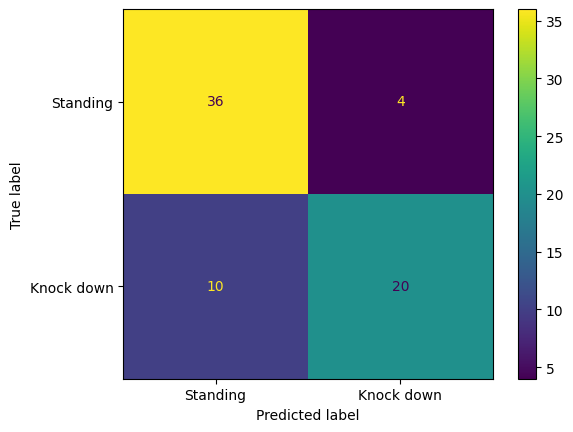

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, preds)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Standing", "Knock down"])

cm_display.plot()
plt.show()

In [20]:
precision_score(y_test, preds)

0.8333333333333334

In [21]:
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}

In [22]:
grid_search = GridSearchCV(rfc_pipe, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', RandomForestClassifier())]),
             param_grid={'model__max_depth': [None, 10, 20],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [50, 100, 200]},
             scoring='f1')

In [23]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [24]:
best_params

{'model__max_depth': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

In [25]:
best_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier())])

In [26]:
evaluate_classification_model(best_model, X_test, y_test)

Classification Model Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier())]) Evaluation:
F1 score: 0.92
